In [ ]:
# in this notebook, I will try to fit a model relating the mean behavior of L4, L2/3, SST and VIP cells

In [ ]:
# load the data

In [1]:
import pyute as ut
import autograd.numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import pdb
import scipy.optimize as sop
from mpl_toolkits.mplot3d import Axes3D
import sklearn.discriminant_analysis as skd
import autograd.scipy.special as ssp
from autograd import elementwise_grad as egrad
from autograd import grad
from autograd import jacobian
from autograd import hessian
import size_contrast_analysis as sca
import scipy.stats as sst
import sim_utils
from importlib import reload
reload(sim_utils)
import calnet.utils
import calnet.fitting_spatial_feature_model
import opto_utils
%matplotlib notebook

/Users/dan/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [14]:
dsbase = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/'
dsnames = [dsbase+x+'_data_struct.hdf5' for x in ['pyr_l4','pyr_l23','sst_l23','vip_l23','pv_l23']]

In [15]:
nsize,ncontrast = 5,6

In [16]:
with ut.hdf5read(dsnames[3]) as ds:
    keylist = list(ds.keys())
    print(ds[keylist[0]].keys())

<KeysViewHDF5 ['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0']>


In [17]:
with ut.hdf5read(dsnames[0]) as ds:
    keylist = list(ds.keys())
    print(list(ds[keylist[3]].keys()))

['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0', 'size_contrast_0']


In [18]:
to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
tuning,uparam,displacement,pval = sim_utils.compute_tuning(dsnames[-1],datafield='decon',running=False,expttype='size_contrast_0')
modal_uparam = uparam[0].copy()


<HDF5 group "/session_191105_M0589" (8 members)>
decon
1.0


/Users/dan/Documents/code/adesnal/sim_utils.py:62: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_191220_M0589" (8 members)>
decon
0.9995039682539683
<HDF5 group "/session_191229_M0892" (8 members)>
decon
0.9995039682539683
<HDF5 group "/session_200102_M0892" (8 members)>
decon
0.9350198412698413


In [19]:
tuning,uparam,displacement,pval = sim_utils.compute_tuning(dsnames[-2],datafield='decon',running=False,expttype='figure_ground_0')
modal_uparam_fg = uparam[0].copy()


<HDF5 group "/session_180321_M7955" (8 members)>
decon
0.08333333333333333
<HDF5 group "/session_180412_M7955" (8 members)>
<HDF5 group "/session_180516_M8956" (9 members)>
decon
0.67
<HDF5 group "/session_180519_M8959" (8 members)>
<HDF5 group "/session_180528_M8959" (9 members)>
decon
0.4875


/Users/dan/Documents/code/adesnal/sim_utils.py:62: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_180531_M8961" (9 members)>
decon
0.395
<HDF5 group "/session_180618_M8956" (9 members)>
decon
0.125
<HDF5 group "/session_180719_M8961" (8 members)>
<HDF5 group "/session_180720_M8961" (8 members)>
<HDF5 group "/session_180903_M8961" (9 members)>
decon
0.3075
<HDF5 group "/session_190710_M0208" (9 members)>
decon
0.7375


/Users/dan/Documents/code/adesnal/sim_utils.py:62: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_191215_M0385" (9 members)>
decon
0.7875
<HDF5 group "/session_200103_M0388" (9 members)>
decon
0.915


In [233]:
reload(sim_utils)
dsnames = [dsbase+x+'_data_struct.hdf5' for x in ['pyr_l4','pyr_l23','sst_l23','vip_l23','pv_l23']]
# dsnames = [dsnames[0],dsnames[2],dsnames[3],dsnames[4]]
ncelltypes = len(dsnames)
selection = [None for itype in range(ncelltypes)]
for itype in range(ncelltypes):
    with ut.hdf5read(dsnames[itype]) as ds:
        keylist = list(ds.keys())
        nexpt = len(keylist)
        to_keep = np.array([k not in to_exclude for k in keylist])
        selection[itype] = np.arange(nexpt)[to_keep]
# selection = utils.default_selection()
# selection[1] = [0,1,2,3,4,5,7,8,9]
# selection[3] = None
reload(calnet.utils)
rs = [None for irun in range(2)]
for irun,running in enumerate([False,True]):
    rs[irun] = calnet.utils.gen_rs_modal_uparam(dsnames=dsnames,selection=selection,running=running,modal_uparam=modal_uparam,expttype='size_contrast_0',pval_cutoff=1.1,average_ori=False,dcutoff=10.)
# ut.mkdir('data')
# np.save('data/celltype_rate_summary.npy',rs)
# rs = np.load('data/celltype_rate_summary.npy',allow_pickle=True)

/Users/dan/Documents/notebooks/mossing-PC/shared_data/pyr_l4_data_struct.hdf5
<HDF5 group "/session_181127_M10073" (8 members)>
decon
0.8257142857142857


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190202_M10075" (9 members)>
decon
0.6034722222222222


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190304_M10077" (9 members)>
decon
0.5597222222222222


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_190607_M10443" (9 members)>
decon
0.14097222222222222
<HDF5 group "/session_190620_M10616" (9 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.5431547619047619


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_190620_M10619" (9 members)>
decon
0.6006944444444444


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)
/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190624_M10615" (8 members)>
decon
0.08234126984126984
<HDF5 group "/session_190627_M10616" (9 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.7876984126984127
<HDF5 group "/session_190701_M10615" (8 members)>
decon
0.6691468253968254


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_191212_M0762" (8 members)>
decon
0.8219246031746031
/Users/dan/Documents/notebooks/mossing-PC/shared_data/pyr_l23_data_struct.hdf5
<HDF5 group "/session_181205_M10130" (8 members)>
decon
0.7321428571428571
<HDF5 group "/session_181209_M8536" (9 members)>
decon
0.8307142857142857


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_181213_M8536" (8 members)>
decon
0.03857142857142857
<HDF5 group "/session_181214_M10130" (8 members)>
decon
0.4142857142857143


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)
/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190102_M10130" (8 members)>
decon
0.44916666666666666
<HDF5 group "/session_190128_M8982" (9 members)>
decon
0.9472222222222222


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190130_M9667" (9 members)>
decon
0.19027777777777777
<HDF5 group "/session_190131_M9355" (9 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.9340277777777778


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190208_M9355" (9 members)>
decon
0.9506944444444444


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190212_M8536" (9 members)>
decon
0.2465277777777778
<HDF5 group "/session_191002_M0293" (8 members)>
decon
0.8462301587301587


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_191108_M0403" (8 members)>
decon
0.9970238095238095


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]
/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


/Users/dan/Documents/notebooks/mossing-PC/shared_data/sst_l23_data_struct.hdf5
<HDF5 group "/session_180713_M9053" (9 members)>
decon
0.19083333333333333
<HDF5 group "/session_180714_M9053" (9 members)>
decon
0.15583333333333332
<HDF5 group "/session_180802_M9053" (8 members)>
decon
0.49166666666666664


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_180821_M9417" (9 members)>
decon
0.8525
<HDF5 group "/session_181117_M10039" (9 members)>
decon
0.7892857142857143
<HDF5 group "/session_181120_M10039" (8 members)>
decon
0.8571428571428571


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_181121_M10039" (8 members)>
decon
0.9385714285714286
<HDF5 group "/session_191224_M0390" (13 members)>
decon
0.9404761904761905
<HDF5 group "/session_200109_M0755" (13 members)>
decon
0.9692460317460317
/Users/dan/Documents/notebooks/mossing-PC/shared_data/vip_l23_data_struct.hdf5
<HDF5 group "/session_180321_M7955" (8 members)>
<HDF5 group "/session_180412_M7955" (8 members)>
decon
0.011
<HDF5 group "/session_180516_M8956" (9 members)>
decon
0.275
<HDF5 group "/session_180519_M8959" (8 members)>
decon
0.0575
<HDF5 group "/session_180528_M8959" (9 members)>
decon
0.3383333333333333
<HDF5 group "/session_180531_M8961" (9 members)>
decon
0.3625
<HDF5 group "/session_180618_M8956" (9 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.004166666666666667
<HDF5 group "/session_180719_M8961" (8 members)>
decon
0.9908333333333333
<HDF5 group "/session_180720_M8961" (8 members)>
decon
0.9541666666666667
<HDF5 group "/session_180903_M8961" (9 members)>
decon
0.16583333333333333
<HDF5 group "/session_190710_M0208" (13 members)>
decon
0.7237103174603174


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_191215_M0385" (13 members)>
decon
0.8100198412698413
<HDF5 group "/session_200103_M0388" (13 members)>
decon
0.9191468253968254
/Users/dan/Documents/notebooks/mossing-PC/shared_data/pv_l23_data_struct.hdf5
<HDF5 group "/session_191105_M0589" (12 members)>
decon
1.0


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_191220_M0589" (12 members)>
decon
0.9995039682539683
<HDF5 group "/session_191229_M0892" (12 members)>
decon
0.9995039682539683
<HDF5 group "/session_200102_M0892" (12 members)>
decon
0.9350198412698413
<HDF5 group "/session_200108_M0891" (12 members)>
decon
0.8606150793650794
<HDF5 group "/session_200620_M0891" (13 members)>
decon
0.44543650793650796


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_200621_M0893" (13 members)>
decon
0.5277777777777778


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)
/Users/dan/Documents/code/adesnal/calnet/utils.py:188: RuntimeWarning: invalid value encountered in less
  raligned = np.concatenate([average_up(x[aligned[i]][:,condition_inds[0],condition_inds[1]]) for i,x in enumerate(these_tunings)],axis=0)
/Users/dan/Documents/code/adesnal/calnet/utils.py:547: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return w
/Users/dan/Documents/code/adesnal/calnet/utils.py:553: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)

/Users/dan/Documents/notebooks/mossing-PC/shared_data/pyr_l4_data_struct.hdf5
<HDF5 group "/session_181127_M10073" (8 members)>
decon
0.1742857142857143
<HDF5 group "/session_190202_M10075" (9 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]
/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.39652777777777776
<HDF5 group "/session_190304_M10077" (9 members)>
decon
0.44027777777777777


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_190607_M10443" (9 members)>
decon
0.8590277777777777


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190620_M10616" (9 members)>
decon
0.4568452380952381


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_190620_M10619" (9 members)>
decon
0.3993055555555556
<HDF5 group "/session_190624_M10615" (8 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.9176587301587301


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190627_M10616" (9 members)>
decon
0.2123015873015873
<HDF5 group "/session_190701_M10615" (8 members)>
decon
0.3308531746031746
<HDF5 group "/session_191212_M0762" (8 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.17807539682539683
/Users/dan/Documents/notebooks/mossing-PC/shared_data/pyr_l23_data_struct.hdf5
<HDF5 group "/session_181205_M10130" (8 members)>
decon
0.26785714285714285
<HDF5 group "/session_181209_M8536" (9 members)>
decon
0.1692857142857143
<HDF5 group "/session_181213_M8536" (8 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.9614285714285714
<HDF5 group "/session_181214_M10130" (8 members)>
decon
0.5857142857142857


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190102_M10130" (8 members)>
decon
0.5508333333333333
<HDF5 group "/session_190128_M8982" (9 members)>
decon
0.05277777777777778
<HDF5 group "/session_190130_M9667" (9 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.8097222222222222


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190131_M9355" (9 members)>
decon
0.06597222222222222
<HDF5 group "/session_190208_M9355" (9 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.049305555555555554
<HDF5 group "/session_190212_M8536" (9 members)>
decon
0.7534722222222222


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]
/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_191002_M0293" (8 members)>
decon
0.15376984126984128
<HDF5 group "/session_191108_M0403" (8 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.002976190476190476
/Users/dan/Documents/notebooks/mossing-PC/shared_data/sst_l23_data_struct.hdf5
<HDF5 group "/session_180713_M9053" (9 members)>
decon
0.8091666666666667


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_180714_M9053" (9 members)>
decon
0.8441666666666666


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_180802_M9053" (8 members)>
decon
0.5083333333333333


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_180821_M9417" (9 members)>
decon
0.1475
<HDF5 group "/session_181117_M10039" (9 members)>
decon
0.21071428571428572
<HDF5 group "/session_181120_M10039" (8 members)>
decon
0.14285714285714285
<HDF5 group "/session_181121_M10039" (8 members)>
decon
0.06142857142857143
<HDF5 group "/session_191224_M0390" (13 members)>
decon
0.05952380952380952
<HDF5 group "/session_200109_M0755" (13 members)>
decon


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


0.030753968253968252
/Users/dan/Documents/notebooks/mossing-PC/shared_data/vip_l23_data_struct.hdf5
<HDF5 group "/session_180321_M7955" (8 members)>
<HDF5 group "/session_180412_M7955" (8 members)>
decon
0.989


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_180516_M8956" (9 members)>
decon
0.725
<HDF5 group "/session_180519_M8959" (8 members)>
decon
0.9425
<HDF5 group "/session_180528_M8959" (9 members)>
decon
0.6616666666666666


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_180531_M8961" (9 members)>
decon
0.6375


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_180618_M8956" (9 members)>
decon
0.9958333333333333
<HDF5 group "/session_180719_M8961" (8 members)>
decon
0.009166666666666667
<HDF5 group "/session_180720_M8961" (8 members)>
decon
0.04583333333333333
<HDF5 group "/session_180903_M8961" (9 members)>
decon
0.8341666666666666


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]


<HDF5 group "/session_190710_M0208" (13 members)>
decon
0.27628968253968256
<HDF5 group "/session_191215_M0385" (13 members)>
decon
0.18998015873015872
<HDF5 group "/session_200103_M0388" (13 members)>
decon
0.08085317460317461
/Users/dan/Documents/notebooks/mossing-PC/shared_data/pv_l23_data_struct.hdf5
<HDF5 group "/session_191105_M0589" (12 members)>
decon
0.0
<HDF5 group "/session_191220_M0589" (12 members)>
decon
0.000496031746031746
<HDF5 group "/session_191229_M0892" (12 members)>
decon
0.000496031746031746
<HDF5 group "/session_200102_M0892" (12 members)>
decon
0.06498015873015874
<HDF5 group "/session_200108_M0891" (12 members)>
decon
0.13938492063492064
<HDF5 group "/session_200620_M0891" (13 members)>
decon
0.5545634920634921


/Users/dan/Documents/code/adesnal/calnet/utils.py:57: RuntimeWarning: invalid value encountered in less
  rf_conditions = [ut.k_and(~np.isnan(X[:,0]),~np.isnan(y[:,0])),sqerror<0.75,sigma>3.3,pval[ikey]<0.1]
/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_200621_M0893" (13 members)>
decon
0.4722222222222222


/Users/dan/Documents/code/adesnal/pyute.py:1100: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)
/Users/dan/Documents/code/adesnal/calnet/utils.py:188: RuntimeWarning: invalid value encountered in less
  raligned = np.concatenate([average_up(x[aligned[i]][:,condition_inds[0],condition_inds[1]]) for i,x in enumerate(these_tunings)],axis=0)
/Users/dan/Documents/code/adesnal/calnet/utils.py:547: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return w
/Users/dan/Documents/code/adesnal/calnet/utils.py:553: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)

In [247]:
rsrun = rs.copy()

In [248]:
reload(opto_utils)
for irun in range(len(rsrun)):
    for icelltype in range(len(rsrun[irun])):
        rsrun[irun][icelltype] = opto_utils.sort_by_pref_dir(rsrun[irun][icelltype])

In [249]:
# np.save('rs_ori_no_pval_criterion_200624.npy',rsrun,allow_pickle=True)
np.save('rsrun_ori_no_pval_criterion_200624.npy',rsrun,allow_pickle=True)

In [13]:

# rsdict = np.load('../opto1p/rsdict_ca_200128.npy',allow_pickle=True)[()]


In [15]:
# rs = rsdict['rsdict']['size_contrast_0'].copy() #['size_contrast_0']

In [30]:
# reload(utils)
# rs_fg = utils.gen_rs_modal_uparam(dsnames=dsnames,selection=selection,running=False,modal_uparam=modal_uparam_fg,expttype='figure_ground_0',pval_cutoff=1.1)

In [32]:
# rs = np.load('rs_no_pval_criterion_200118.npy',allow_pickle=True)[()] #,{'rs':rs,'rs_fg':rs_fg})

In [30]:
# rs = np.load('rs_ori_no_pval_criterion_200204.npy',allow_pickle=True)

In [250]:
ndir = 8

In [251]:
angles = np.arange(ndir)/ndir*2*np.pi
def von_mises_denoise(tuning_curves):
    vm_bounds = ((0,0,0,-np.pi/8),(np.inf,np.inf,1,np.pi/8))
    nparams = 4
    nrois = tuning_curves.shape[0]
    popt = np.zeros((nrois,nsize,ncontrast,nparams))
    tuning_von_mises = np.zeros_like(tuning_curves)
    for iroi in range(nrois):
        for isize in range(nsize):
            for icontrast in range(ncontrast):
                if icontrast==0:
                    fit_fn = von_mises_fn
                else:
                    fit_fn = flat_fn
                try:
#                 for zzz in (1,):
                    data = tuning_curves[iroi,isize,icontrast].copy()
                    angles_to_use = angles[~np.isnan(data)]
                    if angles_to_use.size:
                        popt[iroi,isize,icontrast],_ = sop.curve_fit(von_mises_fn,angles_to_use,data,bounds=vm_bounds)
                        tuning_von_mises[iroi,isize,icontrast] = von_mises_fn(angles,*popt[iroi,isize,icontrast])
                    else:
                        tuning_von_mises[iroi,isize,icontrast] = tuning_curves[iroi,isize,icontrast]
                except:
                    print('could not do (%d,%d,%d)'%(iroi,isize,icontrast))
                    tuning_von_mises[iroi,isize,icontrast] = tuning_curves[iroi,isize,icontrast]
    return tuning_von_mises

In [252]:
def von_mises_fn(x,A,kappa,b,mu):
    return A*(np.exp(kappa*np.cos(x-mu))+b*np.exp(kappa*np.cos(x-np.pi-mu)))/ssp.iv(0,kappa)/2/np.pi/(1+b)
def flat_fn(x,A,kappa,b,mu):
    return A*np.ones_like(x)

In [269]:
plt.close('all')

<IPython.core.display.Javascript object>


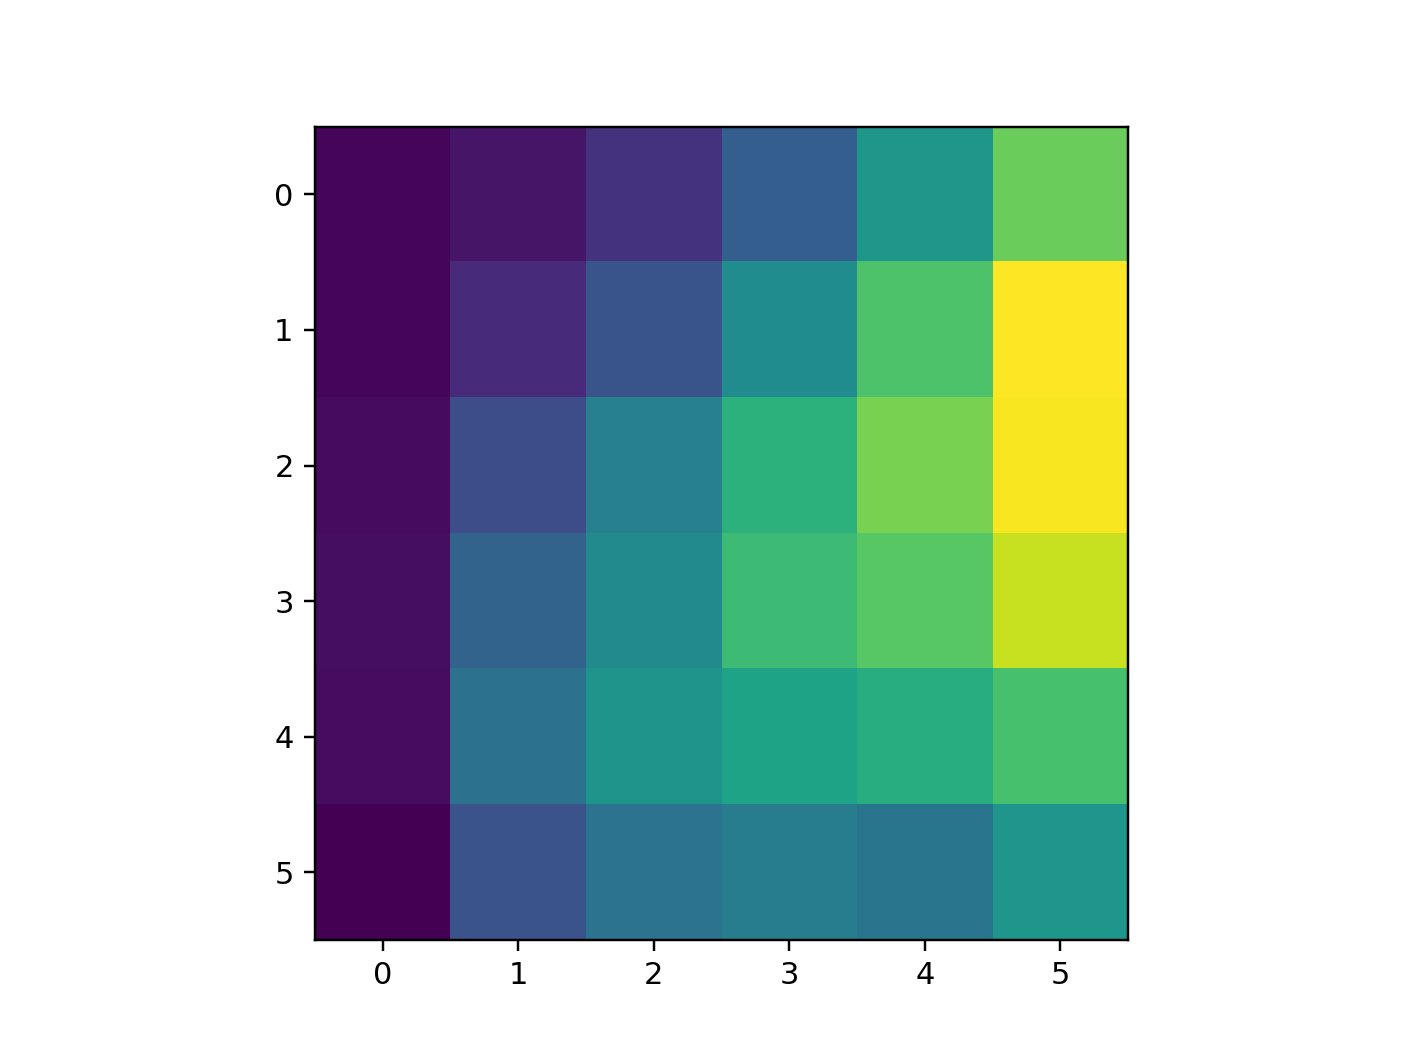

In [268]:
irun,itype,ialignment = 1,1,0
plt.figure()
plt.imshow(np.nanmean(np.nanmean(rsrun[irun][itype][ialignment],3),0))

In [260]:
rs_denoise = [None for this_r in rsrun]
for irun in range(2):
    rs_denoise[irun] = [None for this_r in rsrun[irun]]
    for ir in range(len(rsrun[irun])):
        print(ir)
        rs_denoise[irun][ir] = [None for iS in range(len(rsrun[irun][ir]))]
        if not rsrun[irun][ir] is None:
            for iS in range(len(rsrun[irun][ir])):
                rs_denoise[irun][ir][iS] = von_mises_denoise(rsrun[irun][ir][iS])

0
could not do (20,1,3)
could not do (669,3,4)
could not do (711,1,2)
could not do (812,2,4)
could not do (830,3,2)
could not do (1292,1,1)
could not do (1319,1,2)
could not do (1319,4,0)
could not do (1319,5,4)
could not do (1319,5,5)
could not do (1320,1,2)
could not do (1320,4,0)
could not do (1320,5,4)
could not do (1320,5,5)
could not do (1321,1,2)
could not do (1321,4,0)
could not do (1321,5,4)
could not do (1321,5,5)
could not do (1322,1,2)
could not do (1322,4,0)
could not do (1322,5,4)
could not do (1322,5,5)
could not do (1323,1,2)
could not do (1323,4,0)
could not do (1323,5,4)
could not do (1323,5,5)
could not do (1324,1,2)
could not do (1324,4,0)
could not do (1324,5,4)
could not do (1324,5,5)
could not do (1325,1,2)
could not do (1325,4,0)
could not do (1325,5,4)
could not do (1325,5,5)
could not do (1326,1,2)
could not do (1326,4,0)
could not do (1326,5,4)
could not do (1326,5,5)
could not do (1327,1,2)
could not do (1327,4,0)
could not do (1327,5,4)
could not do (1327,5

could not do (1403,5,4)
could not do (1403,5,5)
could not do (1404,1,2)
could not do (1404,4,0)
could not do (1404,5,4)
could not do (1404,5,5)
could not do (1405,1,2)
could not do (1405,4,0)
could not do (1405,5,4)
could not do (1405,5,5)
could not do (1406,1,2)
could not do (1406,4,0)
could not do (1406,5,4)
could not do (1406,5,5)
could not do (1407,1,2)
could not do (1407,4,0)
could not do (1407,5,4)
could not do (1407,5,5)
could not do (1408,1,2)
could not do (1408,4,0)
could not do (1408,5,4)
could not do (1408,5,5)
could not do (1409,1,2)
could not do (1409,4,0)
could not do (1409,5,4)
could not do (1409,5,5)
could not do (1410,1,2)
could not do (1410,4,0)
could not do (1410,5,4)
could not do (1410,5,5)
could not do (1411,1,2)
could not do (1411,4,0)
could not do (1411,5,4)
could not do (1411,5,5)
could not do (1412,1,2)
could not do (1412,4,0)
could not do (1412,5,4)
could not do (1412,5,5)
could not do (1413,1,2)
could not do (1413,4,0)
could not do (1413,5,4)
could not do (14

could not do (1489,1,2)
could not do (1489,4,0)
could not do (1489,5,4)
could not do (1489,5,5)
could not do (1490,1,2)
could not do (1490,4,0)
could not do (1490,5,4)
could not do (1490,5,5)
could not do (1491,1,2)
could not do (1491,4,0)
could not do (1491,5,4)
could not do (1491,5,5)
could not do (1492,1,2)
could not do (1492,4,0)
could not do (1492,5,4)
could not do (1492,5,5)
could not do (1493,1,2)
could not do (1493,4,0)
could not do (1493,5,4)
could not do (1493,5,5)
could not do (1494,1,2)
could not do (1494,4,0)
could not do (1494,5,4)
could not do (1494,5,5)
could not do (1495,1,2)
could not do (1495,4,0)
could not do (1495,5,4)
could not do (1495,5,5)
could not do (1496,1,2)
could not do (1496,4,0)
could not do (1496,5,4)
could not do (1496,5,5)
could not do (1497,1,2)
could not do (1497,4,0)
could not do (1497,5,4)
could not do (1497,5,5)
could not do (1498,1,2)
could not do (1498,4,0)
could not do (1498,5,4)
could not do (1498,5,5)
could not do (1499,1,2)
could not do (14

could not do (1575,5,4)
could not do (1575,5,5)
could not do (1576,1,2)
could not do (1576,4,0)
could not do (1576,5,4)
could not do (1576,5,5)
could not do (1577,1,2)
could not do (1577,4,0)
could not do (1577,5,4)
could not do (1577,5,5)
could not do (1578,1,2)
could not do (1578,4,0)
could not do (1578,5,4)
could not do (1578,5,5)
could not do (1579,1,2)
could not do (1579,4,0)
could not do (1579,5,4)
could not do (1579,5,5)
could not do (1580,1,2)
could not do (1580,4,0)
could not do (1580,5,4)
could not do (1580,5,5)
could not do (1581,1,2)
could not do (1581,4,0)
could not do (1581,5,4)
could not do (1581,5,5)
could not do (1582,1,2)
could not do (1582,4,0)
could not do (1582,5,4)
could not do (1582,5,5)
could not do (1583,1,2)
could not do (1583,4,0)
could not do (1583,5,4)
could not do (1583,5,5)
could not do (1584,1,2)
could not do (1584,4,0)
could not do (1584,5,4)
could not do (1584,5,5)
could not do (1585,1,2)
could not do (1585,4,0)
could not do (1585,5,4)
could not do (15

could not do (1661,4,0)
could not do (1661,5,4)
could not do (1661,5,5)
could not do (1662,1,2)
could not do (1662,4,0)
could not do (1662,5,4)
could not do (1662,5,5)
could not do (1663,1,2)
could not do (1663,4,0)
could not do (1663,5,4)
could not do (1663,5,5)
could not do (1664,1,2)
could not do (1664,4,0)
could not do (1664,5,4)
could not do (1664,5,5)
could not do (1665,1,2)
could not do (1665,4,0)
could not do (1665,5,4)
could not do (1665,5,5)
could not do (1666,1,2)
could not do (1666,4,0)
could not do (1666,5,4)
could not do (1666,5,5)
could not do (1667,1,2)
could not do (1667,4,0)
could not do (1667,5,4)
could not do (1667,5,5)
could not do (1668,1,2)
could not do (1668,4,0)
could not do (1668,5,4)
could not do (1668,5,5)
could not do (1669,1,2)
could not do (1669,4,0)
could not do (1669,5,4)
could not do (1669,5,5)
could not do (1670,1,2)
could not do (1670,4,0)
could not do (1670,5,4)
could not do (1670,5,5)
could not do (1671,1,2)
could not do (1671,4,0)
could not do (16

could not do (1747,5,4)
could not do (1747,5,5)
could not do (1748,1,2)
could not do (1748,4,0)
could not do (1748,5,4)
could not do (1748,5,5)
could not do (1749,1,2)
could not do (1749,4,0)
could not do (1749,5,4)
could not do (1749,5,5)
could not do (1750,1,2)
could not do (1750,4,0)
could not do (1750,5,4)
could not do (1750,5,5)
could not do (1751,1,2)
could not do (1751,4,0)
could not do (1751,5,4)
could not do (1751,5,5)
could not do (1752,1,2)
could not do (1752,4,0)
could not do (1752,5,4)
could not do (1752,5,5)
could not do (1753,1,2)
could not do (1753,4,0)
could not do (1753,5,4)
could not do (1753,5,5)
could not do (1754,1,2)
could not do (1754,4,0)
could not do (1754,5,4)
could not do (1754,5,5)
could not do (1755,1,2)
could not do (1755,4,0)
could not do (1755,5,4)
could not do (1755,5,5)
could not do (1756,1,2)
could not do (1756,4,0)
could not do (1756,5,4)
could not do (1756,5,5)
could not do (1757,1,2)
could not do (1757,4,0)
could not do (1757,5,4)
could not do (17

could not do (1833,4,0)
could not do (1833,5,4)
could not do (1833,5,5)
could not do (1834,1,2)
could not do (1834,4,0)
could not do (1834,5,4)
could not do (1834,5,5)
could not do (1835,1,2)
could not do (1835,4,0)
could not do (1835,5,4)
could not do (1835,5,5)
could not do (1836,1,2)
could not do (1836,4,0)
could not do (1836,5,4)
could not do (1836,5,5)
could not do (1837,1,2)
could not do (1837,4,0)
could not do (1837,5,4)
could not do (1837,5,5)
could not do (1838,1,2)
could not do (1838,4,0)
could not do (1838,5,4)
could not do (1838,5,5)
could not do (1839,1,2)
could not do (1839,4,0)
could not do (1839,5,4)
could not do (1839,5,5)
could not do (1840,1,2)
could not do (1840,4,0)
could not do (1840,5,4)
could not do (1840,5,5)
could not do (1841,1,2)
could not do (1841,4,0)
could not do (1841,5,4)
could not do (1841,5,5)
could not do (1842,1,2)
could not do (1842,4,0)
could not do (1842,5,4)
could not do (1842,5,5)
could not do (1843,1,2)
could not do (1843,4,0)
could not do (18

could not do (1919,1,2)
could not do (1919,4,0)
could not do (1919,5,4)
could not do (1919,5,5)
could not do (1920,1,2)
could not do (1920,4,0)
could not do (1920,5,4)
could not do (1920,5,5)
could not do (1921,1,2)
could not do (1921,4,0)
could not do (1921,5,4)
could not do (1921,5,5)
could not do (1922,1,2)
could not do (1922,4,0)
could not do (1922,5,4)
could not do (1922,5,5)
could not do (1923,1,2)
could not do (1923,4,0)
could not do (1923,5,4)
could not do (1923,5,5)
could not do (1924,1,2)
could not do (1924,4,0)
could not do (1924,5,4)
could not do (1924,5,5)
could not do (1925,1,2)
could not do (1925,4,0)
could not do (1925,5,4)
could not do (1925,5,5)
could not do (1926,1,2)
could not do (1926,4,0)
could not do (1926,5,4)
could not do (1926,5,5)
could not do (1927,1,2)
could not do (1927,4,0)
could not do (1927,5,4)
could not do (1927,5,5)
could not do (1928,1,2)
could not do (1928,4,0)
could not do (1928,5,4)
could not do (1928,5,5)
could not do (1929,1,2)
could not do (19

could not do (2005,1,2)
could not do (2005,4,0)
could not do (2005,5,4)
could not do (2005,5,5)
could not do (2006,1,2)
could not do (2006,4,0)
could not do (2006,5,4)
could not do (2006,5,5)
could not do (2007,1,2)
could not do (2007,4,0)
could not do (2007,5,4)
could not do (2007,5,5)
could not do (2008,1,2)
could not do (2008,4,0)
could not do (2008,5,4)
could not do (2008,5,5)
could not do (2009,1,2)
could not do (2009,4,0)
could not do (2009,5,4)
could not do (2009,5,5)
could not do (2010,1,2)
could not do (2010,4,0)
could not do (2010,5,4)
could not do (2010,5,5)
could not do (2011,1,2)
could not do (2011,4,0)
could not do (2011,5,4)
could not do (2011,5,5)
could not do (2012,1,2)
could not do (2012,4,0)
could not do (2012,5,4)
could not do (2012,5,5)
could not do (2013,1,2)
could not do (2013,4,0)
could not do (2013,5,4)
could not do (2013,5,5)
could not do (2014,1,2)
could not do (2014,4,0)
could not do (2014,5,4)
could not do (2014,5,5)
could not do (2015,1,2)
could not do (20

could not do (2091,4,0)
could not do (2091,5,4)
could not do (2091,5,5)
could not do (2092,1,2)
could not do (2092,4,0)
could not do (2092,5,4)
could not do (2092,5,5)
could not do (2093,1,2)
could not do (2093,4,0)
could not do (2093,5,4)
could not do (2093,5,5)
could not do (2094,1,2)
could not do (2094,4,0)
could not do (2094,5,4)
could not do (2094,5,5)
could not do (2095,1,2)
could not do (2095,4,0)
could not do (2095,5,4)
could not do (2095,5,5)
could not do (2096,1,2)
could not do (2096,4,0)
could not do (2096,5,4)
could not do (2096,5,5)
could not do (2097,1,2)
could not do (2097,4,0)
could not do (2097,5,4)
could not do (2097,5,5)
could not do (2098,1,2)
could not do (2098,4,0)
could not do (2098,5,4)
could not do (2098,5,5)
could not do (2099,1,2)
could not do (2099,4,0)
could not do (2099,5,4)
could not do (2099,5,5)
could not do (2100,1,2)
could not do (2100,4,0)
could not do (2100,5,4)
could not do (2100,5,5)
could not do (2101,1,2)
could not do (2101,4,0)
could not do (21

could not do (2176,5,4)
could not do (2176,5,5)
could not do (2177,1,2)
could not do (2177,4,0)
could not do (2177,5,4)
could not do (2177,5,5)
could not do (2178,1,2)
could not do (2178,4,0)
could not do (2178,5,4)
could not do (2178,5,5)
could not do (2179,1,2)
could not do (2179,4,0)
could not do (2179,5,4)
could not do (2179,5,5)
could not do (2180,1,2)
could not do (2180,4,0)
could not do (2180,5,4)
could not do (2180,5,5)
could not do (2181,1,2)
could not do (2181,4,0)
could not do (2181,5,4)
could not do (2181,5,5)
could not do (2182,1,2)
could not do (2182,4,0)
could not do (2182,5,4)
could not do (2182,5,5)
could not do (2183,1,2)
could not do (2183,4,0)
could not do (2183,5,4)
could not do (2183,5,5)
could not do (2184,1,2)
could not do (2184,4,0)
could not do (2184,5,4)
could not do (2184,5,5)
could not do (2185,1,2)
could not do (2185,4,0)
could not do (2185,5,4)
could not do (2185,5,5)
could not do (2186,1,2)
could not do (2186,4,0)
could not do (2186,5,4)
could not do (21

could not do (2262,1,2)
could not do (2262,4,0)
could not do (2262,5,4)
could not do (2262,5,5)
could not do (2263,1,2)
could not do (2263,4,0)
could not do (2263,5,4)
could not do (2263,5,5)
could not do (2264,1,2)
could not do (2264,4,0)
could not do (2264,5,4)
could not do (2264,5,5)
could not do (2265,1,2)
could not do (2265,4,0)
could not do (2265,5,4)
could not do (2265,5,5)
could not do (2266,1,2)
could not do (2266,4,0)
could not do (2266,5,4)
could not do (2266,5,5)
could not do (2267,1,2)
could not do (2267,4,0)
could not do (2267,5,4)
could not do (2267,5,5)
could not do (2268,1,2)
could not do (2268,4,0)
could not do (2268,5,4)
could not do (2268,5,5)
could not do (2269,1,2)
could not do (2269,4,0)
could not do (2269,5,4)
could not do (2269,5,5)
could not do (2270,1,2)
could not do (2270,4,0)
could not do (2270,5,4)
could not do (2270,5,5)
could not do (2271,1,2)
could not do (2271,4,0)
could not do (2271,5,4)
could not do (2271,5,5)
could not do (2272,1,2)
could not do (22

could not do (2348,1,2)
could not do (2348,4,0)
could not do (2348,5,4)
could not do (2348,5,5)
could not do (2349,1,2)
could not do (2349,4,0)
could not do (2349,5,4)
could not do (2349,5,5)
could not do (2350,1,2)
could not do (2350,4,0)
could not do (2350,5,4)
could not do (2350,5,5)
could not do (2351,1,2)
could not do (2351,4,0)
could not do (2351,5,4)
could not do (2351,5,5)
could not do (2352,1,2)
could not do (2352,4,0)
could not do (2352,5,4)
could not do (2352,5,5)
could not do (2353,1,2)
could not do (2353,4,0)
could not do (2353,5,4)
could not do (2353,5,5)
could not do (2354,1,2)
could not do (2354,4,0)
could not do (2354,5,4)
could not do (2354,5,5)
could not do (2355,1,2)
could not do (2355,4,0)
could not do (2355,5,4)
could not do (2355,5,5)
could not do (2356,1,2)
could not do (2356,4,0)
could not do (2356,5,4)
could not do (2356,5,5)
could not do (2357,1,2)
could not do (2357,4,0)
could not do (2357,5,4)
could not do (2357,5,5)
could not do (2358,1,2)
could not do (23

could not do (2433,5,4)
could not do (2433,5,5)
could not do (2434,1,2)
could not do (2434,4,0)
could not do (2434,5,4)
could not do (2434,5,5)
could not do (2435,1,2)
could not do (2435,4,0)
could not do (2435,5,4)
could not do (2435,5,5)
could not do (2436,1,2)
could not do (2436,4,0)
could not do (2436,5,4)
could not do (2436,5,5)
could not do (2437,1,2)
could not do (2437,4,0)
could not do (2437,5,4)
could not do (2437,5,5)
could not do (2438,1,2)
could not do (2438,4,0)
could not do (2438,5,4)
could not do (2438,5,5)
could not do (2439,1,2)
could not do (2439,4,0)
could not do (2439,5,4)
could not do (2439,5,5)
could not do (2440,1,2)
could not do (2440,4,0)
could not do (2440,5,4)
could not do (2440,5,5)
could not do (2441,1,2)
could not do (2441,4,0)
could not do (2441,5,4)
could not do (2441,5,5)
could not do (2442,1,2)
could not do (2442,4,0)
could not do (2442,5,4)
could not do (2442,5,5)
could not do (2443,1,2)
could not do (2443,4,0)
could not do (2443,5,4)
could not do (24

could not do (2519,5,4)
could not do (2519,5,5)
could not do (2520,1,2)
could not do (2520,4,0)
could not do (2520,5,4)
could not do (2520,5,5)
could not do (2521,1,2)
could not do (2521,4,0)
could not do (2521,5,4)
could not do (2521,5,5)
could not do (2522,1,2)
could not do (2522,4,0)
could not do (2522,5,4)
could not do (2522,5,5)
could not do (2523,1,2)
could not do (2523,4,0)
could not do (2523,5,4)
could not do (2523,5,5)
could not do (2524,1,2)
could not do (2524,4,0)
could not do (2524,5,4)
could not do (2524,5,5)
could not do (2525,1,2)
could not do (2525,4,0)
could not do (2525,5,4)
could not do (2525,5,5)
could not do (2526,1,2)
could not do (2526,4,0)
could not do (2526,5,4)
could not do (2526,5,5)
could not do (2527,1,2)
could not do (2527,4,0)
could not do (2527,5,4)
could not do (2527,5,5)
could not do (2528,1,2)
could not do (2528,4,0)
could not do (2528,5,4)
could not do (2528,5,5)
could not do (2529,1,2)
could not do (2529,4,0)
could not do (2529,5,4)
could not do (25

could not do (2605,4,0)
could not do (2605,5,4)
could not do (2605,5,5)
could not do (2606,1,2)
could not do (2606,4,0)
could not do (2606,5,4)
could not do (2606,5,5)
could not do (2607,1,2)
could not do (2607,4,0)
could not do (2607,5,4)
could not do (2607,5,5)
could not do (2608,1,2)
could not do (2608,4,0)
could not do (2608,5,4)
could not do (2608,5,5)
could not do (2609,1,2)
could not do (2609,4,0)
could not do (2609,5,4)
could not do (2609,5,5)
could not do (2610,1,2)
could not do (2610,4,0)
could not do (2610,5,4)
could not do (2610,5,5)
could not do (2611,1,2)
could not do (2611,4,0)
could not do (2611,5,4)
could not do (2611,5,5)
could not do (2612,1,2)
could not do (2612,4,0)
could not do (2612,5,4)
could not do (2612,5,5)
could not do (2613,1,2)
could not do (2613,4,0)
could not do (2613,5,4)
could not do (2613,5,5)
could not do (2614,1,2)
could not do (2614,4,0)
could not do (2614,5,4)
could not do (2614,5,5)
could not do (2615,1,2)
could not do (2615,4,0)
could not do (26

could not do (2691,4,0)
could not do (2691,5,4)
could not do (2691,5,5)
could not do (2692,1,2)
could not do (2692,4,0)
could not do (2692,5,4)
could not do (2692,5,5)
could not do (2693,1,2)
could not do (2693,4,0)
could not do (2693,5,4)
could not do (2693,5,5)
could not do (2694,1,2)
could not do (2694,4,0)
could not do (2694,5,4)
could not do (2694,5,5)
could not do (2695,1,2)
could not do (2695,4,0)
could not do (2695,5,4)
could not do (2695,5,5)
could not do (2696,1,2)
could not do (2696,4,0)
could not do (2696,5,4)
could not do (2696,5,5)
could not do (2697,1,2)
could not do (2697,4,0)
could not do (2697,5,4)
could not do (2697,5,5)
could not do (2698,1,2)
could not do (2698,4,0)
could not do (2698,5,4)
could not do (2698,5,5)
could not do (2699,1,2)
could not do (2699,4,0)
could not do (2699,5,4)
could not do (2699,5,5)
could not do (2700,1,2)
could not do (2700,4,0)
could not do (2700,5,4)
could not do (2700,5,5)
could not do (2701,1,2)
could not do (2701,4,0)
could not do (27

could not do (2777,4,0)
could not do (2777,5,4)
could not do (2777,5,5)
could not do (2778,1,2)
could not do (2778,4,0)
could not do (2778,5,4)
could not do (2778,5,5)
could not do (2779,1,2)
could not do (2779,4,0)
could not do (2779,5,4)
could not do (2779,5,5)
could not do (2780,1,2)
could not do (2780,4,0)
could not do (2780,5,4)
could not do (2780,5,5)
could not do (2781,1,2)
could not do (2781,4,0)
could not do (2781,5,4)
could not do (2781,5,5)
could not do (2782,1,2)
could not do (2782,4,0)
could not do (2782,5,4)
could not do (2782,5,5)
could not do (2783,1,2)
could not do (2783,4,0)
could not do (2783,5,4)
could not do (2783,5,5)
could not do (2784,1,2)
could not do (2784,4,0)
could not do (2784,5,4)
could not do (2784,5,5)
could not do (2785,1,2)
could not do (2785,4,0)
could not do (2785,5,4)
could not do (2785,5,5)
could not do (2786,1,2)
could not do (2786,4,0)
could not do (2786,5,4)
could not do (2786,5,5)
could not do (2787,1,2)
could not do (2787,4,0)
could not do (27

could not do (2863,4,0)
could not do (2863,5,4)
could not do (2863,5,5)
could not do (2864,1,2)
could not do (2864,4,0)
could not do (2864,5,4)
could not do (2864,5,5)
could not do (2865,1,2)
could not do (2865,4,0)
could not do (2865,5,4)
could not do (2865,5,5)
could not do (2866,1,2)
could not do (2866,4,0)
could not do (2866,5,4)
could not do (2866,5,5)
could not do (2867,1,2)
could not do (2867,4,0)
could not do (2867,5,4)
could not do (2867,5,5)
could not do (2868,1,2)
could not do (2868,4,0)
could not do (2868,5,4)
could not do (2868,5,5)
could not do (2869,1,2)
could not do (2869,4,0)
could not do (2869,5,4)
could not do (2869,5,5)
could not do (2870,1,2)
could not do (2870,4,0)
could not do (2870,5,4)
could not do (2870,5,5)
could not do (2871,1,2)
could not do (2871,4,0)
could not do (2871,5,4)
could not do (2871,5,5)
could not do (2872,1,2)
could not do (2872,4,0)
could not do (2872,5,4)
could not do (2872,5,5)
could not do (2873,1,2)
could not do (2873,4,0)
could not do (28

could not do (2950,1,2)
could not do (2950,4,0)
could not do (2950,5,4)
could not do (2950,5,5)
could not do (2951,1,2)
could not do (2951,4,0)
could not do (2951,5,4)
could not do (2951,5,5)
could not do (2952,1,2)
could not do (2952,4,0)
could not do (2952,5,4)
could not do (2952,5,5)
could not do (2953,1,2)
could not do (2953,4,0)
could not do (2953,5,4)
could not do (2953,5,5)
could not do (2954,1,2)
could not do (2954,4,0)
could not do (2954,5,4)
could not do (2954,5,5)
could not do (2955,1,2)
could not do (2955,4,0)
could not do (2955,5,4)
could not do (2955,5,5)
could not do (2956,1,2)
could not do (2956,4,0)
could not do (2956,5,4)
could not do (2956,5,5)
could not do (2957,1,2)
could not do (2957,4,0)
could not do (2957,5,4)
could not do (2957,5,5)
could not do (2958,1,2)
could not do (2958,4,0)
could not do (2958,5,4)
could not do (2958,5,5)
could not do (2959,1,2)
could not do (2959,4,0)
could not do (2959,5,4)
could not do (2959,5,5)
could not do (2960,1,2)
could not do (29

could not do (3035,5,3)
could not do (3035,5,4)
could not do (3035,5,5)
could not do (3036,1,2)
could not do (3036,4,0)
could not do (3036,5,4)
could not do (3036,5,5)
could not do (3037,1,2)
could not do (3037,4,0)
could not do (3037,5,4)
could not do (3037,5,5)
could not do (3038,1,2)
could not do (3038,4,0)
could not do (3038,5,4)
could not do (3038,5,5)
could not do (3039,1,2)
could not do (3039,4,0)
could not do (3039,5,4)
could not do (3039,5,5)
could not do (3040,1,2)
could not do (3040,4,0)
could not do (3040,5,4)
could not do (3040,5,5)
could not do (3041,1,2)
could not do (3041,4,0)
could not do (3041,5,4)
could not do (3041,5,5)
could not do (3042,1,2)
could not do (3042,4,0)
could not do (3042,5,4)
could not do (3042,5,5)
could not do (3043,1,2)
could not do (3043,4,0)
could not do (3043,5,4)
could not do (3043,5,5)
could not do (3044,1,2)
could not do (3044,4,0)
could not do (3044,5,4)
could not do (3044,5,5)
could not do (3045,1,2)
could not do (3045,4,0)
could not do (30

could not do (3231,1,0)
could not do (3232,1,0)
could not do (3233,1,0)
could not do (3234,1,0)
could not do (3235,1,0)
could not do (3236,1,0)
could not do (3237,1,0)
could not do (3238,1,0)
could not do (3239,1,0)
could not do (3240,1,0)
could not do (3241,1,0)
could not do (3242,1,0)
could not do (3243,1,0)
could not do (3244,1,0)
could not do (3245,1,0)
could not do (3246,1,0)
could not do (3247,1,0)
could not do (6737,5,3)
could not do (6799,5,3)
could not do (6992,4,4)
could not do (6992,5,4)
could not do (178,3,0)
could not do (252,1,4)
could not do (291,1,0)
could not do (292,1,0)
could not do (293,1,0)
could not do (294,1,0)
could not do (295,1,0)
could not do (296,1,0)
could not do (297,1,0)
could not do (298,1,0)
could not do (299,1,0)
could not do (300,1,0)
could not do (301,1,0)
could not do (302,1,0)
could not do (303,1,0)
could not do (304,1,0)
could not do (305,1,0)
could not do (306,1,0)
could not do (307,1,0)
could not do (308,1,0)
could not do (309,1,0)
could not do 

could not do (625,1,0)
could not do (626,1,0)
could not do (627,1,0)
could not do (628,1,0)
could not do (629,1,0)
could not do (630,1,0)
could not do (631,1,0)
could not do (632,1,0)
could not do (633,1,0)
could not do (634,1,0)
could not do (635,1,0)
could not do (636,1,0)
could not do (637,1,0)
could not do (638,1,0)
could not do (639,1,0)
could not do (640,1,0)
could not do (640,4,4)
could not do (641,1,0)
could not do (642,1,0)
could not do (643,1,0)
could not do (644,1,0)
could not do (645,1,0)
could not do (646,1,0)
could not do (647,1,0)
could not do (648,1,0)
could not do (649,1,0)
could not do (650,1,0)
could not do (651,1,0)
could not do (652,1,0)
could not do (653,1,0)
could not do (654,1,0)
could not do (655,1,0)
could not do (656,1,0)
could not do (657,1,0)
could not do (658,1,0)
could not do (659,1,0)
could not do (660,1,0)
could not do (661,1,0)
could not do (662,1,0)
could not do (663,1,0)
could not do (664,1,0)
could not do (665,1,0)
could not do (666,1,0)
could not d

could not do (982,1,0)
could not do (983,1,0)
could not do (984,1,0)
could not do (985,1,0)
could not do (986,1,0)
could not do (987,1,0)
could not do (988,1,0)
could not do (989,1,0)
could not do (990,1,0)
could not do (991,1,0)
could not do (992,1,0)
could not do (993,1,0)
could not do (994,1,0)
could not do (995,1,0)
could not do (996,1,0)
could not do (997,1,0)
could not do (998,1,0)
could not do (999,1,0)
could not do (1000,1,0)
could not do (1001,1,0)
could not do (1002,1,0)
could not do (1003,1,0)
could not do (1004,1,0)
could not do (1005,1,0)
could not do (1006,1,0)
could not do (1007,1,0)
could not do (1008,1,0)
could not do (1009,1,0)
could not do (1010,1,0)
could not do (1011,1,0)
could not do (1012,1,0)
could not do (1013,1,0)
could not do (1014,1,0)
could not do (1015,1,0)
could not do (1016,1,0)
could not do (1017,1,0)
could not do (1018,1,0)
could not do (1019,1,0)
could not do (1020,1,0)
could not do (1021,1,0)
could not do (1022,1,0)
could not do (1023,1,0)
could not 

could not do (1326,1,0)
could not do (1327,1,0)
could not do (1328,1,0)
could not do (1329,1,0)
could not do (1330,1,0)
could not do (1331,1,0)
could not do (1332,1,0)
could not do (1333,1,0)
could not do (1334,1,0)
could not do (1335,1,0)
could not do (1336,1,0)
could not do (1337,1,0)
could not do (1338,1,0)
could not do (1339,1,0)
could not do (1340,1,0)
could not do (1341,1,0)
could not do (1342,1,0)
could not do (1343,1,0)
could not do (1344,1,0)
could not do (1345,1,0)
could not do (1346,1,0)
could not do (1347,1,0)
could not do (1348,1,0)
could not do (1349,1,0)
could not do (1350,1,0)
could not do (1351,1,0)
could not do (1352,1,0)
could not do (1353,1,0)
could not do (1354,1,0)
could not do (1355,1,0)
could not do (1356,1,0)
could not do (1357,1,0)
could not do (1358,1,0)
could not do (1359,1,0)
could not do (1360,1,0)
could not do (1361,1,0)
could not do (1362,1,0)
could not do (1363,1,0)
could not do (1364,1,0)
could not do (1365,1,0)
could not do (1366,1,0)
could not do (13

could not do (10,5,3)
could not do (11,0,1)
could not do (11,0,3)
could not do (11,0,4)
could not do (11,0,5)
could not do (11,1,0)
could not do (11,1,4)
could not do (11,2,0)
could not do (11,2,2)
could not do (11,2,3)
could not do (11,2,4)
could not do (11,2,5)
could not do (11,3,1)
could not do (11,3,2)
could not do (11,3,4)
could not do (11,4,0)
could not do (11,4,2)
could not do (11,5,1)
could not do (11,5,3)
could not do (12,0,1)
could not do (12,0,3)
could not do (12,0,4)
could not do (12,0,5)
could not do (12,1,0)
could not do (12,1,4)
could not do (12,2,0)
could not do (12,2,2)
could not do (12,2,3)
could not do (12,2,4)
could not do (12,2,5)
could not do (12,3,1)
could not do (12,3,2)
could not do (12,3,4)
could not do (12,4,0)
could not do (12,4,2)
could not do (12,5,1)
could not do (12,5,3)
could not do (13,0,1)
could not do (13,0,3)
could not do (13,0,4)
could not do (13,0,5)
could not do (13,1,0)
could not do (13,1,4)
could not do (13,2,0)
could not do (13,2,2)
could not 

could not do (32,0,1)
could not do (32,0,3)
could not do (32,0,4)
could not do (32,0,5)
could not do (32,1,0)
could not do (32,1,4)
could not do (32,2,0)
could not do (32,2,2)
could not do (32,2,3)
could not do (32,2,4)
could not do (32,2,5)
could not do (32,3,1)
could not do (32,3,2)
could not do (32,3,4)
could not do (32,4,0)
could not do (32,4,2)
could not do (32,5,1)
could not do (32,5,3)
could not do (33,0,1)
could not do (33,0,3)
could not do (33,0,4)
could not do (33,0,5)
could not do (33,1,0)
could not do (33,1,4)
could not do (33,2,0)
could not do (33,2,2)
could not do (33,2,3)
could not do (33,2,4)
could not do (33,2,5)
could not do (33,3,1)
could not do (33,3,2)
could not do (33,3,4)
could not do (33,4,0)
could not do (33,4,2)
could not do (33,5,1)
could not do (33,5,3)
could not do (34,0,1)
could not do (34,0,3)
could not do (34,0,4)
could not do (34,0,5)
could not do (34,1,0)
could not do (34,1,4)
could not do (34,2,0)
could not do (34,2,2)
could not do (34,2,3)
could not 

could not do (54,0,3)
could not do (54,0,4)
could not do (54,0,5)
could not do (54,1,0)
could not do (54,1,4)
could not do (54,2,0)
could not do (54,2,2)
could not do (54,2,3)
could not do (54,2,4)
could not do (54,2,5)
could not do (54,3,1)
could not do (54,3,2)
could not do (54,3,4)
could not do (54,4,0)
could not do (54,4,2)
could not do (54,5,1)
could not do (54,5,3)
could not do (55,0,1)
could not do (55,0,3)
could not do (55,0,4)
could not do (55,0,5)
could not do (55,1,0)
could not do (55,1,4)
could not do (55,2,0)
could not do (55,2,2)
could not do (55,2,3)
could not do (55,2,4)
could not do (55,2,5)
could not do (55,3,1)
could not do (55,3,2)
could not do (55,3,4)
could not do (55,4,0)
could not do (55,4,2)
could not do (55,5,1)
could not do (55,5,3)
could not do (56,0,1)
could not do (56,0,3)
could not do (56,0,4)
could not do (56,0,5)
could not do (56,1,0)
could not do (56,1,4)
could not do (56,2,0)
could not do (56,2,2)
could not do (56,2,3)
could not do (56,2,4)
could not 

could not do (75,4,0)
could not do (75,4,2)
could not do (75,5,1)
could not do (75,5,3)
could not do (76,0,1)
could not do (76,0,3)
could not do (76,0,4)
could not do (76,0,5)
could not do (76,1,0)
could not do (76,1,4)
could not do (76,2,0)
could not do (76,2,2)
could not do (76,2,3)
could not do (76,2,4)
could not do (76,2,5)
could not do (76,3,1)
could not do (76,3,2)
could not do (76,3,4)
could not do (76,4,0)
could not do (76,4,2)
could not do (76,5,1)
could not do (76,5,3)
could not do (77,0,1)
could not do (77,0,3)
could not do (77,0,4)
could not do (77,0,5)
could not do (77,1,0)
could not do (77,1,4)
could not do (77,2,0)
could not do (77,2,2)
could not do (77,2,3)
could not do (77,2,4)
could not do (77,2,5)
could not do (77,3,1)
could not do (77,3,2)
could not do (77,3,4)
could not do (77,4,0)
could not do (77,4,2)
could not do (77,5,1)
could not do (77,5,3)
could not do (78,0,1)
could not do (78,0,3)
could not do (78,0,4)
could not do (78,0,5)
could not do (78,1,0)
could not 

could not do (97,5,1)
could not do (97,5,3)
could not do (98,0,1)
could not do (98,0,3)
could not do (98,0,4)
could not do (98,0,5)
could not do (98,1,0)
could not do (98,1,4)
could not do (98,2,0)
could not do (98,2,2)
could not do (98,2,3)
could not do (98,2,4)
could not do (98,2,5)
could not do (98,3,1)
could not do (98,3,2)
could not do (98,3,4)
could not do (98,4,0)
could not do (98,4,2)
could not do (98,5,1)
could not do (98,5,3)
could not do (99,0,1)
could not do (99,0,3)
could not do (99,0,4)
could not do (99,0,5)
could not do (99,1,0)
could not do (99,1,4)
could not do (99,2,0)
could not do (99,2,2)
could not do (99,2,3)
could not do (99,2,4)
could not do (99,2,5)
could not do (99,3,1)
could not do (99,3,2)
could not do (99,3,4)
could not do (99,4,0)
could not do (99,4,2)
could not do (99,5,1)
could not do (99,5,3)
could not do (100,0,1)
could not do (100,0,3)
could not do (100,0,4)
could not do (100,0,5)
could not do (100,1,0)
could not do (100,1,4)
could not do (100,2,0)
cou

could not do (118,2,0)
could not do (118,2,2)
could not do (118,2,3)
could not do (118,2,4)
could not do (118,2,5)
could not do (118,3,1)
could not do (118,3,2)
could not do (118,3,4)
could not do (118,4,0)
could not do (118,4,2)
could not do (118,5,1)
could not do (118,5,3)
could not do (119,0,1)
could not do (119,0,3)
could not do (119,0,4)
could not do (119,0,5)
could not do (119,1,0)
could not do (119,1,4)
could not do (119,2,0)
could not do (119,2,2)
could not do (119,2,3)
could not do (119,2,4)
could not do (119,2,5)
could not do (119,3,1)
could not do (119,3,2)
could not do (119,3,4)
could not do (119,4,0)
could not do (119,4,2)
could not do (119,5,1)
could not do (119,5,3)
could not do (120,0,1)
could not do (120,0,3)
could not do (120,0,4)
could not do (120,0,5)
could not do (120,1,0)
could not do (120,1,4)
could not do (120,2,0)
could not do (120,2,2)
could not do (120,2,3)
could not do (120,2,4)
could not do (120,2,5)
could not do (120,3,1)
could not do (120,3,2)
could not d

could not do (139,2,2)
could not do (139,2,3)
could not do (139,2,4)
could not do (139,2,5)
could not do (139,3,1)
could not do (139,3,2)
could not do (139,3,4)
could not do (139,4,0)
could not do (139,4,2)
could not do (139,5,1)
could not do (139,5,3)
could not do (140,0,1)
could not do (140,0,3)
could not do (140,0,4)
could not do (140,0,5)
could not do (140,1,0)
could not do (140,1,4)
could not do (140,2,0)
could not do (140,2,2)
could not do (140,2,3)
could not do (140,2,4)
could not do (140,2,5)
could not do (140,3,1)
could not do (140,3,2)
could not do (140,3,4)
could not do (140,4,0)
could not do (140,4,2)
could not do (140,5,1)
could not do (140,5,3)
could not do (141,0,1)
could not do (141,0,3)
could not do (141,0,4)
could not do (141,0,5)
could not do (141,1,0)
could not do (141,1,4)
could not do (141,2,0)
could not do (141,2,2)
could not do (141,2,3)
could not do (141,2,4)
could not do (141,2,5)
could not do (141,3,1)
could not do (141,3,2)
could not do (141,3,4)
could not d

could not do (160,5,1)
could not do (160,5,3)
could not do (161,0,1)
could not do (161,0,3)
could not do (161,0,4)
could not do (161,0,5)
could not do (161,1,0)
could not do (161,1,4)
could not do (161,2,0)
could not do (161,2,2)
could not do (161,2,3)
could not do (161,2,4)
could not do (161,2,5)
could not do (161,3,1)
could not do (161,3,2)
could not do (161,3,4)
could not do (161,4,0)
could not do (161,4,2)
could not do (161,5,1)
could not do (161,5,3)
could not do (162,0,1)
could not do (162,0,3)
could not do (162,0,4)
could not do (162,0,5)
could not do (162,1,0)
could not do (162,1,4)
could not do (162,2,0)
could not do (162,2,2)
could not do (162,2,3)
could not do (162,2,4)
could not do (162,2,5)
could not do (162,3,1)
could not do (162,3,2)
could not do (162,3,4)
could not do (162,4,0)
could not do (162,4,2)
could not do (162,5,1)
could not do (162,5,3)
could not do (163,0,1)
could not do (163,0,3)
could not do (163,0,4)
could not do (163,0,5)
could not do (163,1,0)
could not d

could not do (180,4,2)
could not do (180,5,1)
could not do (180,5,3)
could not do (181,0,1)
could not do (181,0,3)
could not do (181,0,4)
could not do (181,0,5)
could not do (181,1,0)
could not do (181,1,4)
could not do (181,2,0)
could not do (181,2,2)
could not do (181,2,3)
could not do (181,2,4)
could not do (181,2,5)
could not do (181,3,1)
could not do (181,3,2)
could not do (181,3,4)
could not do (181,4,0)
could not do (181,4,2)
could not do (181,5,1)
could not do (181,5,3)
could not do (182,0,1)
could not do (182,0,3)
could not do (182,0,4)
could not do (182,0,5)
could not do (182,1,0)
could not do (182,1,4)
could not do (182,2,0)
could not do (182,2,2)
could not do (182,2,3)
could not do (182,2,4)
could not do (182,2,5)
could not do (182,3,1)
could not do (182,3,2)
could not do (182,3,4)
could not do (182,4,0)
could not do (182,4,2)
could not do (182,5,1)
could not do (182,5,3)
could not do (183,0,1)
could not do (183,0,3)
could not do (183,0,4)
could not do (183,0,5)
could not d

could not do (201,0,1)
could not do (201,0,3)
could not do (201,0,4)
could not do (201,0,5)
could not do (201,1,0)
could not do (201,1,4)
could not do (201,2,0)
could not do (201,2,2)
could not do (201,2,3)
could not do (201,2,4)
could not do (201,2,5)
could not do (201,3,1)
could not do (201,3,2)
could not do (201,3,4)
could not do (201,4,0)
could not do (201,4,2)
could not do (201,5,1)
could not do (201,5,3)
could not do (202,0,1)
could not do (202,0,3)
could not do (202,0,4)
could not do (202,0,5)
could not do (202,1,0)
could not do (202,1,4)
could not do (202,2,0)
could not do (202,2,2)
could not do (202,2,3)
could not do (202,2,4)
could not do (202,2,5)
could not do (202,3,1)
could not do (202,3,2)
could not do (202,3,4)
could not do (202,4,0)
could not do (202,4,2)
could not do (202,5,1)
could not do (202,5,3)
could not do (203,0,1)
could not do (203,0,3)
could not do (203,0,4)
could not do (203,0,5)
could not do (203,1,0)
could not do (203,1,4)
could not do (203,2,0)
could not d

could not do (222,0,1)
could not do (222,0,3)
could not do (222,0,4)
could not do (222,0,5)
could not do (222,1,0)
could not do (222,1,4)
could not do (222,2,0)
could not do (222,2,2)
could not do (222,2,3)
could not do (222,2,4)
could not do (222,2,5)
could not do (222,3,1)
could not do (222,3,2)
could not do (222,3,4)
could not do (222,4,0)
could not do (222,4,2)
could not do (222,5,1)
could not do (222,5,3)
could not do (223,0,1)
could not do (223,0,3)
could not do (223,0,4)
could not do (223,0,5)
could not do (223,1,0)
could not do (223,1,4)
could not do (223,2,0)
could not do (223,2,2)
could not do (223,2,3)
could not do (223,2,4)
could not do (223,2,5)
could not do (223,3,1)
could not do (223,3,2)
could not do (223,3,4)
could not do (223,4,0)
could not do (223,4,2)
could not do (223,5,1)
could not do (223,5,3)
could not do (224,0,1)
could not do (224,0,3)
could not do (224,0,4)
could not do (224,0,5)
could not do (224,1,0)
could not do (224,1,4)
could not do (224,2,0)
could not d

could not do (242,1,4)
could not do (242,2,0)
could not do (242,2,2)
could not do (242,2,3)
could not do (242,2,4)
could not do (242,2,5)
could not do (242,3,1)
could not do (242,3,2)
could not do (242,3,4)
could not do (242,4,0)
could not do (242,4,2)
could not do (242,5,1)
could not do (242,5,3)
could not do (243,0,1)
could not do (243,0,3)
could not do (243,0,4)
could not do (243,0,5)
could not do (243,1,0)
could not do (243,1,4)
could not do (243,2,0)
could not do (243,2,2)
could not do (243,2,3)
could not do (243,2,4)
could not do (243,2,5)
could not do (243,3,1)
could not do (243,3,2)
could not do (243,3,4)
could not do (243,4,0)
could not do (243,4,2)
could not do (243,5,1)
could not do (243,5,3)
could not do (244,0,1)
could not do (244,0,3)
could not do (244,0,4)
could not do (244,0,5)
could not do (244,1,0)
could not do (244,1,4)
could not do (244,2,0)
could not do (244,2,2)
could not do (244,2,3)
could not do (244,2,4)
could not do (244,2,5)
could not do (244,3,1)
could not d

could not do (263,2,0)
could not do (263,2,2)
could not do (263,2,3)
could not do (263,2,4)
could not do (263,2,5)
could not do (263,3,1)
could not do (263,3,2)
could not do (263,3,4)
could not do (263,4,0)
could not do (263,4,2)
could not do (263,5,1)
could not do (263,5,3)
could not do (264,0,1)
could not do (264,0,3)
could not do (264,0,4)
could not do (264,0,5)
could not do (264,1,0)
could not do (264,1,4)
could not do (264,2,0)
could not do (264,2,2)
could not do (264,2,3)
could not do (264,2,4)
could not do (264,2,5)
could not do (264,3,1)
could not do (264,3,2)
could not do (264,3,4)
could not do (264,4,0)
could not do (264,4,2)
could not do (264,5,1)
could not do (264,5,3)
could not do (265,0,1)
could not do (265,0,3)
could not do (265,0,4)
could not do (265,0,5)
could not do (265,1,0)
could not do (265,1,4)
could not do (265,2,0)
could not do (265,2,2)
could not do (265,2,3)
could not do (265,2,4)
could not do (265,2,5)
could not do (265,3,1)
could not do (265,3,2)
could not d

could not do (283,3,4)
could not do (283,4,0)
could not do (283,4,2)
could not do (283,5,1)
could not do (283,5,3)
could not do (284,0,1)
could not do (284,0,3)
could not do (284,0,4)
could not do (284,0,5)
could not do (284,1,0)
could not do (284,1,4)
could not do (284,2,0)
could not do (284,2,2)
could not do (284,2,3)
could not do (284,2,4)
could not do (284,2,5)
could not do (284,3,1)
could not do (284,3,2)
could not do (284,3,4)
could not do (284,4,0)
could not do (284,4,2)
could not do (284,5,1)
could not do (284,5,3)
could not do (285,0,1)
could not do (285,0,3)
could not do (285,0,4)
could not do (285,0,5)
could not do (285,1,0)
could not do (285,1,4)
could not do (285,2,0)
could not do (285,2,2)
could not do (285,2,3)
could not do (285,2,4)
could not do (285,2,5)
could not do (285,3,1)
could not do (285,3,2)
could not do (285,3,4)
could not do (285,4,0)
could not do (285,4,2)
could not do (285,5,1)
could not do (285,5,3)
could not do (286,0,1)
could not do (286,0,3)
could not d

could not do (303,4,0)
could not do (303,4,2)
could not do (303,5,1)
could not do (303,5,3)
could not do (304,0,1)
could not do (304,0,3)
could not do (304,0,4)
could not do (304,0,5)
could not do (304,1,0)
could not do (304,1,4)
could not do (304,2,0)
could not do (304,2,2)
could not do (304,2,3)
could not do (304,2,4)
could not do (304,2,5)
could not do (304,3,1)
could not do (304,3,2)
could not do (304,3,4)
could not do (304,4,0)
could not do (304,4,2)
could not do (304,5,1)
could not do (304,5,3)
could not do (305,0,1)
could not do (305,0,3)
could not do (305,0,4)
could not do (305,0,5)
could not do (305,1,0)
could not do (305,1,4)
could not do (305,2,0)
could not do (305,2,2)
could not do (305,2,3)
could not do (305,2,4)
could not do (305,2,5)
could not do (305,3,1)
could not do (305,3,2)
could not do (305,3,4)
could not do (305,4,0)
could not do (305,4,2)
could not do (305,5,1)
could not do (305,5,3)
could not do (306,0,1)
could not do (306,0,3)
could not do (306,0,4)
could not d

could not do (324,1,4)
could not do (324,2,0)
could not do (324,2,2)
could not do (324,2,3)
could not do (324,2,4)
could not do (324,2,5)
could not do (324,3,1)
could not do (324,3,2)
could not do (324,3,4)
could not do (324,4,0)
could not do (324,4,2)
could not do (324,5,1)
could not do (324,5,3)
could not do (325,0,1)
could not do (325,0,3)
could not do (325,0,4)
could not do (325,0,5)
could not do (325,1,0)
could not do (325,1,4)
could not do (325,2,0)
could not do (325,2,2)
could not do (325,2,3)
could not do (325,2,4)
could not do (325,2,5)
could not do (325,3,1)
could not do (325,3,2)
could not do (325,3,4)
could not do (325,4,0)
could not do (325,4,2)
could not do (325,5,1)
could not do (325,5,3)
could not do (326,0,1)
could not do (326,0,3)
could not do (326,0,4)
could not do (326,0,5)
could not do (326,1,0)
could not do (326,1,4)
could not do (326,2,0)
could not do (326,2,2)
could not do (326,2,3)
could not do (326,2,4)
could not do (326,2,5)
could not do (326,3,1)
could not d

could not do (344,3,1)
could not do (344,3,2)
could not do (344,3,4)
could not do (344,4,0)
could not do (344,4,2)
could not do (344,5,1)
could not do (344,5,3)
could not do (345,0,1)
could not do (345,0,3)
could not do (345,0,4)
could not do (345,0,5)
could not do (345,1,0)
could not do (345,1,4)
could not do (345,2,0)
could not do (345,2,2)
could not do (345,2,3)
could not do (345,2,4)
could not do (345,2,5)
could not do (345,3,1)
could not do (345,3,2)
could not do (345,3,4)
could not do (345,4,0)
could not do (345,4,2)
could not do (345,5,1)
could not do (345,5,3)
could not do (346,0,1)
could not do (346,0,3)
could not do (346,0,4)
could not do (346,0,5)
could not do (346,1,0)
could not do (346,1,4)
could not do (346,2,0)
could not do (346,2,2)
could not do (346,2,3)
could not do (346,2,4)
could not do (346,2,5)
could not do (346,3,1)
could not do (346,3,2)
could not do (346,3,4)
could not do (346,4,0)
could not do (346,4,2)
could not do (346,5,1)
could not do (346,5,3)
could not d

could not do (364,3,1)
could not do (364,3,2)
could not do (364,3,4)
could not do (364,4,0)
could not do (364,4,2)
could not do (364,5,1)
could not do (364,5,3)
could not do (365,0,1)
could not do (365,0,3)
could not do (365,0,4)
could not do (365,0,5)
could not do (365,1,0)
could not do (365,1,4)
could not do (365,2,0)
could not do (365,2,2)
could not do (365,2,3)
could not do (365,2,4)
could not do (365,2,5)
could not do (365,3,1)
could not do (365,3,2)
could not do (365,3,4)
could not do (365,4,0)
could not do (365,4,2)
could not do (365,5,1)
could not do (365,5,3)
could not do (366,0,1)
could not do (366,0,3)
could not do (366,0,4)
could not do (366,0,5)
could not do (366,1,0)
could not do (366,1,4)
could not do (366,2,0)
could not do (366,2,2)
could not do (366,2,3)
could not do (366,2,4)
could not do (366,2,5)
could not do (366,3,1)
could not do (366,3,2)
could not do (366,3,4)
could not do (366,4,0)
could not do (366,4,2)
could not do (366,5,1)
could not do (366,5,3)
could not d

could not do (385,3,1)
could not do (385,3,2)
could not do (385,3,4)
could not do (385,4,0)
could not do (385,4,2)
could not do (385,5,1)
could not do (385,5,3)
could not do (386,0,1)
could not do (386,0,3)
could not do (386,0,4)
could not do (386,0,5)
could not do (386,1,0)
could not do (386,1,4)
could not do (386,2,0)
could not do (386,2,2)
could not do (386,2,3)
could not do (386,2,4)
could not do (386,2,5)
could not do (386,3,1)
could not do (386,3,2)
could not do (386,3,4)
could not do (386,4,0)
could not do (386,4,2)
could not do (386,5,1)
could not do (386,5,3)
could not do (387,0,1)
could not do (387,0,3)
could not do (387,0,4)
could not do (387,0,5)
could not do (387,1,0)
could not do (387,1,4)
could not do (387,2,0)
could not do (387,2,2)
could not do (387,2,3)
could not do (387,2,4)
could not do (387,2,5)
could not do (387,3,1)
could not do (387,3,2)
could not do (387,3,4)
could not do (387,4,0)
could not do (387,4,2)
could not do (387,5,1)
could not do (387,5,3)
could not d

could not do (405,5,1)
could not do (405,5,3)
could not do (406,0,1)
could not do (406,0,3)
could not do (406,0,4)
could not do (406,0,5)
could not do (406,1,0)
could not do (406,1,4)
could not do (406,2,0)
could not do (406,2,2)
could not do (406,2,3)
could not do (406,2,4)
could not do (406,2,5)
could not do (406,3,1)
could not do (406,3,2)
could not do (406,3,4)
could not do (406,4,0)
could not do (406,4,2)
could not do (406,5,1)
could not do (406,5,3)
could not do (407,0,1)
could not do (407,0,3)
could not do (407,0,4)
could not do (407,0,5)
could not do (407,1,0)
could not do (407,1,4)
could not do (407,2,0)
could not do (407,2,2)
could not do (407,2,3)
could not do (407,2,4)
could not do (407,2,5)
could not do (407,3,1)
could not do (407,3,2)
could not do (407,3,4)
could not do (407,4,0)
could not do (407,4,2)
could not do (407,5,1)
could not do (407,5,3)
could not do (408,0,1)
could not do (408,0,3)
could not do (408,0,4)
could not do (408,0,5)
could not do (408,1,0)
could not d

could not do (426,0,3)
could not do (426,0,4)
could not do (426,0,5)
could not do (426,1,0)
could not do (426,1,4)
could not do (426,2,0)
could not do (426,2,2)
could not do (426,2,3)
could not do (426,2,4)
could not do (426,2,5)
could not do (426,3,1)
could not do (426,3,2)
could not do (426,3,4)
could not do (426,4,0)
could not do (426,4,2)
could not do (426,5,1)
could not do (426,5,3)
could not do (427,0,1)
could not do (427,0,3)
could not do (427,0,4)
could not do (427,0,5)
could not do (427,1,0)
could not do (427,1,4)
could not do (427,2,0)
could not do (427,2,2)
could not do (427,2,3)
could not do (427,2,4)
could not do (427,2,5)
could not do (427,3,1)
could not do (427,3,2)
could not do (427,3,4)
could not do (427,4,0)
could not do (427,4,2)
could not do (427,5,1)
could not do (427,5,3)
could not do (428,0,1)
could not do (428,0,3)
could not do (428,0,4)
could not do (428,0,5)
could not do (428,1,0)
could not do (428,1,4)
could not do (428,2,0)
could not do (428,2,2)
could not d

could not do (446,1,4)
could not do (446,2,0)
could not do (446,2,2)
could not do (446,2,3)
could not do (446,2,4)
could not do (446,2,5)
could not do (446,3,1)
could not do (446,3,2)
could not do (446,3,4)
could not do (446,4,0)
could not do (446,4,2)
could not do (446,5,1)
could not do (446,5,3)
could not do (447,0,1)
could not do (447,0,3)
could not do (447,0,4)
could not do (447,0,5)
could not do (447,1,0)
could not do (447,1,4)
could not do (447,2,0)
could not do (447,2,2)
could not do (447,2,3)
could not do (447,2,4)
could not do (447,2,5)
could not do (447,3,1)
could not do (447,3,2)
could not do (447,3,4)
could not do (447,4,0)
could not do (447,4,2)
could not do (447,5,1)
could not do (447,5,3)
could not do (448,0,1)
could not do (448,0,3)
could not do (448,0,4)
could not do (448,0,5)
could not do (448,1,0)
could not do (448,1,4)
could not do (448,2,0)
could not do (448,2,2)
could not do (448,2,3)
could not do (448,2,4)
could not do (448,2,5)
could not do (448,3,1)
could not d

could not do (466,2,0)
could not do (466,2,2)
could not do (466,2,3)
could not do (466,2,4)
could not do (466,2,5)
could not do (466,3,1)
could not do (466,3,2)
could not do (466,3,4)
could not do (466,4,0)
could not do (466,4,2)
could not do (466,5,1)
could not do (466,5,3)
could not do (467,0,1)
could not do (467,0,3)
could not do (467,0,4)
could not do (467,0,5)
could not do (467,1,0)
could not do (467,1,4)
could not do (467,2,0)
could not do (467,2,2)
could not do (467,2,3)
could not do (467,2,4)
could not do (467,2,5)
could not do (467,3,1)
could not do (467,3,2)
could not do (467,3,4)
could not do (467,4,0)
could not do (467,4,2)
could not do (467,5,1)
could not do (467,5,3)
could not do (468,0,1)
could not do (468,0,3)
could not do (468,0,4)
could not do (468,0,5)
could not do (468,1,0)
could not do (468,1,4)
could not do (468,2,0)
could not do (468,2,2)
could not do (468,2,3)
could not do (468,2,4)
could not do (468,2,5)
could not do (468,3,1)
could not do (468,3,2)
could not d

could not do (487,3,1)
could not do (487,3,2)
could not do (487,3,4)
could not do (487,4,0)
could not do (487,4,2)
could not do (487,5,1)
could not do (487,5,3)
could not do (488,0,1)
could not do (488,0,3)
could not do (488,0,4)
could not do (488,0,5)
could not do (488,1,0)
could not do (488,1,4)
could not do (488,2,0)
could not do (488,2,2)
could not do (488,2,3)
could not do (488,2,4)
could not do (488,2,5)
could not do (488,3,1)
could not do (488,3,2)
could not do (488,3,4)
could not do (488,4,0)
could not do (488,4,2)
could not do (488,5,1)
could not do (488,5,3)
could not do (489,0,1)
could not do (489,0,3)
could not do (489,0,4)
could not do (489,0,5)
could not do (489,1,0)
could not do (489,1,4)
could not do (489,2,0)
could not do (489,2,2)
could not do (489,2,3)
could not do (489,2,4)
could not do (489,2,5)
could not do (489,3,1)
could not do (489,3,2)
could not do (489,3,4)
could not do (489,4,0)
could not do (489,4,2)
could not do (489,5,1)
could not do (489,5,3)
could not d

could not do (508,3,1)
could not do (508,3,2)
could not do (508,3,4)
could not do (508,4,0)
could not do (508,4,2)
could not do (508,5,1)
could not do (508,5,3)
could not do (509,0,1)
could not do (509,0,3)
could not do (509,0,4)
could not do (509,0,5)
could not do (509,1,0)
could not do (509,1,4)
could not do (509,2,0)
could not do (509,2,2)
could not do (509,2,3)
could not do (509,2,4)
could not do (509,2,5)
could not do (509,3,1)
could not do (509,3,2)
could not do (509,3,4)
could not do (509,4,0)
could not do (509,4,2)
could not do (509,5,1)
could not do (509,5,3)
could not do (510,0,1)
could not do (510,0,3)
could not do (510,0,4)
could not do (510,0,5)
could not do (510,1,0)
could not do (510,1,4)
could not do (510,2,0)
could not do (510,2,2)
could not do (510,2,3)
could not do (510,2,4)
could not do (510,2,5)
could not do (510,3,1)
could not do (510,3,2)
could not do (510,3,4)
could not do (510,4,0)
could not do (510,4,2)
could not do (510,5,1)
could not do (510,5,3)
could not d

could not do (528,4,2)
could not do (528,5,1)
could not do (528,5,3)
could not do (529,0,1)
could not do (529,0,3)
could not do (529,0,4)
could not do (529,0,5)
could not do (529,1,0)
could not do (529,1,4)
could not do (529,2,0)
could not do (529,2,2)
could not do (529,2,3)
could not do (529,2,4)
could not do (529,2,5)
could not do (529,3,1)
could not do (529,3,2)
could not do (529,3,4)
could not do (529,4,0)
could not do (529,4,2)
could not do (529,5,1)
could not do (529,5,3)
could not do (530,0,1)
could not do (530,0,3)
could not do (530,0,4)
could not do (530,0,5)
could not do (530,1,0)
could not do (530,1,4)
could not do (530,2,0)
could not do (530,2,2)
could not do (530,2,3)
could not do (530,2,4)
could not do (530,2,5)
could not do (530,3,1)
could not do (530,3,2)
could not do (530,3,4)
could not do (530,4,0)
could not do (530,4,2)
could not do (530,5,1)
could not do (530,5,3)
could not do (531,0,1)
could not do (531,0,3)
could not do (531,0,4)
could not do (531,0,5)
could not d

could not do (549,0,1)
could not do (549,0,3)
could not do (549,0,4)
could not do (549,0,5)
could not do (549,1,0)
could not do (549,1,4)
could not do (549,2,0)
could not do (549,2,2)
could not do (549,2,3)
could not do (549,2,4)
could not do (549,2,5)
could not do (549,3,1)
could not do (549,3,2)
could not do (549,3,4)
could not do (549,4,0)
could not do (549,4,2)
could not do (549,5,1)
could not do (549,5,3)
could not do (550,0,1)
could not do (550,0,3)
could not do (550,0,4)
could not do (550,0,5)
could not do (550,1,0)
could not do (550,1,4)
could not do (550,2,0)
could not do (550,2,2)
could not do (550,2,3)
could not do (550,2,4)
could not do (550,2,5)
could not do (550,3,1)
could not do (550,3,2)
could not do (550,3,4)
could not do (550,4,0)
could not do (550,4,2)
could not do (550,5,1)
could not do (550,5,3)
could not do (551,0,1)
could not do (551,0,3)
could not do (551,0,4)
could not do (551,0,5)
could not do (551,1,0)
could not do (551,1,4)
could not do (551,2,0)
could not d

could not do (568,5,1)
could not do (568,5,3)
could not do (569,0,1)
could not do (569,0,3)
could not do (569,0,4)
could not do (569,0,5)
could not do (569,1,0)
could not do (569,1,4)
could not do (569,2,0)
could not do (569,2,2)
could not do (569,2,3)
could not do (569,2,4)
could not do (569,2,5)
could not do (569,3,1)
could not do (569,3,2)
could not do (569,3,4)
could not do (569,4,0)
could not do (569,4,2)
could not do (569,5,1)
could not do (569,5,3)
could not do (570,0,1)
could not do (570,0,3)
could not do (570,0,4)
could not do (570,0,5)
could not do (570,1,0)
could not do (570,1,4)
could not do (570,2,0)
could not do (570,2,2)
could not do (570,2,3)
could not do (570,2,4)
could not do (570,2,5)
could not do (570,3,1)
could not do (570,3,2)
could not do (570,3,4)
could not do (570,4,0)
could not do (570,4,2)
could not do (570,5,1)
could not do (570,5,3)
could not do (571,0,1)
could not do (571,0,3)
could not do (571,0,4)
could not do (571,0,5)
could not do (571,1,0)
could not d

could not do (588,4,0)
could not do (588,4,2)
could not do (588,5,1)
could not do (588,5,3)
could not do (589,0,1)
could not do (589,0,3)
could not do (589,0,4)
could not do (589,0,5)
could not do (589,1,0)
could not do (589,1,4)
could not do (589,2,0)
could not do (589,2,2)
could not do (589,2,3)
could not do (589,2,4)
could not do (589,2,5)
could not do (589,3,1)
could not do (589,3,2)
could not do (589,3,4)
could not do (589,4,0)
could not do (589,4,2)
could not do (589,5,1)
could not do (589,5,3)
could not do (590,0,1)
could not do (590,0,3)
could not do (590,0,4)
could not do (590,0,5)
could not do (590,1,0)
could not do (590,1,4)
could not do (590,2,0)
could not do (590,2,2)
could not do (590,2,3)
could not do (590,2,4)
could not do (590,2,5)
could not do (590,3,1)
could not do (590,3,2)
could not do (590,3,4)
could not do (590,4,0)
could not do (590,4,2)
could not do (590,5,1)
could not do (590,5,3)
could not do (591,0,1)
could not do (591,0,3)
could not do (591,0,4)
could not d

could not do (609,0,3)
could not do (609,0,4)
could not do (609,0,5)
could not do (609,1,0)
could not do (609,1,4)
could not do (609,2,0)
could not do (609,2,2)
could not do (609,2,3)
could not do (609,2,4)
could not do (609,2,5)
could not do (609,3,1)
could not do (609,3,2)
could not do (609,3,4)
could not do (609,4,0)
could not do (609,4,2)
could not do (609,5,1)
could not do (609,5,3)
could not do (610,0,1)
could not do (610,0,3)
could not do (610,0,4)
could not do (610,0,5)
could not do (610,1,0)
could not do (610,1,4)
could not do (610,2,0)
could not do (610,2,2)
could not do (610,2,3)
could not do (610,2,4)
could not do (610,2,5)
could not do (610,3,1)
could not do (610,3,2)
could not do (610,3,4)
could not do (610,4,0)
could not do (610,4,2)
could not do (610,5,1)
could not do (610,5,3)
could not do (611,0,1)
could not do (611,0,3)
could not do (611,0,4)
could not do (611,0,5)
could not do (611,1,0)
could not do (611,1,4)
could not do (611,2,0)
could not do (611,2,2)
could not d

could not do (629,1,4)
could not do (629,2,0)
could not do (629,2,2)
could not do (629,2,3)
could not do (629,2,4)
could not do (629,2,5)
could not do (629,3,1)
could not do (629,3,2)
could not do (629,3,4)
could not do (629,4,0)
could not do (629,4,2)
could not do (629,5,1)
could not do (629,5,3)
could not do (630,0,1)
could not do (630,0,3)
could not do (630,0,4)
could not do (630,0,5)
could not do (630,1,0)
could not do (630,1,4)
could not do (630,2,0)
could not do (630,2,2)
could not do (630,2,3)
could not do (630,2,4)
could not do (630,2,5)
could not do (630,3,1)
could not do (630,3,2)
could not do (630,3,4)
could not do (630,4,0)
could not do (630,4,2)
could not do (630,5,1)
could not do (630,5,3)
could not do (631,0,1)
could not do (631,0,3)
could not do (631,0,4)
could not do (631,0,5)
could not do (631,1,0)
could not do (631,1,4)
could not do (631,2,0)
could not do (631,2,2)
could not do (631,2,3)
could not do (631,2,4)
could not do (631,2,5)
could not do (631,3,1)
could not d

could not do (649,5,1)
could not do (649,5,3)
could not do (650,0,1)
could not do (650,0,3)
could not do (650,0,4)
could not do (650,0,5)
could not do (650,1,0)
could not do (650,1,4)
could not do (650,2,0)
could not do (650,2,2)
could not do (650,2,3)
could not do (650,2,4)
could not do (650,2,5)
could not do (650,3,1)
could not do (650,3,2)
could not do (650,3,4)
could not do (650,4,0)
could not do (650,4,2)
could not do (650,5,1)
could not do (650,5,3)
could not do (651,0,1)
could not do (651,0,3)
could not do (651,0,4)
could not do (651,0,5)
could not do (651,1,0)
could not do (651,1,4)
could not do (651,2,0)
could not do (651,2,2)
could not do (651,2,3)
could not do (651,2,4)
could not do (651,2,5)
could not do (651,3,1)
could not do (651,3,2)
could not do (651,3,4)
could not do (651,4,0)
could not do (651,4,2)
could not do (651,5,1)
could not do (651,5,3)
could not do (652,0,1)
could not do (652,0,3)
could not do (652,0,4)
could not do (652,0,5)
could not do (652,1,0)
could not d

could not do (670,0,1)
could not do (670,0,3)
could not do (670,0,4)
could not do (670,0,5)
could not do (670,1,0)
could not do (670,1,4)
could not do (670,2,0)
could not do (670,2,2)
could not do (670,2,3)
could not do (670,2,4)
could not do (670,2,5)
could not do (670,3,1)
could not do (670,3,2)
could not do (670,3,4)
could not do (670,4,0)
could not do (670,4,2)
could not do (670,5,1)
could not do (670,5,3)
could not do (671,0,1)
could not do (671,0,3)
could not do (671,0,4)
could not do (671,0,5)
could not do (671,1,0)
could not do (671,1,4)
could not do (671,2,0)
could not do (671,2,2)
could not do (671,2,3)
could not do (671,2,4)
could not do (671,2,5)
could not do (671,3,1)
could not do (671,3,2)
could not do (671,3,4)
could not do (671,4,0)
could not do (671,4,2)
could not do (671,5,1)
could not do (671,5,3)
could not do (672,0,1)
could not do (672,0,3)
could not do (672,0,4)
could not do (672,0,5)
could not do (672,1,0)
could not do (672,1,4)
could not do (672,2,0)
could not d

could not do (691,0,1)
could not do (691,0,3)
could not do (691,0,4)
could not do (691,0,5)
could not do (691,1,0)
could not do (691,1,4)
could not do (691,2,0)
could not do (691,2,2)
could not do (691,2,3)
could not do (691,2,4)
could not do (691,2,5)
could not do (691,3,1)
could not do (691,3,2)
could not do (691,3,4)
could not do (691,4,0)
could not do (691,4,2)
could not do (691,5,1)
could not do (691,5,3)
could not do (692,0,1)
could not do (692,0,3)
could not do (692,0,4)
could not do (692,0,5)
could not do (692,1,0)
could not do (692,1,4)
could not do (692,2,0)
could not do (692,2,2)
could not do (692,2,3)
could not do (692,2,4)
could not do (692,2,5)
could not do (692,3,1)
could not do (692,3,2)
could not do (692,3,4)
could not do (692,4,0)
could not do (692,4,2)
could not do (692,5,1)
could not do (692,5,3)
could not do (693,0,1)
could not do (693,0,3)
could not do (693,0,4)
could not do (693,0,5)
could not do (693,1,0)
could not do (693,1,4)
could not do (693,2,0)
could not d

could not do (710,5,3)
could not do (711,0,1)
could not do (711,0,3)
could not do (711,0,4)
could not do (711,0,5)
could not do (711,1,0)
could not do (711,1,4)
could not do (711,2,0)
could not do (711,2,2)
could not do (711,2,3)
could not do (711,2,4)
could not do (711,2,5)
could not do (711,3,1)
could not do (711,3,2)
could not do (711,3,4)
could not do (711,4,0)
could not do (711,4,2)
could not do (711,5,1)
could not do (711,5,3)
could not do (712,0,1)
could not do (712,0,3)
could not do (712,0,4)
could not do (712,0,5)
could not do (712,1,0)
could not do (712,1,4)
could not do (712,2,0)
could not do (712,2,2)
could not do (712,2,3)
could not do (712,2,4)
could not do (712,2,5)
could not do (712,3,1)
could not do (712,3,2)
could not do (712,3,4)
could not do (712,4,0)
could not do (712,4,2)
could not do (712,5,1)
could not do (712,5,3)
could not do (713,0,1)
could not do (713,0,3)
could not do (713,0,4)
could not do (713,0,5)
could not do (713,1,0)
could not do (713,1,4)
could not d

could not do (730,5,1)
could not do (730,5,3)
could not do (731,0,1)
could not do (731,0,3)
could not do (731,0,4)
could not do (731,0,5)
could not do (731,1,0)
could not do (731,1,4)
could not do (731,2,0)
could not do (731,2,2)
could not do (731,2,3)
could not do (731,2,4)
could not do (731,2,5)
could not do (731,3,1)
could not do (731,3,2)
could not do (731,3,4)
could not do (731,4,0)
could not do (731,4,2)
could not do (731,5,1)
could not do (731,5,3)
could not do (732,0,1)
could not do (732,0,3)
could not do (732,0,4)
could not do (732,0,5)
could not do (732,1,0)
could not do (732,1,4)
could not do (732,2,0)
could not do (732,2,2)
could not do (732,2,3)
could not do (732,2,4)
could not do (732,2,5)
could not do (732,3,1)
could not do (732,3,2)
could not do (732,3,4)
could not do (732,4,0)
could not do (732,4,2)
could not do (732,5,1)
could not do (732,5,3)
could not do (733,0,1)
could not do (733,0,3)
could not do (733,0,4)
could not do (733,0,5)
could not do (733,1,0)
could not d

could not do (750,5,3)
could not do (751,0,1)
could not do (751,0,3)
could not do (751,0,4)
could not do (751,0,5)
could not do (751,1,0)
could not do (751,1,4)
could not do (751,2,0)
could not do (751,2,2)
could not do (751,2,3)
could not do (751,2,4)
could not do (751,2,5)
could not do (751,3,1)
could not do (751,3,2)
could not do (751,3,4)
could not do (751,4,0)
could not do (751,4,2)
could not do (751,5,1)
could not do (751,5,3)
could not do (752,0,1)
could not do (752,0,3)
could not do (752,0,4)
could not do (752,0,5)
could not do (752,1,0)
could not do (752,1,4)
could not do (752,2,0)
could not do (752,2,2)
could not do (752,2,3)
could not do (752,2,4)
could not do (752,2,5)
could not do (752,3,1)
could not do (752,3,2)
could not do (752,3,4)
could not do (752,4,0)
could not do (752,4,2)
could not do (752,5,1)
could not do (752,5,3)
could not do (753,0,1)
could not do (753,0,3)
could not do (753,0,4)
could not do (753,0,5)
could not do (753,1,0)
could not do (753,1,4)
could not d

could not do (771,5,1)
could not do (771,5,3)
could not do (772,0,1)
could not do (772,0,3)
could not do (772,0,4)
could not do (772,0,5)
could not do (772,1,0)
could not do (772,1,4)
could not do (772,2,0)
could not do (772,2,2)
could not do (772,2,3)
could not do (772,2,4)
could not do (772,2,5)
could not do (772,3,1)
could not do (772,3,2)
could not do (772,3,4)
could not do (772,4,0)
could not do (772,4,2)
could not do (772,5,1)
could not do (772,5,3)
could not do (773,0,1)
could not do (773,0,3)
could not do (773,0,4)
could not do (773,0,5)
could not do (773,1,0)
could not do (773,1,4)
could not do (773,2,0)
could not do (773,2,2)
could not do (773,2,3)
could not do (773,2,4)
could not do (773,2,5)
could not do (773,3,1)
could not do (773,3,2)
could not do (773,3,4)
could not do (773,4,0)
could not do (773,4,2)
could not do (773,5,1)
could not do (773,5,3)
could not do (774,0,1)
could not do (774,0,3)
could not do (774,0,4)
could not do (774,0,5)
could not do (774,1,0)
could not d

could not do (792,4,0)
could not do (792,4,2)
could not do (792,5,1)
could not do (792,5,3)
could not do (793,0,1)
could not do (793,0,3)
could not do (793,0,4)
could not do (793,0,5)
could not do (793,1,0)
could not do (793,1,4)
could not do (793,2,0)
could not do (793,2,2)
could not do (793,2,3)
could not do (793,2,4)
could not do (793,2,5)
could not do (793,3,1)
could not do (793,3,2)
could not do (793,3,4)
could not do (793,4,0)
could not do (793,4,2)
could not do (793,5,1)
could not do (793,5,3)
could not do (794,0,1)
could not do (794,0,3)
could not do (794,0,4)
could not do (794,0,5)
could not do (794,1,0)
could not do (794,1,4)
could not do (794,2,0)
could not do (794,2,2)
could not do (794,2,3)
could not do (794,2,4)
could not do (794,2,5)
could not do (794,3,1)
could not do (794,3,2)
could not do (794,3,4)
could not do (794,4,0)
could not do (794,4,2)
could not do (794,5,1)
could not do (794,5,3)
could not do (795,0,1)
could not do (795,0,3)
could not do (795,0,4)
could not d

could not do (812,5,5)
could not do (813,0,1)
could not do (813,0,3)
could not do (813,0,4)
could not do (813,0,5)
could not do (813,1,0)
could not do (813,1,4)
could not do (813,2,0)
could not do (813,2,2)
could not do (813,2,3)
could not do (813,2,4)
could not do (813,2,5)
could not do (813,3,1)
could not do (813,3,2)
could not do (813,3,4)
could not do (813,4,0)
could not do (813,4,2)
could not do (813,5,1)
could not do (813,5,3)
could not do (814,0,1)
could not do (814,0,3)
could not do (814,0,4)
could not do (814,0,5)
could not do (814,1,0)
could not do (814,1,4)
could not do (814,2,0)
could not do (814,2,2)
could not do (814,2,3)
could not do (814,2,4)
could not do (814,2,5)
could not do (814,3,1)
could not do (814,3,2)
could not do (814,3,4)
could not do (814,4,0)
could not do (814,4,2)
could not do (814,5,1)
could not do (814,5,3)
could not do (815,0,1)
could not do (815,0,3)
could not do (815,0,4)
could not do (815,0,5)
could not do (815,1,0)
could not do (815,1,4)
could not d

could not do (833,0,1)
could not do (833,0,3)
could not do (833,0,4)
could not do (833,0,5)
could not do (833,1,0)
could not do (833,1,4)
could not do (833,2,0)
could not do (833,2,2)
could not do (833,2,3)
could not do (833,2,4)
could not do (833,2,5)
could not do (833,3,1)
could not do (833,3,2)
could not do (833,3,4)
could not do (833,4,0)
could not do (833,4,2)
could not do (833,5,1)
could not do (833,5,3)
could not do (834,0,1)
could not do (834,0,3)
could not do (834,0,4)
could not do (834,0,5)
could not do (834,1,0)
could not do (834,1,4)
could not do (834,2,0)
could not do (834,2,2)
could not do (834,2,3)
could not do (834,2,4)
could not do (834,2,5)
could not do (834,3,1)
could not do (834,3,2)
could not do (834,3,4)
could not do (834,4,0)
could not do (834,4,2)
could not do (834,5,1)
could not do (834,5,3)
could not do (835,0,1)
could not do (835,0,3)
could not do (835,0,4)
could not do (835,0,5)
could not do (835,1,0)
could not do (835,1,4)
could not do (835,2,0)
could not d

could not do (853,5,1)
could not do (853,5,3)
could not do (854,0,1)
could not do (854,0,3)
could not do (854,0,4)
could not do (854,0,5)
could not do (854,1,0)
could not do (854,1,4)
could not do (854,2,0)
could not do (854,2,2)
could not do (854,2,3)
could not do (854,2,4)
could not do (854,2,5)
could not do (854,3,1)
could not do (854,3,2)
could not do (854,3,4)
could not do (854,4,0)
could not do (854,4,2)
could not do (854,5,1)
could not do (854,5,3)
could not do (855,0,1)
could not do (855,0,3)
could not do (855,0,4)
could not do (855,0,5)
could not do (855,1,0)
could not do (855,1,4)
could not do (855,2,0)
could not do (855,2,2)
could not do (855,2,3)
could not do (855,2,4)
could not do (855,2,5)
could not do (855,3,1)
could not do (855,3,2)
could not do (855,3,4)
could not do (855,4,0)
could not do (855,4,2)
could not do (855,5,1)
could not do (855,5,3)
could not do (856,0,1)
could not do (856,0,3)
could not do (856,0,4)
could not do (856,0,5)
could not do (856,1,0)
could not d

could not do (874,5,1)
could not do (874,5,3)
could not do (875,0,1)
could not do (875,0,3)
could not do (875,0,4)
could not do (875,0,5)
could not do (875,1,0)
could not do (875,1,4)
could not do (875,2,0)
could not do (875,2,2)
could not do (875,2,3)
could not do (875,2,4)
could not do (875,2,5)
could not do (875,3,1)
could not do (875,3,2)
could not do (875,3,4)
could not do (875,4,0)
could not do (875,4,2)
could not do (875,5,1)
could not do (875,5,3)
could not do (876,0,1)
could not do (876,0,3)
could not do (876,0,4)
could not do (876,0,5)
could not do (876,1,0)
could not do (876,1,4)
could not do (876,2,0)
could not do (876,2,2)
could not do (876,2,3)
could not do (876,2,4)
could not do (876,2,5)
could not do (876,3,1)
could not do (876,3,2)
could not do (876,3,4)
could not do (876,4,0)
could not do (876,4,2)
could not do (876,5,1)
could not do (876,5,3)
could not do (877,0,1)
could not do (877,0,3)
could not do (877,0,4)
could not do (877,0,5)
could not do (877,1,0)
could not d

could not do (895,0,1)
could not do (895,0,3)
could not do (895,0,4)
could not do (895,0,5)
could not do (895,1,0)
could not do (895,1,4)
could not do (895,2,0)
could not do (895,2,2)
could not do (895,2,3)
could not do (895,2,4)
could not do (895,2,5)
could not do (895,3,1)
could not do (895,3,2)
could not do (895,3,4)
could not do (895,4,0)
could not do (895,4,2)
could not do (895,5,1)
could not do (895,5,3)
could not do (896,0,1)
could not do (896,0,3)
could not do (896,0,4)
could not do (896,0,5)
could not do (896,1,0)
could not do (896,1,4)
could not do (896,2,0)
could not do (896,2,2)
could not do (896,2,3)
could not do (896,2,4)
could not do (896,2,5)
could not do (896,3,1)
could not do (896,3,2)
could not do (896,3,4)
could not do (896,4,0)
could not do (896,4,2)
could not do (896,5,1)
could not do (896,5,3)
could not do (897,0,1)
could not do (897,0,3)
could not do (897,0,4)
could not do (897,0,5)
could not do (897,1,0)
could not do (897,1,4)
could not do (897,2,0)
could not d

could not do (915,1,4)
could not do (915,2,0)
could not do (915,2,2)
could not do (915,2,3)
could not do (915,2,4)
could not do (915,2,5)
could not do (915,3,1)
could not do (915,3,2)
could not do (915,3,4)
could not do (915,4,0)
could not do (915,4,2)
could not do (915,5,1)
could not do (915,5,3)
could not do (916,0,1)
could not do (916,0,3)
could not do (916,0,4)
could not do (916,0,5)
could not do (916,1,0)
could not do (916,1,4)
could not do (916,2,0)
could not do (916,2,2)
could not do (916,2,3)
could not do (916,2,4)
could not do (916,2,5)
could not do (916,3,1)
could not do (916,3,2)
could not do (916,3,4)
could not do (916,4,0)
could not do (916,4,2)
could not do (916,5,1)
could not do (916,5,3)
could not do (917,0,1)
could not do (917,0,3)
could not do (917,0,4)
could not do (917,0,5)
could not do (917,1,0)
could not do (917,1,4)
could not do (917,2,0)
could not do (917,2,2)
could not do (917,2,3)
could not do (917,2,4)
could not do (917,2,5)
could not do (917,3,1)
could not d

could not do (936,5,1)
could not do (936,5,3)
could not do (937,0,1)
could not do (937,0,3)
could not do (937,0,4)
could not do (937,0,5)
could not do (937,1,0)
could not do (937,1,4)
could not do (937,2,0)
could not do (937,2,2)
could not do (937,2,3)
could not do (937,2,4)
could not do (937,2,5)
could not do (937,3,1)
could not do (937,3,2)
could not do (937,3,4)
could not do (937,4,0)
could not do (937,4,2)
could not do (937,5,1)
could not do (937,5,3)
could not do (938,0,1)
could not do (938,0,3)
could not do (938,0,4)
could not do (938,0,5)
could not do (938,1,0)
could not do (938,1,4)
could not do (938,2,0)
could not do (938,2,2)
could not do (938,2,3)
could not do (938,2,4)
could not do (938,2,5)
could not do (938,3,1)
could not do (938,3,2)
could not do (938,3,4)
could not do (938,4,0)
could not do (938,4,2)
could not do (938,5,1)
could not do (938,5,3)
could not do (939,0,1)
could not do (939,0,3)
could not do (939,0,4)
could not do (939,0,5)
could not do (939,1,0)
could not d

could not do (956,4,0)
could not do (956,4,2)
could not do (956,5,1)
could not do (956,5,3)
could not do (957,0,1)
could not do (957,0,3)
could not do (957,0,4)
could not do (957,0,5)
could not do (957,1,0)
could not do (957,1,4)
could not do (957,2,0)
could not do (957,2,2)
could not do (957,2,3)
could not do (957,2,4)
could not do (957,2,5)
could not do (957,3,1)
could not do (957,3,2)
could not do (957,3,4)
could not do (957,4,0)
could not do (957,4,2)
could not do (957,5,1)
could not do (957,5,3)
could not do (958,0,1)
could not do (958,0,3)
could not do (958,0,4)
could not do (958,0,5)
could not do (958,1,0)
could not do (958,1,4)
could not do (958,2,0)
could not do (958,2,2)
could not do (958,2,3)
could not do (958,2,4)
could not do (958,2,5)
could not do (958,3,1)
could not do (958,3,2)
could not do (958,3,4)
could not do (958,4,0)
could not do (958,4,2)
could not do (958,5,1)
could not do (958,5,3)
could not do (959,0,1)
could not do (959,0,3)
could not do (959,0,4)
could not d

could not do (976,3,4)
could not do (976,4,0)
could not do (976,4,2)
could not do (976,5,1)
could not do (976,5,3)
could not do (977,0,1)
could not do (977,0,3)
could not do (977,0,4)
could not do (977,0,5)
could not do (977,1,0)
could not do (977,1,4)
could not do (977,2,0)
could not do (977,2,2)
could not do (977,2,3)
could not do (977,2,4)
could not do (977,2,5)
could not do (977,3,1)
could not do (977,3,2)
could not do (977,3,4)
could not do (977,4,0)
could not do (977,4,2)
could not do (977,5,1)
could not do (977,5,3)
could not do (978,0,1)
could not do (978,0,3)
could not do (978,0,4)
could not do (978,0,5)
could not do (978,1,0)
could not do (978,1,4)
could not do (978,2,0)
could not do (978,2,2)
could not do (978,2,3)
could not do (978,2,4)
could not do (978,2,5)
could not do (978,3,1)
could not do (978,3,2)
could not do (978,3,4)
could not do (978,4,0)
could not do (978,4,2)
could not do (978,5,1)
could not do (978,5,3)
could not do (979,0,1)
could not do (979,0,3)
could not d

could not do (996,4,2)
could not do (996,5,1)
could not do (996,5,3)
could not do (997,0,1)
could not do (997,0,3)
could not do (997,0,4)
could not do (997,0,5)
could not do (997,1,0)
could not do (997,1,4)
could not do (997,2,0)
could not do (997,2,2)
could not do (997,2,3)
could not do (997,2,4)
could not do (997,2,5)
could not do (997,3,1)
could not do (997,3,2)
could not do (997,3,4)
could not do (997,4,0)
could not do (997,4,2)
could not do (997,5,1)
could not do (997,5,3)
could not do (998,0,1)
could not do (998,0,3)
could not do (998,0,4)
could not do (998,0,5)
could not do (998,1,0)
could not do (998,1,4)
could not do (998,2,0)
could not do (998,2,2)
could not do (998,2,3)
could not do (998,2,4)
could not do (998,2,5)
could not do (998,3,1)
could not do (998,3,2)
could not do (998,3,4)
could not do (998,4,0)
could not do (998,4,2)
could not do (998,5,1)
could not do (998,5,3)
could not do (999,0,1)
could not do (999,0,3)
could not do (999,0,4)
could not do (999,0,5)
could not d

could not do (1016,0,3)
could not do (1016,0,4)
could not do (1016,0,5)
could not do (1016,1,0)
could not do (1016,1,4)
could not do (1016,2,0)
could not do (1016,2,2)
could not do (1016,2,3)
could not do (1016,2,4)
could not do (1016,2,5)
could not do (1016,3,1)
could not do (1016,3,2)
could not do (1016,3,4)
could not do (1016,4,0)
could not do (1016,4,2)
could not do (1016,5,1)
could not do (1016,5,3)
could not do (1017,0,1)
could not do (1017,0,3)
could not do (1017,0,4)
could not do (1017,0,5)
could not do (1017,1,0)
could not do (1017,1,4)
could not do (1017,2,0)
could not do (1017,2,2)
could not do (1017,2,3)
could not do (1017,2,4)
could not do (1017,2,5)
could not do (1017,3,1)
could not do (1017,3,2)
could not do (1017,3,4)
could not do (1017,4,0)
could not do (1017,4,2)
could not do (1017,5,1)
could not do (1017,5,3)
could not do (1018,0,1)
could not do (1018,0,3)
could not do (1018,0,4)
could not do (1018,0,5)
could not do (1018,1,0)
could not do (1018,1,4)
could not do (10

could not do (1036,0,1)
could not do (1036,0,3)
could not do (1036,0,4)
could not do (1036,0,5)
could not do (1036,1,0)
could not do (1036,1,4)
could not do (1036,2,0)
could not do (1036,2,2)
could not do (1036,2,3)
could not do (1036,2,4)
could not do (1036,2,5)
could not do (1036,3,1)
could not do (1036,3,2)
could not do (1036,3,4)
could not do (1036,4,0)
could not do (1036,4,2)
could not do (1036,5,1)
could not do (1036,5,3)
could not do (1037,0,1)
could not do (1037,0,3)
could not do (1037,0,4)
could not do (1037,0,5)
could not do (1037,1,0)
could not do (1037,1,4)
could not do (1037,2,0)
could not do (1037,2,2)
could not do (1037,2,3)
could not do (1037,2,4)
could not do (1037,2,5)
could not do (1037,3,1)
could not do (1037,3,2)
could not do (1037,3,4)
could not do (1037,4,0)
could not do (1037,4,2)
could not do (1037,5,1)
could not do (1037,5,3)
could not do (1038,0,1)
could not do (1038,0,3)
could not do (1038,0,4)
could not do (1038,0,5)
could not do (1038,1,0)
could not do (10

could not do (1056,3,1)
could not do (1056,3,2)
could not do (1056,3,4)
could not do (1056,4,0)
could not do (1056,4,2)
could not do (1056,5,1)
could not do (1056,5,3)
could not do (1057,0,1)
could not do (1057,0,3)
could not do (1057,0,4)
could not do (1057,0,5)
could not do (1057,1,0)
could not do (1057,1,4)
could not do (1057,2,0)
could not do (1057,2,2)
could not do (1057,2,3)
could not do (1057,2,4)
could not do (1057,2,5)
could not do (1057,3,1)
could not do (1057,3,2)
could not do (1057,3,4)
could not do (1057,4,0)
could not do (1057,4,2)
could not do (1057,5,1)
could not do (1057,5,3)
could not do (1058,0,1)
could not do (1058,0,3)
could not do (1058,0,4)
could not do (1058,0,5)
could not do (1058,1,0)
could not do (1058,1,4)
could not do (1058,2,0)
could not do (1058,2,2)
could not do (1058,2,3)
could not do (1058,2,4)
could not do (1058,2,5)
could not do (1058,3,1)
could not do (1058,3,2)
could not do (1058,3,4)
could not do (1058,4,0)
could not do (1058,4,2)
could not do (10

could not do (1076,4,2)
could not do (1076,5,1)
could not do (1076,5,3)
could not do (1077,0,1)
could not do (1077,0,3)
could not do (1077,0,4)
could not do (1077,0,5)
could not do (1077,1,0)
could not do (1077,1,4)
could not do (1077,2,0)
could not do (1077,2,2)
could not do (1077,2,3)
could not do (1077,2,4)
could not do (1077,2,5)
could not do (1077,3,1)
could not do (1077,3,2)
could not do (1077,3,4)
could not do (1077,4,0)
could not do (1077,4,2)
could not do (1077,5,1)
could not do (1077,5,3)
could not do (1078,0,1)
could not do (1078,0,3)
could not do (1078,0,4)
could not do (1078,0,5)
could not do (1078,1,0)
could not do (1078,1,4)
could not do (1078,2,0)
could not do (1078,2,2)
could not do (1078,2,3)
could not do (1078,2,4)
could not do (1078,2,5)
could not do (1078,3,1)
could not do (1078,3,2)
could not do (1078,3,4)
could not do (1078,4,0)
could not do (1078,4,2)
could not do (1078,5,1)
could not do (1078,5,3)
could not do (1079,0,1)
could not do (1079,0,3)
could not do (10

could not do (1097,0,1)
could not do (1097,0,3)
could not do (1097,0,4)
could not do (1097,0,5)
could not do (1097,1,0)
could not do (1097,1,4)
could not do (1097,2,0)
could not do (1097,2,2)
could not do (1097,2,3)
could not do (1097,2,4)
could not do (1097,2,5)
could not do (1097,3,1)
could not do (1097,3,2)
could not do (1097,3,4)
could not do (1097,4,0)
could not do (1097,4,2)
could not do (1097,5,1)
could not do (1097,5,3)
could not do (1098,0,1)
could not do (1098,0,3)
could not do (1098,0,4)
could not do (1098,0,5)
could not do (1098,1,0)
could not do (1098,1,4)
could not do (1098,2,0)
could not do (1098,2,2)
could not do (1098,2,3)
could not do (1098,2,4)
could not do (1098,2,5)
could not do (1098,3,1)
could not do (1098,3,2)
could not do (1098,3,4)
could not do (1098,4,0)
could not do (1098,4,2)
could not do (1098,5,1)
could not do (1098,5,3)
could not do (1099,0,1)
could not do (1099,0,3)
could not do (1099,0,4)
could not do (1099,0,5)
could not do (1099,1,0)
could not do (10

could not do (1117,1,4)
could not do (1117,2,0)
could not do (1117,2,2)
could not do (1117,2,3)
could not do (1117,2,4)
could not do (1117,2,5)
could not do (1117,3,1)
could not do (1117,3,2)
could not do (1117,3,4)
could not do (1117,4,0)
could not do (1117,4,2)
could not do (1117,5,1)
could not do (1117,5,3)
could not do (1118,0,1)
could not do (1118,0,3)
could not do (1118,0,4)
could not do (1118,0,5)
could not do (1118,1,0)
could not do (1118,1,4)
could not do (1118,2,0)
could not do (1118,2,2)
could not do (1118,2,3)
could not do (1118,2,4)
could not do (1118,2,5)
could not do (1118,3,1)
could not do (1118,3,2)
could not do (1118,3,4)
could not do (1118,4,0)
could not do (1118,4,2)
could not do (1118,5,1)
could not do (1118,5,3)
could not do (1119,0,1)
could not do (1119,0,3)
could not do (1119,0,4)
could not do (1119,0,5)
could not do (1119,1,0)
could not do (1119,1,4)
could not do (1119,2,0)
could not do (1119,2,2)
could not do (1119,2,3)
could not do (1119,2,4)
could not do (11

could not do (1136,5,1)
could not do (1136,5,3)
could not do (1137,0,1)
could not do (1137,0,3)
could not do (1137,0,4)
could not do (1137,0,5)
could not do (1137,1,0)
could not do (1137,1,4)
could not do (1137,2,0)
could not do (1137,2,2)
could not do (1137,2,3)
could not do (1137,2,4)
could not do (1137,2,5)
could not do (1137,3,1)
could not do (1137,3,2)
could not do (1137,3,4)
could not do (1137,4,0)
could not do (1137,4,2)
could not do (1137,5,1)
could not do (1137,5,3)
could not do (1138,0,1)
could not do (1138,0,3)
could not do (1138,0,4)
could not do (1138,0,5)
could not do (1138,1,0)
could not do (1138,1,4)
could not do (1138,2,0)
could not do (1138,2,2)
could not do (1138,2,3)
could not do (1138,2,4)
could not do (1138,2,5)
could not do (1138,3,1)
could not do (1138,3,2)
could not do (1138,3,4)
could not do (1138,4,0)
could not do (1138,4,2)
could not do (1138,5,1)
could not do (1138,5,3)
could not do (1139,0,1)
could not do (1139,0,3)
could not do (1139,0,4)
could not do (11

could not do (1156,2,2)
could not do (1156,2,3)
could not do (1156,2,4)
could not do (1156,2,5)
could not do (1156,3,1)
could not do (1156,3,2)
could not do (1156,3,4)
could not do (1156,4,0)
could not do (1156,4,2)
could not do (1156,5,1)
could not do (1156,5,3)
could not do (1157,0,1)
could not do (1157,0,3)
could not do (1157,0,4)
could not do (1157,0,5)
could not do (1157,1,0)
could not do (1157,1,4)
could not do (1157,2,0)
could not do (1157,2,2)
could not do (1157,2,3)
could not do (1157,2,4)
could not do (1157,2,5)
could not do (1157,3,1)
could not do (1157,3,2)
could not do (1157,3,4)
could not do (1157,4,0)
could not do (1157,4,2)
could not do (1157,5,1)
could not do (1157,5,3)
could not do (1158,0,1)
could not do (1158,0,3)
could not do (1158,0,4)
could not do (1158,0,5)
could not do (1158,1,0)
could not do (1158,1,4)
could not do (1158,2,0)
could not do (1158,2,2)
could not do (1158,2,3)
could not do (1158,2,4)
could not do (1158,2,5)
could not do (1158,3,1)
could not do (11

could not do (1176,4,2)
could not do (1176,5,1)
could not do (1176,5,3)
could not do (1177,0,1)
could not do (1177,0,3)
could not do (1177,0,4)
could not do (1177,0,5)
could not do (1177,1,0)
could not do (1177,1,4)
could not do (1177,2,0)
could not do (1177,2,2)
could not do (1177,2,3)
could not do (1177,2,4)
could not do (1177,2,5)
could not do (1177,3,1)
could not do (1177,3,2)
could not do (1177,3,4)
could not do (1177,4,0)
could not do (1177,4,2)
could not do (1177,5,1)
could not do (1177,5,3)
could not do (1178,0,1)
could not do (1178,0,3)
could not do (1178,0,4)
could not do (1178,0,5)
could not do (1178,1,0)
could not do (1178,1,4)
could not do (1178,2,0)
could not do (1178,2,2)
could not do (1178,2,3)
could not do (1178,2,4)
could not do (1178,2,5)
could not do (1178,3,1)
could not do (1178,3,2)
could not do (1178,3,4)
could not do (1178,4,0)
could not do (1178,4,2)
could not do (1178,5,1)
could not do (1178,5,3)
could not do (1179,0,1)
could not do (1179,0,3)
could not do (11

could not do (1196,1,4)
could not do (1196,2,0)
could not do (1196,2,2)
could not do (1196,2,3)
could not do (1196,2,4)
could not do (1196,2,5)
could not do (1196,3,1)
could not do (1196,3,2)
could not do (1196,3,4)
could not do (1196,4,0)
could not do (1196,4,2)
could not do (1196,5,1)
could not do (1196,5,3)
could not do (1197,0,1)
could not do (1197,0,3)
could not do (1197,0,4)
could not do (1197,0,5)
could not do (1197,1,0)
could not do (1197,1,4)
could not do (1197,2,0)
could not do (1197,2,2)
could not do (1197,2,3)
could not do (1197,2,4)
could not do (1197,2,5)
could not do (1197,3,1)
could not do (1197,3,2)
could not do (1197,3,4)
could not do (1197,4,0)
could not do (1197,4,2)
could not do (1197,5,1)
could not do (1197,5,3)
could not do (1198,0,1)
could not do (1198,0,3)
could not do (1198,0,4)
could not do (1198,0,5)
could not do (1198,1,0)
could not do (1198,1,4)
could not do (1198,2,0)
could not do (1198,2,2)
could not do (1198,2,3)
could not do (1198,2,4)
could not do (11

could not do (1216,0,1)
could not do (1216,0,3)
could not do (1216,0,4)
could not do (1216,0,5)
could not do (1216,1,0)
could not do (1216,1,4)
could not do (1216,2,0)
could not do (1216,2,2)
could not do (1216,2,3)
could not do (1216,2,4)
could not do (1216,2,5)
could not do (1216,3,1)
could not do (1216,3,2)
could not do (1216,3,4)
could not do (1216,4,0)
could not do (1216,4,2)
could not do (1216,5,1)
could not do (1216,5,3)
could not do (1217,0,1)
could not do (1217,0,3)
could not do (1217,0,4)
could not do (1217,0,5)
could not do (1217,1,0)
could not do (1217,1,4)
could not do (1217,2,0)
could not do (1217,2,2)
could not do (1217,2,3)
could not do (1217,2,4)
could not do (1217,2,5)
could not do (1217,3,1)
could not do (1217,3,2)
could not do (1217,3,4)
could not do (1217,4,0)
could not do (1217,4,2)
could not do (1217,5,1)
could not do (1217,5,3)
could not do (1218,0,1)
could not do (1218,0,3)
could not do (1218,0,4)
could not do (1218,0,5)
could not do (1218,1,0)
could not do (12

could not do (1236,3,1)
could not do (1236,3,2)
could not do (1236,3,4)
could not do (1236,4,0)
could not do (1236,4,2)
could not do (1236,5,1)
could not do (1236,5,3)
could not do (1237,0,1)
could not do (1237,0,3)
could not do (1237,0,4)
could not do (1237,0,5)
could not do (1237,1,0)
could not do (1237,1,4)
could not do (1237,2,0)
could not do (1237,2,2)
could not do (1237,2,3)
could not do (1237,2,4)
could not do (1237,2,5)
could not do (1237,3,1)
could not do (1237,3,2)
could not do (1237,3,4)
could not do (1237,4,0)
could not do (1237,4,2)
could not do (1237,5,1)
could not do (1237,5,3)
could not do (1238,0,1)
could not do (1238,0,3)
could not do (1238,0,4)
could not do (1238,0,5)
could not do (1238,1,0)
could not do (1238,1,4)
could not do (1238,2,0)
could not do (1238,2,2)
could not do (1238,2,3)
could not do (1238,2,4)
could not do (1238,2,5)
could not do (1238,3,1)
could not do (1238,3,2)
could not do (1238,3,4)
could not do (1238,4,0)
could not do (1238,4,2)
could not do (12

could not do (1255,5,1)
could not do (1255,5,3)
could not do (1256,0,1)
could not do (1256,0,3)
could not do (1256,0,4)
could not do (1256,0,5)
could not do (1256,1,0)
could not do (1256,1,4)
could not do (1256,2,0)
could not do (1256,2,2)
could not do (1256,2,3)
could not do (1256,2,4)
could not do (1256,2,5)
could not do (1256,3,1)
could not do (1256,3,2)
could not do (1256,3,4)
could not do (1256,4,0)
could not do (1256,4,2)
could not do (1256,5,1)
could not do (1256,5,3)
could not do (1257,0,1)
could not do (1257,0,3)
could not do (1257,0,4)
could not do (1257,0,5)
could not do (1257,1,0)
could not do (1257,1,4)
could not do (1257,2,0)
could not do (1257,2,2)
could not do (1257,2,3)
could not do (1257,2,4)
could not do (1257,2,5)
could not do (1257,3,1)
could not do (1257,3,2)
could not do (1257,3,4)
could not do (1257,4,0)
could not do (1257,4,2)
could not do (1257,5,1)
could not do (1257,5,3)
could not do (1258,0,1)
could not do (1258,0,3)
could not do (1258,0,4)
could not do (12

could not do (1275,1,4)
could not do (1275,2,0)
could not do (1275,2,2)
could not do (1275,2,3)
could not do (1275,2,4)
could not do (1275,2,5)
could not do (1275,3,1)
could not do (1275,3,2)
could not do (1275,3,4)
could not do (1275,4,0)
could not do (1275,4,2)
could not do (1275,5,1)
could not do (1275,5,3)
could not do (1276,0,1)
could not do (1276,0,3)
could not do (1276,0,4)
could not do (1276,0,5)
could not do (1276,1,0)
could not do (1276,1,4)
could not do (1276,2,0)
could not do (1276,2,2)
could not do (1276,2,3)
could not do (1276,2,4)
could not do (1276,2,5)
could not do (1276,3,1)
could not do (1276,3,2)
could not do (1276,3,4)
could not do (1276,4,0)
could not do (1276,4,2)
could not do (1276,5,1)
could not do (1276,5,3)
could not do (1277,0,1)
could not do (1277,0,3)
could not do (1277,0,4)
could not do (1277,0,5)
could not do (1277,1,0)
could not do (1277,1,4)
could not do (1277,2,0)
could not do (1277,2,2)
could not do (1277,2,3)
could not do (1277,2,4)
could not do (12

could not do (1294,2,0)
could not do (1294,2,2)
could not do (1294,2,3)
could not do (1294,2,4)
could not do (1294,2,5)
could not do (1294,3,1)
could not do (1294,3,2)
could not do (1294,3,4)
could not do (1294,4,0)
could not do (1294,4,2)
could not do (1294,5,1)
could not do (1294,5,3)
could not do (1295,0,1)
could not do (1295,0,3)
could not do (1295,0,4)
could not do (1295,0,5)
could not do (1295,1,0)
could not do (1295,1,4)
could not do (1295,2,0)
could not do (1295,2,2)
could not do (1295,2,3)
could not do (1295,2,4)
could not do (1295,2,5)
could not do (1295,3,1)
could not do (1295,3,2)
could not do (1295,3,4)
could not do (1295,4,0)
could not do (1295,4,2)
could not do (1295,5,1)
could not do (1295,5,3)
could not do (1296,0,1)
could not do (1296,0,3)
could not do (1296,0,4)
could not do (1296,0,5)
could not do (1296,1,0)
could not do (1296,1,4)
could not do (1296,2,0)
could not do (1296,2,2)
could not do (1296,2,3)
could not do (1296,2,4)
could not do (1296,2,5)
could not do (12

could not do (1314,2,2)
could not do (1314,2,3)
could not do (1314,2,4)
could not do (1314,2,5)
could not do (1314,3,1)
could not do (1314,3,2)
could not do (1314,3,4)
could not do (1314,4,0)
could not do (1314,4,2)
could not do (1314,5,1)
could not do (1314,5,3)
could not do (1315,0,1)
could not do (1315,0,3)
could not do (1315,0,4)
could not do (1315,0,5)
could not do (1315,1,0)
could not do (1315,1,4)
could not do (1315,2,0)
could not do (1315,2,2)
could not do (1315,2,3)
could not do (1315,2,4)
could not do (1315,2,5)
could not do (1315,3,1)
could not do (1315,3,2)
could not do (1315,3,4)
could not do (1315,4,0)
could not do (1315,4,2)
could not do (1315,5,1)
could not do (1315,5,3)
could not do (1316,0,1)
could not do (1316,0,3)
could not do (1316,0,4)
could not do (1316,0,5)
could not do (1316,1,0)
could not do (1316,1,4)
could not do (1316,2,0)
could not do (1316,2,2)
could not do (1316,2,3)
could not do (1316,2,4)
could not do (1316,2,5)
could not do (1316,3,1)
could not do (13

could not do (1333,5,3)
could not do (1334,0,1)
could not do (1334,0,3)
could not do (1334,0,4)
could not do (1334,0,5)
could not do (1334,1,0)
could not do (1334,1,4)
could not do (1334,2,0)
could not do (1334,2,2)
could not do (1334,2,3)
could not do (1334,2,4)
could not do (1334,2,5)
could not do (1334,3,1)
could not do (1334,3,2)
could not do (1334,3,4)
could not do (1334,4,0)
could not do (1334,4,2)
could not do (1334,5,1)
could not do (1334,5,3)
could not do (1335,0,1)
could not do (1335,0,3)
could not do (1335,0,4)
could not do (1335,0,5)
could not do (1335,1,0)
could not do (1335,1,4)
could not do (1335,2,0)
could not do (1335,2,2)
could not do (1335,2,3)
could not do (1335,2,4)
could not do (1335,2,5)
could not do (1335,3,1)
could not do (1335,3,2)
could not do (1335,3,4)
could not do (1335,4,0)
could not do (1335,4,2)
could not do (1335,5,1)
could not do (1335,5,3)
could not do (1336,0,1)
could not do (1336,0,3)
could not do (1336,0,4)
could not do (1336,0,5)
could not do (13

could not do (1353,1,4)
could not do (1353,2,0)
could not do (1353,2,2)
could not do (1353,2,3)
could not do (1353,2,4)
could not do (1353,2,5)
could not do (1353,3,1)
could not do (1353,3,2)
could not do (1353,3,4)
could not do (1353,4,0)
could not do (1353,4,2)
could not do (1353,5,1)
could not do (1353,5,3)
could not do (1354,0,1)
could not do (1354,0,3)
could not do (1354,0,4)
could not do (1354,0,5)
could not do (1354,1,0)
could not do (1354,1,4)
could not do (1354,2,0)
could not do (1354,2,2)
could not do (1354,2,3)
could not do (1354,2,4)
could not do (1354,2,5)
could not do (1354,3,1)
could not do (1354,3,2)
could not do (1354,3,4)
could not do (1354,4,0)
could not do (1354,4,2)
could not do (1354,5,1)
could not do (1354,5,3)
could not do (1355,0,1)
could not do (1355,0,3)
could not do (1355,0,4)
could not do (1355,0,5)
could not do (1355,1,0)
could not do (1355,1,4)
could not do (1355,2,0)
could not do (1355,2,2)
could not do (1355,2,3)
could not do (1355,2,4)
could not do (13

could not do (1373,3,4)
could not do (1373,4,0)
could not do (1373,4,2)
could not do (1373,5,1)
could not do (1373,5,3)
could not do (1374,0,1)
could not do (1374,0,3)
could not do (1374,0,4)
could not do (1374,0,5)
could not do (1374,1,0)
could not do (1374,1,4)
could not do (1374,2,0)
could not do (1374,2,2)
could not do (1374,2,3)
could not do (1374,2,4)
could not do (1374,2,5)
could not do (1374,3,1)
could not do (1374,3,2)
could not do (1374,3,4)
could not do (1374,4,0)
could not do (1374,4,2)
could not do (1374,5,1)
could not do (1374,5,3)
could not do (1375,0,1)
could not do (1375,0,3)
could not do (1375,0,4)
could not do (1375,0,5)
could not do (1375,1,0)
could not do (1375,1,4)
could not do (1375,2,0)
could not do (1375,2,2)
could not do (1375,2,3)
could not do (1375,2,4)
could not do (1375,2,5)
could not do (1375,3,1)
could not do (1375,3,2)
could not do (1375,3,4)
could not do (1375,4,0)
could not do (1375,4,2)
could not do (1375,5,1)
could not do (1375,5,3)
could not do (13

could not do (1393,0,1)
could not do (1393,0,3)
could not do (1393,0,4)
could not do (1393,0,5)
could not do (1393,1,0)
could not do (1393,1,4)
could not do (1393,2,0)
could not do (1393,2,2)
could not do (1393,2,3)
could not do (1393,2,4)
could not do (1393,2,5)
could not do (1393,3,1)
could not do (1393,3,2)
could not do (1393,3,4)
could not do (1393,4,0)
could not do (1393,4,2)
could not do (1393,5,1)
could not do (1393,5,3)
could not do (1394,0,1)
could not do (1394,0,3)
could not do (1394,0,4)
could not do (1394,0,5)
could not do (1394,1,0)
could not do (1394,1,4)
could not do (1394,2,0)
could not do (1394,2,2)
could not do (1394,2,3)
could not do (1394,2,4)
could not do (1394,2,5)
could not do (1394,3,1)
could not do (1394,3,2)
could not do (1394,3,4)
could not do (1394,4,0)
could not do (1394,4,2)
could not do (1394,5,1)
could not do (1394,5,3)
could not do (1395,0,1)
could not do (1395,0,3)
could not do (1395,0,4)
could not do (1395,0,5)
could not do (1395,1,0)
could not do (13

could not do (1412,1,4)
could not do (1412,2,0)
could not do (1412,2,2)
could not do (1412,2,3)
could not do (1412,2,4)
could not do (1412,2,5)
could not do (1412,3,1)
could not do (1412,3,2)
could not do (1412,3,4)
could not do (1412,4,0)
could not do (1412,4,2)
could not do (1412,5,1)
could not do (1412,5,3)
could not do (1413,0,1)
could not do (1413,0,3)
could not do (1413,0,4)
could not do (1413,0,5)
could not do (1413,1,0)
could not do (1413,1,4)
could not do (1413,2,0)
could not do (1413,2,2)
could not do (1413,2,3)
could not do (1413,2,4)
could not do (1413,2,5)
could not do (1413,3,1)
could not do (1413,3,2)
could not do (1413,3,4)
could not do (1413,4,0)
could not do (1413,4,2)
could not do (1413,5,1)
could not do (1413,5,3)
could not do (1414,0,1)
could not do (1414,0,3)
could not do (1414,0,4)
could not do (1414,0,5)
could not do (1414,1,0)
could not do (1414,1,4)
could not do (1414,2,0)
could not do (1414,2,2)
could not do (1414,2,3)
could not do (1414,2,4)
could not do (14

could not do (1432,1,4)
could not do (1432,2,0)
could not do (1432,2,2)
could not do (1432,2,3)
could not do (1432,2,4)
could not do (1432,2,5)
could not do (1432,3,1)
could not do (1432,3,2)
could not do (1432,3,4)
could not do (1432,4,0)
could not do (1432,4,2)
could not do (1432,5,1)
could not do (1432,5,3)
could not do (1433,0,1)
could not do (1433,0,3)
could not do (1433,0,4)
could not do (1433,0,5)
could not do (1433,1,0)
could not do (1433,1,4)
could not do (1433,2,0)
could not do (1433,2,2)
could not do (1433,2,3)
could not do (1433,2,4)
could not do (1433,2,5)
could not do (1433,3,1)
could not do (1433,3,2)
could not do (1433,3,4)
could not do (1433,4,0)
could not do (1433,4,2)
could not do (1433,5,1)
could not do (1433,5,3)
could not do (1434,0,1)
could not do (1434,0,3)
could not do (1434,0,4)
could not do (1434,0,5)
could not do (1434,1,0)
could not do (1434,1,4)
could not do (1434,2,0)
could not do (1434,2,2)
could not do (1434,2,3)
could not do (1434,2,4)
could not do (14

could not do (1451,5,1)
could not do (1451,5,3)
could not do (1452,0,1)
could not do (1452,0,3)
could not do (1452,0,4)
could not do (1452,0,5)
could not do (1452,1,0)
could not do (1452,1,4)
could not do (1452,2,0)
could not do (1452,2,2)
could not do (1452,2,3)
could not do (1452,2,4)
could not do (1452,2,5)
could not do (1452,3,1)
could not do (1452,3,2)
could not do (1452,3,4)
could not do (1452,4,0)
could not do (1452,4,2)
could not do (1452,5,1)
could not do (1452,5,3)
could not do (1453,0,1)
could not do (1453,0,3)
could not do (1453,0,4)
could not do (1453,0,5)
could not do (1453,1,0)
could not do (1453,1,4)
could not do (1453,2,0)
could not do (1453,2,2)
could not do (1453,2,3)
could not do (1453,2,4)
could not do (1453,2,5)
could not do (1453,3,1)
could not do (1453,3,2)
could not do (1453,3,4)
could not do (1453,4,0)
could not do (1453,4,2)
could not do (1453,5,1)
could not do (1453,5,3)
could not do (1454,0,1)
could not do (1454,0,3)
could not do (1454,0,4)
could not do (14

could not do (1471,0,3)
could not do (1471,0,4)
could not do (1471,0,5)
could not do (1471,1,0)
could not do (1471,1,4)
could not do (1471,2,0)
could not do (1471,2,2)
could not do (1471,2,3)
could not do (1471,2,4)
could not do (1471,2,5)
could not do (1471,3,1)
could not do (1471,3,2)
could not do (1471,3,4)
could not do (1471,4,0)
could not do (1471,4,2)
could not do (1471,5,1)
could not do (1471,5,3)
could not do (1472,0,1)
could not do (1472,0,3)
could not do (1472,0,4)
could not do (1472,0,5)
could not do (1472,1,0)
could not do (1472,1,4)
could not do (1472,2,0)
could not do (1472,2,2)
could not do (1472,2,3)
could not do (1472,2,4)
could not do (1472,2,5)
could not do (1472,3,1)
could not do (1472,3,2)
could not do (1472,3,4)
could not do (1472,4,0)
could not do (1472,4,2)
could not do (1472,5,1)
could not do (1472,5,3)
could not do (1473,0,1)
could not do (1473,0,3)
could not do (1473,0,4)
could not do (1473,0,5)
could not do (1473,1,0)
could not do (1473,1,4)
could not do (14

could not do (1490,5,1)
could not do (1490,5,3)
could not do (1491,0,1)
could not do (1491,0,3)
could not do (1491,0,4)
could not do (1491,0,5)
could not do (1491,1,0)
could not do (1491,1,4)
could not do (1491,2,0)
could not do (1491,2,2)
could not do (1491,2,3)
could not do (1491,2,4)
could not do (1491,2,5)
could not do (1491,3,1)
could not do (1491,3,2)
could not do (1491,3,4)
could not do (1491,4,0)
could not do (1491,4,2)
could not do (1491,5,1)
could not do (1491,5,3)
could not do (1492,0,1)
could not do (1492,0,3)
could not do (1492,0,4)
could not do (1492,0,5)
could not do (1492,1,0)
could not do (1492,1,4)
could not do (1492,2,0)
could not do (1492,2,2)
could not do (1492,2,3)
could not do (1492,2,4)
could not do (1492,2,5)
could not do (1492,3,1)
could not do (1492,3,2)
could not do (1492,3,4)
could not do (1492,4,0)
could not do (1492,4,2)
could not do (1492,5,1)
could not do (1492,5,3)
could not do (1493,0,1)
could not do (1493,0,3)
could not do (1493,0,4)
could not do (14

could not do (1509,5,3)
could not do (1510,0,1)
could not do (1510,0,3)
could not do (1510,0,4)
could not do (1510,0,5)
could not do (1510,1,0)
could not do (1510,1,4)
could not do (1510,2,0)
could not do (1510,2,2)
could not do (1510,2,3)
could not do (1510,2,4)
could not do (1510,2,5)
could not do (1510,3,1)
could not do (1510,3,2)
could not do (1510,3,4)
could not do (1510,4,0)
could not do (1510,4,2)
could not do (1510,5,1)
could not do (1510,5,3)
could not do (1511,0,1)
could not do (1511,0,3)
could not do (1511,0,4)
could not do (1511,0,5)
could not do (1511,1,0)
could not do (1511,1,4)
could not do (1511,2,0)
could not do (1511,2,2)
could not do (1511,2,3)
could not do (1511,2,4)
could not do (1511,2,5)
could not do (1511,3,1)
could not do (1511,3,2)
could not do (1511,3,4)
could not do (1511,4,0)
could not do (1511,4,2)
could not do (1511,5,1)
could not do (1511,5,3)
could not do (1512,0,1)
could not do (1512,0,3)
could not do (1512,0,4)
could not do (1512,0,5)
could not do (15

could not do (1529,5,1)
could not do (1529,5,3)
could not do (1530,0,1)
could not do (1530,0,3)
could not do (1530,0,4)
could not do (1530,0,5)
could not do (1530,1,0)
could not do (1530,1,4)
could not do (1530,2,0)
could not do (1530,2,2)
could not do (1530,2,3)
could not do (1530,2,4)
could not do (1530,2,5)
could not do (1530,3,1)
could not do (1530,3,2)
could not do (1530,3,4)
could not do (1530,4,0)
could not do (1530,4,2)
could not do (1530,5,1)
could not do (1530,5,3)
could not do (1531,0,1)
could not do (1531,0,3)
could not do (1531,0,4)
could not do (1531,0,5)
could not do (1531,1,0)
could not do (1531,1,4)
could not do (1531,2,0)
could not do (1531,2,2)
could not do (1531,2,3)
could not do (1531,2,4)
could not do (1531,2,5)
could not do (1531,3,1)
could not do (1531,3,2)
could not do (1531,3,4)
could not do (1531,4,0)
could not do (1531,4,2)
could not do (1531,5,1)
could not do (1531,5,3)
could not do (1532,0,1)
could not do (1532,0,3)
could not do (1532,0,4)
could not do (15

could not do (1550,0,1)
could not do (1550,0,3)
could not do (1550,0,4)
could not do (1550,0,5)
could not do (1550,1,0)
could not do (1550,1,4)
could not do (1550,2,0)
could not do (1550,2,2)
could not do (1550,2,3)
could not do (1550,2,4)
could not do (1550,2,5)
could not do (1550,3,1)
could not do (1550,3,2)
could not do (1550,3,4)
could not do (1550,4,0)
could not do (1550,4,2)
could not do (1550,5,1)
could not do (1550,5,3)
could not do (1551,0,1)
could not do (1551,0,3)
could not do (1551,0,4)
could not do (1551,0,5)
could not do (1551,1,0)
could not do (1551,1,4)
could not do (1551,2,0)
could not do (1551,2,2)
could not do (1551,2,3)
could not do (1551,2,4)
could not do (1551,2,5)
could not do (1551,3,1)
could not do (1551,3,2)
could not do (1551,3,4)
could not do (1551,4,0)
could not do (1551,4,2)
could not do (1551,5,1)
could not do (1551,5,3)
could not do (1552,0,1)
could not do (1552,0,3)
could not do (1552,0,4)
could not do (1552,0,5)
could not do (1552,1,0)
could not do (15

could not do (1570,0,1)
could not do (1570,0,3)
could not do (1570,0,4)
could not do (1570,0,5)
could not do (1570,1,0)
could not do (1570,1,4)
could not do (1570,2,0)
could not do (1570,2,2)
could not do (1570,2,3)
could not do (1570,2,4)
could not do (1570,2,5)
could not do (1570,3,1)
could not do (1570,3,2)
could not do (1570,3,4)
could not do (1570,4,0)
could not do (1570,4,2)
could not do (1570,5,1)
could not do (1570,5,3)
could not do (1571,0,1)
could not do (1571,0,3)
could not do (1571,0,4)
could not do (1571,0,5)
could not do (1571,1,0)
could not do (1571,1,4)
could not do (1571,2,0)
could not do (1571,2,2)
could not do (1571,2,3)
could not do (1571,2,4)
could not do (1571,2,5)
could not do (1571,3,1)
could not do (1571,3,2)
could not do (1571,3,4)
could not do (1571,4,0)
could not do (1571,4,2)
could not do (1571,5,1)
could not do (1571,5,3)
could not do (1572,0,1)
could not do (1572,0,3)
could not do (1572,0,4)
could not do (1572,0,5)
could not do (1572,1,0)
could not do (15

could not do (1589,0,1)
could not do (1589,0,3)
could not do (1589,0,4)
could not do (1589,0,5)
could not do (1589,1,0)
could not do (1589,1,4)
could not do (1589,2,0)
could not do (1589,2,2)
could not do (1589,2,3)
could not do (1589,2,4)
could not do (1589,2,5)
could not do (1589,3,1)
could not do (1589,3,2)
could not do (1589,3,4)
could not do (1589,4,0)
could not do (1589,4,2)
could not do (1589,5,1)
could not do (1589,5,3)
could not do (1590,0,1)
could not do (1590,0,3)
could not do (1590,0,4)
could not do (1590,0,5)
could not do (1590,1,0)
could not do (1590,1,4)
could not do (1590,2,0)
could not do (1590,2,2)
could not do (1590,2,3)
could not do (1590,2,4)
could not do (1590,2,5)
could not do (1590,3,1)
could not do (1590,3,2)
could not do (1590,3,4)
could not do (1590,4,0)
could not do (1590,4,2)
could not do (1590,5,1)
could not do (1590,5,3)
could not do (1591,0,1)
could not do (1591,0,3)
could not do (1591,0,4)
could not do (1591,0,5)
could not do (1591,1,0)
could not do (15

could not do (1609,3,1)
could not do (1609,3,2)
could not do (1609,3,4)
could not do (1609,4,0)
could not do (1609,4,2)
could not do (1609,5,1)
could not do (1609,5,3)
could not do (1610,0,1)
could not do (1610,0,3)
could not do (1610,0,4)
could not do (1610,0,5)
could not do (1610,1,0)
could not do (1610,1,4)
could not do (1610,2,0)
could not do (1610,2,2)
could not do (1610,2,3)
could not do (1610,2,4)
could not do (1610,2,5)
could not do (1610,3,1)
could not do (1610,3,2)
could not do (1610,3,4)
could not do (1610,4,0)
could not do (1610,4,2)
could not do (1610,5,1)
could not do (1610,5,3)
could not do (1611,0,1)
could not do (1611,0,3)
could not do (1611,0,4)
could not do (1611,0,5)
could not do (1611,1,0)
could not do (1611,1,4)
could not do (1611,2,0)
could not do (1611,2,2)
could not do (1611,2,3)
could not do (1611,2,4)
could not do (1611,2,5)
could not do (1611,3,1)
could not do (1611,3,2)
could not do (1611,3,4)
could not do (1611,4,0)
could not do (1611,4,2)
could not do (16

could not do (1629,1,4)
could not do (1629,2,0)
could not do (1629,2,2)
could not do (1629,2,3)
could not do (1629,2,4)
could not do (1629,2,5)
could not do (1629,3,1)
could not do (1629,3,2)
could not do (1629,3,4)
could not do (1629,4,0)
could not do (1629,4,2)
could not do (1629,5,1)
could not do (1629,5,3)
could not do (1630,0,1)
could not do (1630,0,3)
could not do (1630,0,4)
could not do (1630,0,5)
could not do (1630,1,0)
could not do (1630,1,4)
could not do (1630,2,0)
could not do (1630,2,2)
could not do (1630,2,3)
could not do (1630,2,4)
could not do (1630,2,5)
could not do (1630,3,1)
could not do (1630,3,2)
could not do (1630,3,4)
could not do (1630,4,0)
could not do (1630,4,2)
could not do (1630,5,1)
could not do (1630,5,3)
could not do (1631,0,1)
could not do (1631,0,3)
could not do (1631,0,4)
could not do (1631,0,5)
could not do (1631,1,0)
could not do (1631,1,4)
could not do (1631,2,0)
could not do (1631,2,2)
could not do (1631,2,3)
could not do (1631,2,4)
could not do (16

could not do (1648,2,2)
could not do (1648,2,3)
could not do (1648,2,4)
could not do (1648,2,5)
could not do (1648,3,1)
could not do (1648,3,2)
could not do (1648,3,4)
could not do (1648,4,0)
could not do (1648,4,2)
could not do (1648,5,1)
could not do (1648,5,3)
could not do (1649,0,1)
could not do (1649,0,3)
could not do (1649,0,4)
could not do (1649,0,5)
could not do (1649,1,0)
could not do (1649,1,4)
could not do (1649,2,0)
could not do (1649,2,2)
could not do (1649,2,3)
could not do (1649,2,4)
could not do (1649,2,5)
could not do (1649,3,1)
could not do (1649,3,2)
could not do (1649,3,4)
could not do (1649,4,0)
could not do (1649,4,2)
could not do (1649,5,1)
could not do (1649,5,3)
could not do (1650,0,1)
could not do (1650,0,3)
could not do (1650,0,4)
could not do (1650,0,5)
could not do (1650,1,0)
could not do (1650,1,4)
could not do (1650,2,0)
could not do (1650,2,2)
could not do (1650,2,3)
could not do (1650,2,4)
could not do (1650,2,5)
could not do (1650,3,1)
could not do (16

could not do (1667,5,1)
could not do (1667,5,3)
could not do (1668,0,1)
could not do (1668,0,3)
could not do (1668,0,4)
could not do (1668,0,5)
could not do (1668,1,0)
could not do (1668,1,4)
could not do (1668,2,0)
could not do (1668,2,2)
could not do (1668,2,3)
could not do (1668,2,4)
could not do (1668,2,5)
could not do (1668,3,1)
could not do (1668,3,2)
could not do (1668,3,4)
could not do (1668,4,0)
could not do (1668,4,2)
could not do (1668,5,1)
could not do (1668,5,3)
could not do (1669,0,1)
could not do (1669,0,3)
could not do (1669,0,4)
could not do (1669,0,5)
could not do (1669,1,0)
could not do (1669,1,4)
could not do (1669,2,0)
could not do (1669,2,2)
could not do (1669,2,3)
could not do (1669,2,4)
could not do (1669,2,5)
could not do (1669,3,1)
could not do (1669,3,2)
could not do (1669,3,4)
could not do (1669,4,0)
could not do (1669,4,2)
could not do (1669,5,1)
could not do (1669,5,3)
could not do (1670,0,1)
could not do (1670,0,3)
could not do (1670,0,4)
could not do (16

could not do (1686,5,1)
could not do (1686,5,3)
could not do (1687,0,1)
could not do (1687,0,3)
could not do (1687,0,4)
could not do (1687,0,5)
could not do (1687,1,0)
could not do (1687,1,4)
could not do (1687,2,0)
could not do (1687,2,2)
could not do (1687,2,3)
could not do (1687,2,4)
could not do (1687,2,5)
could not do (1687,3,1)
could not do (1687,3,2)
could not do (1687,3,4)
could not do (1687,4,0)
could not do (1687,4,2)
could not do (1687,5,1)
could not do (1687,5,3)
could not do (1688,0,1)
could not do (1688,0,3)
could not do (1688,0,4)
could not do (1688,0,5)
could not do (1688,1,0)
could not do (1688,1,4)
could not do (1688,2,0)
could not do (1688,2,2)
could not do (1688,2,3)
could not do (1688,2,4)
could not do (1688,2,5)
could not do (1688,3,1)
could not do (1688,3,2)
could not do (1688,3,4)
could not do (1688,4,0)
could not do (1688,4,2)
could not do (1688,5,1)
could not do (1688,5,3)
could not do (1689,0,1)
could not do (1689,0,3)
could not do (1689,0,4)
could not do (16

could not do (1706,0,1)
could not do (1706,0,3)
could not do (1706,0,4)
could not do (1706,0,5)
could not do (1706,1,0)
could not do (1706,1,4)
could not do (1706,2,0)
could not do (1706,2,2)
could not do (1706,2,3)
could not do (1706,2,4)
could not do (1706,2,5)
could not do (1706,3,1)
could not do (1706,3,2)
could not do (1706,3,4)
could not do (1706,4,0)
could not do (1706,4,2)
could not do (1706,5,1)
could not do (1706,5,3)
could not do (1707,0,1)
could not do (1707,0,3)
could not do (1707,0,4)
could not do (1707,0,5)
could not do (1707,1,0)
could not do (1707,1,4)
could not do (1707,2,0)
could not do (1707,2,2)
could not do (1707,2,3)
could not do (1707,2,4)
could not do (1707,2,5)
could not do (1707,3,1)
could not do (1707,3,2)
could not do (1707,3,4)
could not do (1707,4,0)
could not do (1707,4,2)
could not do (1707,5,1)
could not do (1707,5,3)
could not do (1708,0,1)
could not do (1708,0,3)
could not do (1708,0,4)
could not do (1708,0,5)
could not do (1708,1,0)
could not do (17

could not do (1726,3,1)
could not do (1726,3,2)
could not do (1726,3,4)
could not do (1726,4,0)
could not do (1726,4,2)
could not do (1726,5,1)
could not do (1726,5,3)
could not do (1727,0,1)
could not do (1727,0,3)
could not do (1727,0,4)
could not do (1727,0,5)
could not do (1727,1,0)
could not do (1727,1,4)
could not do (1727,2,0)
could not do (1727,2,2)
could not do (1727,2,3)
could not do (1727,2,4)
could not do (1727,2,5)
could not do (1727,3,1)
could not do (1727,3,2)
could not do (1727,3,4)
could not do (1727,4,0)
could not do (1727,4,2)
could not do (1727,5,1)
could not do (1727,5,3)
could not do (1728,0,1)
could not do (1728,0,3)
could not do (1728,0,4)
could not do (1728,0,5)
could not do (1728,1,0)
could not do (1728,1,4)
could not do (1728,2,0)
could not do (1728,2,2)
could not do (1728,2,3)
could not do (1728,2,4)
could not do (1728,2,5)
could not do (1728,3,1)
could not do (1728,3,2)
could not do (1728,3,4)
could not do (1728,4,0)
could not do (1728,4,2)
could not do (17

could not do (1746,1,4)
could not do (1746,2,0)
could not do (1746,2,2)
could not do (1746,2,3)
could not do (1746,2,4)
could not do (1746,2,5)
could not do (1746,3,1)
could not do (1746,3,2)
could not do (1746,3,4)
could not do (1746,4,0)
could not do (1746,4,2)
could not do (1746,5,1)
could not do (1746,5,3)
could not do (1747,0,1)
could not do (1747,0,3)
could not do (1747,0,4)
could not do (1747,0,5)
could not do (1747,1,0)
could not do (1747,1,4)
could not do (1747,2,0)
could not do (1747,2,2)
could not do (1747,2,3)
could not do (1747,2,4)
could not do (1747,2,5)
could not do (1747,3,1)
could not do (1747,3,2)
could not do (1747,3,4)
could not do (1747,4,0)
could not do (1747,4,2)
could not do (1747,5,1)
could not do (1747,5,3)
could not do (1748,0,1)
could not do (1748,0,3)
could not do (1748,0,4)
could not do (1748,0,5)
could not do (1748,1,0)
could not do (1748,1,4)
could not do (1748,2,0)
could not do (1748,2,2)
could not do (1748,2,3)
could not do (1748,2,4)
could not do (17

could not do (3078,0,0)
could not do (3078,0,5)
could not do (3078,1,0)
could not do (3078,2,5)
could not do (3079,0,0)
could not do (3079,0,5)
could not do (3079,1,0)
could not do (3079,2,5)
could not do (3080,0,0)
could not do (3080,0,5)
could not do (3080,1,0)
could not do (3080,2,5)
could not do (3081,0,0)
could not do (3081,0,5)
could not do (3081,1,0)
could not do (3081,2,5)
could not do (3082,0,0)
could not do (3082,0,5)
could not do (3082,1,0)
could not do (3082,2,5)
could not do (3083,0,0)
could not do (3083,0,5)
could not do (3083,1,0)
could not do (3083,2,5)
could not do (3084,0,0)
could not do (3084,0,5)
could not do (3084,1,0)
could not do (3084,2,5)
could not do (3085,0,0)
could not do (3085,0,5)
could not do (3085,1,0)
could not do (3085,2,5)
could not do (3086,0,0)
could not do (3086,0,5)
could not do (3086,1,0)
could not do (3086,2,5)
could not do (3087,0,0)
could not do (3087,0,5)
could not do (3087,1,0)
could not do (3087,2,5)
could not do (3088,0,0)
could not do (30

could not do (3164,0,0)
could not do (3164,0,5)
could not do (3164,1,0)
could not do (3164,2,5)
could not do (3165,0,0)
could not do (3165,0,5)
could not do (3165,1,0)
could not do (3165,2,5)
could not do (3166,0,0)
could not do (3166,0,5)
could not do (3166,1,0)
could not do (3166,2,5)
could not do (3167,0,0)
could not do (3167,0,5)
could not do (3167,1,0)
could not do (3167,2,5)
could not do (3168,0,0)
could not do (3168,0,5)
could not do (3168,1,0)
could not do (3168,2,5)
could not do (3169,0,0)
could not do (3169,0,5)
could not do (3169,1,0)
could not do (3169,2,5)
could not do (3170,0,0)
could not do (3170,0,5)
could not do (3170,1,0)
could not do (3170,2,5)
could not do (3171,0,0)
could not do (3171,0,5)
could not do (3171,1,0)
could not do (3171,2,5)
could not do (3172,0,0)
could not do (3172,0,5)
could not do (3172,1,0)
could not do (3172,2,5)
could not do (3173,0,0)
could not do (3173,0,5)
could not do (3173,1,0)
could not do (3173,2,5)
could not do (3174,0,0)
could not do (31

could not do (10,0,0)
could not do (10,0,5)
could not do (10,1,0)
could not do (10,2,5)
could not do (11,0,0)
could not do (11,0,5)
could not do (11,1,0)
could not do (11,2,5)
could not do (12,0,0)
could not do (12,0,5)
could not do (12,1,0)
could not do (12,2,5)
could not do (13,0,0)
could not do (13,0,5)
could not do (13,1,0)
could not do (13,2,5)
could not do (14,0,0)
could not do (14,0,5)
could not do (14,1,0)
could not do (14,2,5)
could not do (15,0,0)
could not do (15,0,5)
could not do (15,1,0)
could not do (15,2,5)
could not do (16,0,0)
could not do (16,0,5)
could not do (16,1,0)
could not do (16,2,5)
could not do (17,0,0)
could not do (17,0,5)
could not do (17,1,0)
could not do (17,2,5)
could not do (18,0,0)
could not do (18,0,5)
could not do (18,1,0)
could not do (18,2,5)
could not do (19,0,0)
could not do (19,0,5)
could not do (19,1,0)
could not do (19,2,5)
could not do (20,0,0)
could not do (20,0,5)
could not do (20,1,0)
could not do (20,2,5)
could not do (21,0,0)
could not 

could not do (103,0,0)
could not do (103,0,5)
could not do (103,1,0)
could not do (103,2,5)
could not do (104,0,0)
could not do (104,0,5)
could not do (104,1,0)
could not do (104,2,5)
could not do (105,0,0)
could not do (105,0,5)
could not do (105,1,0)
could not do (105,2,5)
could not do (106,0,0)
could not do (106,0,5)
could not do (106,1,0)
could not do (106,2,5)
could not do (107,0,0)
could not do (107,0,5)
could not do (107,1,0)
could not do (107,2,5)
could not do (108,0,0)
could not do (108,0,5)
could not do (108,1,0)
could not do (108,2,5)
could not do (109,0,0)
could not do (109,0,5)
could not do (109,1,0)
could not do (109,2,5)
could not do (110,0,0)
could not do (110,0,5)
could not do (110,1,0)
could not do (110,2,5)
could not do (111,0,0)
could not do (111,0,5)
could not do (111,1,0)
could not do (111,2,5)
could not do (112,0,0)
could not do (112,0,5)
could not do (112,1,0)
could not do (112,2,5)
could not do (113,0,0)
could not do (113,0,5)
could not do (113,1,0)
could not d

could not do (192,0,0)
could not do (192,0,5)
could not do (192,1,0)
could not do (192,2,5)
could not do (193,0,0)
could not do (193,0,5)
could not do (193,1,0)
could not do (193,2,5)
could not do (194,0,0)
could not do (194,0,5)
could not do (194,1,0)
could not do (194,2,5)
could not do (195,0,0)
could not do (195,0,5)
could not do (195,1,0)
could not do (195,2,5)
could not do (196,0,0)
could not do (196,0,5)
could not do (196,1,0)
could not do (196,2,5)
could not do (197,0,0)
could not do (197,0,5)
could not do (197,1,0)
could not do (197,2,5)
could not do (198,0,0)
could not do (198,0,5)
could not do (198,1,0)
could not do (198,2,5)
could not do (199,0,0)
could not do (199,0,5)
could not do (199,1,0)
could not do (199,2,5)
could not do (200,0,0)
could not do (200,0,5)
could not do (200,1,0)
could not do (200,2,5)
could not do (201,0,0)
could not do (201,0,5)
could not do (201,1,0)
could not do (201,2,5)
could not do (202,0,0)
could not do (202,0,5)
could not do (202,1,0)
could not d

could not do (281,0,0)
could not do (281,0,5)
could not do (281,1,0)
could not do (281,2,5)
could not do (282,0,0)
could not do (282,0,5)
could not do (282,1,0)
could not do (282,2,5)
could not do (283,0,0)
could not do (283,0,5)
could not do (283,1,0)
could not do (283,2,5)
could not do (284,0,0)
could not do (284,0,5)
could not do (284,1,0)
could not do (284,2,5)
could not do (285,0,0)
could not do (285,0,5)
could not do (285,1,0)
could not do (285,2,5)
could not do (286,0,0)
could not do (286,0,5)
could not do (286,1,0)
could not do (286,2,5)
could not do (287,0,0)
could not do (287,0,5)
could not do (287,1,0)
could not do (287,2,5)
could not do (288,0,0)
could not do (288,0,5)
could not do (288,1,0)
could not do (288,2,5)
could not do (289,0,0)
could not do (289,0,5)
could not do (289,1,0)
could not do (289,2,5)
could not do (290,0,0)
could not do (290,0,5)
could not do (290,1,0)
could not do (290,2,5)
could not do (291,0,0)
could not do (291,0,5)
could not do (291,1,0)
could not d

could not do (371,0,5)
could not do (371,1,0)
could not do (371,2,5)
could not do (372,0,0)
could not do (372,0,5)
could not do (372,1,0)
could not do (372,2,5)
could not do (373,0,0)
could not do (373,0,5)
could not do (373,1,0)
could not do (373,2,5)
could not do (374,0,0)
could not do (374,0,5)
could not do (374,1,0)
could not do (374,2,5)
could not do (375,0,0)
could not do (375,0,5)
could not do (375,1,0)
could not do (375,2,5)
could not do (376,0,0)
could not do (376,0,5)
could not do (376,1,0)
could not do (376,2,5)
could not do (377,0,0)
could not do (377,0,5)
could not do (377,1,0)
could not do (377,2,5)
could not do (378,0,0)
could not do (378,0,5)
could not do (378,1,0)
could not do (378,2,5)
could not do (379,0,0)
could not do (379,0,5)
could not do (379,1,0)
could not do (379,2,5)
could not do (380,0,0)
could not do (380,0,5)
could not do (380,1,0)
could not do (380,2,5)
could not do (381,0,0)
could not do (381,0,5)
could not do (381,1,0)
could not do (381,2,5)
could not d

could not do (461,0,0)
could not do (461,0,5)
could not do (461,1,0)
could not do (461,2,5)
could not do (462,0,0)
could not do (462,0,5)
could not do (462,1,0)
could not do (462,2,5)
could not do (463,0,0)
could not do (463,0,5)
could not do (463,1,0)
could not do (463,2,5)
could not do (464,0,0)
could not do (464,0,5)
could not do (464,1,0)
could not do (464,2,5)
could not do (465,0,0)
could not do (465,0,5)
could not do (465,1,0)
could not do (465,2,5)
could not do (466,0,0)
could not do (466,0,5)
could not do (466,1,0)
could not do (466,2,5)
could not do (467,0,0)
could not do (467,0,5)
could not do (467,1,0)
could not do (467,2,5)
could not do (468,0,0)
could not do (468,0,5)
could not do (468,1,0)
could not do (468,2,5)
could not do (469,0,0)
could not do (469,0,5)
could not do (469,1,0)
could not do (469,2,5)
could not do (470,0,0)
could not do (470,0,5)
could not do (470,1,0)
could not do (470,2,5)
could not do (471,0,0)
could not do (471,0,5)
could not do (471,1,0)
could not d

could not do (551,0,0)
could not do (551,0,5)
could not do (551,1,0)
could not do (551,2,5)
could not do (552,0,0)
could not do (552,0,5)
could not do (552,1,0)
could not do (552,2,5)
could not do (553,0,0)
could not do (553,0,5)
could not do (553,1,0)
could not do (553,2,5)
could not do (554,0,0)
could not do (554,0,5)
could not do (554,1,0)
could not do (554,2,5)
could not do (555,0,0)
could not do (555,0,5)
could not do (555,1,0)
could not do (555,2,5)
could not do (556,0,0)
could not do (556,0,5)
could not do (556,1,0)
could not do (556,2,5)
could not do (557,0,0)
could not do (557,0,5)
could not do (557,1,0)
could not do (557,2,5)
could not do (558,0,0)
could not do (558,0,5)
could not do (558,1,0)
could not do (558,2,5)
could not do (559,0,0)
could not do (559,0,5)
could not do (559,1,0)
could not do (559,2,5)
could not do (560,0,0)
could not do (560,0,5)
could not do (560,1,0)
could not do (560,2,5)
could not do (561,0,0)
could not do (561,0,5)
could not do (561,1,0)
could not d

could not do (641,0,5)
could not do (641,1,0)
could not do (641,2,5)
could not do (642,0,0)
could not do (642,0,5)
could not do (642,1,0)
could not do (642,2,5)
could not do (643,0,0)
could not do (643,0,5)
could not do (643,1,0)
could not do (643,2,5)
could not do (644,0,0)
could not do (644,0,5)
could not do (644,1,0)
could not do (644,2,5)
could not do (645,0,0)
could not do (645,0,5)
could not do (645,1,0)
could not do (645,2,5)
could not do (646,0,0)
could not do (646,0,5)
could not do (646,1,0)
could not do (646,2,5)
could not do (647,0,0)
could not do (647,0,5)
could not do (647,1,0)
could not do (647,2,5)
could not do (648,0,0)
could not do (648,0,5)
could not do (648,1,0)
could not do (648,2,5)
could not do (649,0,0)
could not do (649,0,5)
could not do (649,1,0)
could not do (649,2,5)
could not do (650,0,0)
could not do (650,0,5)
could not do (650,1,0)
could not do (650,2,5)
could not do (651,0,0)
could not do (651,0,5)
could not do (651,1,0)
could not do (651,2,5)
could not d

could not do (731,0,0)
could not do (731,0,5)
could not do (731,1,0)
could not do (731,2,5)
could not do (732,0,0)
could not do (732,0,5)
could not do (732,1,0)
could not do (732,2,5)
could not do (733,0,0)
could not do (733,0,5)
could not do (733,1,0)
could not do (733,2,5)
could not do (734,0,0)
could not do (734,0,5)
could not do (734,1,0)
could not do (734,2,5)
could not do (735,0,0)
could not do (735,0,5)
could not do (735,1,0)
could not do (735,2,5)
could not do (736,0,0)
could not do (736,0,5)
could not do (736,1,0)
could not do (736,2,5)
could not do (737,0,0)
could not do (737,0,5)
could not do (737,1,0)
could not do (737,2,5)
could not do (738,0,0)
could not do (738,0,5)
could not do (738,1,0)
could not do (738,2,5)
could not do (739,0,0)
could not do (739,0,5)
could not do (739,1,0)
could not do (739,2,5)
could not do (740,0,0)
could not do (740,0,5)
could not do (740,1,0)
could not do (740,2,5)
could not do (741,0,0)
could not do (741,0,5)
could not do (741,1,0)
could not d

could not do (821,0,0)
could not do (821,0,5)
could not do (821,1,0)
could not do (821,2,5)
could not do (822,0,0)
could not do (822,0,5)
could not do (822,1,0)
could not do (822,2,5)
could not do (823,0,0)
could not do (823,0,5)
could not do (823,1,0)
could not do (823,2,5)
could not do (824,0,0)
could not do (824,0,5)
could not do (824,1,0)
could not do (824,2,5)
could not do (825,0,0)
could not do (825,0,5)
could not do (825,1,0)
could not do (825,2,5)
could not do (826,0,0)
could not do (826,0,5)
could not do (826,1,0)
could not do (826,2,5)
could not do (827,0,0)
could not do (827,0,5)
could not do (827,1,0)
could not do (827,2,5)
could not do (828,0,0)
could not do (828,0,5)
could not do (828,1,0)
could not do (828,2,5)
could not do (829,0,0)
could not do (829,0,5)
could not do (829,1,0)
could not do (829,2,5)
could not do (830,0,0)
could not do (830,0,5)
could not do (830,1,0)
could not do (830,2,5)
could not do (831,0,0)
could not do (831,0,5)
could not do (831,1,0)
could not d

could not do (910,2,5)
could not do (911,0,0)
could not do (911,0,5)
could not do (911,1,0)
could not do (911,2,5)
could not do (912,0,0)
could not do (912,0,5)
could not do (912,1,0)
could not do (912,2,5)
could not do (913,0,0)
could not do (913,0,5)
could not do (913,1,0)
could not do (913,2,5)
could not do (914,0,0)
could not do (914,0,5)
could not do (914,1,0)
could not do (914,2,5)
could not do (915,0,0)
could not do (915,0,5)
could not do (915,1,0)
could not do (915,2,5)
could not do (916,0,0)
could not do (916,0,5)
could not do (916,1,0)
could not do (916,2,5)
could not do (917,0,0)
could not do (917,0,5)
could not do (917,1,0)
could not do (917,2,5)
could not do (918,0,0)
could not do (918,0,5)
could not do (918,1,0)
could not do (918,2,5)
could not do (919,0,0)
could not do (919,0,5)
could not do (919,1,0)
could not do (919,2,5)
could not do (920,0,0)
could not do (920,0,5)
could not do (920,1,0)
could not do (920,2,5)
could not do (921,0,0)
could not do (921,0,5)
could not d

could not do (1000,0,0)
could not do (1000,0,5)
could not do (1000,1,0)
could not do (1000,2,5)
could not do (1001,0,0)
could not do (1001,0,5)
could not do (1001,1,0)
could not do (1001,2,5)
could not do (1002,0,0)
could not do (1002,0,5)
could not do (1002,1,0)
could not do (1002,2,5)
could not do (1003,0,0)
could not do (1003,0,5)
could not do (1003,1,0)
could not do (1003,2,5)
could not do (1004,0,0)
could not do (1004,0,5)
could not do (1004,1,0)
could not do (1004,2,5)
could not do (1005,0,0)
could not do (1005,0,5)
could not do (1005,1,0)
could not do (1005,2,5)
could not do (1006,0,0)
could not do (1006,0,5)
could not do (1006,1,0)
could not do (1006,2,5)
could not do (1007,0,0)
could not do (1007,0,5)
could not do (1007,1,0)
could not do (1007,2,5)
could not do (1008,0,0)
could not do (1008,0,5)
could not do (1008,1,0)
could not do (1008,2,5)
could not do (1009,0,0)
could not do (1009,0,5)
could not do (1009,1,0)
could not do (1009,2,5)
could not do (1010,0,0)
could not do (10

could not do (1086,0,0)
could not do (1086,0,5)
could not do (1086,1,0)
could not do (1086,2,5)
could not do (1087,0,0)
could not do (1087,0,5)
could not do (1087,1,0)
could not do (1087,2,5)
could not do (1088,0,0)
could not do (1088,0,5)
could not do (1088,1,0)
could not do (1088,2,5)
could not do (1089,0,0)
could not do (1089,0,5)
could not do (1089,1,0)
could not do (1089,2,5)
could not do (1090,0,0)
could not do (1090,0,5)
could not do (1090,1,0)
could not do (1090,2,5)
could not do (1091,0,0)
could not do (1091,0,5)
could not do (1091,1,0)
could not do (1091,2,5)
could not do (1092,0,0)
could not do (1092,0,5)
could not do (1092,1,0)
could not do (1092,2,5)
could not do (1093,0,0)
could not do (1093,0,5)
could not do (1093,1,0)
could not do (1093,2,5)
could not do (1094,0,0)
could not do (1094,0,5)
could not do (1094,1,0)
could not do (1094,2,5)
could not do (1095,0,0)
could not do (1095,0,5)
could not do (1095,1,0)
could not do (1095,2,5)
could not do (1096,0,0)
could not do (10

could not do (1172,0,0)
could not do (1172,0,5)
could not do (1172,1,0)
could not do (1172,2,5)
could not do (1173,0,0)
could not do (1173,0,5)
could not do (1173,1,0)
could not do (1173,2,5)
could not do (1174,0,0)
could not do (1174,0,5)
could not do (1174,1,0)
could not do (1174,2,5)
could not do (1175,0,0)
could not do (1175,0,5)
could not do (1175,1,0)
could not do (1175,2,5)
could not do (1176,0,0)
could not do (1176,0,5)
could not do (1176,1,0)
could not do (1176,2,5)
could not do (1177,0,0)
could not do (1177,0,5)
could not do (1177,1,0)
could not do (1177,2,5)
could not do (1178,0,0)
could not do (1178,0,5)
could not do (1178,1,0)
could not do (1178,2,5)
could not do (1179,0,0)
could not do (1179,0,5)
could not do (1179,1,0)
could not do (1179,2,5)
could not do (1180,0,0)
could not do (1180,0,5)
could not do (1180,1,0)
could not do (1180,2,5)
could not do (1181,0,0)
could not do (1181,0,5)
could not do (1181,1,0)
could not do (1181,2,5)
could not do (1182,0,0)
could not do (11

could not do (32,0,1)
could not do (32,0,2)
could not do (32,2,0)
could not do (32,2,3)
could not do (32,3,1)
could not do (32,4,1)
could not do (33,0,1)
could not do (33,0,2)
could not do (33,2,0)
could not do (33,2,3)
could not do (33,3,1)
could not do (33,4,1)
could not do (34,0,1)
could not do (34,0,2)
could not do (34,2,0)
could not do (34,2,3)
could not do (34,3,1)
could not do (34,4,1)
could not do (35,0,1)
could not do (35,0,2)
could not do (35,2,0)
could not do (35,2,3)
could not do (35,3,1)
could not do (35,4,1)
could not do (36,0,1)
could not do (36,0,2)
could not do (36,2,0)
could not do (36,2,3)
could not do (36,3,1)
could not do (36,4,1)
could not do (37,0,1)
could not do (37,0,2)
could not do (37,2,0)
could not do (37,2,3)
could not do (37,3,1)
could not do (37,4,1)
could not do (38,0,1)
could not do (38,0,2)
could not do (38,2,0)
could not do (38,2,3)
could not do (38,3,1)
could not do (38,4,1)
could not do (39,0,1)
could not do (39,0,2)
could not do (39,2,0)
could not 

could not do (94,2,0)
could not do (94,2,3)
could not do (94,3,1)
could not do (94,4,1)
could not do (95,0,1)
could not do (95,0,2)
could not do (95,2,0)
could not do (95,2,3)
could not do (95,3,1)
could not do (95,4,1)
could not do (96,0,1)
could not do (96,0,2)
could not do (96,2,0)
could not do (96,2,3)
could not do (96,3,1)
could not do (96,4,1)
could not do (97,0,1)
could not do (97,0,2)
could not do (97,2,0)
could not do (97,2,3)
could not do (97,3,1)
could not do (97,4,1)
could not do (98,0,1)
could not do (98,0,2)
could not do (98,2,0)
could not do (98,2,3)
could not do (98,3,1)
could not do (98,4,1)
could not do (99,0,1)
could not do (99,0,2)
could not do (99,2,0)
could not do (99,2,3)
could not do (99,3,1)
could not do (99,4,1)
could not do (100,0,1)
could not do (100,0,2)
could not do (100,2,0)
could not do (100,2,3)
could not do (100,3,1)
could not do (100,4,1)
could not do (101,0,1)
could not do (101,0,2)
could not do (101,2,0)
could not do (101,2,3)
could not do (101,3,1)

could not do (179,0,3)
could not do (179,2,3)
could not do (180,0,3)
could not do (180,2,3)
could not do (181,0,3)
could not do (181,2,3)
could not do (182,0,3)
could not do (182,2,3)
could not do (183,0,3)
could not do (183,2,3)
could not do (184,0,3)
could not do (184,2,3)
could not do (185,0,3)
could not do (185,2,3)
could not do (186,2,5)
could not do (186,4,5)
could not do (187,2,5)
could not do (187,4,5)
could not do (188,2,5)
could not do (188,4,5)
could not do (189,2,5)
could not do (189,4,5)
could not do (190,2,5)
could not do (190,4,5)
could not do (191,2,5)
could not do (191,4,5)
could not do (192,2,5)
could not do (192,4,5)
could not do (193,2,5)
could not do (193,4,5)
could not do (194,2,5)
could not do (194,4,5)
could not do (195,2,5)
could not do (195,4,5)
could not do (196,2,5)
could not do (196,4,5)
could not do (197,2,5)
could not do (197,4,5)
could not do (198,2,5)
could not do (198,4,5)
could not do (199,2,5)
could not do (199,4,5)
could not do (200,2,5)
could not d

could not do (16,2,2)
could not do (16,2,3)
could not do (16,2,4)
could not do (16,2,5)
could not do (16,3,1)
could not do (16,3,2)
could not do (16,3,4)
could not do (16,4,0)
could not do (16,4,2)
could not do (16,5,1)
could not do (16,5,3)
could not do (17,0,1)
could not do (17,0,3)
could not do (17,0,4)
could not do (17,0,5)
could not do (17,1,0)
could not do (17,1,4)
could not do (17,2,0)
could not do (17,2,2)
could not do (17,2,3)
could not do (17,2,4)
could not do (17,2,5)
could not do (17,3,1)
could not do (17,3,2)
could not do (17,3,4)
could not do (17,4,0)
could not do (17,4,2)
could not do (17,5,1)
could not do (17,5,3)
could not do (18,0,1)
could not do (18,0,3)
could not do (18,0,4)
could not do (18,0,5)
could not do (18,1,0)
could not do (18,1,4)
could not do (18,2,0)
could not do (18,2,2)
could not do (18,2,3)
could not do (18,2,4)
could not do (18,2,5)
could not do (18,3,1)
could not do (18,3,2)
could not do (18,3,4)
could not do (18,4,0)
could not do (18,4,2)
could not 

could not do (37,5,3)
could not do (38,0,1)
could not do (38,0,3)
could not do (38,0,4)
could not do (38,0,5)
could not do (38,1,0)
could not do (38,1,4)
could not do (38,2,0)
could not do (38,2,2)
could not do (38,2,3)
could not do (38,2,4)
could not do (38,2,5)
could not do (38,3,1)
could not do (38,3,2)
could not do (38,3,4)
could not do (38,4,0)
could not do (38,4,2)
could not do (38,5,1)
could not do (38,5,3)
could not do (39,0,1)
could not do (39,0,3)
could not do (39,0,4)
could not do (39,0,5)
could not do (39,1,0)
could not do (39,1,4)
could not do (39,2,0)
could not do (39,2,2)
could not do (39,2,3)
could not do (39,2,4)
could not do (39,2,5)
could not do (39,3,1)
could not do (39,3,2)
could not do (39,3,4)
could not do (39,4,0)
could not do (39,4,2)
could not do (39,5,1)
could not do (39,5,3)
could not do (40,0,1)
could not do (40,0,3)
could not do (40,0,4)
could not do (40,0,5)
could not do (40,1,0)
could not do (40,1,4)
could not do (40,2,0)
could not do (40,2,2)
could not 

could not do (59,5,1)
could not do (59,5,3)
could not do (60,0,1)
could not do (60,0,3)
could not do (60,0,4)
could not do (60,0,5)
could not do (60,1,0)
could not do (60,1,4)
could not do (60,2,0)
could not do (60,2,2)
could not do (60,2,3)
could not do (60,2,4)
could not do (60,2,5)
could not do (60,3,1)
could not do (60,3,2)
could not do (60,3,4)
could not do (60,4,0)
could not do (60,4,2)
could not do (60,5,1)
could not do (60,5,3)
could not do (61,0,1)
could not do (61,0,3)
could not do (61,0,4)
could not do (61,0,5)
could not do (61,1,0)
could not do (61,1,4)
could not do (61,2,0)
could not do (61,2,2)
could not do (61,2,3)
could not do (61,2,4)
could not do (61,2,5)
could not do (61,3,1)
could not do (61,3,2)
could not do (61,3,4)
could not do (61,4,0)
could not do (61,4,2)
could not do (61,5,1)
could not do (61,5,3)
could not do (62,0,1)
could not do (62,0,3)
could not do (62,0,4)
could not do (62,0,5)
could not do (62,1,0)
could not do (62,1,4)
could not do (62,2,0)
could not 

could not do (81,5,1)
could not do (81,5,3)
could not do (82,0,1)
could not do (82,0,3)
could not do (82,0,4)
could not do (82,0,5)
could not do (82,1,0)
could not do (82,1,4)
could not do (82,2,0)
could not do (82,2,2)
could not do (82,2,3)
could not do (82,2,4)
could not do (82,2,5)
could not do (82,3,1)
could not do (82,3,2)
could not do (82,3,4)
could not do (82,4,0)
could not do (82,4,2)
could not do (82,5,1)
could not do (82,5,3)
could not do (83,0,1)
could not do (83,0,3)
could not do (83,0,4)
could not do (83,0,5)
could not do (83,1,0)
could not do (83,1,4)
could not do (83,2,0)
could not do (83,2,2)
could not do (83,2,3)
could not do (83,2,4)
could not do (83,2,5)
could not do (83,3,1)
could not do (83,3,2)
could not do (83,3,4)
could not do (83,4,0)
could not do (83,4,2)
could not do (83,5,1)
could not do (83,5,3)
could not do (84,0,1)
could not do (84,0,3)
could not do (84,0,4)
could not do (84,0,5)
could not do (84,1,0)
could not do (84,1,4)
could not do (84,2,0)
could not 

could not do (102,5,3)
could not do (103,0,1)
could not do (103,0,3)
could not do (103,0,4)
could not do (103,0,5)
could not do (103,1,0)
could not do (103,1,4)
could not do (103,2,0)
could not do (103,2,2)
could not do (103,2,3)
could not do (103,2,4)
could not do (103,2,5)
could not do (103,3,1)
could not do (103,3,2)
could not do (103,3,4)
could not do (103,4,0)
could not do (103,4,2)
could not do (103,5,1)
could not do (103,5,3)
could not do (104,0,1)
could not do (104,0,3)
could not do (104,0,4)
could not do (104,0,5)
could not do (104,1,0)
could not do (104,1,4)
could not do (104,2,0)
could not do (104,2,2)
could not do (104,2,3)
could not do (104,2,4)
could not do (104,2,5)
could not do (104,3,1)
could not do (104,3,2)
could not do (104,3,4)
could not do (104,4,0)
could not do (104,4,2)
could not do (104,5,1)
could not do (104,5,3)
could not do (105,0,1)
could not do (105,0,3)
could not do (105,0,4)
could not do (105,0,5)
could not do (105,1,0)
could not do (105,1,4)
could not d

could not do (122,5,1)
could not do (122,5,3)
could not do (123,0,1)
could not do (123,0,3)
could not do (123,0,4)
could not do (123,0,5)
could not do (123,1,0)
could not do (123,1,4)
could not do (123,2,0)
could not do (123,2,2)
could not do (123,2,3)
could not do (123,2,4)
could not do (123,2,5)
could not do (123,3,1)
could not do (123,3,2)
could not do (123,3,4)
could not do (123,4,0)
could not do (123,4,2)
could not do (123,5,1)
could not do (123,5,3)
could not do (124,0,1)
could not do (124,0,3)
could not do (124,0,4)
could not do (124,0,5)
could not do (124,1,0)
could not do (124,1,4)
could not do (124,2,0)
could not do (124,2,2)
could not do (124,2,3)
could not do (124,2,4)
could not do (124,2,5)
could not do (124,3,1)
could not do (124,3,2)
could not do (124,3,4)
could not do (124,4,0)
could not do (124,4,2)
could not do (124,5,1)
could not do (124,5,3)
could not do (125,0,1)
could not do (125,0,3)
could not do (125,0,4)
could not do (125,0,5)
could not do (125,1,0)
could not d

could not do (142,5,3)
could not do (143,0,1)
could not do (143,0,3)
could not do (143,0,4)
could not do (143,0,5)
could not do (143,1,0)
could not do (143,1,4)
could not do (143,2,0)
could not do (143,2,2)
could not do (143,2,3)
could not do (143,2,4)
could not do (143,2,5)
could not do (143,3,1)
could not do (143,3,2)
could not do (143,3,4)
could not do (143,4,0)
could not do (143,4,2)
could not do (143,5,1)
could not do (143,5,3)
could not do (144,0,1)
could not do (144,0,3)
could not do (144,0,4)
could not do (144,0,5)
could not do (144,1,0)
could not do (144,1,4)
could not do (144,2,0)
could not do (144,2,2)
could not do (144,2,3)
could not do (144,2,4)
could not do (144,2,5)
could not do (144,3,1)
could not do (144,3,2)
could not do (144,3,4)
could not do (144,4,0)
could not do (144,4,2)
could not do (144,5,1)
could not do (144,5,3)
could not do (145,0,1)
could not do (145,0,3)
could not do (145,0,4)
could not do (145,0,5)
could not do (145,1,0)
could not do (145,1,4)
could not d

could not do (162,5,3)
could not do (163,0,1)
could not do (163,0,3)
could not do (163,0,4)
could not do (163,0,5)
could not do (163,1,0)
could not do (163,1,4)
could not do (163,2,0)
could not do (163,2,2)
could not do (163,2,3)
could not do (163,2,4)
could not do (163,2,5)
could not do (163,3,1)
could not do (163,3,2)
could not do (163,3,4)
could not do (163,4,0)
could not do (163,4,2)
could not do (163,5,1)
could not do (163,5,3)
could not do (164,0,1)
could not do (164,0,3)
could not do (164,0,4)
could not do (164,0,5)
could not do (164,1,0)
could not do (164,1,4)
could not do (164,2,0)
could not do (164,2,2)
could not do (164,2,3)
could not do (164,2,4)
could not do (164,2,5)
could not do (164,3,1)
could not do (164,3,2)
could not do (164,3,4)
could not do (164,4,0)
could not do (164,4,2)
could not do (164,5,1)
could not do (164,5,3)
could not do (165,0,1)
could not do (165,0,3)
could not do (165,0,4)
could not do (165,0,5)
could not do (165,1,0)
could not do (165,1,4)
could not d

could not do (183,2,2)
could not do (183,2,3)
could not do (183,2,4)
could not do (183,2,5)
could not do (183,3,1)
could not do (183,3,2)
could not do (183,3,4)
could not do (183,4,0)
could not do (183,4,2)
could not do (183,5,1)
could not do (183,5,3)
could not do (184,0,1)
could not do (184,0,3)
could not do (184,0,4)
could not do (184,0,5)
could not do (184,1,0)
could not do (184,1,4)
could not do (184,2,0)
could not do (184,2,2)
could not do (184,2,3)
could not do (184,2,4)
could not do (184,2,5)
could not do (184,3,1)
could not do (184,3,2)
could not do (184,3,4)
could not do (184,4,0)
could not do (184,4,2)
could not do (184,5,1)
could not do (184,5,3)
could not do (185,0,1)
could not do (185,0,3)
could not do (185,0,4)
could not do (185,0,5)
could not do (185,1,0)
could not do (185,1,4)
could not do (185,2,0)
could not do (185,2,2)
could not do (185,2,3)
could not do (185,2,4)
could not do (185,2,5)
could not do (185,3,1)
could not do (185,3,2)
could not do (185,3,4)
could not d

could not do (204,2,0)
could not do (204,2,2)
could not do (204,2,3)
could not do (204,2,4)
could not do (204,2,5)
could not do (204,3,1)
could not do (204,3,2)
could not do (204,3,4)
could not do (204,4,0)
could not do (204,4,2)
could not do (204,5,1)
could not do (204,5,3)
could not do (205,0,1)
could not do (205,0,3)
could not do (205,0,4)
could not do (205,0,5)
could not do (205,1,0)
could not do (205,1,4)
could not do (205,2,0)
could not do (205,2,2)
could not do (205,2,3)
could not do (205,2,4)
could not do (205,2,5)
could not do (205,3,1)
could not do (205,3,2)
could not do (205,3,4)
could not do (205,4,0)
could not do (205,4,2)
could not do (205,5,1)
could not do (205,5,3)
could not do (206,0,1)
could not do (206,0,3)
could not do (206,0,4)
could not do (206,0,5)
could not do (206,1,0)
could not do (206,1,4)
could not do (206,2,0)
could not do (206,2,2)
could not do (206,2,3)
could not do (206,2,4)
could not do (206,2,5)
could not do (206,3,1)
could not do (206,3,2)
could not d

could not do (225,0,3)
could not do (225,0,4)
could not do (225,0,5)
could not do (225,1,0)
could not do (225,1,4)
could not do (225,2,0)
could not do (225,2,2)
could not do (225,2,3)
could not do (225,2,4)
could not do (225,2,5)
could not do (225,3,1)
could not do (225,3,2)
could not do (225,3,4)
could not do (225,4,0)
could not do (225,4,2)
could not do (225,5,1)
could not do (225,5,3)
could not do (226,0,1)
could not do (226,0,3)
could not do (226,0,4)
could not do (226,0,5)
could not do (226,1,0)
could not do (226,1,4)
could not do (226,2,0)
could not do (226,2,2)
could not do (226,2,3)
could not do (226,2,4)
could not do (226,2,5)
could not do (226,3,1)
could not do (226,3,2)
could not do (226,3,4)
could not do (226,4,0)
could not do (226,4,2)
could not do (226,5,1)
could not do (226,5,3)
could not do (227,0,1)
could not do (227,0,3)
could not do (227,0,4)
could not do (227,0,5)
could not do (227,1,0)
could not do (227,1,4)
could not do (227,2,0)
could not do (227,2,2)
could not d

could not do (245,5,1)
could not do (245,5,3)
could not do (246,0,1)
could not do (246,0,3)
could not do (246,0,4)
could not do (246,0,5)
could not do (246,1,0)
could not do (246,1,4)
could not do (246,2,0)
could not do (246,2,2)
could not do (246,2,3)
could not do (246,2,4)
could not do (246,2,5)
could not do (246,3,1)
could not do (246,3,2)
could not do (246,3,4)
could not do (246,4,0)
could not do (246,4,2)
could not do (246,5,1)
could not do (246,5,3)
could not do (247,0,1)
could not do (247,0,3)
could not do (247,0,4)
could not do (247,0,5)
could not do (247,1,0)
could not do (247,1,4)
could not do (247,2,0)
could not do (247,2,2)
could not do (247,2,3)
could not do (247,2,4)
could not do (247,2,5)
could not do (247,3,1)
could not do (247,3,2)
could not do (247,3,4)
could not do (247,4,0)
could not do (247,4,2)
could not do (247,5,1)
could not do (247,5,3)
could not do (248,0,1)
could not do (248,0,3)
could not do (248,0,4)
could not do (248,0,5)
could not do (248,1,0)
could not d

could not do (265,5,1)
could not do (265,5,3)
could not do (266,0,1)
could not do (266,0,3)
could not do (266,0,4)
could not do (266,0,5)
could not do (266,1,0)
could not do (266,1,4)
could not do (266,2,0)
could not do (266,2,2)
could not do (266,2,3)
could not do (266,2,4)
could not do (266,2,5)
could not do (266,3,1)
could not do (266,3,2)
could not do (266,3,4)
could not do (266,4,0)
could not do (266,4,2)
could not do (266,5,1)
could not do (266,5,3)
could not do (267,0,1)
could not do (267,0,3)
could not do (267,0,4)
could not do (267,0,5)
could not do (267,1,0)
could not do (267,1,4)
could not do (267,2,0)
could not do (267,2,2)
could not do (267,2,3)
could not do (267,2,4)
could not do (267,2,5)
could not do (267,3,1)
could not do (267,3,2)
could not do (267,3,4)
could not do (267,4,0)
could not do (267,4,2)
could not do (267,5,1)
could not do (267,5,3)
could not do (268,0,1)
could not do (268,0,3)
could not do (268,0,4)
could not do (268,0,5)
could not do (268,1,0)
could not d

could not do (286,4,2)
could not do (286,5,1)
could not do (286,5,3)
could not do (287,0,1)
could not do (287,0,3)
could not do (287,0,4)
could not do (287,0,5)
could not do (287,1,0)
could not do (287,1,4)
could not do (287,2,0)
could not do (287,2,2)
could not do (287,2,3)
could not do (287,2,4)
could not do (287,2,5)
could not do (287,3,1)
could not do (287,3,2)
could not do (287,3,4)
could not do (287,4,0)
could not do (287,4,2)
could not do (287,5,1)
could not do (287,5,3)
could not do (288,0,1)
could not do (288,0,3)
could not do (288,0,4)
could not do (288,0,5)
could not do (288,1,0)
could not do (288,1,4)
could not do (288,2,0)
could not do (288,2,2)
could not do (288,2,3)
could not do (288,2,4)
could not do (288,2,5)
could not do (288,3,1)
could not do (288,3,2)
could not do (288,3,4)
could not do (288,4,0)
could not do (288,4,2)
could not do (288,5,1)
could not do (288,5,3)
could not do (289,0,1)
could not do (289,0,3)
could not do (289,0,4)
could not do (289,0,5)
could not d

could not do (307,2,0)
could not do (307,2,2)
could not do (307,2,3)
could not do (307,2,4)
could not do (307,2,5)
could not do (307,3,1)
could not do (307,3,2)
could not do (307,3,4)
could not do (307,4,0)
could not do (307,4,2)
could not do (307,5,1)
could not do (307,5,3)
could not do (308,0,1)
could not do (308,0,3)
could not do (308,0,4)
could not do (308,0,5)
could not do (308,1,0)
could not do (308,1,4)
could not do (308,2,0)
could not do (308,2,2)
could not do (308,2,3)
could not do (308,2,4)
could not do (308,2,5)
could not do (308,3,1)
could not do (308,3,2)
could not do (308,3,4)
could not do (308,4,0)
could not do (308,4,2)
could not do (308,5,1)
could not do (308,5,3)
could not do (309,0,1)
could not do (309,0,3)
could not do (309,0,4)
could not do (309,0,5)
could not do (309,1,0)
could not do (309,1,4)
could not do (309,2,0)
could not do (309,2,2)
could not do (309,2,3)
could not do (309,2,4)
could not do (309,2,5)
could not do (309,3,1)
could not do (309,3,2)
could not d

could not do (328,4,2)
could not do (328,5,1)
could not do (328,5,3)
could not do (329,0,1)
could not do (329,0,3)
could not do (329,0,4)
could not do (329,0,5)
could not do (329,1,0)
could not do (329,1,4)
could not do (329,2,0)
could not do (329,2,2)
could not do (329,2,3)
could not do (329,2,4)
could not do (329,2,5)
could not do (329,3,1)
could not do (329,3,2)
could not do (329,3,4)
could not do (329,4,0)
could not do (329,4,2)
could not do (329,5,1)
could not do (329,5,3)
could not do (330,0,1)
could not do (330,0,3)
could not do (330,0,4)
could not do (330,0,5)
could not do (330,1,0)
could not do (330,1,4)
could not do (330,2,0)
could not do (330,2,2)
could not do (330,2,3)
could not do (330,2,4)
could not do (330,2,5)
could not do (330,3,1)
could not do (330,3,2)
could not do (330,3,4)
could not do (330,4,0)
could not do (330,4,2)
could not do (330,5,1)
could not do (330,5,3)
could not do (331,0,1)
could not do (331,0,3)
could not do (331,0,4)
could not do (331,0,5)
could not d

could not do (349,4,2)
could not do (349,5,1)
could not do (349,5,3)
could not do (350,0,1)
could not do (350,0,3)
could not do (350,0,4)
could not do (350,0,5)
could not do (350,1,0)
could not do (350,1,4)
could not do (350,2,0)
could not do (350,2,2)
could not do (350,2,3)
could not do (350,2,4)
could not do (350,2,5)
could not do (350,3,1)
could not do (350,3,2)
could not do (350,3,4)
could not do (350,4,0)
could not do (350,4,2)
could not do (350,5,1)
could not do (350,5,3)
could not do (351,0,1)
could not do (351,0,3)
could not do (351,0,4)
could not do (351,0,5)
could not do (351,1,0)
could not do (351,1,4)
could not do (351,2,0)
could not do (351,2,2)
could not do (351,2,3)
could not do (351,2,4)
could not do (351,2,5)
could not do (351,3,1)
could not do (351,3,2)
could not do (351,3,4)
could not do (351,4,0)
could not do (351,4,2)
could not do (351,5,1)
could not do (351,5,3)
could not do (352,0,1)
could not do (352,0,3)
could not do (352,0,4)
could not do (352,0,5)
could not d

could not do (369,3,4)
could not do (369,4,0)
could not do (369,4,2)
could not do (369,5,1)
could not do (369,5,3)
could not do (370,0,1)
could not do (370,0,3)
could not do (370,0,4)
could not do (370,0,5)
could not do (370,1,0)
could not do (370,1,4)
could not do (370,2,0)
could not do (370,2,2)
could not do (370,2,3)
could not do (370,2,4)
could not do (370,2,5)
could not do (370,3,1)
could not do (370,3,2)
could not do (370,3,4)
could not do (370,4,0)
could not do (370,4,2)
could not do (370,5,1)
could not do (370,5,3)
could not do (371,0,1)
could not do (371,0,3)
could not do (371,0,4)
could not do (371,0,5)
could not do (371,1,0)
could not do (371,1,4)
could not do (371,2,0)
could not do (371,2,2)
could not do (371,2,3)
could not do (371,2,4)
could not do (371,2,5)
could not do (371,3,1)
could not do (371,3,2)
could not do (371,3,4)
could not do (371,4,0)
could not do (371,4,2)
could not do (371,5,1)
could not do (371,5,3)
could not do (372,0,1)
could not do (372,0,3)
could not d

could not do (390,5,1)
could not do (390,5,3)
could not do (391,0,1)
could not do (391,0,3)
could not do (391,0,4)
could not do (391,0,5)
could not do (391,1,0)
could not do (391,1,4)
could not do (391,2,0)
could not do (391,2,2)
could not do (391,2,3)
could not do (391,2,4)
could not do (391,2,5)
could not do (391,3,1)
could not do (391,3,2)
could not do (391,3,4)
could not do (391,4,0)
could not do (391,4,2)
could not do (391,5,1)
could not do (391,5,3)
could not do (392,0,1)
could not do (392,0,3)
could not do (392,0,4)
could not do (392,0,5)
could not do (392,1,0)
could not do (392,1,4)
could not do (392,2,0)
could not do (392,2,2)
could not do (392,2,3)
could not do (392,2,4)
could not do (392,2,5)
could not do (392,3,1)
could not do (392,3,2)
could not do (392,3,4)
could not do (392,4,0)
could not do (392,4,2)
could not do (392,5,1)
could not do (392,5,3)
could not do (393,0,1)
could not do (393,0,3)
could not do (393,0,4)
could not do (393,0,5)
could not do (393,1,0)
could not d

could not do (411,1,4)
could not do (411,2,0)
could not do (411,2,2)
could not do (411,2,3)
could not do (411,2,4)
could not do (411,2,5)
could not do (411,3,1)
could not do (411,3,2)
could not do (411,3,4)
could not do (411,4,0)
could not do (411,4,2)
could not do (411,5,1)
could not do (411,5,3)
could not do (412,0,1)
could not do (412,0,3)
could not do (412,0,4)
could not do (412,0,5)
could not do (412,1,0)
could not do (412,1,4)
could not do (412,2,0)
could not do (412,2,2)
could not do (412,2,3)
could not do (412,2,4)
could not do (412,2,5)
could not do (412,3,1)
could not do (412,3,2)
could not do (412,3,4)
could not do (412,4,0)
could not do (412,4,2)
could not do (412,5,1)
could not do (412,5,3)
could not do (413,0,1)
could not do (413,0,3)
could not do (413,0,4)
could not do (413,0,5)
could not do (413,1,0)
could not do (413,1,4)
could not do (413,2,0)
could not do (413,2,2)
could not do (413,2,3)
could not do (413,2,4)
could not do (413,2,5)
could not do (413,3,1)
could not d

could not do (431,4,2)
could not do (431,5,1)
could not do (431,5,3)
could not do (432,0,1)
could not do (432,0,3)
could not do (432,0,4)
could not do (432,0,5)
could not do (432,1,0)
could not do (432,1,4)
could not do (432,2,0)
could not do (432,2,2)
could not do (432,2,3)
could not do (432,2,4)
could not do (432,2,5)
could not do (432,3,1)
could not do (432,3,2)
could not do (432,3,4)
could not do (432,4,0)
could not do (432,4,2)
could not do (432,5,1)
could not do (432,5,3)
could not do (433,0,1)
could not do (433,0,3)
could not do (433,0,4)
could not do (433,0,5)
could not do (433,1,0)
could not do (433,1,4)
could not do (433,2,0)
could not do (433,2,2)
could not do (433,2,3)
could not do (433,2,4)
could not do (433,2,5)
could not do (433,3,1)
could not do (433,3,2)
could not do (433,3,4)
could not do (433,4,0)
could not do (433,4,2)
could not do (433,5,1)
could not do (433,5,3)
could not do (434,0,1)
could not do (434,0,3)
could not do (434,0,4)
could not do (434,0,5)
could not d

could not do (452,1,4)
could not do (452,2,0)
could not do (452,2,2)
could not do (452,2,3)
could not do (452,2,4)
could not do (452,2,5)
could not do (452,3,1)
could not do (452,3,2)
could not do (452,3,4)
could not do (452,4,0)
could not do (452,4,2)
could not do (452,5,1)
could not do (452,5,3)
could not do (453,0,1)
could not do (453,0,3)
could not do (453,0,4)
could not do (453,0,5)
could not do (453,1,0)
could not do (453,1,4)
could not do (453,2,0)
could not do (453,2,2)
could not do (453,2,3)
could not do (453,2,4)
could not do (453,2,5)
could not do (453,3,1)
could not do (453,3,2)
could not do (453,3,4)
could not do (453,4,0)
could not do (453,4,2)
could not do (453,5,1)
could not do (453,5,3)
could not do (454,0,1)
could not do (454,0,3)
could not do (454,0,4)
could not do (454,0,5)
could not do (454,1,0)
could not do (454,1,4)
could not do (454,2,0)
could not do (454,2,2)
could not do (454,2,3)
could not do (454,2,4)
could not do (454,2,5)
could not do (454,3,1)
could not d

could not do (473,4,0)
could not do (473,4,2)
could not do (473,5,1)
could not do (473,5,3)
could not do (474,0,1)
could not do (474,0,3)
could not do (474,0,4)
could not do (474,0,5)
could not do (474,1,0)
could not do (474,1,4)
could not do (474,2,0)
could not do (474,2,2)
could not do (474,2,3)
could not do (474,2,4)
could not do (474,2,5)
could not do (474,3,1)
could not do (474,3,2)
could not do (474,3,4)
could not do (474,4,0)
could not do (474,4,2)
could not do (474,5,1)
could not do (474,5,3)
could not do (475,0,1)
could not do (475,0,3)
could not do (475,0,4)
could not do (475,0,5)
could not do (475,1,0)
could not do (475,1,4)
could not do (475,2,0)
could not do (475,2,2)
could not do (475,2,3)
could not do (475,2,4)
could not do (475,2,5)
could not do (475,3,1)
could not do (475,3,2)
could not do (475,3,4)
could not do (475,4,0)
could not do (475,4,2)
could not do (475,5,1)
could not do (475,5,3)
could not do (476,0,1)
could not do (476,0,3)
could not do (476,0,4)
could not d

could not do (493,4,2)
could not do (493,5,1)
could not do (493,5,3)
could not do (494,0,1)
could not do (494,0,3)
could not do (494,0,4)
could not do (494,0,5)
could not do (494,1,0)
could not do (494,1,4)
could not do (494,2,0)
could not do (494,2,2)
could not do (494,2,3)
could not do (494,2,4)
could not do (494,2,5)
could not do (494,3,1)
could not do (494,3,2)
could not do (494,3,4)
could not do (494,4,0)
could not do (494,4,2)
could not do (494,5,1)
could not do (494,5,3)
could not do (495,0,1)
could not do (495,0,3)
could not do (495,0,4)
could not do (495,0,5)
could not do (495,1,0)
could not do (495,1,4)
could not do (495,2,0)
could not do (495,2,2)
could not do (495,2,3)
could not do (495,2,4)
could not do (495,2,5)
could not do (495,3,1)
could not do (495,3,2)
could not do (495,3,4)
could not do (495,4,0)
could not do (495,4,2)
could not do (495,5,1)
could not do (495,5,3)
could not do (496,0,1)
could not do (496,0,3)
could not do (496,0,4)
could not do (496,0,5)
could not d

could not do (514,0,3)
could not do (514,0,4)
could not do (514,0,5)
could not do (514,1,0)
could not do (514,1,4)
could not do (514,2,0)
could not do (514,2,2)
could not do (514,2,3)
could not do (514,2,4)
could not do (514,2,5)
could not do (514,3,1)
could not do (514,3,2)
could not do (514,3,4)
could not do (514,4,0)
could not do (514,4,2)
could not do (514,5,1)
could not do (514,5,3)
could not do (515,0,1)
could not do (515,0,3)
could not do (515,0,4)
could not do (515,0,5)
could not do (515,1,0)
could not do (515,1,4)
could not do (515,2,0)
could not do (515,2,2)
could not do (515,2,3)
could not do (515,2,4)
could not do (515,2,5)
could not do (515,3,1)
could not do (515,3,2)
could not do (515,3,4)
could not do (515,4,0)
could not do (515,4,2)
could not do (515,5,1)
could not do (515,5,3)
could not do (516,0,1)
could not do (516,0,3)
could not do (516,0,4)
could not do (516,0,5)
could not do (516,1,0)
could not do (516,1,4)
could not do (516,2,0)
could not do (516,2,2)
could not d

could not do (534,3,1)
could not do (534,3,2)
could not do (534,3,4)
could not do (534,4,0)
could not do (534,4,2)
could not do (534,5,1)
could not do (534,5,3)
could not do (535,0,1)
could not do (535,0,3)
could not do (535,0,4)
could not do (535,0,5)
could not do (535,1,0)
could not do (535,1,4)
could not do (535,2,0)
could not do (535,2,2)
could not do (535,2,3)
could not do (535,2,4)
could not do (535,2,5)
could not do (535,3,1)
could not do (535,3,2)
could not do (535,3,4)
could not do (535,4,0)
could not do (535,4,2)
could not do (535,5,1)
could not do (535,5,3)
could not do (536,0,1)
could not do (536,0,3)
could not do (536,0,4)
could not do (536,0,5)
could not do (536,1,0)
could not do (536,1,4)
could not do (536,2,0)
could not do (536,2,2)
could not do (536,2,3)
could not do (536,2,4)
could not do (536,2,5)
could not do (536,3,1)
could not do (536,3,2)
could not do (536,3,4)
could not do (536,4,0)
could not do (536,4,2)
could not do (536,5,1)
could not do (536,5,3)
could not d

could not do (555,1,4)
could not do (555,2,0)
could not do (555,2,2)
could not do (555,2,3)
could not do (555,2,4)
could not do (555,2,5)
could not do (555,3,1)
could not do (555,3,2)
could not do (555,3,4)
could not do (555,4,0)
could not do (555,4,2)
could not do (555,5,1)
could not do (555,5,3)
could not do (556,0,1)
could not do (556,0,3)
could not do (556,0,4)
could not do (556,0,5)
could not do (556,1,0)
could not do (556,1,4)
could not do (556,2,0)
could not do (556,2,2)
could not do (556,2,3)
could not do (556,2,4)
could not do (556,2,5)
could not do (556,3,1)
could not do (556,3,2)
could not do (556,3,4)
could not do (556,4,0)
could not do (556,4,2)
could not do (556,5,1)
could not do (556,5,3)
could not do (557,0,1)
could not do (557,0,3)
could not do (557,0,4)
could not do (557,0,5)
could not do (557,1,0)
could not do (557,1,4)
could not do (557,2,0)
could not do (557,2,2)
could not do (557,2,3)
could not do (557,2,4)
could not do (557,2,5)
could not do (557,3,1)
could not d

could not do (576,0,1)
could not do (576,0,3)
could not do (576,0,4)
could not do (576,0,5)
could not do (576,1,0)
could not do (576,1,4)
could not do (576,2,0)
could not do (576,2,2)
could not do (576,2,3)
could not do (576,2,4)
could not do (576,2,5)
could not do (576,3,1)
could not do (576,3,2)
could not do (576,3,4)
could not do (576,4,0)
could not do (576,4,2)
could not do (576,5,1)
could not do (576,5,3)
could not do (577,0,1)
could not do (577,0,3)
could not do (577,0,4)
could not do (577,0,5)
could not do (577,1,0)
could not do (577,1,4)
could not do (577,2,0)
could not do (577,2,2)
could not do (577,2,3)
could not do (577,2,4)
could not do (577,2,5)
could not do (577,3,1)
could not do (577,3,2)
could not do (577,3,4)
could not do (577,4,0)
could not do (577,4,2)
could not do (577,5,1)
could not do (577,5,3)
could not do (578,0,1)
could not do (578,0,3)
could not do (578,0,4)
could not do (578,0,5)
could not do (578,1,0)
could not do (578,1,4)
could not do (578,2,0)
could not d

could not do (595,5,1)
could not do (595,5,3)
could not do (596,0,1)
could not do (596,0,3)
could not do (596,0,4)
could not do (596,0,5)
could not do (596,1,0)
could not do (596,1,4)
could not do (596,2,0)
could not do (596,2,2)
could not do (596,2,3)
could not do (596,2,4)
could not do (596,2,5)
could not do (596,3,1)
could not do (596,3,2)
could not do (596,3,4)
could not do (596,4,0)
could not do (596,4,2)
could not do (596,5,1)
could not do (596,5,3)
could not do (597,0,1)
could not do (597,0,3)
could not do (597,0,4)
could not do (597,0,5)
could not do (597,1,0)
could not do (597,1,4)
could not do (597,2,0)
could not do (597,2,2)
could not do (597,2,3)
could not do (597,2,4)
could not do (597,2,5)
could not do (597,3,1)
could not do (597,3,2)
could not do (597,3,4)
could not do (597,4,0)
could not do (597,4,2)
could not do (597,5,1)
could not do (597,5,3)
could not do (598,0,1)
could not do (598,0,3)
could not do (598,0,4)
could not do (598,0,5)
could not do (598,1,0)
could not d

could not do (616,0,1)
could not do (616,0,3)
could not do (616,0,4)
could not do (616,0,5)
could not do (616,1,0)
could not do (616,1,4)
could not do (616,2,0)
could not do (616,2,2)
could not do (616,2,3)
could not do (616,2,4)
could not do (616,2,5)
could not do (616,3,1)
could not do (616,3,2)
could not do (616,3,4)
could not do (616,4,0)
could not do (616,4,2)
could not do (616,5,1)
could not do (616,5,3)
could not do (617,0,1)
could not do (617,0,3)
could not do (617,0,4)
could not do (617,0,5)
could not do (617,1,0)
could not do (617,1,4)
could not do (617,2,0)
could not do (617,2,2)
could not do (617,2,3)
could not do (617,2,4)
could not do (617,2,5)
could not do (617,3,1)
could not do (617,3,2)
could not do (617,3,4)
could not do (617,4,0)
could not do (617,4,2)
could not do (617,5,1)
could not do (617,5,3)
could not do (618,0,1)
could not do (618,0,3)
could not do (618,0,4)
could not do (618,0,5)
could not do (618,1,0)
could not do (618,1,4)
could not do (618,2,0)
could not d

could not do (635,5,1)
could not do (635,5,3)
could not do (636,0,1)
could not do (636,0,3)
could not do (636,0,4)
could not do (636,0,5)
could not do (636,1,0)
could not do (636,1,4)
could not do (636,2,0)
could not do (636,2,2)
could not do (636,2,3)
could not do (636,2,4)
could not do (636,2,5)
could not do (636,3,1)
could not do (636,3,2)
could not do (636,3,4)
could not do (636,4,0)
could not do (636,4,2)
could not do (636,5,1)
could not do (636,5,3)
could not do (637,0,1)
could not do (637,0,3)
could not do (637,0,4)
could not do (637,0,5)
could not do (637,1,0)
could not do (637,1,4)
could not do (637,2,0)
could not do (637,2,2)
could not do (637,2,3)
could not do (637,2,4)
could not do (637,2,5)
could not do (637,3,1)
could not do (637,3,2)
could not do (637,3,4)
could not do (637,4,0)
could not do (637,4,2)
could not do (637,5,1)
could not do (637,5,3)
could not do (638,0,1)
could not do (638,0,3)
could not do (638,0,4)
could not do (638,0,5)
could not do (638,1,0)
could not d

could not do (656,5,1)
could not do (656,5,3)
could not do (657,0,1)
could not do (657,0,3)
could not do (657,0,4)
could not do (657,0,5)
could not do (657,1,0)
could not do (657,1,4)
could not do (657,2,0)
could not do (657,2,2)
could not do (657,2,3)
could not do (657,2,4)
could not do (657,2,5)
could not do (657,3,1)
could not do (657,3,2)
could not do (657,3,4)
could not do (657,4,0)
could not do (657,4,2)
could not do (657,5,1)
could not do (657,5,3)
could not do (658,0,1)
could not do (658,0,3)
could not do (658,0,4)
could not do (658,0,5)
could not do (658,1,0)
could not do (658,1,4)
could not do (658,2,0)
could not do (658,2,2)
could not do (658,2,3)
could not do (658,2,4)
could not do (658,2,5)
could not do (658,3,1)
could not do (658,3,2)
could not do (658,3,4)
could not do (658,4,0)
could not do (658,4,2)
could not do (658,5,1)
could not do (658,5,3)
could not do (659,0,1)
could not do (659,0,3)
could not do (659,0,4)
could not do (659,0,5)
could not do (659,1,0)
could not d

could not do (678,0,3)
could not do (678,0,4)
could not do (678,0,5)
could not do (678,1,0)
could not do (678,1,4)
could not do (678,2,0)
could not do (678,2,2)
could not do (678,2,3)
could not do (678,2,4)
could not do (678,2,5)
could not do (678,3,1)
could not do (678,3,2)
could not do (678,3,4)
could not do (678,4,0)
could not do (678,4,2)
could not do (678,5,1)
could not do (678,5,3)
could not do (679,0,1)
could not do (679,0,3)
could not do (679,0,4)
could not do (679,0,5)
could not do (679,1,0)
could not do (679,1,4)
could not do (679,2,0)
could not do (679,2,2)
could not do (679,2,3)
could not do (679,2,4)
could not do (679,2,5)
could not do (679,3,1)
could not do (679,3,2)
could not do (679,3,4)
could not do (679,4,0)
could not do (679,4,2)
could not do (679,5,1)
could not do (679,5,3)
could not do (680,0,1)
could not do (680,0,3)
could not do (680,0,4)
could not do (680,0,5)
could not do (680,1,0)
could not do (680,1,4)
could not do (680,2,0)
could not do (680,2,2)
could not d

could not do (698,5,3)
could not do (699,0,1)
could not do (699,0,3)
could not do (699,0,4)
could not do (699,0,5)
could not do (699,1,0)
could not do (699,1,4)
could not do (699,2,0)
could not do (699,2,2)
could not do (699,2,3)
could not do (699,2,4)
could not do (699,2,5)
could not do (699,3,1)
could not do (699,3,2)
could not do (699,3,4)
could not do (699,4,0)
could not do (699,4,2)
could not do (699,5,1)
could not do (699,5,3)
could not do (700,0,1)
could not do (700,0,3)
could not do (700,0,4)
could not do (700,0,5)
could not do (700,1,0)
could not do (700,1,4)
could not do (700,2,0)
could not do (700,2,2)
could not do (700,2,3)
could not do (700,2,4)
could not do (700,2,5)
could not do (700,3,1)
could not do (700,3,2)
could not do (700,3,4)
could not do (700,4,0)
could not do (700,4,2)
could not do (700,5,1)
could not do (700,5,3)
could not do (701,0,1)
could not do (701,0,3)
could not do (701,0,4)
could not do (701,0,5)
could not do (701,1,0)
could not do (701,1,4)
could not d

could not do (719,5,1)
could not do (719,5,3)
could not do (720,0,1)
could not do (720,0,3)
could not do (720,0,4)
could not do (720,0,5)
could not do (720,1,0)
could not do (720,1,4)
could not do (720,2,0)
could not do (720,2,2)
could not do (720,2,3)
could not do (720,2,4)
could not do (720,2,5)
could not do (720,3,1)
could not do (720,3,2)
could not do (720,3,4)
could not do (720,4,0)
could not do (720,4,2)
could not do (720,5,1)
could not do (720,5,3)
could not do (721,0,1)
could not do (721,0,3)
could not do (721,0,4)
could not do (721,0,5)
could not do (721,1,0)
could not do (721,1,4)
could not do (721,2,0)
could not do (721,2,2)
could not do (721,2,3)
could not do (721,2,4)
could not do (721,2,5)
could not do (721,3,1)
could not do (721,3,2)
could not do (721,3,4)
could not do (721,4,0)
could not do (721,4,2)
could not do (721,5,1)
could not do (721,5,3)
could not do (722,0,1)
could not do (722,0,3)
could not do (722,0,4)
could not do (722,0,5)
could not do (722,1,0)
could not d

could not do (739,3,4)
could not do (739,4,0)
could not do (739,4,2)
could not do (739,5,1)
could not do (739,5,3)
could not do (740,0,1)
could not do (740,0,3)
could not do (740,0,4)
could not do (740,0,5)
could not do (740,1,0)
could not do (740,1,4)
could not do (740,2,0)
could not do (740,2,2)
could not do (740,2,3)
could not do (740,2,4)
could not do (740,2,5)
could not do (740,3,1)
could not do (740,3,2)
could not do (740,3,4)
could not do (740,4,0)
could not do (740,4,2)
could not do (740,5,1)
could not do (740,5,3)
could not do (741,0,1)
could not do (741,0,3)
could not do (741,0,4)
could not do (741,0,5)
could not do (741,1,0)
could not do (741,1,4)
could not do (741,2,0)
could not do (741,2,2)
could not do (741,2,3)
could not do (741,2,4)
could not do (741,2,5)
could not do (741,3,1)
could not do (741,3,2)
could not do (741,3,4)
could not do (741,4,0)
could not do (741,4,2)
could not do (741,5,1)
could not do (741,5,3)
could not do (742,0,1)
could not do (742,0,3)
could not d

could not do (759,3,4)
could not do (759,4,0)
could not do (759,4,2)
could not do (759,5,1)
could not do (759,5,3)
could not do (760,0,1)
could not do (760,0,3)
could not do (760,0,4)
could not do (760,0,5)
could not do (760,1,0)
could not do (760,1,4)
could not do (760,2,0)
could not do (760,2,2)
could not do (760,2,3)
could not do (760,2,4)
could not do (760,2,5)
could not do (760,3,1)
could not do (760,3,2)
could not do (760,3,4)
could not do (760,4,0)
could not do (760,4,2)
could not do (760,5,1)
could not do (760,5,3)
could not do (761,0,1)
could not do (761,0,3)
could not do (761,0,4)
could not do (761,0,5)
could not do (761,1,0)
could not do (761,1,4)
could not do (761,2,0)
could not do (761,2,2)
could not do (761,2,3)
could not do (761,2,4)
could not do (761,2,5)
could not do (761,3,1)
could not do (761,3,2)
could not do (761,3,4)
could not do (761,4,0)
could not do (761,4,2)
could not do (761,5,1)
could not do (761,5,3)
could not do (762,0,1)
could not do (762,0,3)
could not d

could not do (780,5,1)
could not do (780,5,3)
could not do (781,0,1)
could not do (781,0,3)
could not do (781,0,4)
could not do (781,0,5)
could not do (781,1,0)
could not do (781,1,4)
could not do (781,2,0)
could not do (781,2,2)
could not do (781,2,3)
could not do (781,2,4)
could not do (781,2,5)
could not do (781,3,1)
could not do (781,3,2)
could not do (781,3,4)
could not do (781,4,0)
could not do (781,4,2)
could not do (781,5,1)
could not do (781,5,3)
could not do (782,0,1)
could not do (782,0,3)
could not do (782,0,4)
could not do (782,0,5)
could not do (782,1,0)
could not do (782,1,4)
could not do (782,2,0)
could not do (782,2,2)
could not do (782,2,3)
could not do (782,2,4)
could not do (782,2,5)
could not do (782,3,1)
could not do (782,3,2)
could not do (782,3,4)
could not do (782,4,0)
could not do (782,4,2)
could not do (782,5,1)
could not do (782,5,3)
could not do (783,0,1)
could not do (783,0,3)
could not do (783,0,4)
could not do (783,0,5)
could not do (783,1,0)
could not d

could not do (801,0,1)
could not do (801,0,3)
could not do (801,0,4)
could not do (801,0,5)
could not do (801,1,0)
could not do (801,1,4)
could not do (801,2,0)
could not do (801,2,2)
could not do (801,2,3)
could not do (801,2,4)
could not do (801,2,5)
could not do (801,3,1)
could not do (801,3,2)
could not do (801,3,4)
could not do (801,4,0)
could not do (801,4,2)
could not do (801,5,1)
could not do (801,5,3)
could not do (802,0,1)
could not do (802,0,3)
could not do (802,0,4)
could not do (802,0,5)
could not do (802,1,0)
could not do (802,1,4)
could not do (802,2,0)
could not do (802,2,2)
could not do (802,2,3)
could not do (802,2,4)
could not do (802,2,5)
could not do (802,3,1)
could not do (802,3,2)
could not do (802,3,4)
could not do (802,4,0)
could not do (802,4,2)
could not do (802,5,1)
could not do (802,5,3)
could not do (803,0,1)
could not do (803,0,3)
could not do (803,0,4)
could not do (803,0,5)
could not do (803,1,0)
could not do (803,1,4)
could not do (803,2,0)
could not d

could not do (821,4,2)
could not do (821,5,1)
could not do (821,5,3)
could not do (822,0,1)
could not do (822,0,3)
could not do (822,0,4)
could not do (822,0,5)
could not do (822,1,0)
could not do (822,1,4)
could not do (822,2,0)
could not do (822,2,2)
could not do (822,2,3)
could not do (822,2,4)
could not do (822,2,5)
could not do (822,3,1)
could not do (822,3,2)
could not do (822,3,4)
could not do (822,4,0)
could not do (822,4,2)
could not do (822,5,1)
could not do (822,5,3)
could not do (823,0,1)
could not do (823,0,3)
could not do (823,0,4)
could not do (823,0,5)
could not do (823,1,0)
could not do (823,1,4)
could not do (823,2,0)
could not do (823,2,2)
could not do (823,2,3)
could not do (823,2,4)
could not do (823,2,5)
could not do (823,3,1)
could not do (823,3,2)
could not do (823,3,4)
could not do (823,4,0)
could not do (823,4,2)
could not do (823,5,1)
could not do (823,5,3)
could not do (824,0,1)
could not do (824,0,3)
could not do (824,0,4)
could not do (824,0,5)
could not d

could not do (843,0,3)
could not do (843,0,4)
could not do (843,0,5)
could not do (843,1,0)
could not do (843,1,4)
could not do (843,2,0)
could not do (843,2,2)
could not do (843,2,3)
could not do (843,2,4)
could not do (843,2,5)
could not do (843,3,1)
could not do (843,3,2)
could not do (843,3,4)
could not do (843,4,0)
could not do (843,4,2)
could not do (843,5,1)
could not do (843,5,3)
could not do (844,0,1)
could not do (844,0,3)
could not do (844,0,4)
could not do (844,0,5)
could not do (844,1,0)
could not do (844,1,4)
could not do (844,2,0)
could not do (844,2,2)
could not do (844,2,3)
could not do (844,2,4)
could not do (844,2,5)
could not do (844,3,1)
could not do (844,3,2)
could not do (844,3,4)
could not do (844,4,0)
could not do (844,4,2)
could not do (844,5,1)
could not do (844,5,3)
could not do (845,0,1)
could not do (845,0,3)
could not do (845,0,4)
could not do (845,0,5)
could not do (845,1,0)
could not do (845,1,4)
could not do (845,2,0)
could not do (845,2,2)
could not d

could not do (863,4,2)
could not do (863,5,1)
could not do (863,5,3)
could not do (864,0,1)
could not do (864,0,3)
could not do (864,0,4)
could not do (864,0,5)
could not do (864,1,0)
could not do (864,1,4)
could not do (864,2,0)
could not do (864,2,2)
could not do (864,2,3)
could not do (864,2,4)
could not do (864,2,5)
could not do (864,3,1)
could not do (864,3,2)
could not do (864,3,4)
could not do (864,4,0)
could not do (864,4,2)
could not do (864,5,1)
could not do (864,5,3)
could not do (865,0,1)
could not do (865,0,3)
could not do (865,0,4)
could not do (865,0,5)
could not do (865,1,0)
could not do (865,1,4)
could not do (865,2,0)
could not do (865,2,2)
could not do (865,2,3)
could not do (865,2,4)
could not do (865,2,5)
could not do (865,3,1)
could not do (865,3,2)
could not do (865,3,4)
could not do (865,4,0)
could not do (865,4,2)
could not do (865,5,1)
could not do (865,5,3)
could not do (866,0,1)
could not do (866,0,3)
could not do (866,0,4)
could not do (866,0,5)
could not d

could not do (885,0,1)
could not do (885,0,3)
could not do (885,0,4)
could not do (885,0,5)
could not do (885,1,0)
could not do (885,1,4)
could not do (885,2,0)
could not do (885,2,2)
could not do (885,2,3)
could not do (885,2,4)
could not do (885,2,5)
could not do (885,3,1)
could not do (885,3,2)
could not do (885,3,4)
could not do (885,4,0)
could not do (885,4,2)
could not do (885,5,1)
could not do (885,5,3)
could not do (886,0,1)
could not do (886,0,3)
could not do (886,0,4)
could not do (886,0,5)
could not do (886,1,0)
could not do (886,1,4)
could not do (886,2,0)
could not do (886,2,2)
could not do (886,2,3)
could not do (886,2,4)
could not do (886,2,5)
could not do (886,3,1)
could not do (886,3,2)
could not do (886,3,4)
could not do (886,4,0)
could not do (886,4,2)
could not do (886,5,1)
could not do (886,5,3)
could not do (887,0,1)
could not do (887,0,3)
could not do (887,0,4)
could not do (887,0,5)
could not do (887,1,0)
could not do (887,1,4)
could not do (887,2,0)
could not d

could not do (905,0,3)
could not do (905,0,4)
could not do (905,0,5)
could not do (905,1,0)
could not do (905,1,4)
could not do (905,2,0)
could not do (905,2,2)
could not do (905,2,3)
could not do (905,2,4)
could not do (905,2,5)
could not do (905,3,1)
could not do (905,3,2)
could not do (905,3,4)
could not do (905,4,0)
could not do (905,4,2)
could not do (905,5,1)
could not do (905,5,3)
could not do (906,0,1)
could not do (906,0,3)
could not do (906,0,4)
could not do (906,0,5)
could not do (906,1,0)
could not do (906,1,4)
could not do (906,2,0)
could not do (906,2,2)
could not do (906,2,3)
could not do (906,2,4)
could not do (906,2,5)
could not do (906,3,1)
could not do (906,3,2)
could not do (906,3,4)
could not do (906,4,0)
could not do (906,4,2)
could not do (906,5,1)
could not do (906,5,3)
could not do (907,0,1)
could not do (907,0,3)
could not do (907,0,4)
could not do (907,0,5)
could not do (907,1,0)
could not do (907,1,4)
could not do (907,2,0)
could not do (907,2,2)
could not d

could not do (925,1,4)
could not do (925,2,0)
could not do (925,2,2)
could not do (925,2,3)
could not do (925,2,4)
could not do (925,2,5)
could not do (925,3,1)
could not do (925,3,2)
could not do (925,3,4)
could not do (925,4,0)
could not do (925,4,2)
could not do (925,5,1)
could not do (925,5,3)
could not do (926,0,1)
could not do (926,0,3)
could not do (926,0,4)
could not do (926,0,5)
could not do (926,1,0)
could not do (926,1,4)
could not do (926,2,0)
could not do (926,2,2)
could not do (926,2,3)
could not do (926,2,4)
could not do (926,2,5)
could not do (926,3,1)
could not do (926,3,2)
could not do (926,3,4)
could not do (926,4,0)
could not do (926,4,2)
could not do (926,5,1)
could not do (926,5,3)
could not do (927,0,1)
could not do (927,0,3)
could not do (927,0,4)
could not do (927,0,5)
could not do (927,1,0)
could not do (927,1,4)
could not do (927,2,0)
could not do (927,2,2)
could not do (927,2,3)
could not do (927,2,4)
could not do (927,2,5)
could not do (927,3,1)
could not d

could not do (945,1,4)
could not do (945,2,0)
could not do (945,2,2)
could not do (945,2,3)
could not do (945,2,4)
could not do (945,2,5)
could not do (945,3,1)
could not do (945,3,2)
could not do (945,3,4)
could not do (945,4,0)
could not do (945,4,2)
could not do (945,5,1)
could not do (945,5,3)
could not do (946,0,1)
could not do (946,0,3)
could not do (946,0,4)
could not do (946,0,5)
could not do (946,1,0)
could not do (946,1,4)
could not do (946,2,0)
could not do (946,2,2)
could not do (946,2,3)
could not do (946,2,4)
could not do (946,2,5)
could not do (946,3,1)
could not do (946,3,2)
could not do (946,3,4)
could not do (946,4,0)
could not do (946,4,2)
could not do (946,5,1)
could not do (946,5,3)
could not do (947,0,1)
could not do (947,0,3)
could not do (947,0,4)
could not do (947,0,5)
could not do (947,1,0)
could not do (947,1,4)
could not do (947,2,0)
could not do (947,2,2)
could not do (947,2,3)
could not do (947,2,4)
could not do (947,2,5)
could not do (947,3,1)
could not d

could not do (965,5,1)
could not do (965,5,3)
could not do (966,0,1)
could not do (966,0,3)
could not do (966,0,4)
could not do (966,0,5)
could not do (966,1,0)
could not do (966,1,4)
could not do (966,2,0)
could not do (966,2,2)
could not do (966,2,3)
could not do (966,2,4)
could not do (966,2,5)
could not do (966,3,1)
could not do (966,3,2)
could not do (966,3,4)
could not do (966,4,0)
could not do (966,4,2)
could not do (966,5,1)
could not do (966,5,3)
could not do (967,0,1)
could not do (967,0,3)
could not do (967,0,4)
could not do (967,0,5)
could not do (967,1,0)
could not do (967,1,4)
could not do (967,2,0)
could not do (967,2,2)
could not do (967,2,3)
could not do (967,2,4)
could not do (967,2,5)
could not do (967,3,1)
could not do (967,3,2)
could not do (967,3,4)
could not do (967,4,0)
could not do (967,4,2)
could not do (967,5,1)
could not do (967,5,3)
could not do (968,0,1)
could not do (968,0,3)
could not do (968,0,4)
could not do (968,0,5)
could not do (968,1,0)
could not d

could not do (986,2,2)
could not do (986,2,3)
could not do (986,2,4)
could not do (986,2,5)
could not do (986,3,1)
could not do (986,3,2)
could not do (986,3,4)
could not do (986,4,0)
could not do (986,4,2)
could not do (986,5,1)
could not do (986,5,3)
could not do (987,0,1)
could not do (987,0,3)
could not do (987,0,4)
could not do (987,0,5)
could not do (987,1,0)
could not do (987,1,4)
could not do (987,2,0)
could not do (987,2,2)
could not do (987,2,3)
could not do (987,2,4)
could not do (987,2,5)
could not do (987,3,1)
could not do (987,3,2)
could not do (987,3,4)
could not do (987,4,0)
could not do (987,4,2)
could not do (987,5,1)
could not do (987,5,3)
could not do (988,0,1)
could not do (988,0,3)
could not do (988,0,4)
could not do (988,0,5)
could not do (988,1,0)
could not do (988,1,4)
could not do (988,2,0)
could not do (988,2,2)
could not do (988,2,3)
could not do (988,2,4)
could not do (988,2,5)
could not do (988,3,1)
could not do (988,3,2)
could not do (988,3,4)
could not d

could not do (1007,1,4)
could not do (1007,2,0)
could not do (1007,2,2)
could not do (1007,2,3)
could not do (1007,2,4)
could not do (1007,2,5)
could not do (1007,3,1)
could not do (1007,3,2)
could not do (1007,3,4)
could not do (1007,4,0)
could not do (1007,4,2)
could not do (1007,5,1)
could not do (1007,5,3)
could not do (1008,0,1)
could not do (1008,0,3)
could not do (1008,0,4)
could not do (1008,0,5)
could not do (1008,1,0)
could not do (1008,1,4)
could not do (1008,2,0)
could not do (1008,2,2)
could not do (1008,2,3)
could not do (1008,2,4)
could not do (1008,2,5)
could not do (1008,3,1)
could not do (1008,3,2)
could not do (1008,3,4)
could not do (1008,4,0)
could not do (1008,4,2)
could not do (1008,5,1)
could not do (1008,5,3)
could not do (1009,0,1)
could not do (1009,0,3)
could not do (1009,0,4)
could not do (1009,0,5)
could not do (1009,1,0)
could not do (1009,1,4)
could not do (1009,2,0)
could not do (1009,2,2)
could not do (1009,2,3)
could not do (1009,2,4)
could not do (10

could not do (1027,1,4)
could not do (1027,2,0)
could not do (1027,2,2)
could not do (1027,2,3)
could not do (1027,2,4)
could not do (1027,2,5)
could not do (1027,3,1)
could not do (1027,3,2)
could not do (1027,3,4)
could not do (1027,4,0)
could not do (1027,4,2)
could not do (1027,5,1)
could not do (1027,5,3)
could not do (1028,0,1)
could not do (1028,0,3)
could not do (1028,0,4)
could not do (1028,0,5)
could not do (1028,1,0)
could not do (1028,1,4)
could not do (1028,2,0)
could not do (1028,2,2)
could not do (1028,2,3)
could not do (1028,2,4)
could not do (1028,2,5)
could not do (1028,3,1)
could not do (1028,3,2)
could not do (1028,3,4)
could not do (1028,4,0)
could not do (1028,4,2)
could not do (1028,5,1)
could not do (1028,5,3)
could not do (1029,0,1)
could not do (1029,0,3)
could not do (1029,0,4)
could not do (1029,0,5)
could not do (1029,1,0)
could not do (1029,1,4)
could not do (1029,2,0)
could not do (1029,2,2)
could not do (1029,2,3)
could not do (1029,2,4)
could not do (10

could not do (1046,3,1)
could not do (1046,3,2)
could not do (1046,3,4)
could not do (1046,4,0)
could not do (1046,4,2)
could not do (1046,5,1)
could not do (1046,5,3)
could not do (1047,0,1)
could not do (1047,0,3)
could not do (1047,0,4)
could not do (1047,0,5)
could not do (1047,1,0)
could not do (1047,1,4)
could not do (1047,2,0)
could not do (1047,2,2)
could not do (1047,2,3)
could not do (1047,2,4)
could not do (1047,2,5)
could not do (1047,3,1)
could not do (1047,3,2)
could not do (1047,3,4)
could not do (1047,4,0)
could not do (1047,4,2)
could not do (1047,5,1)
could not do (1047,5,3)
could not do (1048,0,1)
could not do (1048,0,3)
could not do (1048,0,4)
could not do (1048,0,5)
could not do (1048,1,0)
could not do (1048,1,4)
could not do (1048,2,0)
could not do (1048,2,2)
could not do (1048,2,3)
could not do (1048,2,4)
could not do (1048,2,5)
could not do (1048,3,1)
could not do (1048,3,2)
could not do (1048,3,4)
could not do (1048,4,0)
could not do (1048,4,2)
could not do (10

could not do (1066,5,1)
could not do (1066,5,3)
could not do (1067,0,1)
could not do (1067,0,3)
could not do (1067,0,4)
could not do (1067,0,5)
could not do (1067,1,0)
could not do (1067,1,4)
could not do (1067,2,0)
could not do (1067,2,2)
could not do (1067,2,3)
could not do (1067,2,4)
could not do (1067,2,5)
could not do (1067,3,1)
could not do (1067,3,2)
could not do (1067,3,4)
could not do (1067,4,0)
could not do (1067,4,2)
could not do (1067,5,1)
could not do (1067,5,3)
could not do (1068,0,1)
could not do (1068,0,3)
could not do (1068,0,4)
could not do (1068,0,5)
could not do (1068,1,0)
could not do (1068,1,4)
could not do (1068,2,0)
could not do (1068,2,2)
could not do (1068,2,3)
could not do (1068,2,4)
could not do (1068,2,5)
could not do (1068,3,1)
could not do (1068,3,2)
could not do (1068,3,4)
could not do (1068,4,0)
could not do (1068,4,2)
could not do (1068,5,1)
could not do (1068,5,3)
could not do (1069,0,1)
could not do (1069,0,3)
could not do (1069,0,4)
could not do (10

could not do (1086,3,4)
could not do (1086,4,0)
could not do (1086,4,2)
could not do (1086,5,1)
could not do (1086,5,3)
could not do (1087,0,1)
could not do (1087,0,3)
could not do (1087,0,4)
could not do (1087,0,5)
could not do (1087,1,0)
could not do (1087,1,4)
could not do (1087,2,0)
could not do (1087,2,2)
could not do (1087,2,3)
could not do (1087,2,4)
could not do (1087,2,5)
could not do (1087,3,1)
could not do (1087,3,2)
could not do (1087,3,4)
could not do (1087,4,0)
could not do (1087,4,2)
could not do (1087,5,1)
could not do (1087,5,3)
could not do (1088,0,1)
could not do (1088,0,3)
could not do (1088,0,4)
could not do (1088,0,5)
could not do (1088,1,0)
could not do (1088,1,4)
could not do (1088,2,0)
could not do (1088,2,2)
could not do (1088,2,3)
could not do (1088,2,4)
could not do (1088,2,5)
could not do (1088,3,1)
could not do (1088,3,2)
could not do (1088,3,4)
could not do (1088,4,0)
could not do (1088,4,2)
could not do (1088,5,1)
could not do (1088,5,3)
could not do (10

could not do (1105,4,2)
could not do (1105,5,1)
could not do (1105,5,3)
could not do (1106,0,1)
could not do (1106,0,3)
could not do (1106,0,4)
could not do (1106,0,5)
could not do (1106,1,0)
could not do (1106,1,4)
could not do (1106,2,0)
could not do (1106,2,2)
could not do (1106,2,3)
could not do (1106,2,4)
could not do (1106,2,5)
could not do (1106,3,1)
could not do (1106,3,2)
could not do (1106,3,4)
could not do (1106,4,0)
could not do (1106,4,2)
could not do (1106,5,1)
could not do (1106,5,3)
could not do (1107,0,1)
could not do (1107,0,3)
could not do (1107,0,4)
could not do (1107,0,5)
could not do (1107,1,0)
could not do (1107,1,4)
could not do (1107,2,0)
could not do (1107,2,2)
could not do (1107,2,3)
could not do (1107,2,4)
could not do (1107,2,5)
could not do (1107,3,1)
could not do (1107,3,2)
could not do (1107,3,4)
could not do (1107,4,0)
could not do (1107,4,2)
could not do (1107,5,1)
could not do (1107,5,3)
could not do (1108,0,1)
could not do (1108,0,3)
could not do (11

could not do (1125,0,3)
could not do (1125,0,4)
could not do (1125,0,5)
could not do (1125,1,0)
could not do (1125,1,4)
could not do (1125,2,0)
could not do (1125,2,2)
could not do (1125,2,3)
could not do (1125,2,4)
could not do (1125,2,5)
could not do (1125,3,1)
could not do (1125,3,2)
could not do (1125,3,4)
could not do (1125,4,0)
could not do (1125,4,2)
could not do (1125,5,1)
could not do (1125,5,3)
could not do (1126,0,1)
could not do (1126,0,3)
could not do (1126,0,4)
could not do (1126,0,5)
could not do (1126,1,0)
could not do (1126,1,4)
could not do (1126,2,0)
could not do (1126,2,2)
could not do (1126,2,3)
could not do (1126,2,4)
could not do (1126,2,5)
could not do (1126,3,1)
could not do (1126,3,2)
could not do (1126,3,4)
could not do (1126,4,0)
could not do (1126,4,2)
could not do (1126,5,1)
could not do (1126,5,3)
could not do (1127,0,1)
could not do (1127,0,3)
could not do (1127,0,4)
could not do (1127,0,5)
could not do (1127,1,0)
could not do (1127,1,4)
could not do (11

could not do (1144,4,0)
could not do (1144,4,2)
could not do (1144,5,1)
could not do (1144,5,3)
could not do (1145,0,1)
could not do (1145,0,3)
could not do (1145,0,4)
could not do (1145,0,5)
could not do (1145,1,0)
could not do (1145,1,4)
could not do (1145,2,0)
could not do (1145,2,2)
could not do (1145,2,3)
could not do (1145,2,4)
could not do (1145,2,5)
could not do (1145,3,1)
could not do (1145,3,2)
could not do (1145,3,4)
could not do (1145,4,0)
could not do (1145,4,2)
could not do (1145,5,1)
could not do (1145,5,3)
could not do (1146,0,1)
could not do (1146,0,3)
could not do (1146,0,4)
could not do (1146,0,5)
could not do (1146,1,0)
could not do (1146,1,4)
could not do (1146,2,0)
could not do (1146,2,2)
could not do (1146,2,3)
could not do (1146,2,4)
could not do (1146,2,5)
could not do (1146,3,1)
could not do (1146,3,2)
could not do (1146,3,4)
could not do (1146,4,0)
could not do (1146,4,2)
could not do (1146,5,1)
could not do (1146,5,3)
could not do (1147,0,1)
could not do (11

could not do (1164,3,4)
could not do (1164,4,0)
could not do (1164,4,2)
could not do (1164,5,1)
could not do (1164,5,3)
could not do (1165,0,1)
could not do (1165,0,3)
could not do (1165,0,4)
could not do (1165,0,5)
could not do (1165,1,0)
could not do (1165,1,4)
could not do (1165,2,0)
could not do (1165,2,2)
could not do (1165,2,3)
could not do (1165,2,4)
could not do (1165,2,5)
could not do (1165,3,1)
could not do (1165,3,2)
could not do (1165,3,4)
could not do (1165,4,0)
could not do (1165,4,2)
could not do (1165,5,1)
could not do (1165,5,3)
could not do (1166,0,1)
could not do (1166,0,3)
could not do (1166,0,4)
could not do (1166,0,5)
could not do (1166,1,0)
could not do (1166,1,4)
could not do (1166,2,0)
could not do (1166,2,2)
could not do (1166,2,3)
could not do (1166,2,4)
could not do (1166,2,5)
could not do (1166,3,1)
could not do (1166,3,2)
could not do (1166,3,4)
could not do (1166,4,0)
could not do (1166,4,2)
could not do (1166,5,1)
could not do (1166,5,3)
could not do (11

could not do (1184,3,1)
could not do (1184,3,2)
could not do (1184,3,4)
could not do (1184,4,0)
could not do (1184,4,2)
could not do (1184,5,1)
could not do (1184,5,3)
could not do (1185,0,1)
could not do (1185,0,3)
could not do (1185,0,4)
could not do (1185,0,5)
could not do (1185,1,0)
could not do (1185,1,4)
could not do (1185,2,0)
could not do (1185,2,2)
could not do (1185,2,3)
could not do (1185,2,4)
could not do (1185,2,5)
could not do (1185,3,1)
could not do (1185,3,2)
could not do (1185,3,4)
could not do (1185,4,0)
could not do (1185,4,2)
could not do (1185,5,1)
could not do (1185,5,3)
could not do (1186,0,1)
could not do (1186,0,3)
could not do (1186,0,4)
could not do (1186,0,5)
could not do (1186,1,0)
could not do (1186,1,4)
could not do (1186,2,0)
could not do (1186,2,2)
could not do (1186,2,3)
could not do (1186,2,4)
could not do (1186,2,5)
could not do (1186,3,1)
could not do (1186,3,2)
could not do (1186,3,4)
could not do (1186,4,0)
could not do (1186,4,2)
could not do (11

could not do (1203,5,1)
could not do (1203,5,3)
could not do (1204,0,1)
could not do (1204,0,3)
could not do (1204,0,4)
could not do (1204,0,5)
could not do (1204,1,0)
could not do (1204,1,4)
could not do (1204,2,0)
could not do (1204,2,2)
could not do (1204,2,3)
could not do (1204,2,4)
could not do (1204,2,5)
could not do (1204,3,1)
could not do (1204,3,2)
could not do (1204,3,4)
could not do (1204,4,0)
could not do (1204,4,2)
could not do (1204,5,1)
could not do (1204,5,3)
could not do (1205,0,1)
could not do (1205,0,3)
could not do (1205,0,4)
could not do (1205,0,5)
could not do (1205,1,0)
could not do (1205,1,4)
could not do (1205,2,0)
could not do (1205,2,2)
could not do (1205,2,3)
could not do (1205,2,4)
could not do (1205,2,5)
could not do (1205,3,1)
could not do (1205,3,2)
could not do (1205,3,4)
could not do (1205,4,0)
could not do (1205,4,2)
could not do (1205,5,1)
could not do (1205,5,3)
could not do (1206,0,1)
could not do (1206,0,3)
could not do (1206,0,4)
could not do (12

could not do (1223,2,0)
could not do (1223,2,2)
could not do (1223,2,3)
could not do (1223,2,4)
could not do (1223,2,5)
could not do (1223,3,1)
could not do (1223,3,2)
could not do (1223,3,4)
could not do (1223,4,0)
could not do (1223,4,2)
could not do (1223,5,1)
could not do (1223,5,3)
could not do (1224,0,1)
could not do (1224,0,3)
could not do (1224,0,4)
could not do (1224,0,5)
could not do (1224,1,0)
could not do (1224,1,4)
could not do (1224,2,0)
could not do (1224,2,2)
could not do (1224,2,3)
could not do (1224,2,4)
could not do (1224,2,5)
could not do (1224,3,1)
could not do (1224,3,2)
could not do (1224,3,4)
could not do (1224,4,0)
could not do (1224,4,2)
could not do (1224,5,1)
could not do (1224,5,3)
could not do (1225,0,1)
could not do (1225,0,3)
could not do (1225,0,4)
could not do (1225,0,5)
could not do (1225,1,0)
could not do (1225,1,4)
could not do (1225,2,0)
could not do (1225,2,2)
could not do (1225,2,3)
could not do (1225,2,4)
could not do (1225,2,5)
could not do (12

could not do (1242,5,3)
could not do (1243,0,1)
could not do (1243,0,3)
could not do (1243,0,4)
could not do (1243,0,5)
could not do (1243,1,0)
could not do (1243,1,4)
could not do (1243,2,0)
could not do (1243,2,2)
could not do (1243,2,3)
could not do (1243,2,4)
could not do (1243,2,5)
could not do (1243,3,1)
could not do (1243,3,2)
could not do (1243,3,4)
could not do (1243,4,0)
could not do (1243,4,2)
could not do (1243,5,1)
could not do (1243,5,3)
could not do (1244,0,1)
could not do (1244,0,3)
could not do (1244,0,4)
could not do (1244,0,5)
could not do (1244,1,0)
could not do (1244,1,4)
could not do (1244,2,0)
could not do (1244,2,2)
could not do (1244,2,3)
could not do (1244,2,4)
could not do (1244,2,5)
could not do (1244,3,1)
could not do (1244,3,2)
could not do (1244,3,4)
could not do (1244,4,0)
could not do (1244,4,2)
could not do (1244,5,1)
could not do (1244,5,3)
could not do (1245,0,1)
could not do (1245,0,3)
could not do (1245,0,4)
could not do (1245,0,5)
could not do (12

could not do (1262,2,2)
could not do (1262,2,3)
could not do (1262,2,4)
could not do (1262,2,5)
could not do (1262,3,1)
could not do (1262,3,2)
could not do (1262,3,4)
could not do (1262,4,0)
could not do (1262,4,2)
could not do (1262,5,1)
could not do (1262,5,3)
could not do (1263,0,1)
could not do (1263,0,3)
could not do (1263,0,4)
could not do (1263,0,5)
could not do (1263,1,0)
could not do (1263,1,4)
could not do (1263,2,0)
could not do (1263,2,2)
could not do (1263,2,3)
could not do (1263,2,4)
could not do (1263,2,5)
could not do (1263,3,1)
could not do (1263,3,2)
could not do (1263,3,4)
could not do (1263,4,0)
could not do (1263,4,2)
could not do (1263,5,1)
could not do (1263,5,3)
could not do (1264,0,1)
could not do (1264,0,3)
could not do (1264,0,4)
could not do (1264,0,5)
could not do (1264,1,0)
could not do (1264,1,4)
could not do (1264,2,0)
could not do (1264,2,2)
could not do (1264,2,3)
could not do (1264,2,4)
could not do (1264,2,5)
could not do (1264,3,1)
could not do (12

could not do (1282,1,4)
could not do (1282,2,0)
could not do (1282,2,2)
could not do (1282,2,3)
could not do (1282,2,4)
could not do (1282,2,5)
could not do (1282,3,1)
could not do (1282,3,2)
could not do (1282,3,4)
could not do (1282,4,0)
could not do (1282,4,2)
could not do (1282,5,1)
could not do (1282,5,3)
could not do (1283,0,1)
could not do (1283,0,3)
could not do (1283,0,4)
could not do (1283,0,5)
could not do (1283,1,0)
could not do (1283,1,4)
could not do (1283,2,0)
could not do (1283,2,2)
could not do (1283,2,3)
could not do (1283,2,4)
could not do (1283,2,5)
could not do (1283,3,1)
could not do (1283,3,2)
could not do (1283,3,4)
could not do (1283,4,0)
could not do (1283,4,2)
could not do (1283,5,1)
could not do (1283,5,3)
could not do (1284,0,1)
could not do (1284,0,3)
could not do (1284,0,4)
could not do (1284,0,5)
could not do (1284,1,0)
could not do (1284,1,4)
could not do (1284,2,0)
could not do (1284,2,2)
could not do (1284,2,3)
could not do (1284,2,4)
could not do (12

could not do (1302,2,2)
could not do (1302,2,3)
could not do (1302,2,4)
could not do (1302,2,5)
could not do (1302,3,1)
could not do (1302,3,2)
could not do (1302,3,4)
could not do (1302,4,0)
could not do (1302,4,2)
could not do (1302,5,1)
could not do (1302,5,3)
could not do (1303,0,1)
could not do (1303,0,3)
could not do (1303,0,4)
could not do (1303,0,5)
could not do (1303,1,0)
could not do (1303,1,4)
could not do (1303,2,0)
could not do (1303,2,2)
could not do (1303,2,3)
could not do (1303,2,4)
could not do (1303,2,5)
could not do (1303,3,1)
could not do (1303,3,2)
could not do (1303,3,4)
could not do (1303,4,0)
could not do (1303,4,2)
could not do (1303,5,1)
could not do (1303,5,3)
could not do (1304,0,1)
could not do (1304,0,3)
could not do (1304,0,4)
could not do (1304,0,5)
could not do (1304,1,0)
could not do (1304,1,4)
could not do (1304,2,0)
could not do (1304,2,2)
could not do (1304,2,3)
could not do (1304,2,4)
could not do (1304,2,5)
could not do (1304,3,1)
could not do (13

could not do (1322,5,1)
could not do (1322,5,3)
could not do (1323,0,1)
could not do (1323,0,3)
could not do (1323,0,4)
could not do (1323,0,5)
could not do (1323,1,0)
could not do (1323,1,4)
could not do (1323,2,0)
could not do (1323,2,2)
could not do (1323,2,3)
could not do (1323,2,4)
could not do (1323,2,5)
could not do (1323,3,1)
could not do (1323,3,2)
could not do (1323,3,4)
could not do (1323,4,0)
could not do (1323,4,2)
could not do (1323,5,1)
could not do (1323,5,3)
could not do (1324,0,1)
could not do (1324,0,3)
could not do (1324,0,4)
could not do (1324,0,5)
could not do (1324,1,0)
could not do (1324,1,4)
could not do (1324,2,0)
could not do (1324,2,2)
could not do (1324,2,3)
could not do (1324,2,4)
could not do (1324,2,5)
could not do (1324,3,1)
could not do (1324,3,2)
could not do (1324,3,4)
could not do (1324,4,0)
could not do (1324,4,2)
could not do (1324,5,1)
could not do (1324,5,3)
could not do (1325,0,1)
could not do (1325,0,3)
could not do (1325,0,4)
could not do (13

could not do (1342,2,2)
could not do (1342,2,3)
could not do (1342,2,4)
could not do (1342,2,5)
could not do (1342,3,1)
could not do (1342,3,2)
could not do (1342,3,4)
could not do (1342,4,0)
could not do (1342,4,2)
could not do (1342,5,1)
could not do (1342,5,3)
could not do (1343,0,1)
could not do (1343,0,3)
could not do (1343,0,4)
could not do (1343,0,5)
could not do (1343,1,0)
could not do (1343,1,4)
could not do (1343,2,0)
could not do (1343,2,2)
could not do (1343,2,3)
could not do (1343,2,4)
could not do (1343,2,5)
could not do (1343,3,1)
could not do (1343,3,2)
could not do (1343,3,4)
could not do (1343,4,0)
could not do (1343,4,2)
could not do (1343,5,1)
could not do (1343,5,3)
could not do (1344,0,1)
could not do (1344,0,3)
could not do (1344,0,4)
could not do (1344,0,5)
could not do (1344,1,0)
could not do (1344,1,4)
could not do (1344,2,0)
could not do (1344,2,2)
could not do (1344,2,3)
could not do (1344,2,4)
could not do (1344,2,5)
could not do (1344,3,1)
could not do (13

could not do (1362,2,0)
could not do (1362,2,2)
could not do (1362,2,3)
could not do (1362,2,4)
could not do (1362,2,5)
could not do (1362,3,1)
could not do (1362,3,2)
could not do (1362,3,4)
could not do (1362,4,0)
could not do (1362,4,2)
could not do (1362,5,1)
could not do (1362,5,3)
could not do (1363,0,1)
could not do (1363,0,3)
could not do (1363,0,4)
could not do (1363,0,5)
could not do (1363,1,0)
could not do (1363,1,4)
could not do (1363,2,0)
could not do (1363,2,2)
could not do (1363,2,3)
could not do (1363,2,4)
could not do (1363,2,5)
could not do (1363,3,1)
could not do (1363,3,2)
could not do (1363,3,4)
could not do (1363,4,0)
could not do (1363,4,2)
could not do (1363,5,1)
could not do (1363,5,3)
could not do (1364,0,1)
could not do (1364,0,3)
could not do (1364,0,4)
could not do (1364,0,5)
could not do (1364,1,0)
could not do (1364,1,4)
could not do (1364,2,0)
could not do (1364,2,2)
could not do (1364,2,3)
could not do (1364,2,4)
could not do (1364,2,5)
could not do (13

could not do (1382,5,1)
could not do (1382,5,3)
could not do (1383,0,1)
could not do (1383,0,3)
could not do (1383,0,4)
could not do (1383,0,5)
could not do (1383,1,0)
could not do (1383,1,4)
could not do (1383,2,0)
could not do (1383,2,2)
could not do (1383,2,3)
could not do (1383,2,4)
could not do (1383,2,5)
could not do (1383,3,1)
could not do (1383,3,2)
could not do (1383,3,4)
could not do (1383,4,0)
could not do (1383,4,2)
could not do (1383,5,1)
could not do (1383,5,3)
could not do (1384,0,1)
could not do (1384,0,3)
could not do (1384,0,4)
could not do (1384,0,5)
could not do (1384,1,0)
could not do (1384,1,4)
could not do (1384,2,0)
could not do (1384,2,2)
could not do (1384,2,3)
could not do (1384,2,4)
could not do (1384,2,5)
could not do (1384,3,1)
could not do (1384,3,2)
could not do (1384,3,4)
could not do (1384,4,0)
could not do (1384,4,2)
could not do (1384,5,1)
could not do (1384,5,3)
could not do (1385,0,1)
could not do (1385,0,3)
could not do (1385,0,4)
could not do (13

could not do (1403,0,1)
could not do (1403,0,3)
could not do (1403,0,4)
could not do (1403,0,5)
could not do (1403,1,0)
could not do (1403,1,4)
could not do (1403,2,0)
could not do (1403,2,2)
could not do (1403,2,3)
could not do (1403,2,4)
could not do (1403,2,5)
could not do (1403,3,1)
could not do (1403,3,2)
could not do (1403,3,4)
could not do (1403,4,0)
could not do (1403,4,2)
could not do (1403,5,1)
could not do (1403,5,3)
could not do (1404,0,1)
could not do (1404,0,3)
could not do (1404,0,4)
could not do (1404,0,5)
could not do (1404,1,0)
could not do (1404,1,4)
could not do (1404,2,0)
could not do (1404,2,2)
could not do (1404,2,3)
could not do (1404,2,4)
could not do (1404,2,5)
could not do (1404,3,1)
could not do (1404,3,2)
could not do (1404,3,4)
could not do (1404,4,0)
could not do (1404,4,2)
could not do (1404,5,1)
could not do (1404,5,3)
could not do (1405,0,1)
could not do (1405,0,3)
could not do (1405,0,4)
could not do (1405,0,5)
could not do (1405,1,0)
could not do (14

could not do (1422,4,0)
could not do (1422,4,2)
could not do (1422,5,1)
could not do (1422,5,3)
could not do (1423,0,1)
could not do (1423,0,3)
could not do (1423,0,4)
could not do (1423,0,5)
could not do (1423,1,0)
could not do (1423,1,4)
could not do (1423,2,0)
could not do (1423,2,2)
could not do (1423,2,3)
could not do (1423,2,4)
could not do (1423,2,5)
could not do (1423,3,1)
could not do (1423,3,2)
could not do (1423,3,4)
could not do (1423,4,0)
could not do (1423,4,2)
could not do (1423,5,1)
could not do (1423,5,3)
could not do (1424,0,1)
could not do (1424,0,3)
could not do (1424,0,4)
could not do (1424,0,5)
could not do (1424,1,0)
could not do (1424,1,4)
could not do (1424,2,0)
could not do (1424,2,2)
could not do (1424,2,3)
could not do (1424,2,4)
could not do (1424,2,5)
could not do (1424,3,1)
could not do (1424,3,2)
could not do (1424,3,4)
could not do (1424,4,0)
could not do (1424,4,2)
could not do (1424,5,1)
could not do (1424,5,3)
could not do (1425,0,1)
could not do (14

could not do (1442,3,1)
could not do (1442,3,2)
could not do (1442,3,4)
could not do (1442,4,0)
could not do (1442,4,2)
could not do (1442,5,1)
could not do (1442,5,3)
could not do (1443,0,1)
could not do (1443,0,3)
could not do (1443,0,4)
could not do (1443,0,5)
could not do (1443,1,0)
could not do (1443,1,4)
could not do (1443,2,0)
could not do (1443,2,2)
could not do (1443,2,3)
could not do (1443,2,4)
could not do (1443,2,5)
could not do (1443,3,1)
could not do (1443,3,2)
could not do (1443,3,4)
could not do (1443,4,0)
could not do (1443,4,2)
could not do (1443,5,1)
could not do (1443,5,3)
could not do (1444,0,1)
could not do (1444,0,3)
could not do (1444,0,4)
could not do (1444,0,5)
could not do (1444,1,0)
could not do (1444,1,4)
could not do (1444,2,0)
could not do (1444,2,2)
could not do (1444,2,3)
could not do (1444,2,4)
could not do (1444,2,5)
could not do (1444,3,1)
could not do (1444,3,2)
could not do (1444,3,4)
could not do (1444,4,0)
could not do (1444,4,2)
could not do (14

could not do (1461,4,0)
could not do (1461,4,2)
could not do (1461,5,1)
could not do (1461,5,3)
could not do (1462,0,1)
could not do (1462,0,3)
could not do (1462,0,4)
could not do (1462,0,5)
could not do (1462,1,0)
could not do (1462,1,4)
could not do (1462,2,0)
could not do (1462,2,2)
could not do (1462,2,3)
could not do (1462,2,4)
could not do (1462,2,5)
could not do (1462,3,1)
could not do (1462,3,2)
could not do (1462,3,4)
could not do (1462,4,0)
could not do (1462,4,2)
could not do (1462,5,1)
could not do (1462,5,3)
could not do (1463,0,1)
could not do (1463,0,3)
could not do (1463,0,4)
could not do (1463,0,5)
could not do (1463,1,0)
could not do (1463,1,4)
could not do (1463,2,0)
could not do (1463,2,2)
could not do (1463,2,3)
could not do (1463,2,4)
could not do (1463,2,5)
could not do (1463,3,1)
could not do (1463,3,2)
could not do (1463,3,4)
could not do (1463,4,0)
could not do (1463,4,2)
could not do (1463,5,1)
could not do (1463,5,3)
could not do (1464,0,1)
could not do (14

could not do (1481,4,0)
could not do (1481,4,2)
could not do (1481,5,1)
could not do (1481,5,3)
could not do (1482,0,1)
could not do (1482,0,3)
could not do (1482,0,4)
could not do (1482,0,5)
could not do (1482,1,0)
could not do (1482,1,4)
could not do (1482,2,0)
could not do (1482,2,2)
could not do (1482,2,3)
could not do (1482,2,4)
could not do (1482,2,5)
could not do (1482,3,1)
could not do (1482,3,2)
could not do (1482,3,4)
could not do (1482,4,0)
could not do (1482,4,2)
could not do (1482,5,1)
could not do (1482,5,3)
could not do (1483,0,1)
could not do (1483,0,3)
could not do (1483,0,4)
could not do (1483,0,5)
could not do (1483,1,0)
could not do (1483,1,4)
could not do (1483,2,0)
could not do (1483,2,2)
could not do (1483,2,3)
could not do (1483,2,4)
could not do (1483,2,5)
could not do (1483,3,1)
could not do (1483,3,2)
could not do (1483,3,4)
could not do (1483,4,0)
could not do (1483,4,2)
could not do (1483,5,1)
could not do (1483,5,3)
could not do (1484,0,1)
could not do (14

could not do (1501,4,0)
could not do (1501,4,2)
could not do (1501,5,1)
could not do (1501,5,3)
could not do (1502,0,1)
could not do (1502,0,3)
could not do (1502,0,4)
could not do (1502,0,5)
could not do (1502,1,0)
could not do (1502,1,4)
could not do (1502,2,0)
could not do (1502,2,2)
could not do (1502,2,3)
could not do (1502,2,4)
could not do (1502,2,5)
could not do (1502,3,1)
could not do (1502,3,2)
could not do (1502,3,4)
could not do (1502,4,0)
could not do (1502,4,2)
could not do (1502,5,1)
could not do (1502,5,3)
could not do (1503,0,1)
could not do (1503,0,3)
could not do (1503,0,4)
could not do (1503,0,5)
could not do (1503,1,0)
could not do (1503,1,4)
could not do (1503,2,0)
could not do (1503,2,2)
could not do (1503,2,3)
could not do (1503,2,4)
could not do (1503,2,5)
could not do (1503,3,1)
could not do (1503,3,2)
could not do (1503,3,4)
could not do (1503,4,0)
could not do (1503,4,2)
could not do (1503,5,1)
could not do (1503,5,3)
could not do (1504,0,1)
could not do (15

could not do (1521,3,4)
could not do (1521,4,0)
could not do (1521,4,2)
could not do (1521,5,1)
could not do (1521,5,3)
could not do (1522,0,1)
could not do (1522,0,3)
could not do (1522,0,4)
could not do (1522,0,5)
could not do (1522,1,0)
could not do (1522,1,4)
could not do (1522,2,0)
could not do (1522,2,2)
could not do (1522,2,3)
could not do (1522,2,4)
could not do (1522,2,5)
could not do (1522,3,1)
could not do (1522,3,2)
could not do (1522,3,4)
could not do (1522,4,0)
could not do (1522,4,2)
could not do (1522,5,1)
could not do (1522,5,3)
could not do (1523,0,1)
could not do (1523,0,3)
could not do (1523,0,4)
could not do (1523,0,5)
could not do (1523,1,0)
could not do (1523,1,4)
could not do (1523,2,0)
could not do (1523,2,2)
could not do (1523,2,3)
could not do (1523,2,4)
could not do (1523,2,5)
could not do (1523,3,1)
could not do (1523,3,2)
could not do (1523,3,4)
could not do (1523,4,0)
could not do (1523,4,2)
could not do (1523,5,1)
could not do (1523,5,3)
could not do (15

could not do (1540,5,3)
could not do (1541,0,1)
could not do (1541,0,3)
could not do (1541,0,4)
could not do (1541,0,5)
could not do (1541,1,0)
could not do (1541,1,4)
could not do (1541,2,0)
could not do (1541,2,2)
could not do (1541,2,3)
could not do (1541,2,4)
could not do (1541,2,5)
could not do (1541,3,1)
could not do (1541,3,2)
could not do (1541,3,4)
could not do (1541,4,0)
could not do (1541,4,2)
could not do (1541,5,1)
could not do (1541,5,3)
could not do (1542,0,1)
could not do (1542,0,3)
could not do (1542,0,4)
could not do (1542,0,5)
could not do (1542,1,0)
could not do (1542,1,4)
could not do (1542,2,0)
could not do (1542,2,2)
could not do (1542,2,3)
could not do (1542,2,4)
could not do (1542,2,5)
could not do (1542,3,1)
could not do (1542,3,2)
could not do (1542,3,4)
could not do (1542,4,0)
could not do (1542,4,2)
could not do (1542,5,1)
could not do (1542,5,3)
could not do (1543,0,1)
could not do (1543,0,3)
could not do (1543,0,4)
could not do (1543,0,5)
could not do (15

could not do (1560,2,0)
could not do (1560,2,2)
could not do (1560,2,3)
could not do (1560,2,4)
could not do (1560,2,5)
could not do (1560,3,1)
could not do (1560,3,2)
could not do (1560,3,4)
could not do (1560,4,0)
could not do (1560,4,2)
could not do (1560,5,1)
could not do (1560,5,3)
could not do (1561,0,1)
could not do (1561,0,3)
could not do (1561,0,4)
could not do (1561,0,5)
could not do (1561,1,0)
could not do (1561,1,4)
could not do (1561,2,0)
could not do (1561,2,2)
could not do (1561,2,3)
could not do (1561,2,4)
could not do (1561,2,5)
could not do (1561,3,1)
could not do (1561,3,2)
could not do (1561,3,4)
could not do (1561,4,0)
could not do (1561,4,2)
could not do (1561,5,1)
could not do (1561,5,3)
could not do (1562,0,1)
could not do (1562,0,3)
could not do (1562,0,4)
could not do (1562,0,5)
could not do (1562,1,0)
could not do (1562,1,4)
could not do (1562,2,0)
could not do (1562,2,2)
could not do (1562,2,3)
could not do (1562,2,4)
could not do (1562,2,5)
could not do (15

could not do (1579,4,0)
could not do (1579,4,2)
could not do (1579,5,1)
could not do (1579,5,3)
could not do (1580,0,1)
could not do (1580,0,3)
could not do (1580,0,4)
could not do (1580,0,5)
could not do (1580,1,0)
could not do (1580,1,4)
could not do (1580,2,0)
could not do (1580,2,2)
could not do (1580,2,3)
could not do (1580,2,4)
could not do (1580,2,5)
could not do (1580,3,1)
could not do (1580,3,2)
could not do (1580,3,4)
could not do (1580,4,0)
could not do (1580,4,2)
could not do (1580,5,1)
could not do (1580,5,3)
could not do (1581,0,1)
could not do (1581,0,3)
could not do (1581,0,4)
could not do (1581,0,5)
could not do (1581,1,0)
could not do (1581,1,4)
could not do (1581,2,0)
could not do (1581,2,2)
could not do (1581,2,3)
could not do (1581,2,4)
could not do (1581,2,5)
could not do (1581,3,1)
could not do (1581,3,2)
could not do (1581,3,4)
could not do (1581,4,0)
could not do (1581,4,2)
could not do (1581,5,1)
could not do (1581,5,3)
could not do (1582,0,1)
could not do (15

could not do (1598,4,0)
could not do (1598,4,2)
could not do (1598,5,1)
could not do (1598,5,3)
could not do (1599,0,1)
could not do (1599,0,3)
could not do (1599,0,4)
could not do (1599,0,5)
could not do (1599,1,0)
could not do (1599,1,4)
could not do (1599,2,0)
could not do (1599,2,2)
could not do (1599,2,3)
could not do (1599,2,4)
could not do (1599,2,5)
could not do (1599,3,1)
could not do (1599,3,2)
could not do (1599,3,4)
could not do (1599,4,0)
could not do (1599,4,2)
could not do (1599,5,1)
could not do (1599,5,3)
could not do (1600,0,1)
could not do (1600,0,3)
could not do (1600,0,4)
could not do (1600,0,5)
could not do (1600,1,0)
could not do (1600,1,4)
could not do (1600,2,0)
could not do (1600,2,2)
could not do (1600,2,3)
could not do (1600,2,4)
could not do (1600,2,5)
could not do (1600,3,1)
could not do (1600,3,2)
could not do (1600,3,4)
could not do (1600,4,0)
could not do (1600,4,2)
could not do (1600,5,1)
could not do (1600,5,3)
could not do (1601,0,1)
could not do (16

could not do (1618,0,3)
could not do (1618,0,4)
could not do (1618,0,5)
could not do (1618,1,0)
could not do (1618,1,4)
could not do (1618,2,0)
could not do (1618,2,2)
could not do (1618,2,3)
could not do (1618,2,4)
could not do (1618,2,5)
could not do (1618,3,1)
could not do (1618,3,2)
could not do (1618,3,4)
could not do (1618,4,0)
could not do (1618,4,2)
could not do (1618,5,1)
could not do (1618,5,3)
could not do (1619,0,1)
could not do (1619,0,3)
could not do (1619,0,4)
could not do (1619,0,5)
could not do (1619,1,0)
could not do (1619,1,4)
could not do (1619,2,0)
could not do (1619,2,2)
could not do (1619,2,3)
could not do (1619,2,4)
could not do (1619,2,5)
could not do (1619,3,1)
could not do (1619,3,2)
could not do (1619,3,4)
could not do (1619,4,0)
could not do (1619,4,2)
could not do (1619,5,1)
could not do (1619,5,3)
could not do (1620,0,1)
could not do (1620,0,3)
could not do (1620,0,4)
could not do (1620,0,5)
could not do (1620,1,0)
could not do (1620,1,4)
could not do (16

could not do (1637,2,2)
could not do (1637,2,3)
could not do (1637,2,4)
could not do (1637,2,5)
could not do (1637,3,1)
could not do (1637,3,2)
could not do (1637,3,4)
could not do (1637,4,0)
could not do (1637,4,2)
could not do (1637,5,1)
could not do (1637,5,3)
could not do (1638,0,1)
could not do (1638,0,3)
could not do (1638,0,4)
could not do (1638,0,5)
could not do (1638,1,0)
could not do (1638,1,4)
could not do (1638,2,0)
could not do (1638,2,2)
could not do (1638,2,3)
could not do (1638,2,4)
could not do (1638,2,5)
could not do (1638,3,1)
could not do (1638,3,2)
could not do (1638,3,4)
could not do (1638,4,0)
could not do (1638,4,2)
could not do (1638,5,1)
could not do (1638,5,3)
could not do (1639,0,1)
could not do (1639,0,3)
could not do (1639,0,4)
could not do (1639,0,5)
could not do (1639,1,0)
could not do (1639,1,4)
could not do (1639,2,0)
could not do (1639,2,2)
could not do (1639,2,3)
could not do (1639,2,4)
could not do (1639,2,5)
could not do (1639,3,1)
could not do (16

could not do (1656,3,1)
could not do (1656,3,2)
could not do (1656,3,4)
could not do (1656,4,0)
could not do (1656,4,2)
could not do (1656,5,1)
could not do (1656,5,3)
could not do (1657,0,1)
could not do (1657,0,3)
could not do (1657,0,4)
could not do (1657,0,5)
could not do (1657,1,0)
could not do (1657,1,4)
could not do (1657,2,0)
could not do (1657,2,2)
could not do (1657,2,3)
could not do (1657,2,4)
could not do (1657,2,5)
could not do (1657,3,1)
could not do (1657,3,2)
could not do (1657,3,4)
could not do (1657,4,0)
could not do (1657,4,2)
could not do (1657,5,1)
could not do (1657,5,3)
could not do (1658,0,1)
could not do (1658,0,3)
could not do (1658,0,4)
could not do (1658,0,5)
could not do (1658,1,0)
could not do (1658,1,4)
could not do (1658,2,0)
could not do (1658,2,2)
could not do (1658,2,3)
could not do (1658,2,4)
could not do (1658,2,5)
could not do (1658,3,1)
could not do (1658,3,2)
could not do (1658,3,4)
could not do (1658,4,0)
could not do (1658,4,2)
could not do (16

could not do (1675,3,4)
could not do (1675,4,0)
could not do (1675,4,2)
could not do (1675,5,1)
could not do (1675,5,3)
could not do (1676,0,1)
could not do (1676,0,3)
could not do (1676,0,4)
could not do (1676,0,5)
could not do (1676,1,0)
could not do (1676,1,4)
could not do (1676,2,0)
could not do (1676,2,2)
could not do (1676,2,3)
could not do (1676,2,4)
could not do (1676,2,5)
could not do (1676,3,1)
could not do (1676,3,2)
could not do (1676,3,4)
could not do (1676,4,0)
could not do (1676,4,2)
could not do (1676,5,1)
could not do (1676,5,3)
could not do (1677,0,1)
could not do (1677,0,3)
could not do (1677,0,4)
could not do (1677,0,5)
could not do (1677,1,0)
could not do (1677,1,4)
could not do (1677,2,0)
could not do (1677,2,2)
could not do (1677,2,3)
could not do (1677,2,4)
could not do (1677,2,5)
could not do (1677,3,1)
could not do (1677,3,2)
could not do (1677,3,4)
could not do (1677,4,0)
could not do (1677,4,2)
could not do (1677,5,1)
could not do (1677,5,3)
could not do (16

could not do (1695,2,2)
could not do (1695,2,3)
could not do (1695,2,4)
could not do (1695,2,5)
could not do (1695,3,1)
could not do (1695,3,2)
could not do (1695,3,4)
could not do (1695,4,0)
could not do (1695,4,2)
could not do (1695,5,1)
could not do (1695,5,3)
could not do (1696,0,1)
could not do (1696,0,3)
could not do (1696,0,4)
could not do (1696,0,5)
could not do (1696,1,0)
could not do (1696,1,4)
could not do (1696,2,0)
could not do (1696,2,2)
could not do (1696,2,3)
could not do (1696,2,4)
could not do (1696,2,5)
could not do (1696,3,1)
could not do (1696,3,2)
could not do (1696,3,4)
could not do (1696,4,0)
could not do (1696,4,2)
could not do (1696,5,1)
could not do (1696,5,3)
could not do (1697,0,1)
could not do (1697,0,3)
could not do (1697,0,4)
could not do (1697,0,5)
could not do (1697,1,0)
could not do (1697,1,4)
could not do (1697,2,0)
could not do (1697,2,2)
could not do (1697,2,3)
could not do (1697,2,4)
could not do (1697,2,5)
could not do (1697,3,1)
could not do (16

could not do (1714,5,1)
could not do (1714,5,3)
could not do (1715,0,1)
could not do (1715,0,3)
could not do (1715,0,4)
could not do (1715,0,5)
could not do (1715,1,0)
could not do (1715,1,4)
could not do (1715,2,0)
could not do (1715,2,2)
could not do (1715,2,3)
could not do (1715,2,4)
could not do (1715,2,5)
could not do (1715,3,1)
could not do (1715,3,2)
could not do (1715,3,4)
could not do (1715,4,0)
could not do (1715,4,2)
could not do (1715,5,1)
could not do (1715,5,3)
could not do (1716,0,1)
could not do (1716,0,3)
could not do (1716,0,4)
could not do (1716,0,5)
could not do (1716,1,0)
could not do (1716,1,4)
could not do (1716,2,0)
could not do (1716,2,2)
could not do (1716,2,3)
could not do (1716,2,4)
could not do (1716,2,5)
could not do (1716,3,1)
could not do (1716,3,2)
could not do (1716,3,4)
could not do (1716,3,5)
could not do (1716,4,0)
could not do (1716,4,2)
could not do (1716,5,1)
could not do (1716,5,3)
could not do (1717,0,1)
could not do (1717,0,3)
could not do (17

could not do (1734,5,3)
could not do (1735,0,1)
could not do (1735,0,3)
could not do (1735,0,4)
could not do (1735,0,5)
could not do (1735,1,0)
could not do (1735,1,4)
could not do (1735,2,0)
could not do (1735,2,2)
could not do (1735,2,3)
could not do (1735,2,4)
could not do (1735,2,5)
could not do (1735,3,1)
could not do (1735,3,2)
could not do (1735,3,4)
could not do (1735,4,0)
could not do (1735,4,2)
could not do (1735,5,1)
could not do (1735,5,3)
could not do (1736,0,1)
could not do (1736,0,3)
could not do (1736,0,4)
could not do (1736,0,5)
could not do (1736,1,0)
could not do (1736,1,4)
could not do (1736,2,0)
could not do (1736,2,2)
could not do (1736,2,3)
could not do (1736,2,4)
could not do (1736,2,5)
could not do (1736,3,1)
could not do (1736,3,2)
could not do (1736,3,4)
could not do (1736,4,0)
could not do (1736,4,2)
could not do (1736,5,1)
could not do (1736,5,3)
could not do (1737,0,1)
could not do (1737,0,3)
could not do (1737,0,4)
could not do (1737,0,5)
could not do (17

could not do (1755,1,4)
could not do (1755,2,0)
could not do (1755,2,2)
could not do (1755,2,3)
could not do (1755,2,4)
could not do (1755,2,5)
could not do (1755,3,1)
could not do (1755,3,2)
could not do (1755,3,4)
could not do (1755,4,0)
could not do (1755,4,2)
could not do (1755,5,1)
could not do (1755,5,3)
could not do (1756,0,1)
could not do (1756,0,3)
could not do (1756,0,4)
could not do (1756,0,5)
could not do (1756,1,0)
could not do (1756,1,4)
could not do (1756,2,0)
could not do (1756,2,2)
could not do (1756,2,3)
could not do (1756,2,4)
could not do (1756,2,5)
could not do (1756,3,1)
could not do (1756,3,2)
could not do (1756,3,4)
could not do (1756,4,0)
could not do (1756,4,2)
could not do (1756,5,1)
could not do (1756,5,3)
could not do (1757,0,1)
could not do (1757,0,3)
could not do (1757,0,4)
could not do (1757,0,5)
could not do (1757,1,0)
could not do (1757,1,4)
could not do (1757,2,0)
could not do (1757,2,2)
could not do (1757,2,3)
could not do (1757,2,4)
could not do (17

could not do (3119,0,0)
could not do (3119,0,5)
could not do (3119,1,0)
could not do (3119,2,5)
could not do (3120,0,0)
could not do (3120,0,5)
could not do (3120,1,0)
could not do (3120,2,5)
could not do (3121,0,0)
could not do (3121,0,5)
could not do (3121,1,0)
could not do (3121,2,5)
could not do (3122,0,0)
could not do (3122,0,5)
could not do (3122,1,0)
could not do (3122,2,5)
could not do (3123,0,0)
could not do (3123,0,5)
could not do (3123,1,0)
could not do (3123,2,5)
could not do (3124,0,0)
could not do (3124,0,5)
could not do (3124,1,0)
could not do (3124,2,5)
could not do (3125,0,0)
could not do (3125,0,5)
could not do (3125,1,0)
could not do (3125,2,5)
could not do (3126,0,0)
could not do (3126,0,5)
could not do (3126,1,0)
could not do (3126,2,5)
could not do (3127,0,0)
could not do (3127,0,5)
could not do (3127,1,0)
could not do (3127,2,5)
could not do (3128,0,0)
could not do (3128,0,5)
could not do (3128,1,0)
could not do (3128,2,5)
could not do (3129,0,0)
could not do (31

could not do (3205,0,5)
could not do (3205,1,0)
could not do (3205,2,5)
could not do (3206,0,0)
could not do (3206,0,5)
could not do (3206,1,0)
could not do (3206,2,5)
could not do (3207,0,0)
could not do (3207,0,5)
could not do (3207,1,0)
could not do (3207,2,5)
could not do (3208,0,0)
could not do (3208,0,5)
could not do (3208,1,0)
could not do (3208,2,5)
could not do (3209,0,0)
could not do (3209,0,5)
could not do (3209,1,0)
could not do (3209,2,5)
could not do (3210,0,0)
could not do (3210,0,5)
could not do (3210,1,0)
could not do (3210,2,5)
could not do (3211,0,0)
could not do (3211,0,5)
could not do (3211,1,0)
could not do (3211,2,5)
could not do (3212,0,0)
could not do (3212,0,5)
could not do (3212,1,0)
could not do (3212,2,5)
could not do (3213,0,0)
could not do (3213,0,5)
could not do (3213,1,0)
could not do (3213,2,5)
could not do (3214,0,0)
could not do (3214,0,5)
could not do (3214,1,0)
could not do (3214,2,5)
could not do (3215,0,0)
could not do (3215,0,5)
could not do (32

could not do (55,0,0)
could not do (55,0,5)
could not do (55,1,0)
could not do (55,2,5)
could not do (56,0,0)
could not do (56,0,5)
could not do (56,1,0)
could not do (56,2,5)
could not do (57,0,0)
could not do (57,0,5)
could not do (57,1,0)
could not do (57,2,5)
could not do (58,0,0)
could not do (58,0,5)
could not do (58,1,0)
could not do (58,2,5)
could not do (59,0,0)
could not do (59,0,5)
could not do (59,1,0)
could not do (59,2,5)
could not do (60,0,0)
could not do (60,0,5)
could not do (60,1,0)
could not do (60,2,5)
could not do (61,0,0)
could not do (61,0,5)
could not do (61,1,0)
could not do (61,2,5)
could not do (62,0,0)
could not do (62,0,5)
could not do (62,1,0)
could not do (62,2,5)
could not do (63,0,0)
could not do (63,0,5)
could not do (63,1,0)
could not do (63,2,5)
could not do (64,0,0)
could not do (64,0,5)
could not do (64,1,0)
could not do (64,2,5)
could not do (65,0,0)
could not do (65,0,5)
could not do (65,1,0)
could not do (65,2,5)
could not do (66,0,0)
could not 

could not do (147,0,0)
could not do (147,0,5)
could not do (147,1,0)
could not do (147,2,5)
could not do (148,0,0)
could not do (148,0,5)
could not do (148,1,0)
could not do (148,2,5)
could not do (149,0,0)
could not do (149,0,5)
could not do (149,1,0)
could not do (149,2,5)
could not do (150,0,0)
could not do (150,0,5)
could not do (150,1,0)
could not do (150,2,5)
could not do (151,0,0)
could not do (151,0,5)
could not do (151,1,0)
could not do (151,2,5)
could not do (152,0,0)
could not do (152,0,5)
could not do (152,1,0)
could not do (152,2,5)
could not do (153,0,0)
could not do (153,0,5)
could not do (153,1,0)
could not do (153,2,5)
could not do (154,0,0)
could not do (154,0,5)
could not do (154,1,0)
could not do (154,2,5)
could not do (155,0,0)
could not do (155,0,5)
could not do (155,1,0)
could not do (155,2,5)
could not do (156,0,0)
could not do (156,0,5)
could not do (156,1,0)
could not do (156,2,5)
could not do (157,0,0)
could not do (157,0,5)
could not do (157,1,0)
could not d

could not do (236,0,0)
could not do (236,0,5)
could not do (236,1,0)
could not do (236,2,5)
could not do (237,0,0)
could not do (237,0,5)
could not do (237,1,0)
could not do (237,2,5)
could not do (238,0,0)
could not do (238,0,5)
could not do (238,1,0)
could not do (238,2,5)
could not do (239,0,0)
could not do (239,0,5)
could not do (239,1,0)
could not do (239,2,5)
could not do (240,0,0)
could not do (240,0,5)
could not do (240,1,0)
could not do (240,2,5)
could not do (241,0,0)
could not do (241,0,5)
could not do (241,1,0)
could not do (241,2,5)
could not do (242,0,0)
could not do (242,0,5)
could not do (242,1,0)
could not do (242,2,5)
could not do (243,0,0)
could not do (243,0,5)
could not do (243,1,0)
could not do (243,2,5)
could not do (244,0,0)
could not do (244,0,5)
could not do (244,1,0)
could not do (244,2,5)
could not do (245,0,0)
could not do (245,0,5)
could not do (245,1,0)
could not do (245,2,5)
could not do (246,0,0)
could not do (246,0,5)
could not do (246,1,0)
could not d

could not do (325,2,5)
could not do (326,0,0)
could not do (326,0,5)
could not do (326,1,0)
could not do (326,2,5)
could not do (327,0,0)
could not do (327,0,5)
could not do (327,1,0)
could not do (327,2,5)
could not do (328,0,0)
could not do (328,0,5)
could not do (328,1,0)
could not do (328,2,5)
could not do (329,0,0)
could not do (329,0,5)
could not do (329,1,0)
could not do (329,2,5)
could not do (330,0,0)
could not do (330,0,5)
could not do (330,1,0)
could not do (330,2,5)
could not do (331,0,0)
could not do (331,0,5)
could not do (331,1,0)
could not do (331,2,5)
could not do (332,0,0)
could not do (332,0,5)
could not do (332,1,0)
could not do (332,2,5)
could not do (333,0,0)
could not do (333,0,5)
could not do (333,1,0)
could not do (333,2,5)
could not do (334,0,0)
could not do (334,0,5)
could not do (334,1,0)
could not do (334,2,5)
could not do (335,0,0)
could not do (335,0,5)
could not do (335,1,0)
could not do (335,2,5)
could not do (336,0,0)
could not do (336,0,5)
could not d

could not do (415,0,0)
could not do (415,0,5)
could not do (415,1,0)
could not do (415,2,5)
could not do (416,0,0)
could not do (416,0,5)
could not do (416,1,0)
could not do (416,2,5)
could not do (417,0,0)
could not do (417,0,5)
could not do (417,1,0)
could not do (417,2,5)
could not do (418,0,0)
could not do (418,0,5)
could not do (418,1,0)
could not do (418,2,5)
could not do (419,0,0)
could not do (419,0,5)
could not do (419,1,0)
could not do (419,2,5)
could not do (420,0,0)
could not do (420,0,5)
could not do (420,1,0)
could not do (420,2,5)
could not do (421,0,0)
could not do (421,0,5)
could not do (421,1,0)
could not do (421,2,5)
could not do (422,0,0)
could not do (422,0,5)
could not do (422,1,0)
could not do (422,2,5)
could not do (423,0,0)
could not do (423,0,5)
could not do (423,1,0)
could not do (423,2,5)
could not do (424,0,0)
could not do (424,0,5)
could not do (424,1,0)
could not do (424,2,5)
could not do (425,0,0)
could not do (425,0,5)
could not do (425,1,0)
could not d

could not do (504,2,5)
could not do (505,0,0)
could not do (505,0,5)
could not do (505,1,0)
could not do (505,2,5)
could not do (506,0,0)
could not do (506,0,5)
could not do (506,1,0)
could not do (506,2,5)
could not do (507,0,0)
could not do (507,0,5)
could not do (507,1,0)
could not do (507,2,5)
could not do (508,0,0)
could not do (508,0,5)
could not do (508,1,0)
could not do (508,2,5)
could not do (509,0,0)
could not do (509,0,5)
could not do (509,1,0)
could not do (509,2,5)
could not do (510,0,0)
could not do (510,0,5)
could not do (510,1,0)
could not do (510,2,5)
could not do (511,0,0)
could not do (511,0,5)
could not do (511,1,0)
could not do (511,2,5)
could not do (512,0,0)
could not do (512,0,5)
could not do (512,1,0)
could not do (512,2,5)
could not do (513,0,0)
could not do (513,0,5)
could not do (513,1,0)
could not do (513,2,5)
could not do (514,0,0)
could not do (514,0,5)
could not do (514,1,0)
could not do (514,2,5)
could not do (515,0,0)
could not do (515,0,5)
could not d

could not do (594,0,0)
could not do (594,0,5)
could not do (594,1,0)
could not do (594,2,5)
could not do (595,0,0)
could not do (595,0,5)
could not do (595,1,0)
could not do (595,2,5)
could not do (596,0,0)
could not do (596,0,5)
could not do (596,1,0)
could not do (596,2,5)
could not do (597,0,0)
could not do (597,0,5)
could not do (597,1,0)
could not do (597,2,5)
could not do (598,0,0)
could not do (598,0,5)
could not do (598,1,0)
could not do (598,2,5)
could not do (599,0,0)
could not do (599,0,5)
could not do (599,1,0)
could not do (599,2,5)
could not do (600,0,0)
could not do (600,0,5)
could not do (600,1,0)
could not do (600,2,5)
could not do (601,0,0)
could not do (601,0,5)
could not do (601,1,0)
could not do (601,2,5)
could not do (602,0,0)
could not do (602,0,5)
could not do (602,1,0)
could not do (602,2,5)
could not do (603,0,0)
could not do (603,0,5)
could not do (603,1,0)
could not do (603,2,5)
could not do (604,0,0)
could not do (604,0,5)
could not do (604,1,0)
could not d

could not do (684,0,0)
could not do (684,0,5)
could not do (684,1,0)
could not do (684,2,5)
could not do (685,0,0)
could not do (685,0,5)
could not do (685,1,0)
could not do (685,2,5)
could not do (686,0,0)
could not do (686,0,5)
could not do (686,1,0)
could not do (686,2,5)
could not do (687,0,0)
could not do (687,0,5)
could not do (687,1,0)
could not do (687,2,5)
could not do (688,0,0)
could not do (688,0,5)
could not do (688,1,0)
could not do (688,2,5)
could not do (689,0,0)
could not do (689,0,5)
could not do (689,1,0)
could not do (689,2,5)
could not do (690,0,0)
could not do (690,0,5)
could not do (690,1,0)
could not do (690,2,5)
could not do (691,0,0)
could not do (691,0,5)
could not do (691,1,0)
could not do (691,2,5)
could not do (692,0,0)
could not do (692,0,5)
could not do (692,1,0)
could not do (692,2,5)
could not do (693,0,0)
could not do (693,0,5)
could not do (693,1,0)
could not do (693,2,5)
could not do (694,0,0)
could not do (694,0,5)
could not do (694,1,0)
could not d

could not do (773,0,5)
could not do (773,1,0)
could not do (773,2,5)
could not do (774,0,0)
could not do (774,0,5)
could not do (774,1,0)
could not do (774,2,5)
could not do (775,0,0)
could not do (775,0,5)
could not do (775,1,0)
could not do (775,2,5)
could not do (776,0,0)
could not do (776,0,5)
could not do (776,1,0)
could not do (776,2,5)
could not do (777,0,0)
could not do (777,0,5)
could not do (777,1,0)
could not do (777,2,5)
could not do (778,0,0)
could not do (778,0,5)
could not do (778,1,0)
could not do (778,2,5)
could not do (779,0,0)
could not do (779,0,5)
could not do (779,1,0)
could not do (779,2,5)
could not do (780,0,0)
could not do (780,0,5)
could not do (780,1,0)
could not do (780,2,5)
could not do (781,0,0)
could not do (781,0,5)
could not do (781,1,0)
could not do (781,2,5)
could not do (782,0,0)
could not do (782,0,5)
could not do (782,1,0)
could not do (782,2,5)
could not do (783,0,0)
could not do (783,0,5)
could not do (783,1,0)
could not do (783,2,5)
could not d

could not do (862,2,5)
could not do (863,0,0)
could not do (863,0,5)
could not do (863,1,0)
could not do (863,2,5)
could not do (864,0,0)
could not do (864,0,5)
could not do (864,1,0)
could not do (864,2,5)
could not do (865,0,0)
could not do (865,0,5)
could not do (865,1,0)
could not do (865,2,5)
could not do (866,0,0)
could not do (866,0,5)
could not do (866,1,0)
could not do (866,2,5)
could not do (867,0,0)
could not do (867,0,5)
could not do (867,1,0)
could not do (867,2,5)
could not do (868,0,0)
could not do (868,0,5)
could not do (868,1,0)
could not do (868,2,5)
could not do (869,0,0)
could not do (869,0,5)
could not do (869,1,0)
could not do (869,2,5)
could not do (870,0,0)
could not do (870,0,5)
could not do (870,1,0)
could not do (870,2,5)
could not do (871,0,0)
could not do (871,0,5)
could not do (871,1,0)
could not do (871,2,5)
could not do (872,0,0)
could not do (872,0,5)
could not do (872,1,0)
could not do (872,2,5)
could not do (873,0,0)
could not do (873,0,5)
could not d

could not do (952,0,0)
could not do (952,0,5)
could not do (952,1,0)
could not do (952,2,5)
could not do (953,0,0)
could not do (953,0,5)
could not do (953,1,0)
could not do (953,2,5)
could not do (954,0,0)
could not do (954,0,5)
could not do (954,1,0)
could not do (954,2,5)
could not do (955,0,0)
could not do (955,0,5)
could not do (955,1,0)
could not do (955,2,5)
could not do (956,0,0)
could not do (956,0,5)
could not do (956,1,0)
could not do (956,2,5)
could not do (957,0,0)
could not do (957,0,5)
could not do (957,1,0)
could not do (957,2,5)
could not do (958,0,0)
could not do (958,0,5)
could not do (958,1,0)
could not do (958,2,5)
could not do (959,0,0)
could not do (959,0,5)
could not do (959,1,0)
could not do (959,2,5)
could not do (960,0,0)
could not do (960,0,5)
could not do (960,1,0)
could not do (960,2,5)
could not do (961,0,0)
could not do (961,0,5)
could not do (961,1,0)
could not do (961,2,5)
could not do (962,0,0)
could not do (962,0,5)
could not do (962,1,0)
could not d

could not do (1039,2,5)
could not do (1040,0,0)
could not do (1040,0,5)
could not do (1040,1,0)
could not do (1040,2,5)
could not do (1041,0,0)
could not do (1041,0,5)
could not do (1041,1,0)
could not do (1041,2,5)
could not do (1042,0,0)
could not do (1042,0,5)
could not do (1042,1,0)
could not do (1042,2,5)
could not do (1043,0,0)
could not do (1043,0,5)
could not do (1043,1,0)
could not do (1043,2,5)
could not do (1044,0,0)
could not do (1044,0,5)
could not do (1044,1,0)
could not do (1044,2,5)
could not do (1045,0,0)
could not do (1045,0,5)
could not do (1045,1,0)
could not do (1045,2,5)
could not do (1046,0,0)
could not do (1046,0,5)
could not do (1046,1,0)
could not do (1046,2,5)
could not do (1047,0,0)
could not do (1047,0,5)
could not do (1047,1,0)
could not do (1047,2,5)
could not do (1048,0,0)
could not do (1048,0,5)
could not do (1048,1,0)
could not do (1048,2,5)
could not do (1049,0,0)
could not do (1049,0,5)
could not do (1049,1,0)
could not do (1049,2,5)
could not do (10

could not do (1125,2,5)
could not do (1126,0,0)
could not do (1126,0,5)
could not do (1126,1,0)
could not do (1126,2,5)
could not do (1127,0,0)
could not do (1127,0,5)
could not do (1127,1,0)
could not do (1127,2,5)
could not do (1128,0,0)
could not do (1128,0,5)
could not do (1128,1,0)
could not do (1128,2,5)
could not do (1129,0,0)
could not do (1129,0,5)
could not do (1129,1,0)
could not do (1129,2,5)
could not do (1130,0,0)
could not do (1130,0,5)
could not do (1130,1,0)
could not do (1130,2,5)
could not do (1131,0,0)
could not do (1131,0,5)
could not do (1131,1,0)
could not do (1131,2,5)
could not do (1132,0,0)
could not do (1132,0,5)
could not do (1132,1,0)
could not do (1132,2,5)
could not do (1133,0,0)
could not do (1133,0,5)
could not do (1133,1,0)
could not do (1133,2,5)
could not do (1134,0,0)
could not do (1134,0,5)
could not do (1134,1,0)
could not do (1134,2,5)
could not do (1135,0,0)
could not do (1135,0,5)
could not do (1135,1,0)
could not do (1135,2,5)
could not do (11

could not do (1212,0,0)
could not do (1212,0,5)
could not do (1212,1,0)
could not do (1212,2,5)
could not do (1213,0,0)
could not do (1213,0,5)
could not do (1213,1,0)
could not do (1213,2,5)
could not do (1214,0,0)
could not do (1214,0,5)
could not do (1214,1,0)
could not do (1214,2,5)
1
could not do (895,2,3)
could not do (985,1,0)
could not do (1163,0,5)
could not do (1165,3,3)
could not do (1707,5,1)
could not do (1708,5,1)
could not do (1709,5,1)
could not do (1710,5,1)
could not do (1711,5,1)
could not do (1712,5,1)
could not do (1713,5,1)
could not do (1714,5,1)
could not do (1715,5,1)
could not do (1716,5,1)
could not do (1717,5,1)
could not do (1718,5,1)
could not do (1719,5,1)
could not do (1720,5,1)
could not do (1721,5,1)
could not do (1722,5,1)
could not do (1723,5,1)
could not do (1724,5,1)
could not do (1725,5,1)
could not do (1726,5,1)
could not do (1727,5,1)
could not do (1728,5,1)
could not do (1729,5,1)
could not do (1730,5,1)
could not do (1731,5,1)
could not do (17

could not do (2033,5,1)
could not do (2034,5,1)
could not do (2035,5,1)
could not do (2036,5,1)
could not do (2037,5,1)
could not do (2038,5,1)
could not do (2039,5,1)
could not do (2040,5,1)
could not do (2041,5,1)
could not do (2042,5,1)
could not do (2043,5,1)
could not do (2044,5,1)
could not do (2045,5,1)
could not do (2046,5,1)
could not do (2047,5,1)
could not do (2048,5,1)
could not do (2049,5,1)
could not do (2050,5,1)
could not do (2051,5,1)
could not do (2052,5,1)
could not do (2053,5,1)
could not do (2054,5,1)
could not do (2055,5,1)
could not do (2056,5,1)
could not do (2057,5,1)
could not do (2058,5,1)
could not do (2059,5,1)
could not do (2060,5,1)
could not do (2061,5,1)
could not do (2062,5,1)
could not do (2063,5,1)
could not do (2064,5,1)
could not do (2065,5,1)
could not do (2066,5,1)
could not do (2067,5,1)
could not do (2068,5,1)
could not do (2069,5,1)
could not do (2070,5,1)
could not do (2071,5,1)
could not do (2072,5,1)
could not do (2073,5,1)
could not do (20

could not do (2375,5,1)
could not do (2376,5,1)
could not do (2377,5,1)
could not do (2378,5,1)
could not do (2379,5,1)
could not do (2380,5,1)
could not do (2381,5,1)
could not do (2382,5,1)
could not do (2383,5,1)
could not do (2384,5,1)
could not do (2385,5,1)
could not do (2386,5,1)
could not do (2387,5,1)
could not do (2388,5,1)
could not do (2389,5,1)
could not do (2390,5,1)
could not do (2391,5,1)
could not do (2392,5,1)
could not do (2393,5,1)
could not do (2394,5,1)
could not do (2395,5,1)
could not do (2396,5,1)
could not do (2397,5,1)
could not do (2398,5,1)
could not do (2399,5,1)
could not do (2400,5,1)
could not do (2401,5,1)
could not do (2402,5,1)
could not do (2403,5,1)
could not do (2404,5,1)
could not do (2405,5,1)
could not do (2406,5,1)
could not do (2407,5,1)
could not do (2408,5,1)
could not do (2409,5,1)
could not do (2410,5,1)
could not do (2411,5,1)
could not do (2412,5,1)
could not do (2413,5,1)
could not do (2414,5,1)
could not do (2415,5,1)
could not do (24

could not do (29,3,4)
could not do (29,4,0)
could not do (30,1,0)
could not do (30,1,3)
could not do (30,2,0)
could not do (30,3,0)
could not do (30,3,4)
could not do (30,4,0)
could not do (31,1,0)
could not do (31,1,3)
could not do (31,2,0)
could not do (31,3,0)
could not do (31,3,4)
could not do (31,4,0)
could not do (32,1,0)
could not do (32,1,3)
could not do (32,2,0)
could not do (32,3,0)
could not do (32,3,4)
could not do (32,4,0)
could not do (33,1,0)
could not do (33,1,3)
could not do (33,2,0)
could not do (33,3,0)
could not do (33,3,4)
could not do (33,4,0)
could not do (34,1,0)
could not do (34,1,3)
could not do (34,2,0)
could not do (34,3,0)
could not do (34,3,4)
could not do (34,4,0)
could not do (35,1,0)
could not do (35,1,3)
could not do (35,2,0)
could not do (35,3,0)
could not do (35,3,4)
could not do (35,4,0)
could not do (36,1,0)
could not do (36,1,3)
could not do (36,2,0)
could not do (36,3,0)
could not do (36,3,4)
could not do (36,4,0)
could not do (37,1,0)
could not 

could not do (92,1,0)
could not do (92,1,3)
could not do (92,2,0)
could not do (92,3,0)
could not do (92,3,4)
could not do (92,4,0)
could not do (93,1,0)
could not do (93,1,3)
could not do (93,2,0)
could not do (93,3,0)
could not do (93,3,4)
could not do (93,4,0)
could not do (94,1,0)
could not do (94,1,3)
could not do (94,2,0)
could not do (94,3,0)
could not do (94,3,4)
could not do (94,4,0)
could not do (95,1,0)
could not do (95,1,3)
could not do (95,2,0)
could not do (95,3,0)
could not do (95,3,4)
could not do (95,4,0)
could not do (96,1,0)
could not do (96,1,3)
could not do (96,2,0)
could not do (96,3,0)
could not do (96,3,4)
could not do (96,4,0)
could not do (97,1,0)
could not do (97,1,3)
could not do (97,2,0)
could not do (97,3,0)
could not do (97,3,4)
could not do (97,4,0)
could not do (98,1,0)
could not do (98,1,3)
could not do (98,2,0)
could not do (98,3,0)
could not do (98,3,4)
could not do (98,4,0)
could not do (99,1,0)
could not do (99,1,3)
could not do (99,2,0)
could not 

could not do (543,0,2)
could not do (543,0,3)
could not do (544,0,2)
could not do (544,0,3)
could not do (545,0,2)
could not do (545,0,3)
could not do (546,0,2)
could not do (546,0,3)
could not do (547,0,2)
could not do (547,0,3)
could not do (548,0,2)
could not do (548,0,3)
could not do (549,0,2)
could not do (549,0,3)
could not do (550,0,2)
could not do (550,0,3)
could not do (551,0,2)
could not do (551,0,3)
could not do (552,0,2)
could not do (552,0,3)
could not do (553,0,2)
could not do (553,0,3)
could not do (554,0,2)
could not do (554,0,3)
could not do (555,0,2)
could not do (555,0,3)
could not do (556,0,2)
could not do (556,0,3)
could not do (557,0,2)
could not do (557,0,3)
could not do (558,0,2)
could not do (558,0,3)
could not do (559,0,2)
could not do (559,0,3)
could not do (560,0,2)
could not do (560,0,3)
could not do (561,0,2)
could not do (561,0,3)
could not do (562,0,2)
could not do (562,0,3)
could not do (563,0,2)
could not do (563,0,3)
could not do (564,0,2)
could not d

could not do (305,0,2)
could not do (305,0,3)
could not do (306,0,2)
could not do (306,0,3)
could not do (307,0,2)
could not do (307,0,3)
could not do (308,0,2)
could not do (308,0,3)
could not do (309,0,2)
could not do (309,0,3)
could not do (310,0,2)
could not do (310,0,3)
could not do (311,0,2)
could not do (311,0,3)
could not do (312,0,2)
could not do (312,0,3)
could not do (313,0,2)
could not do (313,0,3)
could not do (314,0,2)
could not do (314,0,3)
could not do (315,0,2)
could not do (315,0,3)
could not do (316,0,2)
could not do (316,0,3)
could not do (317,0,2)
could not do (317,0,3)
could not do (318,0,2)
could not do (318,0,3)
could not do (319,0,2)
could not do (319,0,3)
could not do (320,0,2)
could not do (320,0,3)
could not do (321,0,2)
could not do (321,0,3)
could not do (322,0,2)
could not do (322,0,3)
could not do (323,0,2)
could not do (323,0,3)
4
could not do (0,0,3)
could not do (0,5,0)
could not do (1,0,3)
could not do (1,5,0)
could not do (2,0,3)
could not do (2,5,0

In [270]:
rs[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [271]:
np.save('rs_vm_denoise_200626.npy',{'rs':rsrun,'rs_denoise':rs_denoise},allow_pickle=True)

In [272]:
npfile = np.load('rs_vm_denoise_200626.npy',allow_pickle=True)[()]#,{'rs':rs,'rs_denoise':rs_denoise},allow_pickle=True)
rs = npfile['rs']
rs_denoise = npfile['rs_denoise']

In [278]:
nsize,ncontrast,ndir = 5,6,8
ori_dirs = [[0,4],[2,6]] #[[0,4],[1,3,5,7],[2,6]]
nT = len(ori_dirs)
nS = len(rs_denoise[irun][0])
irun = 1

def sum_to_1(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nansum(R[:,~np.isnan(R.sum(0))],axis=1)[:,np.newaxis]
    return R

def norm_to_mean(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nanmean(R[:,~np.isnan(R.sum(0))],axis=1)[:,np.newaxis]
    return R

Rs = [[None,None] for i in range(len(rs[irun]))]
Rso = [[[None for iT in range(nT)] for iS in range(nS)] for icelltype in range(len(rs[irun]))]
rso = [[[None for iT in range(nT)] for iS in range(nS)] for icelltype in range(len(rs[irun]))]

for iR,r in enumerate(rs[irun]):#rs_denoise):
    print(iR)
    for ialign in range(nS):
        Rs[iR][ialign] = sum_to_1(r[ialign][:,:nsize,:])
#         Rs[iR][ialign] = von_mises_denoise(Rs[iR][ialign].reshape((-1,nsize,ncontrast,ndir)))



for iR,r in enumerate(rs):
    for ialign in range(nS):
        for iori in range(nT):
            Rso[iR][ialign][iori] = np.nanmean(Rs[iR][ialign].reshape((-1,nsize,ncontrast,ndir))[:,:,:,ori_dirs[iori]],-1)
            Rso[iR][ialign][iori] = Rso[iR][ialign][iori].reshape(Rso[iR][ialign][iori].shape[0],-1)

0
1
2
3
4


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [62]:
import sklearn.neighbors as skn
def interp_k_nearest_neighbors(arr,svd_reduced=None,k=5):
    if svd_reduced is None:
        svd_reduced = arr[:,~np.isnan(arr.sum(0))]
    nn = skn.NearestNeighbors(n_neighbors=k).fit(svd_reduced)
    if not svd_reduced is None and (svd_reduced.shape[1]>0):
        to_interpolate = np.isnan(arr.sum(1))
        for irow,row in enumerate(arr):
            if to_interpolate[irow]:
                lkat = ~np.isnan(row)
        arr_norm = arr[:,lkat]/arr[:,lkat].sum(1)[:,np.newaxis]

In [257]:
icelltype = 0
ialign = 0
to_show = Rs[icelltype][ialign].reshape((-1,nsize,ncontrast,8))

In [258]:
np.argmax(to_show.max(1).max(1).max(1))

0

In [23]:
rs_denoise[0][0].shape

(7599, 6, 6, 8)

<IPython.core.display.Javascript object>


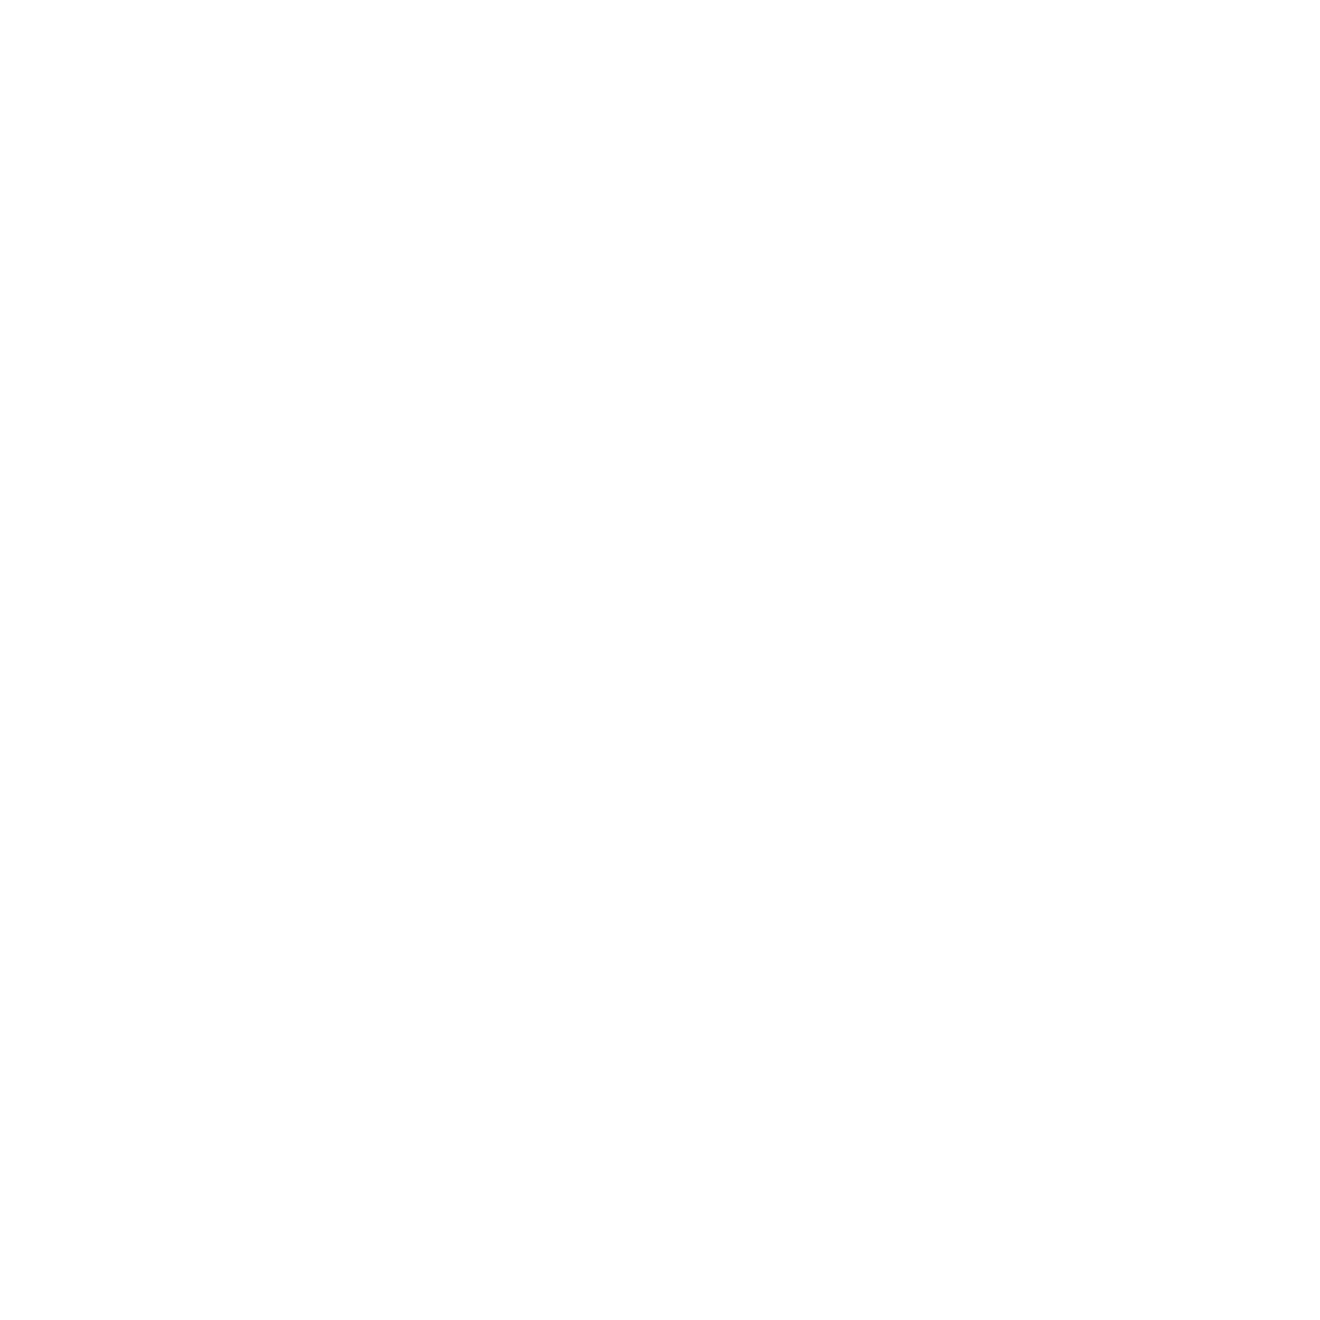

<IPython.core.display.Javascript object>


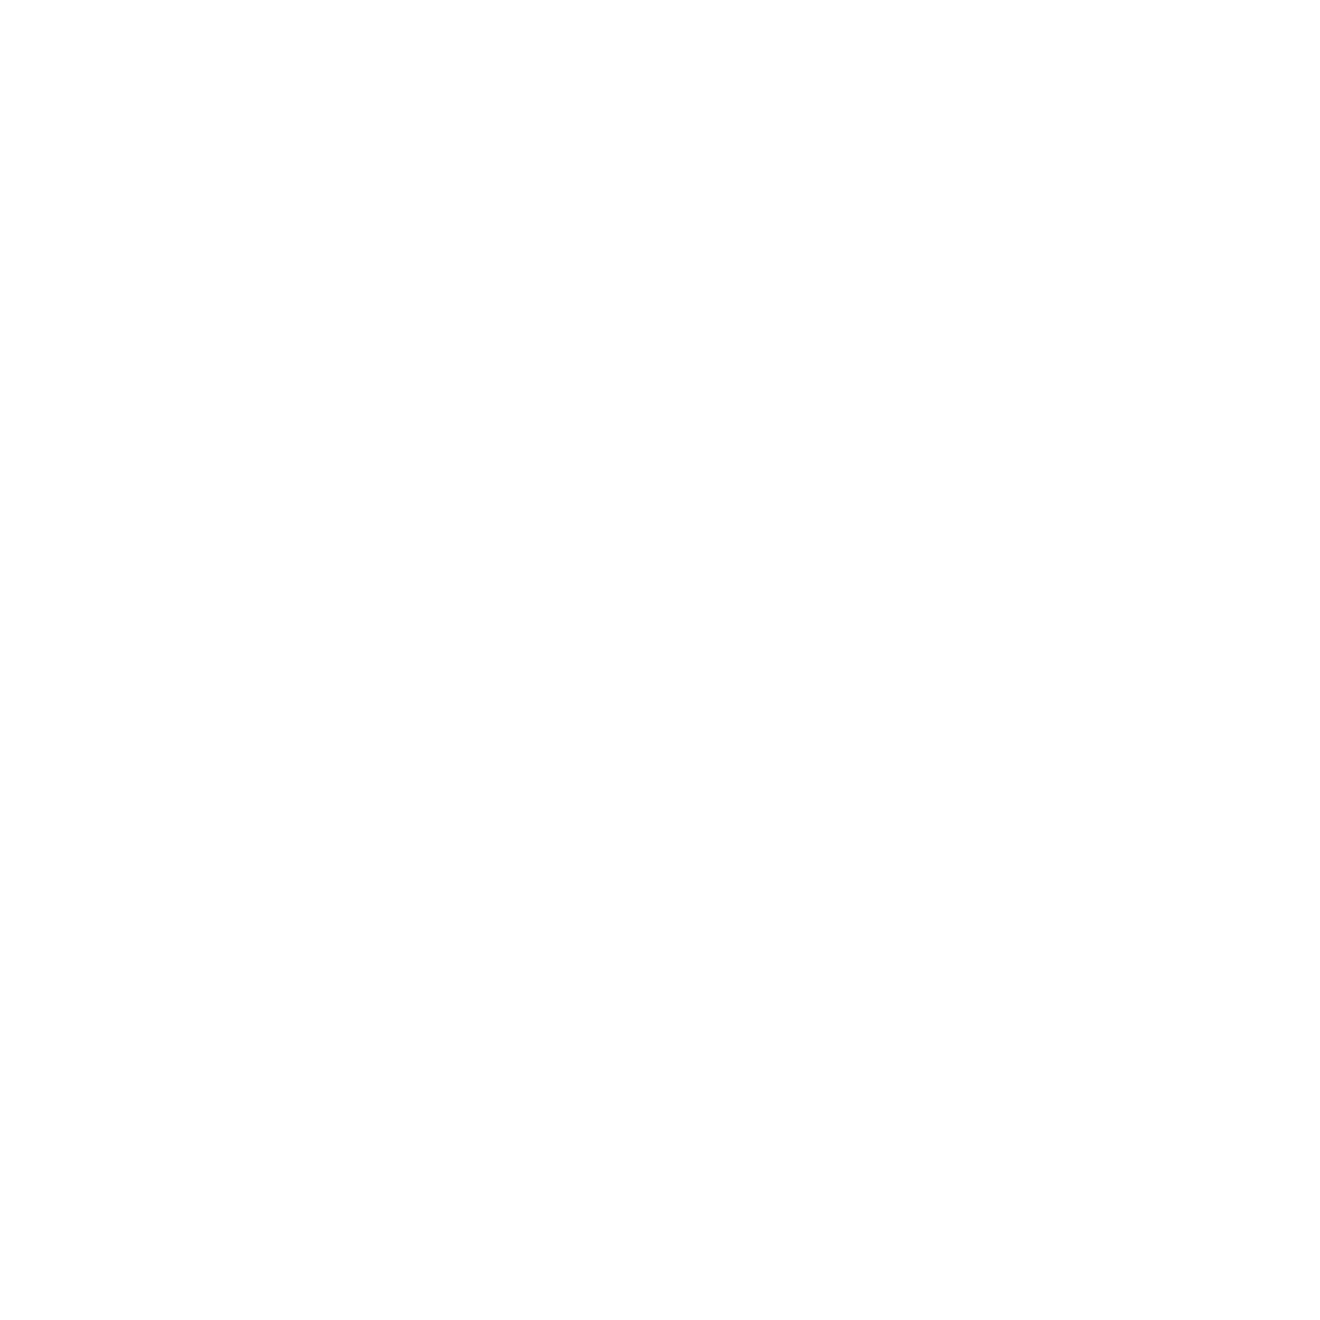

<IPython.core.display.Javascript object>


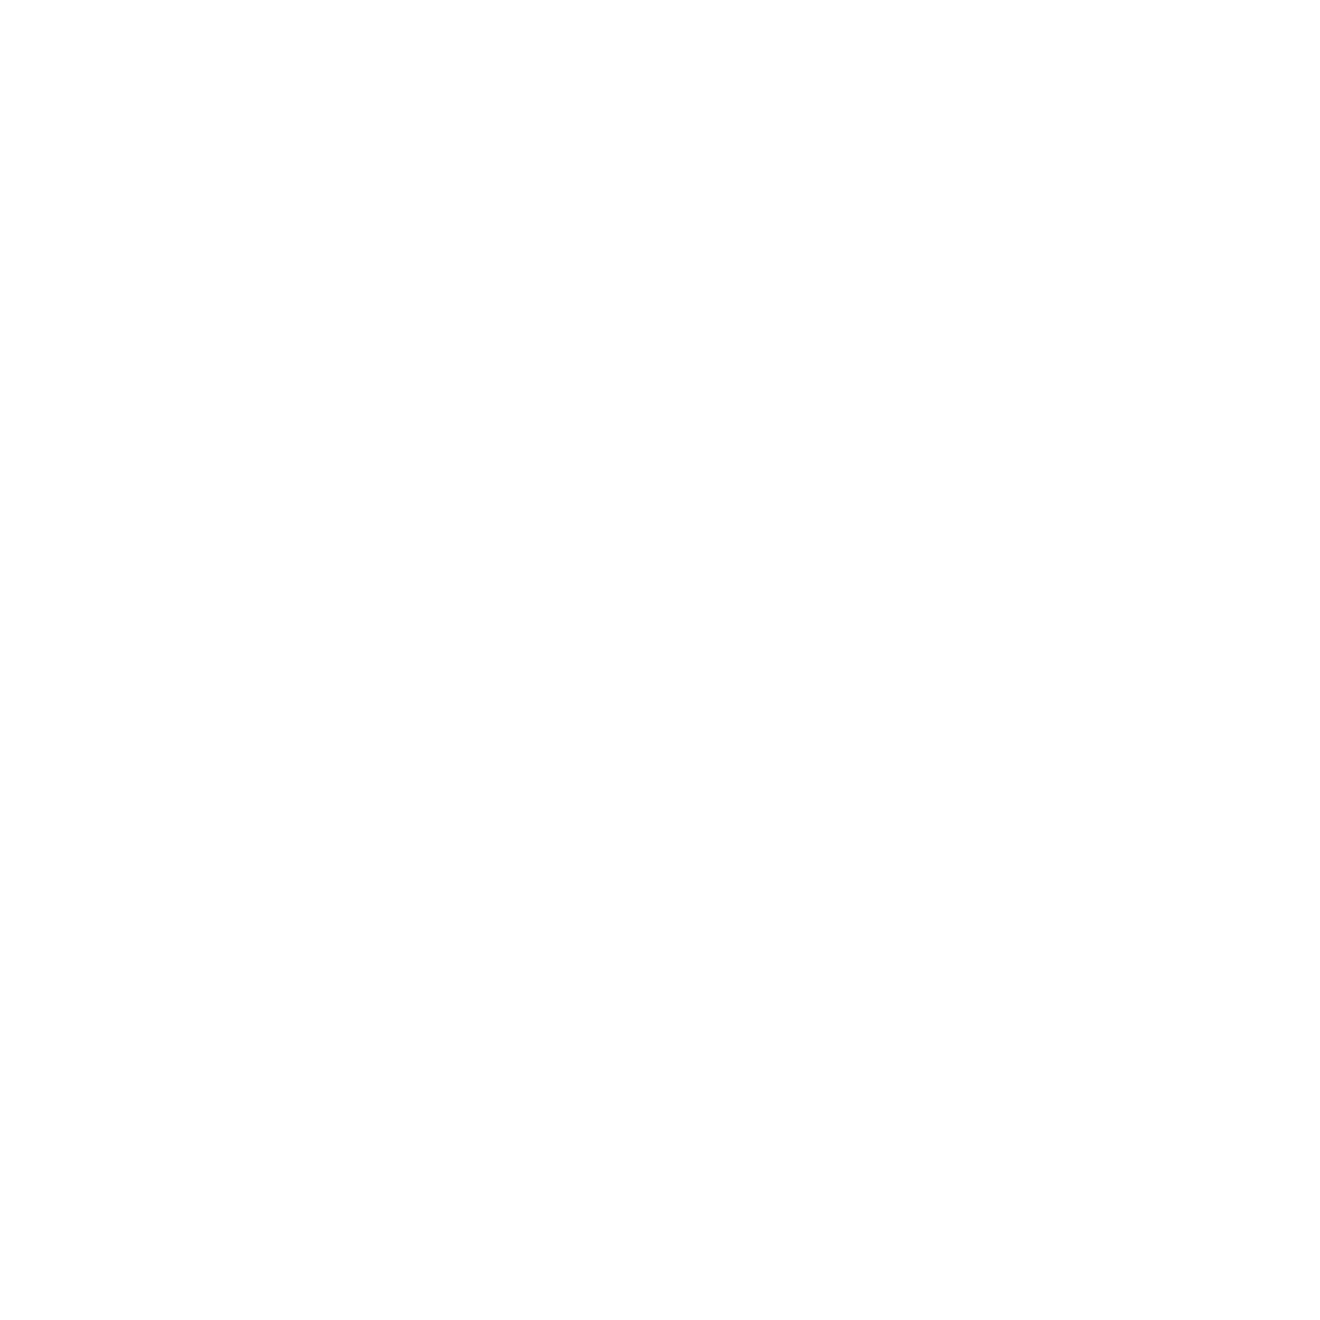

<IPython.core.display.Javascript object>


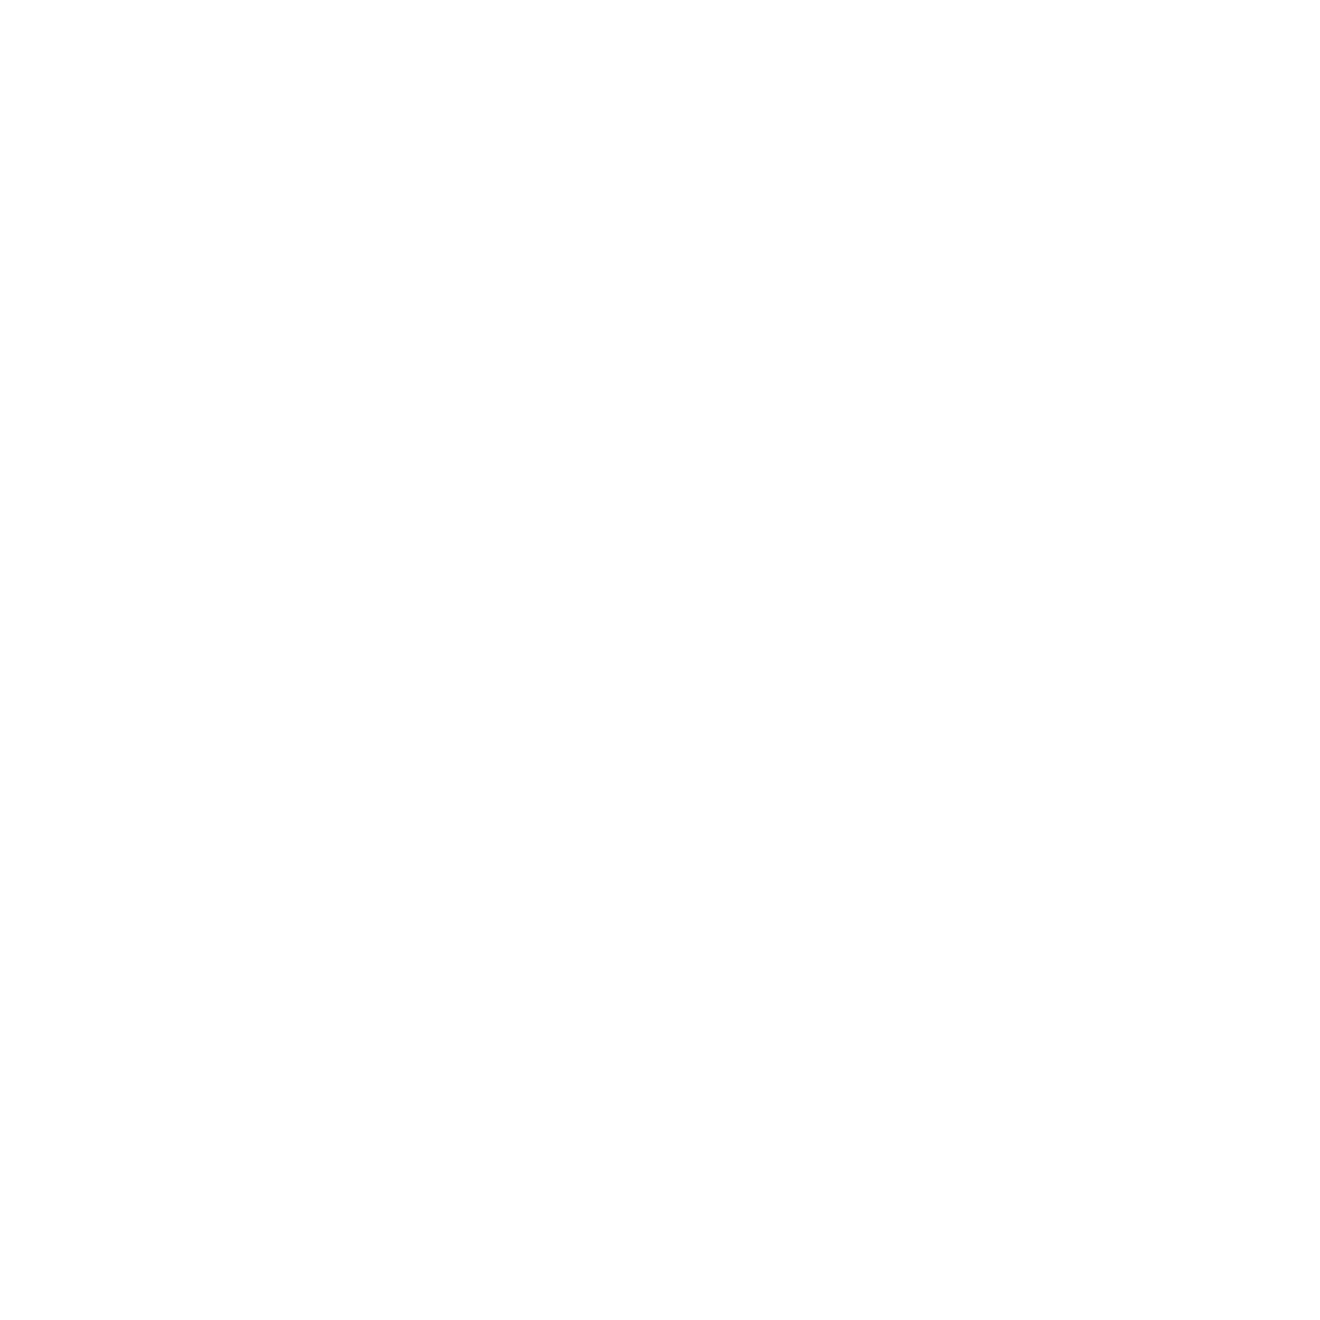

/Users/dan/Documents/code/adesnal/opto_utils.py:243: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(data,0)[isize,icontrast,:,ilight],c=colorset[ilight])#,c=colorsets[optotype])
/Users/dan/Documents/code/adesnal/opto_utils.py:244: RuntimeWarning: Mean of empty slice
  plt.ylim((0,np.nanmean(data,0).max()))


ValueError: Axis limits cannot be NaN or Inf

In [259]:
import opto_utils
reload(opto_utils)
ucontrast = [str(c) for c in np.array((0,6,12,25,50,100))]
usize = [str(s) for s in (5,8,13,22,36,60)]
nsize,ncontrast = 6,6
celltypes = ['L4 PC', 'L2/3 PC', 'L2/3 SST', 'L2/3 VIP', 'L2/3 PV']
ntypes = len(celltypes)
# aligntypes = ['RF distance <10$^o$']
saveas = ['figures/five_cell_types_aligned_2d.jpg','figures/five_cell_types_misaligned_2d.jpg']
mag = 3
for ialign in range(2):
#     plt.figure(figsize=(4*mag,mag))
    for iicelltype,icelltype in enumerate([0,1,4,2,3]):
#         plt.subplot(1,ntypes,iicelltype+1)
        if not rs[icelltype][ialign] is None:
            to_show = rs_denoise[icelltype][ialign].reshape((-1,nsize,ncontrast,8))
            opto_utils.plot_size_contrast_ori_light(to_show)
#             sca.show_size_contrast(to_show,flipud=True,usize=[5,8,13,22,36,60],vmin=0,vmax=np.nanmax(to_show))
        plt.title(celltypes[icelltype])
    plt.tight_layout()
#     plt.savefig(saveas[ialign],dpi=300)

In [17]:
# mag = 2.5
# colors = ['g','k','C1','m','b']
# plt.figure(figsize=(mag*len(usize),mag))
# for icelltype in [1,4]:
#     mn,lb,ub = ut.bootstrap(Rs[icelltype][0].reshape((-1,len(usize),len(ucontrast))),fn=np.nanmean,axis=0,pct=(50,2.5,97.5))
#     for isize in range(len(usize)):
#         plt.subplot(1,len(usize),isize+1)
#         plt.errorbar([int(u) for u in ucontrast],mn[isize],yerr=(mn[isize]-lb[isize],ub[isize]-mn[isize]),c=colors[icelltype])
#         plt.ylim(0,0.06)
#         plt.tight_layout()
#         plt.title(usize[isize]+'$^o$ size')
#     plt.subplot(1,len(usize),1)
#     plt.xlabel('contrast (%)')
#     plt.ylabel('activity (a.u.)')
#     plt.legend(['L2/3 PC','L2/3 PV'])
# # plt.savefig('figures/pc_pv_contrast_tuning.jpg',dpi=300)

In [17]:
# mag = 2.5
# colors = ['g','k','C1','m','b']
# plt.figure(figsize=(mag*len(usize),mag))
# for icelltype in [2,3]:
#     mn,lb,ub = ut.bootstrap(Rs[icelltype][0].reshape((-1,len(usize),len(ucontrast))),fn=np.nanmean,axis=0,pct=(50,2.5,97.5))
#     for isize in range(len(usize)):
#         plt.subplot(1,len(usize),isize+1)
#         plt.errorbar([int(u) for u in ucontrast],mn[isize],yerr=(mn[isize]-lb[isize],ub[isize]-mn[isize]),c=colors[icelltype])
#         plt.ylim(0,0.1)
#         plt.tight_layout()
#         plt.title(usize[isize]+'$^o$ size')
#     plt.subplot(1,len(usize),1)
#     plt.xlabel('contrast (%)')
#     plt.ylabel('activity (a.u.)')
#     plt.legend(['L2/3 SST','L2/3 VIP'])
# plt.savefig('figures/vip_sst_contrast_tuning.jpg',dpi=300)

In [18]:
# mag = 2.5
# colors = ['g','k','C1','m','b']
# plt.figure(figsize=(mag*len(usize),mag))
# for icelltype in [1,2]:
#     mn,lb,ub = ut.bootstrap(Rs[icelltype][0].reshape((-1,len(usize),len(ucontrast))),fn=np.nanmean,axis=0,pct=(50,2.5,97.5))
#     for isize in range(len(usize)):
#         plt.subplot(1,len(usize),isize+1)
#         plt.errorbar([int(u) for u in ucontrast],mn[isize],yerr=(mn[isize]-lb[isize],ub[isize]-mn[isize]),c=colors[icelltype])
#         plt.ylim(0,0.1)
#         plt.tight_layout()
#         plt.title(usize[isize]+'$^o$ size')
#     plt.subplot(1,len(usize),1)
#     plt.xlabel('contrast (%)')
#     plt.ylabel('activity (a.u.)')
#     plt.legend(['L2/3 SST','L2/3 VIP'])
# # plt.savefig('figures/pc_sst_contrast_tuning.jpg',dpi=300)

In [19]:
plt.close('all')

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# # This import registers the 3D projection, but is otherwise unused.
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# # setup the figure and axes
# mag = 3
# _x = np.arange(6)
# _y = np.arange(6)
# _xx, _yy = np.meshgrid(_x, _y)
# x, y = _xx.ravel(), _yy.ravel()
# saveas = ['figures/five_cell_types_aligned_3d.jpg','figures/five_cell_types_misaligned_3d.jpg']
# for ialign in range(2):
#     fig = plt.figure(figsize=(5*mag, mag))
#     for icelltype in range(5):
#         ax1 = fig.add_subplot(150+icelltype+1, projection='3d')
#         # ax2 = fig.add_subplot(122, projection='3d')

#         top = np.nanmean(Rs[icelltype][ialign],0) #x + y
#         bottom = np.zeros_like(top)
#         width = depth = 1
#         norm = mcolors.Normalize(0, top.max())
#         colors = plt.cm.viridis(norm(top.tolist()))
#         ax1.bar3d(x, y, bottom, width, depth, top, shade=True,color=colors)
#         ax1.view_init(45,225)
#         ax1.set_title(celltypes[icelltype])
#         plt.xlabel('contrast (%)')
#         plt.xticks(np.arange(6),[0,6,12,25,50,100])
#         plt.ylabel('size ($^o$)')
#         plt.yticks(np.arange(6),[5,8,13,22,36,60])


#         # ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
#         # ax2.set_title('Not Shaded')
#     plt.show()
#     plt.tight_layout()
# #     plt.savefig(saveas[ialign],dpi=300)

In [51]:
# reload(sca)
# labels = ['L4 PC','L2/3 PC','L2/3 SST','L2/3 VIP','L2/3 PV']
# def plot_weak_strong(ix,iy,ialign):
#     strong = np.zeros((6,6),dtype='bool')
#     for i in range(6):
#         strong[i] = np.arange(6)>=6-i
#     strong = strong.flatten()
#     ptx = np.nanmean(Rs[ix][ialign],0)
#     pty = np.nanmean(Rs[iy][ialign],0)
#     for these in [~strong,strong]:
#         plt.scatter(ptx[these],pty[these])
#     plt.axis('equal')
#     plt.xlabel('%s activity (a.u.)' %labels[ix])
#     plt.ylabel('%s activity (a.u.)' %labels[iy])
# def scatter_size_contrast_(ix,iy,ialign):
#     ptx = np.nanmean(Rs[ix][ialign],0)
#     pty = np.nanmean(Rs[iy][ialign],0)
#     sca.scatter_size_contrast(np.nanmean(Rs[ix][ialign],0),np.nanmean(Rs[iy][ialign],0),nsize=6,ncontrast=6,equality_line=False,square=False,equate_0=True)
#     plt.xlabel('%s activity (a.u.)' %labels[ix])
#     plt.ylabel('%s activity (a.u.)' %labels[iy])
# mag = 3
# plt.figure(figsize=(mag*3,mag))
# plt.subplot(1,3,1)
# ix = 1
# iy = 2
# ialign = 0
# scatter_size_contrast_(ix,iy,ialign)
# # plot_weak_strong(ix,iy,ialign)
# plt.subplot(1,3,2)
# ix = 1
# iy = 3
# ialign = 0
# scatter_size_contrast_(ix,iy,ialign)
# # plot_weak_strong(ix,iy,ialign)
# plt.subplot(1,3,3)
# ix = 2
# iy = 3
# ialign = 0
# scatter_size_contrast_(ix,iy,ialign)
# plt.tight_layout()
# plt.savefig('figures/pc_sst_vip_projections_colorful_scatter.jpg',dpi=300)

In [63]:
def plot_size_tuning_by_contrast(arr,cs):
    usize = np.array((0,8,13,22,36))
    to_plot = arr.mean(0)
    arr_sz = gen_size_tuning(arr)
    arr_sz = arr_sz/arr_sz.max(1).max(1).max(1)[:,np.newaxis,np.newaxis,np.newaxis]
    lb,ub = ut.bootstrap(arr_sz,np.mean,pct=(2.5,97.5))
    colors = ['k','r']
    lbls = ['light off','light on']
    to_plot = arr_sz.mean(0)
    for ic,c in enumerate(cs):
        plt.subplot(1,len(cs),ic+1)
        for il in range(2):
            ut.plot_bootstrapped_errorbars_hillel(usize,arr_sz[:,:,c:c+1,il].transpose((0,2,1)),markersize=5,colors=colors[il])
        plt.ylim(to_plot.min()-0.1,to_plot.max()+0.1)
        plt.xlabel('size ($^o$)')
    plt.legend(lbls)
    plt.subplot(1,len(cs),1)
    plt.ylabel('event rate / max event rate')
#     plt.tight_layout()

def gen_size_tuning(sc):
    gray = np.tile(sc[:,0].mean(0)[np.newaxis,np.newaxis],(1,sc.shape[1]))
    to_plot = np.concatenate((gray,sc),axis=0)
    return to_plot

In [64]:
# r_to_plot = [None for i in range(3)]
# ialign = 0
# r_to_plot[0] = rs[1][ialign].mean(0)
# r_to_plot[1] = rs[2][ialign].mean(0)
# r_to_plot[2] = rs[3][ialign].mean(0)
# colors = plt.cm.viridis(np.linspace(0,1,6))

# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(1,2,1,projection='3d')
# for i in range(5):
#     ax.plot(r_to_plot[0][i],r_to_plot[1][i],r_to_plot[2][i],c='k')
#     ax.scatter(r_to_plot[0][i],r_to_plot[1][i],r_to_plot[2][i],c=colors,s=15*i+15)#,r_to_plot[2][i],c=colors,s=15*i+10)
# plt.xlabel('PC')
# plt.ylabel('SST')
# ax.set_zlabel('VIP')
# ax = fig.add_subplot(1,2,2,projection='3d')
# for i in range(6):
#     ax.plot(r_to_plot[0][:,i],r_to_plot[1][:,i],r_to_plot[2][:,i],c=colors[i])
#     ax.scatter(r_to_plot[0][:,i],r_to_plot[1][:,i],r_to_plot[2][:,i],c=colors[i],s=15*np.arange(5)+15)
# plt.xlabel('PC')
# plt.ylabel('SST')
# ax.set_zlabel('VIP')
# #plt.tight_layout()
# # plt.savefig('figures/wire_plots_size_contrast.pdf')

In [65]:
# maxdim = 4
# for iroi in range(5):
#     plt.figure(figsize=(maxdim+1,1))
#     plt.subplot(1,maxdim+2,1)
#     plt.imshow(rss[iroi].reshape((nsize,ncontrast)))
#     plt.axis('off')
#     for imaxdim in range(maxdim+1):
#         plt.subplot(1,maxdim+2,imaxdim+2)
#         extra_var = np.array([(u[iroi,idim]*s[idim]*v[idim,:]).reshape((nsize,ncontrast)) for idim in range(imaxdim)])
#         plt.imshow(rss.mean(0).reshape((nsize,ncontrast))+extra_var.sum(0))
#         plt.axis('off')

In [55]:
# plt.figure(figsize=(5,6))
# icelltype = 0
# ialign = 0
# plt.imshow(rs[icelltype][ialign].mean(0))
# rss = Rs[icelltype][ialign].reshape(Rs[icelltype][ialign].shape[0],-1)
# u,s,v = np.linalg.svd(rss-rss.mean(0)[np.newaxis])
# for idim in range(30):
#     plt.subplot(6,5,idim+1)
#     plt.imshow(v[idim].reshape((5,6)))
#     plt.title('%.2f'%s[idim])
# plt.tight_layout()

In [ ]:
# r_to_plot = [None for i in range(3)]
# ialign = 0
# r_to_plot[0] = rs[1][ialign].mean(0)
# r_to_plot[1] = rs[2][ialign].mean(0)
# r_to_plot[2] = rs[3][ialign].mean(0)
# colors = plt.cm.viridis(np.linspace(0,1,6))

# fig = plt.figure(figsize=(6,3))
# ax = fig.add_subplot(1,2,1)#,projection='3d')
# for i in range(5):
#     ax.plot(r_to_plot[0][i],r_to_plot[1][i],c='k')#,r_to_plot[2][i],c='k')
#     ax.scatter(r_to_plot[0][i],r_to_plot[1][i],c=colors,s=15*i+15)#,r_to_plot[2][i],c=colors,s=15*i+10)
# plt.xlabel('PC')
# plt.ylabel('SST')
# ax = fig.add_subplot(1,2,2)#,projection='3d')
# for i in range(6):
#     ax.plot(r_to_plot[0][:,i],r_to_plot[1][:,i],c=colors[i])#,r_to_plot[2][i],c='k')
#     ax.scatter(r_to_plot[0][:,i],r_to_plot[1][:,i],c=colors[i],s=15*np.arange(5)+15)#,r_to_plot[2][i],c=colors,s=15*i+10)
# plt.xlabel('PC')
# plt.ylabel('SST')
# plt.tight_layout()
# #ax.set_zlabel('VIP')

# fig = plt.figure(figsize=(6,3))
# ax = fig.add_subplot(1,2,1)#,projection='3d')
# for i in range(5):
#     ax.plot(r_to_plot[1][i],r_to_plot[2][i],c='k')#,r_to_plot[2][i],c='k')
#     ax.scatter(r_to_plot[1][i],r_to_plot[2][i],c=colors,s=15*i+15)#,r_to_plot[2][i],c=colors,s=15*i+10)
# plt.xlabel('SST')
# plt.ylabel('VIP')
# ax = fig.add_subplot(1,2,2)#,projection='3d')
# for i in range(6):
#     ax.plot(r_to_plot[1][:,i],r_to_plot[2][:,i],c=colors[i])#,r_to_plot[2][i],c='k')
#     ax.scatter(r_to_plot[1][:,i],r_to_plot[2][:,i],c=colors[i],s=15*np.arange(5)+15)#,r_to_plot[2][i],c=colors,s=15*i+10)
# plt.xlabel('SST')
# plt.ylabel('VIP')
# plt.tight_layout()

In [66]:
def set_bound(bd,code,val=0):
    # set bounds to 0 where 0s occur in 'code'
    for iitem in range(len(bd)):
        bd[iitem][code[iitem]] = val

In [67]:
nN = 30
nS = 2
nP = 2
nT = 2
nQ = 4

# code for bounds: 0 , constrained to 0
# +/-1 , constrained to +/-1
# 1.5, constrained to [0,1]
# 2 , constrained to [0,inf)
# -2 , constrained to (-inf,0]
# 3 , unconstrained

Wmx_bounds = 3*np.ones((nP,nQ),dtype=int)
Wmx_bounds[0,1] = 0 # SSTs don't receive L4 input

Wsx_bounds = 3*np.ones(Wmx_bounds.shape) #Wmx_bounds.copy()*0 #np.zeros_like(Wmx_bounds)
Wsx_bounds[0,1] = 0

Wmy_bounds = 3*np.ones((nQ,nQ),dtype=int)
Wmy_bounds[0,:] = 2 # PCs are excitatory
Wmy_bounds[1:,:] = -2 # all the cell types except PCs are inhibitory
Wmy_bounds[1,1] = 0 # SSTs don't inhibit themselves
# Wmy_bounds[3,1] = 0 # PVs are allowed to inhibit SSTs, consistent with Hillel's unpublished results, but not consistent with Pfeffer et al.
Wmy_bounds[2,0] = 0 # VIPs don't inhibit L2/3 PCs. According to Pfeffer et al., only L5 PCs were found to get VIP inhibition

Wsy_bounds = 3*np.ones(Wmy_bounds.shape) #Wmy_bounds.copy()*0 #np.zeros_like(Wmy_bounds)
Wsy_bounds[1,1] = 0
Wsy_bounds[3,1] = 0 

def tile_nS_nT_nN(kernel):
    row = np.concatenate([kernel for idim in range(nS*nT)],axis=0)[np.newaxis,:]
    tiled = np.concatenate([row for irow in range(nN)],axis=0)
    return tiled

s02_bounds = np.ones((nQ,))

k_bounds = 1.5*np.ones((nQ,))

kappa_bounds = 2*np.ones((1,))

T_bounds = 1.5*np.ones((nQ,))

X_bounds = tile_nS_nT_nN(np.array([2,1]))
# X_bounds = np.array([np.array([2,1,2,1])]*nN)

Xp_bounds = tile_nS_nT_nN(np.array([3,1]))
# Xp_bounds = np.array([np.array([3,1,3,1])]*nN)

# Y_bounds = tile_nS_nT_nN(2*np.ones((nQ,)))
# # Y_bounds = 2*np.ones((nN,nT*nS*nQ))

Eta_bounds = tile_nS_nT_nN(3*np.ones((nQ,)))
# Eta_bounds = 3*np.ones((nN,nT*nS*nQ))

Xi_bounds = tile_nS_nT_nN(3*np.ones((nQ,)))
# Xi_bounds = 3*np.ones((nN,nT*nS*nQ))


In [68]:
nT*nS*nQ

16

In [69]:
nT

2

In [70]:
# shapes = [(nP,nQ),(nQ,nQ),(nP,nQ),(nQ,nQ),(nQ,),(nQ,),(1,),(nN,nS*nP),(nN,nS*nQ),(nN,nS*nQ),(nN,nS*nQ)]
shapes = [(nP,nQ),(nQ,nQ),(nP,nQ),(nQ,nQ),(nQ,),(nQ,),(1,),(nQ,),(nN,nT*nS*nP),(nN,nT*nS*nP),(nN,nT*nS*nQ),(nN,nT*nS*nQ)]
#         Wmx,    Wmy,    Wsx,    Wsy,    s02,  k,    kappa,T,   XX,            XXp,          Eta,          Xi

lb = [-np.inf*np.ones(shp) for shp in shapes]
ub = [np.inf*np.ones(shp) for shp in shapes]
bdlist = [Wmx_bounds,Wmy_bounds,Wsx_bounds,Wsy_bounds,s02_bounds,k_bounds,kappa_bounds,T_bounds,X_bounds,Xp_bounds,Eta_bounds,Xi_bounds]

set_bound(lb,[bd==0 for bd in bdlist],val=0)
set_bound(ub,[bd==0 for bd in bdlist],val=0)

set_bound(lb,[bd==2 for bd in bdlist],val=0)

set_bound(ub,[bd==-2 for bd in bdlist],val=0)

set_bound(lb,[bd==1 for bd in bdlist],val=1)
set_bound(ub,[bd==1 for bd in bdlist],val=1)

set_bound(lb,[bd==1.5 for bd in bdlist],val=0)
set_bound(ub,[bd==1.5 for bd in bdlist],val=1)

set_bound(lb,[bd==-1 for bd in bdlist],val=-1)
set_bound(ub,[bd==-1 for bd in bdlist],val=-1)

# for bd in [lb,ub]:
#     for ind in [2,3]:
#         bd[ind][:,1] = 0

# temporary for no variation expt.
# lb[2] = np.zeros_like(lb[2])
# lb[3] = np.zeros_like(lb[3])
# lb[4] = np.ones_like(lb[4])
# lb[5] = np.zeros_like(lb[5])
# ub[2] = np.zeros_like(ub[2])
# ub[3] = np.zeros_like(ub[3])
# ub[4] = np.ones_like(ub[4])
# ub[5] = np.ones_like(ub[5])
# temporary for no variation expt.
lb = np.concatenate([a.flatten() for a in lb])
ub = np.concatenate([b.flatten() for b in ub])
bounds = [(a,b) for a,b in zip(lb,ub)]

In [71]:
ncelltypes = len(Rs)

In [72]:
icelltype

0

In [73]:
for icelltype in range(len(Rs)):
    for ialign in range(len(Rs[icelltype])):
        print(Rs[icelltype][ialign].shape)

(7599, 240)
(2355, 240)
(6220, 240)
(7050, 240)
(294, 240)
(682, 240)
(771, 240)
(714, 240)
(143, 240)
(129, 240)


In [74]:
T_bounds

array([1.5, 1.5, 1.5, 1.5])

In [75]:
icelltype = 0
iS = 0
iT = 0
rss = Rso[icelltype][iS][iT].copy()
u,s,v = np.linalg.svd(rss-np.mean(rss,0)[np.newaxis])

In [76]:
Yhat[0][2]

NameError: name 'Yhat' is not defined

In [77]:
Rso[0][iS][iT].shape

(7599, 30)

In [78]:
nS = 2
ndims = 5
Yhat = [[None for iT in range(nT)] for iS in range(nS)]
Xhat = [[None for iT in range(nT)] for iS in range(nS)]
Ypc_list = [[None for iT in range(nT)] for iS in range(nS)]
Xpc_list = [[None for iT in range(nT)] for iS in range(nS)]
for iS in range(nS):
    mx = np.zeros((ncelltypes,))
    yy = [None for icelltype in range(ncelltypes)]
    for icelltype in range(ncelltypes):
        yy[icelltype] = np.nanmean(Rso[icelltype][iS][0],0)
        mx[icelltype] = np.nanmax(yy[icelltype])
    for iT in range(nT):
        y = [np.nanmean(Rso[icelltype][iS][iT],axis=0)[:,np.newaxis]/mx[icelltype] for icelltype in range(1,ncelltypes)]
        Ypc_list[iS][iT] = [None for icelltype in range(1,ncelltypes)]
        for icelltype in range(1,ncelltypes):
            rss = Rso[icelltype][iS][iT].copy() #.reshape(Rs[icelltype][ialign].shape[0],-1)
    #         print(rss.max())
    #         rss[rss<0] = 0
    #         rss = rss[np.random.randn(rss.shape[0])>0]
            try:
                u,s,v = np.linalg.svd(rss-np.mean(rss,0)[np.newaxis])
                Ypc_list[iS][iT][icelltype-1] = [(s[idim],v[idim]) for idim in range(ndims)]
#                 print('yep on Y')
#                 print(np.min(np.sum(rs[icelltype][iS][iT],axis=1)))
            except:
#                 print('nope on Y')
                print(np.mean(np.isnan(rss)))
                print(np.min(np.sum(rs[icelltype][iS][iT],axis=1)))
        Yhat[iS][iT] = np.concatenate(y,axis=1)
#         x = sim_utils.columnize(Rso[0][iS][iT])[:,np.newaxis]
        icelltype = 0
        x = np.nanmean(Rso[icelltype][iS][iT],0)[:,np.newaxis]/mx[icelltype]
        Xhat[iS][iT] = np.concatenate((x,np.ones_like(x)),axis=1)
        icelltype = 0
        rss = Rso[icelltype][iS][iT].copy()
#         try:
        u,s,v = np.linalg.svd(rss-rss.mean(0)[np.newaxis])
        Xpc_list[iS][iT] = [None for iinput in range(2)]
        Xpc_list[iS][iT][0] = [(s[idim],v[idim]) for idim in range(ndims)]
        Xpc_list[iS][iT][1] = [(0,np.zeros((Xhat[0][0].shape[0],))) for idim in range(ndims)]
#         except:
#             print('nope on X')
#             print(np.mean(np.isnan(rss)))
#             print(np.min(np.sum(Rso[icelltype][iS][iT],axis=1)))
nN,nP = Xhat[0][0].shape
nQ = Yhat[0][0].shape[1]

In [79]:
Rso[icelltype][iS][iT]

array([[1.97319873e-03, 8.14952014e-04, 1.30540835e-03, ...,
        2.65508994e-03, 7.85629208e-04, 7.59877377e-04],
       [8.93095094e-03, 1.78278013e-03, 3.52699872e-03, ...,
        1.30663476e-03, 6.20253700e-03, 2.99983015e-03],
       [2.79663774e-03, 2.35716116e-04, 2.99206238e-04, ...,
        7.47873662e-03, 5.93262645e-03, 3.70436572e-03],
       ...,
       [2.09661509e-03, 1.36598421e-04, 7.00088949e-03, ...,
        1.97577722e-03, 4.44571842e-04, 1.05233814e-08],
       [2.73404043e-03, 5.83338920e-03, 3.33570241e-03, ...,
        1.51731118e-04, 3.59358683e-03, 8.08632817e-04],
       [1.08031196e-03, 1.19218546e-09, 2.83416946e-03, ...,
        1.42731463e-03, 6.97300598e-04, 4.43311242e-04]])

In [175]:
def compute_f_(Eta,Xi,s02):
    return sim_utils.f_miller_troyer(Eta,Xi**2+np.concatenate([s02 for ipixel in range(nS*nT)]))
def compute_fprime_m_(Eta,Xi,s02):
    return sim_utils.fprime_miller_troyer(Eta,Xi**2+np.concatenate([s02 for ipixel in range(nS*nT)]))*Xi
def compute_fprime_s_(Eta,Xi,s02):
    s2 = Xi**2+np.concatenate((s02,s02),axis=0)
    return sim_utils.fprime_s_miller_troyer(Eta,s2)*(Xi/s2)
def sorted_r_eigs(w):
    drW,prW = np.linalg.eig(w)
    srtinds = np.argsort(drW)
    return drW[srtinds],prW[:,srtinds]

In [81]:
#         0.Wmx,  1.Wmy,  2.Wsx,  3.Wsy,  4.s02,5.K,  6.kappa,7.T,8.XX,        9.XXp,        10.Eta,       11.Xi

shapes = [(nP,nQ),(nQ,nQ),(nP,nQ),(nQ,nQ),(nQ,),(nQ,),(1,),(nQ,),(nN,nT*nS*nP),(nN,nT*nS*nP),(nN,nT*nS*nQ),(nN,nT*nS*nQ)]


In [82]:
import calnet.fitting_spatial_feature
import sim_utils

In [125]:
len(Yhat[0])

2

In [126]:
from importlib import reload
reload(sim_utils)
reload(calnet.fitting_spatial_feature)
# W0list = [np.ones(shp) for shp in shapes]
wt_dict = {}
wt_dict['X'] = int(1e2)
wt_dict['Y'] = int(1e2)
wt_dict['Eta'] = 10 # 10
wt_dict['Xi'] = 10
wt_dict['stims'] = np.ones((30,1)) #(np.arange(30)/30)[:,np.newaxis]**1 #
wt_dict['barrier'] = 0. #30.0 #0.1
ntries = 1
nhyper = 1
dt = 1e-1
niter = int(np.round(50/dt)) #int(1e4)
perturbation_size = 5e-2
# learning_rate = 1e-4 # 1e-5 #np.linspace(3e-4,1e-3,niter+1) # 1e-5
l2_penalty = 0.1
Wt = [[None for itry in range(ntries)] for ihyper in range(nhyper)]
loss = np.zeros((nhyper,ntries))
is_neg = np.array([b[1] for b in bounds])==0
counter = 0
negatize = [np.zeros(shp,dtype='bool') for shp in shapes]
for ishp,shp in enumerate(shapes):
    nel = np.prod(shp)
    negatize[ishp][:][is_neg[counter:counter+nel].reshape(shp)] = True
    counter = counter + nel
for ihyper in range(nhyper):
    for itry in range(ntries):
        print((ihyper,itry))
        W0list = [0.01*(ihyper+1)*np.random.rand(*shp) for shp in shapes]
        counter = 0
        for ishp,shp in enumerate(shapes):
            W0list[ishp][negatize[ishp]] = -W0list[ishp][negatize[ishp]]
        W0list[5] = np.ones(shapes[5]) # K
        W0list[6] = np.ones(shapes[6]) # kappa
        W0list[7] = np.ones(shapes[7]) # T
        W0list[8] = np.concatenate(Xhat,axis=1) #XX
        W0list[9] = np.zeros_like(W0list[8]) #XXp
        W0list[10] = np.zeros(shapes[10]) #Eta
        W0list[11] = np.zeros(shapes[11]) #Xi
        #[Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi]
#         W0list = Wstar_dict['as_list'].copy()
#         W0list[1] = W0list[1] + 0.05*np.random.randn(*W0list[1].shape)
#         W0list[1][1,0] = -1.5
#         W0list[1][3,0] = -1.5
#         W0list[1][0,0] = 1.5
        # wt_dict['Xi'] = 10
        # wt_dict['Eta'] = 10
        Wt[ihyper][itry],loss[ihyper][itry],gr,hess,result = calnet.fitting_spatial_feature.fit_W_sim(Xhat,Xpc_list,\
            Yhat,Ypc_list,pop_rate_fn=sim_utils.f_miller_troyer,pop_deriv_fn=sim_utils.fprime_miller_troyer,\
            neuron_rate_fn=sim_utils.evaluate_f_mt,W0list=W0list.copy(),bounds=bounds,niter=niter,wt_dict=wt_dict,\
            l2_penalty=l2_penalty,compute_hessian=True,dt=dt,perturbation_size=perturbation_size)
#         Wt[ihyper][itry] = [w[-1] for w in Wt_temp]
#         loss[ihyper,itry] = loss_temp[-1]

(0, 0)
cost: 3371.451266815753
cost: Autograd ArrayBox with value 3371.4512668157454
cost: 59147.71640265849
cost: Autograd ArrayBox with value 59147.716402658465
cost: 3330.111055486994
cost: Autograd ArrayBox with value 3330.1110554870015
cost: 3367.527941997471
cost: Autograd ArrayBox with value 3367.5279419974645
cost: 3322.0954993967807
cost: Autograd ArrayBox with value 3322.0954993967816
cost: 3317.821315510275
cost: Autograd ArrayBox with value 3317.8213155102726
cost: 3302.1533886240277
cost: Autograd ArrayBox with value 3302.1533886240295
cost: 3288.971301423867
cost: Autograd ArrayBox with value 3288.971301423861
cost: 3259.5416024776923
cost: Autograd ArrayBox with value 3259.541602477687
cost: 3207.3685444829102
cost: Autograd ArrayBox with value 3207.368544482925
cost: 3139.7351390310555
cost: Autograd ArrayBox with value 3139.735139031062
cost: 3064.4063621254822
cost: Autograd ArrayBox with value 3064.4063621254813
cost: 2697.728471845463
cost: Autograd ArrayBox with va

cost: Autograd ArrayBox with value 297.4547292056279
cost: 297.278691836751
cost: Autograd ArrayBox with value 297.26377774111523
cost: 296.86168405147663
cost: Autograd ArrayBox with value 296.8905406469979
cost: 296.6925141729529
cost: Autograd ArrayBox with value 296.6751845032512
cost: 296.4515716937568
cost: Autograd ArrayBox with value 296.4599589647957
cost: 295.7721440686122
cost: Autograd ArrayBox with value 295.7647835703307
cost: 295.0626520069417
cost: Autograd ArrayBox with value 295.02851498510813
cost: 294.08350518437106
cost: Autograd ArrayBox with value 294.05327082695567
cost: 293.47177872840604
cost: Autograd ArrayBox with value 293.6258668444152
cost: 293.25627163826124
cost: Autograd ArrayBox with value 293.2423239951581
cost: 292.83467340152276
cost: Autograd ArrayBox with value 292.8626748585142
cost: 292.58038883494925
cost: Autograd ArrayBox with value 292.61449691896763
cost: 292.2902269329822
cost: Autograd ArrayBox with value 292.27923899089717
cost: 292.025

In [222]:
def parse_W(W):
    Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi = W
    return Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi
def parse_w(w):
    # Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,YY,Eta,Xi
    shapes = [(nP,nQ),(nQ,nQ),(nP,nQ),(nQ,nQ),(nQ,),(nQ,),(1,),(nQ,),(nN,nT*nS*nP),(nN,nT*nS*nP),(nN,nT*nS*nQ),(nN,nT*nS*nQ)]
    Ws = parse_thing(w,shapes)
    return Ws
def parse_thing(V,shapes):
    for shape in shapes:
        if type(shape) is int:
            shape = (shape,)
    sizes = [np.prod(shape) for shape in shapes]
    sofar = 0
    outputs = []
    for size,shape in zip(sizes,shapes):
        if size > 1:
            new_element = V[sofar:sofar+size].reshape(shape)
        else:
            new_element = V[sofar] # if just a float
        outputs.append(new_element)
        sofar = sofar + size
    return outputs
def unparse_W(*Ws):
    return np.concatenate([ww.flatten() for ww in Ws])

In [217]:
Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi = parse_W(Wt[0][0])

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


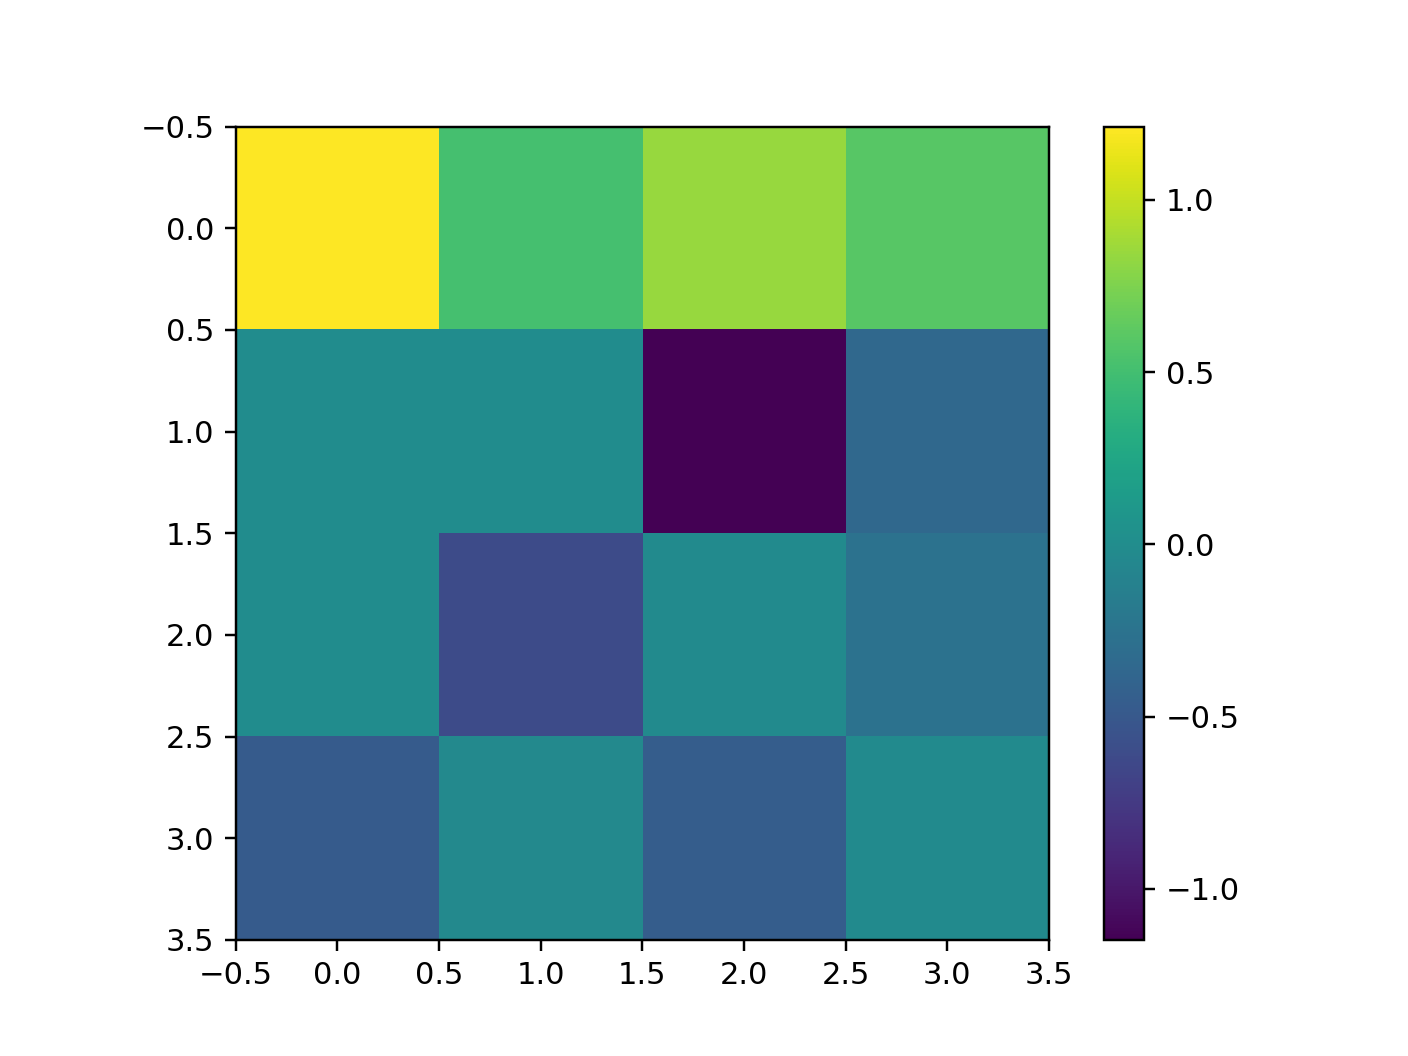

In [218]:
plt.figure()
plt.imshow(Wmy)
plt.colorbar()

In [97]:
drH,prH = np.linalg.eig(hess)

In [99]:
drH.shape

(1501,)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


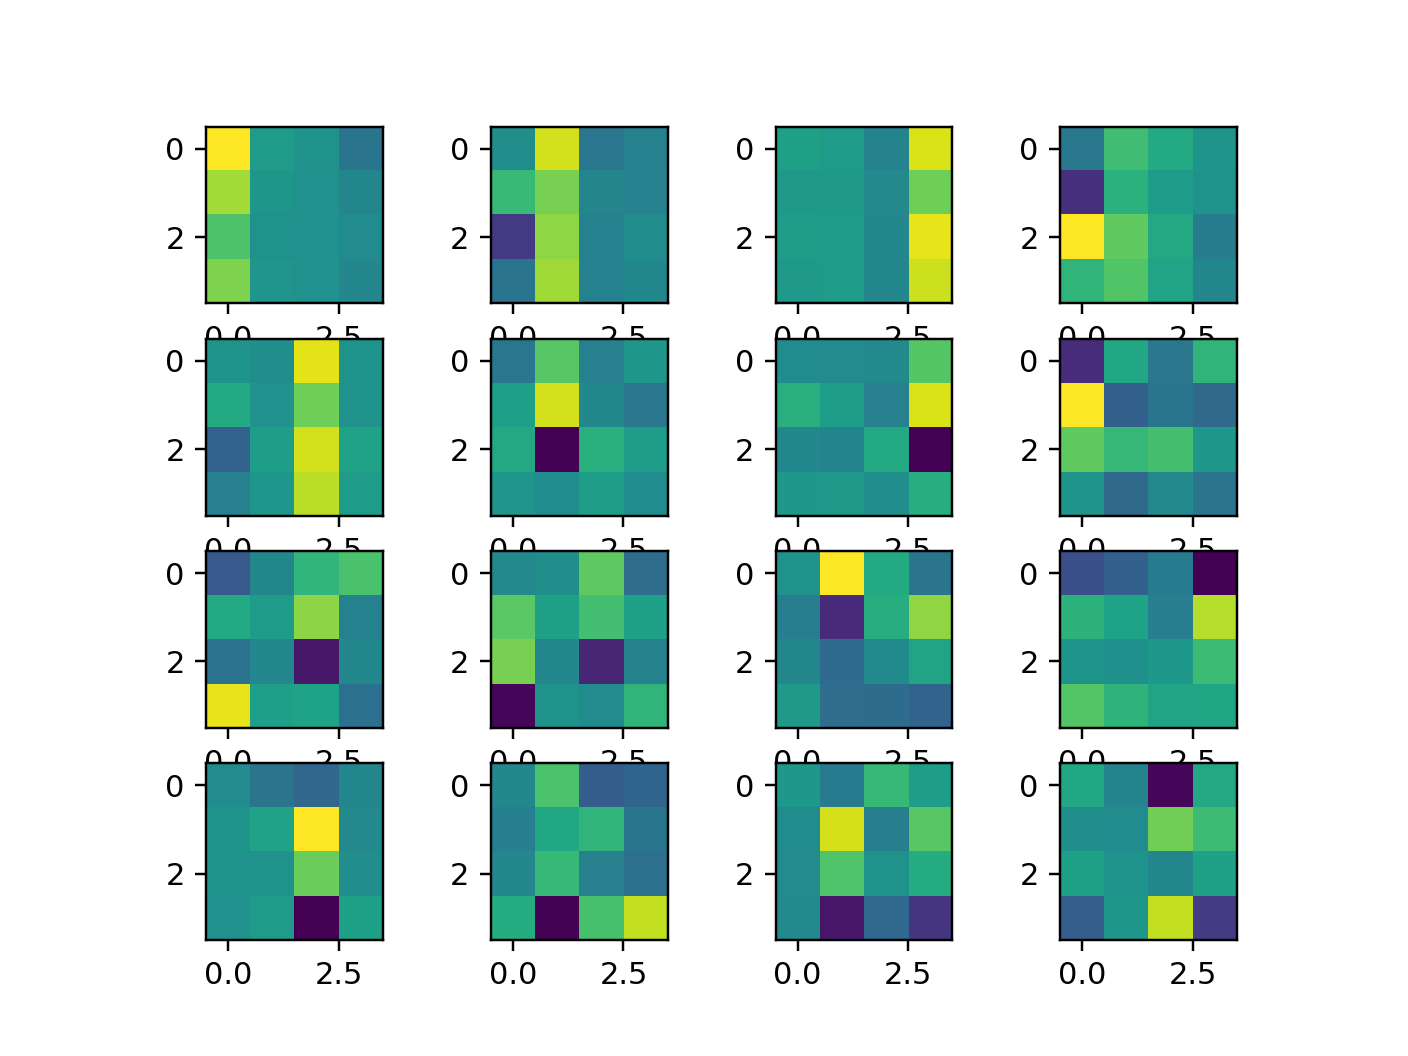

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


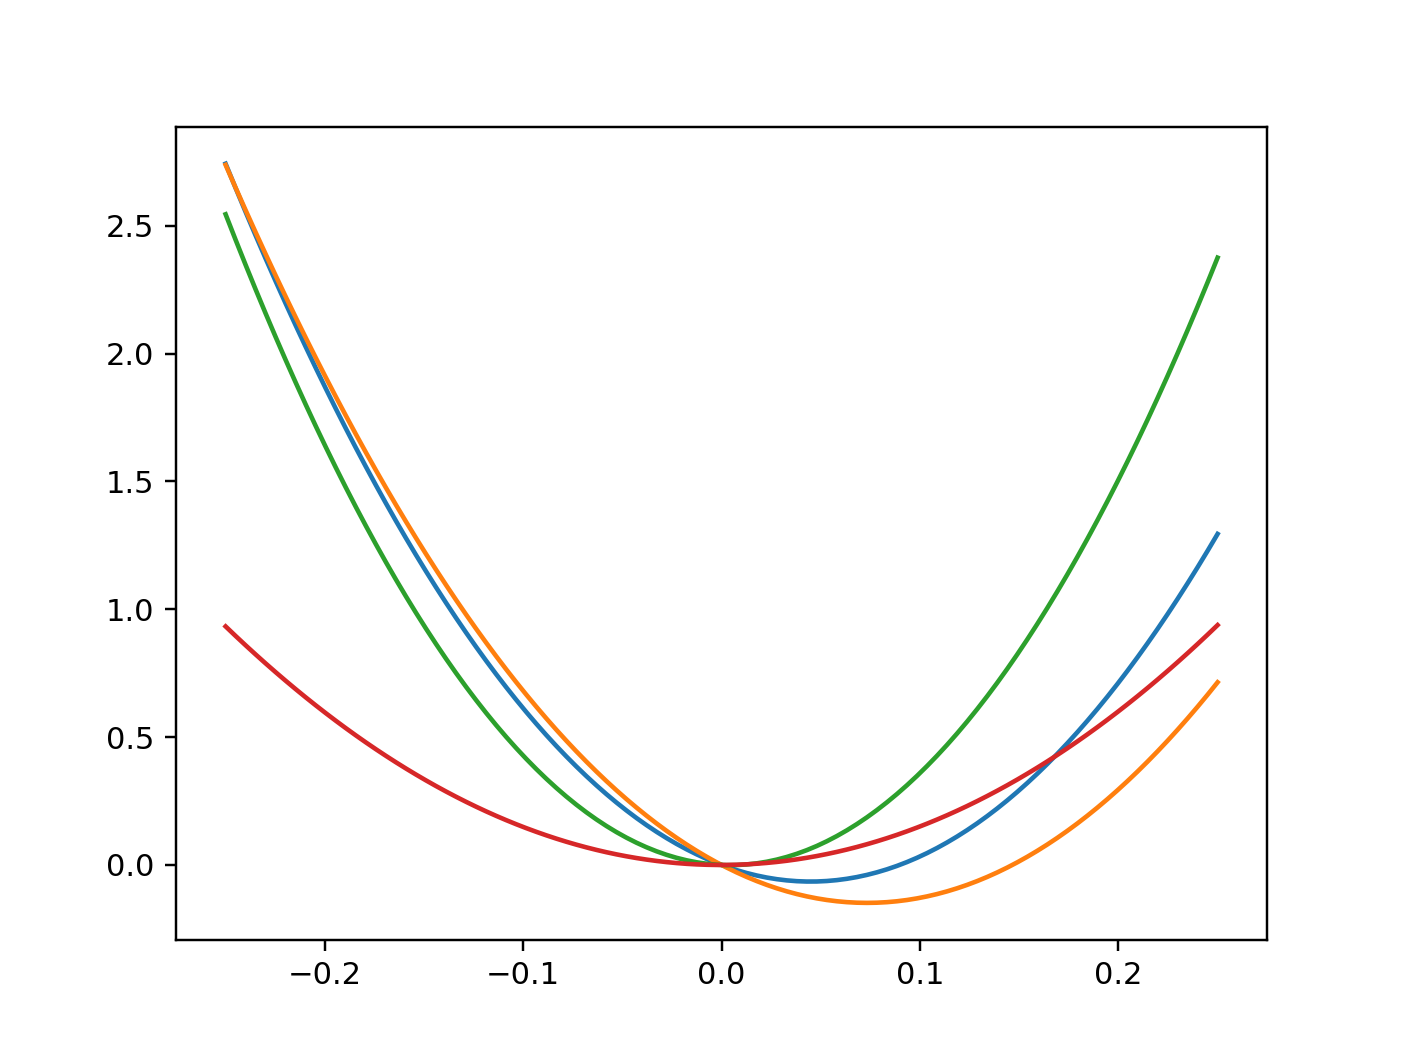

In [224]:
# nH = drH.shape[0]
hessWy = np.zeros((nQ**2,nQ**2))
blankWlist = parse_w(np.zeros(nH,))
blankWlist[1][:] = 1
allhot = unparse_W(*blankWlist)
Wy_entries = slice(np.where(allhot)[0][0],np.where(allhot)[0][-1]+1)
hessWy = hess[Wy_entries,Wy_entries]
gradWy = gr[Wy_entries]
drH,prH = np.linalg.eig(hessWy)
plt.figure()
for iieig,ieig in enumerate(np.arange(16)):
    plt.subplot(4,4,iieig+1)
    plt.imshow(prH[:,ieig].reshape((nQ,nQ))*np.sign(prH[:,ieig].mean()),vmin=-0.6,vmax=0.6)
plt.figure()
for ieig in np.arange(-1,-5,-1):
    x = np.linspace(-0.25,0.25,100)
    y = x*(gradWy @ prH[:,ieig]) + 0.5*x**2*(prH[:,ieig] @ hessWy @ prH[:,ieig])
    plt.plot(x,y)

In [211]:
hessW = np.zeros((nP*nQ+nQ**2,nP*nQ+nQ**2))
blankWlist = parse_W(np.zeros(nH,))
blankWlist[0][:] = 1
blankWlist[1][:] = 1
allhot = unparse_W(*blankWlist)
W_entries = slice(np.where(allhot)[0][0],np.where(allhot)[0][-1]+1)
hessW = hess[W_entries,W_entries]
gradW = gr[W_entries]
drHW,prHW = np.linalg.eig(hessW)

plt.figure()
for iieig,ieig in enumerate(np.arange(nP*nQ+nQ**2)):
    plt.subplot(6,4,iieig+1)
    these_wts = np.real(prHW[:,ieig])
    these_wx = these_wts[:nP*nQ].reshape((nP,nQ))
    these_wy = these_wts[nP*nQ:].reshape((nQ,nQ))
    these_w = np.concatenate((these_wy,these_wx),axis=0)
    plt.imshow(these_w*np.sign(these_w.mean()),vmin=-0.6,vmax=0.6)
plt.figure()
for ieig in np.arange(-1,-5,-1):
    x = np.linspace(-0.5,0.5,100)
    y = x*(gradW @ prHW[:,ieig]) + 0.5*x**2*(prHW[:,ieig] @ hessW @ prHW[:,ieig])
    plt.plot(x,y)

ValueError: too many values to unpack (expected 12)

<IPython.core.display.Javascript object>


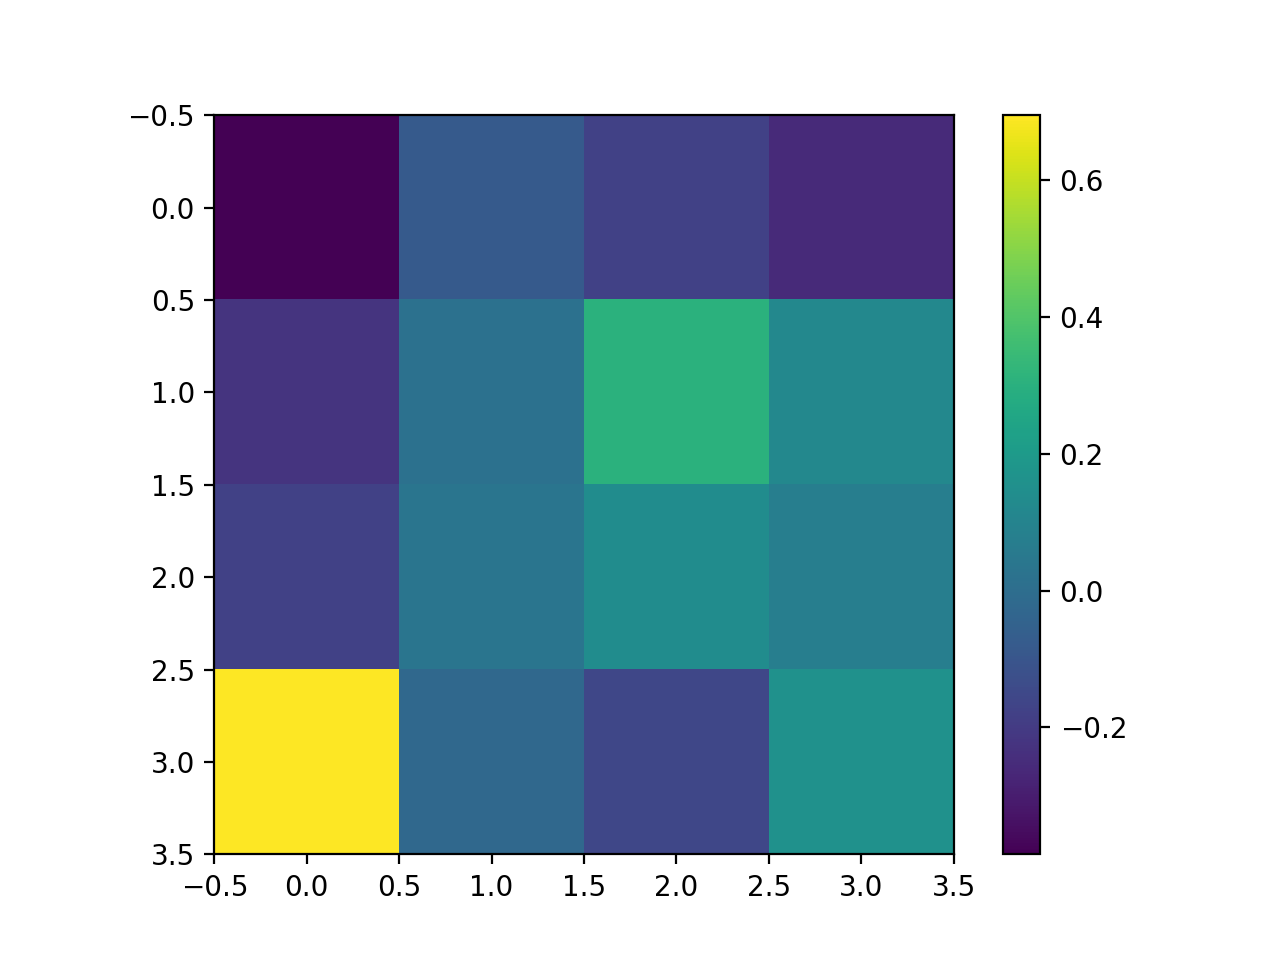

In [2079]:
plt.figure()
plt.imshow(prH[:,-3].reshape((nQ,nQ)))
plt.colorbar()

<IPython.core.display.Javascript object>


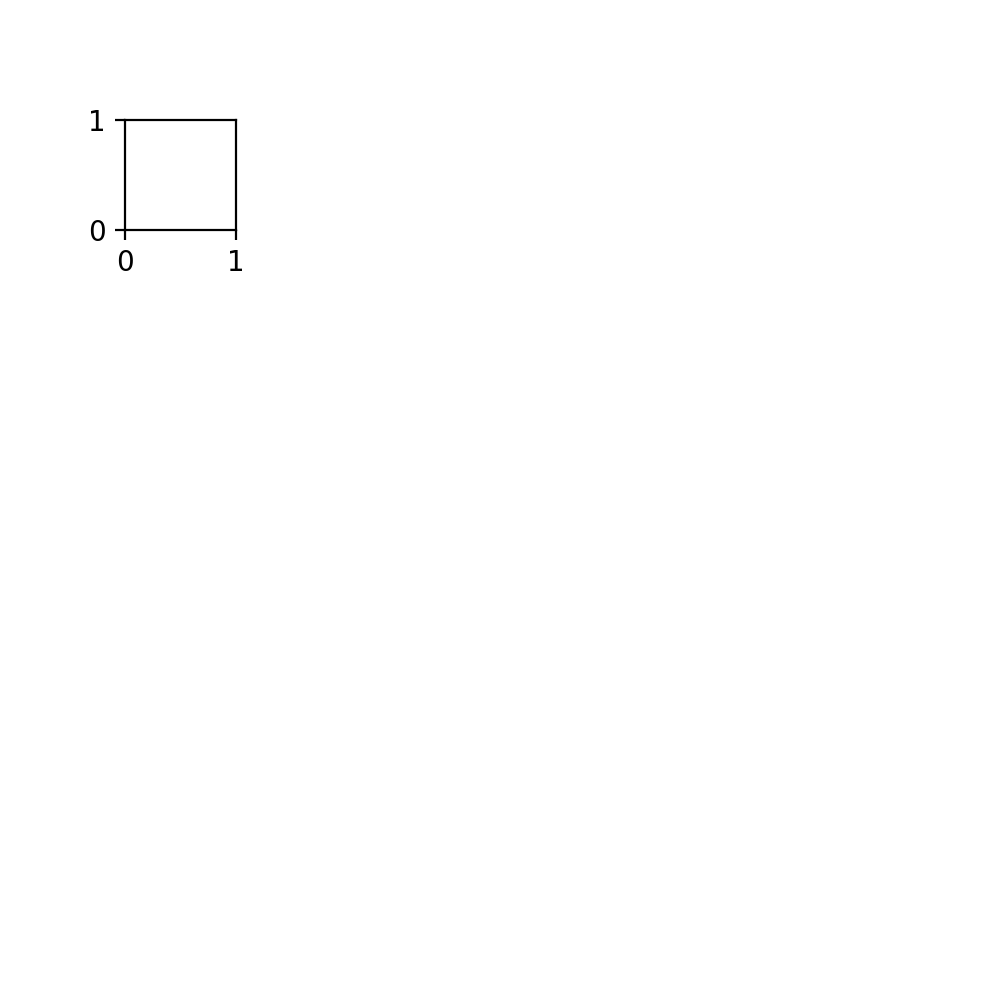

ValueError: cannot reshape array of size 8 into shape (4,4)

In [2080]:
mag = 1
plt.figure(figsize=(5*mag,5*mag))
for iidim,idim in enumerate(np.where(wheavy)[0]):
    plt.subplot(6,6,iidim+1)
    eiglist = parse_W(prH[:,idim])
    plt.imshow(np.real(eiglist[1])*np.sign(np.real(eiglist[1].sum())),vmin=-0.5,vmax=0.5)
    plt.axis('off')
    
mag = 1
plt.figure(figsize=(5*mag,5*mag))
for iidim,idim in enumerate(np.where(wheavy)[0]):
    plt.subplot(6,6,iidim+1)
    eiglist = parse_W(prH[:,idim])
    plt.imshow(np.real(eiglist[3])*np.sign(np.real(eiglist[3].sum())),vmin=-0.5,vmax=0.5)
    plt.axis('off')
#     plt.colorbar()
# plt.tight_layout()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


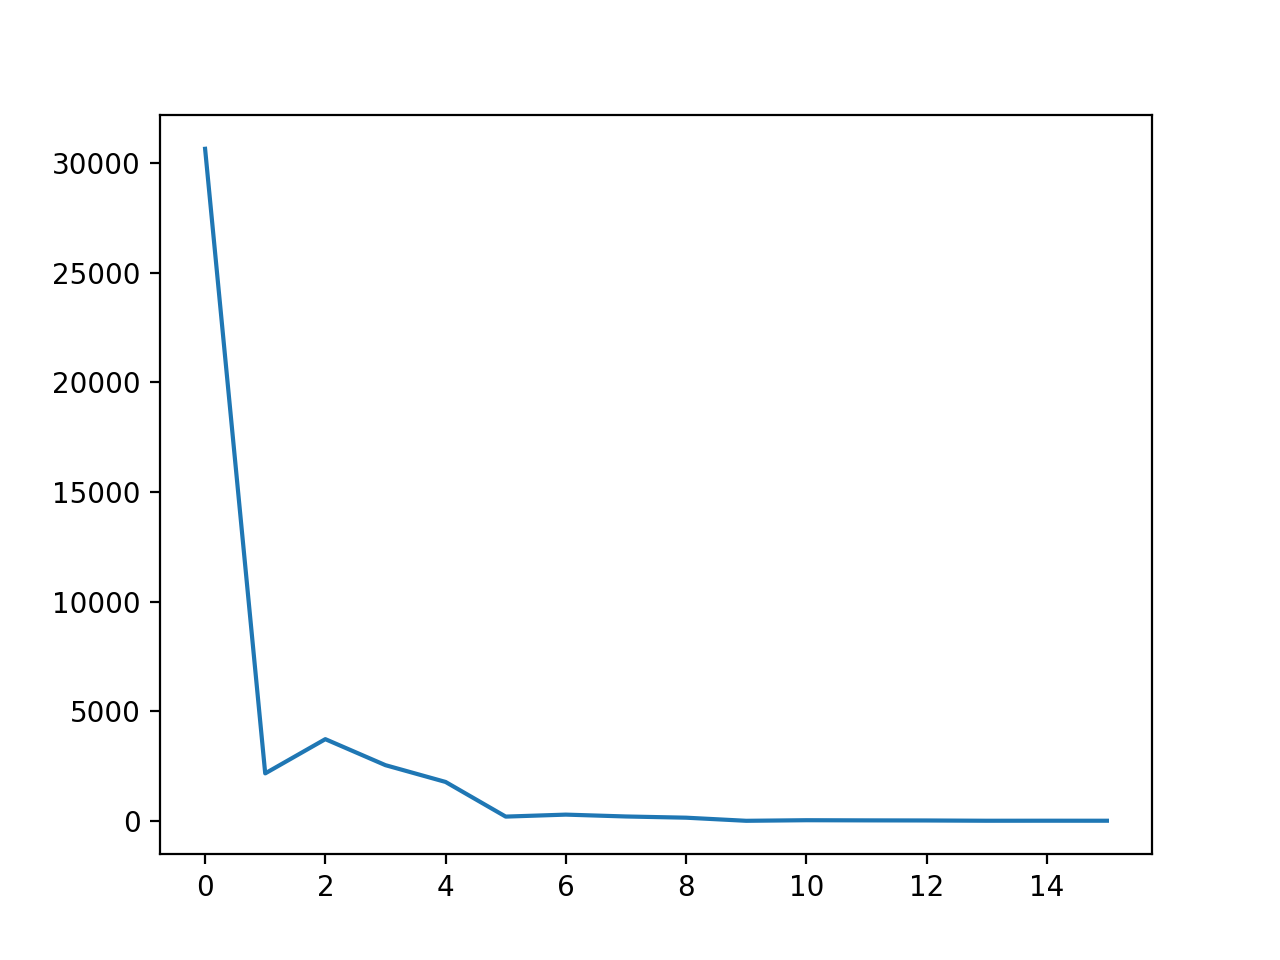

In [1796]:
plt.figure()
plt.plot(np.abs(drH))

In [1247]:
# [Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,YY,Eta,Xi]
# nans: s02, XXp, Eta, Xi

In [1756]:
drW,prW = np.linalg.eig(Wmy-np.eye(Wmy.shape[0]))

In [66]:
len(Wt[0][0])

12

In [105]:
    def gen_Weight(W,K,kappa,T):
        MuT = np.array((1,2,1))
        MuK = np.array((1,kappa))
        WT = circulate(W,T,nT,Mu=MuT)
        KKlist = [K for iT in range(nT)]
        KK = np.concatenate(KKlist,axis=0)
        WW = circulate(WT,KK,nS,Mu=MuK)
        return WW

In [106]:
    def circulate(V,M,nZ,Mu=None):
        Vpartlist = [V*(M[np.newaxis,:]**np.abs(iZ)) for iZ in range(-nZ+1,nZ)]
        if Mu is None:
            Mu = np.ones((nZ,))
        #VVlist = [np.concatenate([m*v for m,v in zip(Mu,Vpartlist[nZ-iZ-1:2*nZ-iZ-1])],axis=1) for iZ in range(nZ)]
        VVlist = [np.concatenate(Vpartlist[nZ-iZ-1:2*nZ-iZ-1],axis=1) for iZ in range(nZ)]
        #VV = np.concatenate(VVlist,axis=0)
        VV = np.concatenate([m*v for m,v in zip(Mu,VVlist)],axis=0)
        return VV

<IPython.core.display.Javascript object>


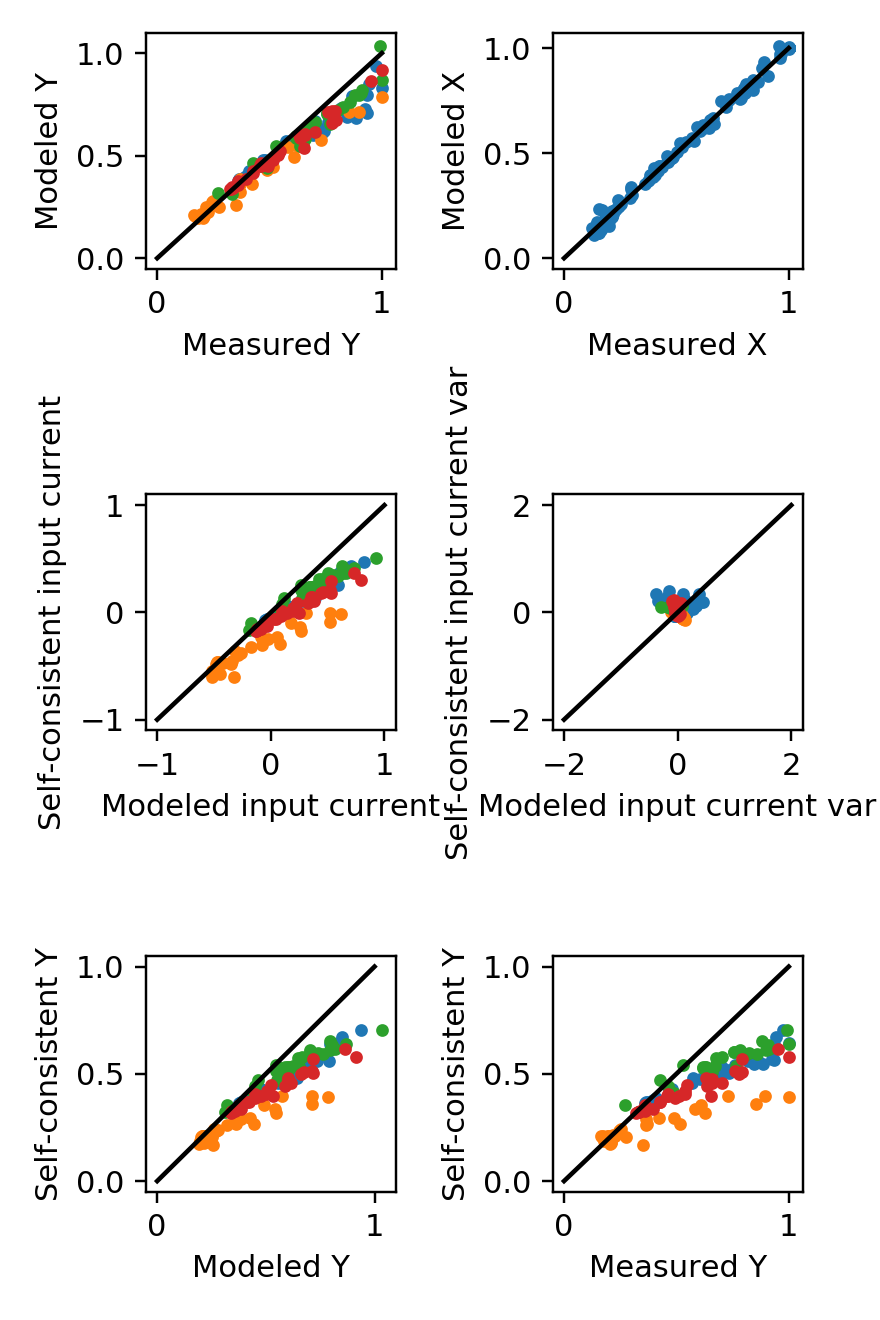

In [160]:
trystars_i,trystars_j = [0],[0]
itry = 0
Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi = Wt[trystars_i[itry]][trystars_j[itry]]
# Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list']
# def gen_Weight(W,K,kappa):
#     WW0 = np.concatenate((W,W*K[np.newaxis,:]),axis=1)
#     WW1 = np.concatenate((W*K[np.newaxis,:]*kappa,W),axis=1)
#     WW = np.concatenate((WW0,WW1),axis=0)
#     return WW

def u_fn(XX,YY,Wx,Wy,k,kappa,T):
    WWx,WWy = [gen_Weight(W,k,kappa,T) for W in [Wx,Wy]]
    return u_fn_WW(XX,YY,WWx,WWy)# XX @ WWx + YY @ WWy

def u_fn_WW(XX,YY,WWx,WWy):
    return XX @ WWx + YY @ WWy

def colorful_scatter(a,b):
    for icelltype in range(ncelltypes-1):
        plt.scatter(a[:,icelltype],b[:,icelltype],s=10)

XXhat = np.concatenate([np.concatenate(x,axis=1) for x in Xhat],axis=1)
YYhat = np.concatenate([np.concatenate(x,axis=1) for x in Yhat],axis=1)
YY = compute_f_(Eta,Xi,s02)
Etastar = u_fn(XX,YY,Wmx,Wmy,k,kappa,T)
Xistar = u_fn(XX,YY,Wsx,Wsy,k,kappa,T)
YYstar = compute_f_(Etastar,Xistar,s02)
nrows = 3
ncols = 2
plt.figure(figsize=(2*ncols,2*nrows))
plt.subplot(nrows,ncols,1)
colorful_scatter(YYhat,YY)
plt.xlabel('Measured Y')
plt.ylabel('Modeled Y')
plt.plot((0,1),(0,1),c='k')
plt.subplot(nrows,ncols,2)
plt.scatter(XXhat,XX,s=10)
plt.xlabel('Measured X')
plt.ylabel('Modeled X')
plt.plot((0,1),(0,1),c='k')
plt.subplot(nrows,ncols,3)
colorful_scatter(Eta,Etastar)
plt.xlabel('Modeled input current')
plt.ylabel('Self-consistent input current')
plt.plot((-1,1),(-1,1),c='k')
plt.subplot(nrows,ncols,4)
colorful_scatter(Xi,Xistar)
plt.xlabel('Modeled input current var')
plt.ylabel('Self-consistent input current var')
plt.plot((-2,2),(-2,2),c='k')
plt.subplot(nrows,ncols,5)
colorful_scatter(YY,YYstar)
plt.xlabel('Modeled Y')
plt.ylabel('Self-consistent Y')
plt.plot((0,1),(0,1),c='k')
plt.subplot(nrows,ncols,6)
colorful_scatter(YYhat,YYstar)
plt.xlabel('Measured Y')
plt.ylabel('Self-consistent Y')
plt.plot((0,1),(0,1),c='k')
plt.tight_layout()
plt.savefig('figures/model_fit_quality.jpg')

In [131]:
trystars_i = (0,)
trystars_j = (0,)
itry = 0
Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi = Wt[trystars_i[itry]][trystars_j[itry]]
labels = ['Wmx','Wmy','Wsx','Wsy','s02','k','kappa','T','XX','XXp','Eta','Xi']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wt[trystars_i[itry]][trystars_j[itry]][i]
Wstar_dict['as_list'] = [Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi]
np.save('weights_200607.npy',Wstar_dict)

<IPython.core.display.Javascript object>


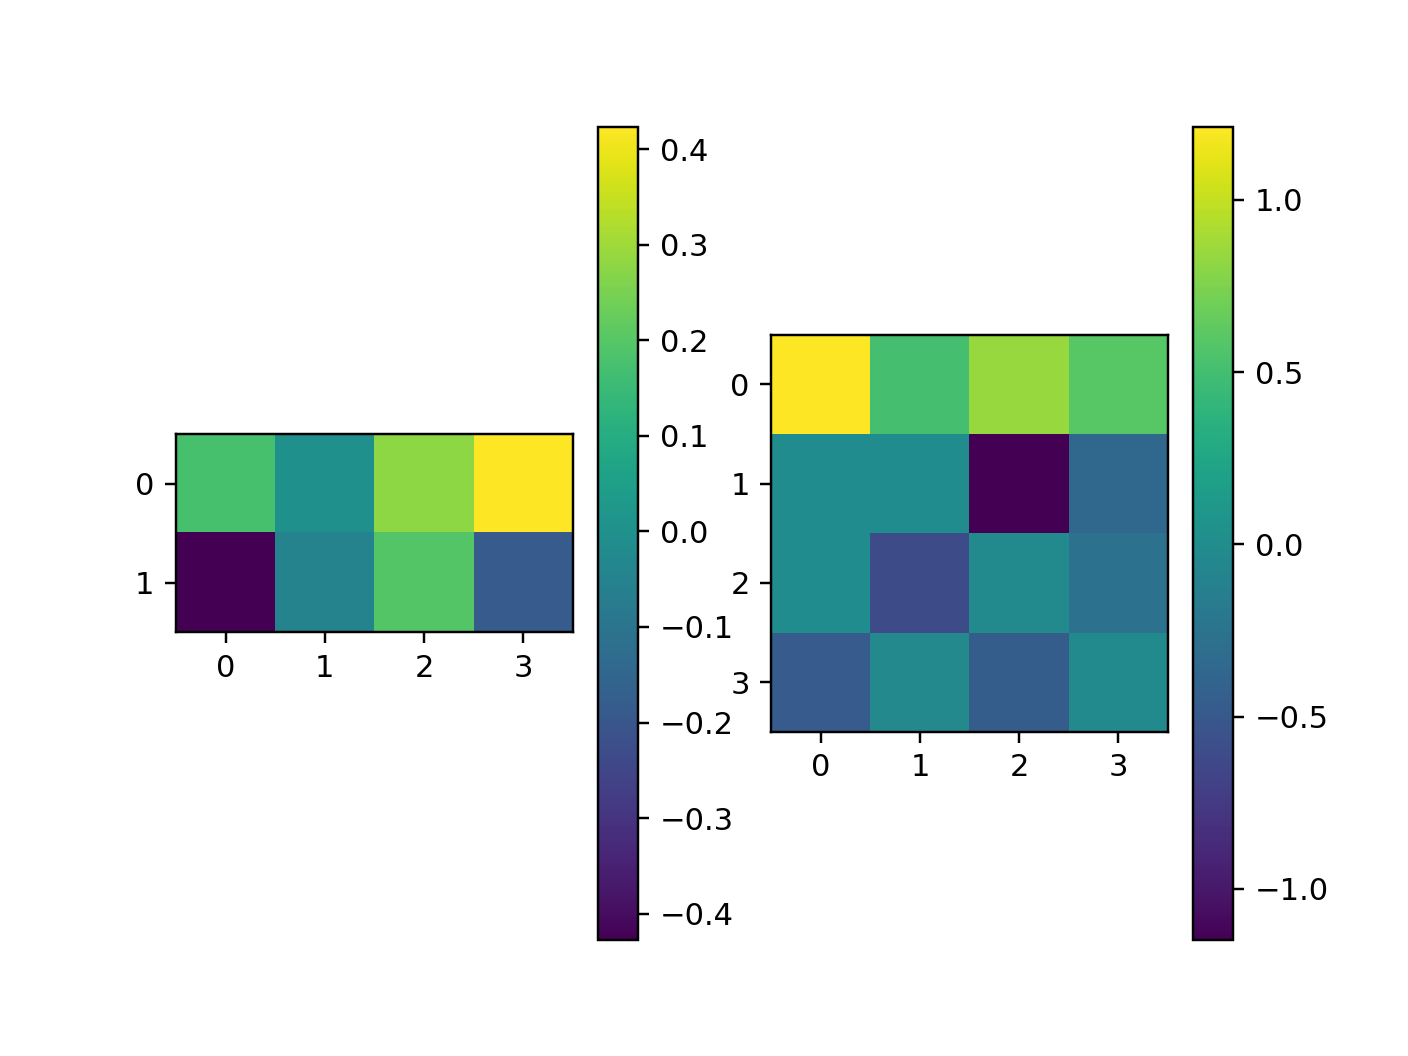

In [162]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Wmx)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Wmy)
plt.colorbar()

In [163]:
def show_four_celltypes(YYstar):
    lbls = ['PC','SST','VIP','PV']
    mag = 2
    plt.figure(figsize=(mag*nQ,mag))
    for itype in range(nQ):
        plt.subplot(1,nQ,itype+1)
        plt.title(lbls[itype])
        sca.show_size_contrast(YYstar[:,itype].reshape((5,6)),flipud=True)
    plt.tight_layout()
    
def show_all_celltypes(YYstar):
    lbls = ['PC','SST','VIP','PV']
    mag = 2
    plt.figure(figsize=(mag*nQ,mag*nQ))
    for itype in range(nQ**2):
        plt.subplot(nQ,nQ,itype+1)
        plt.title(lbls[np.remainder(itype,nQ)])
        sca.show_size_contrast(YYstar[:,itype].reshape((5,6)),flipud=True)
    plt.tight_layout()

<IPython.core.display.Javascript object>


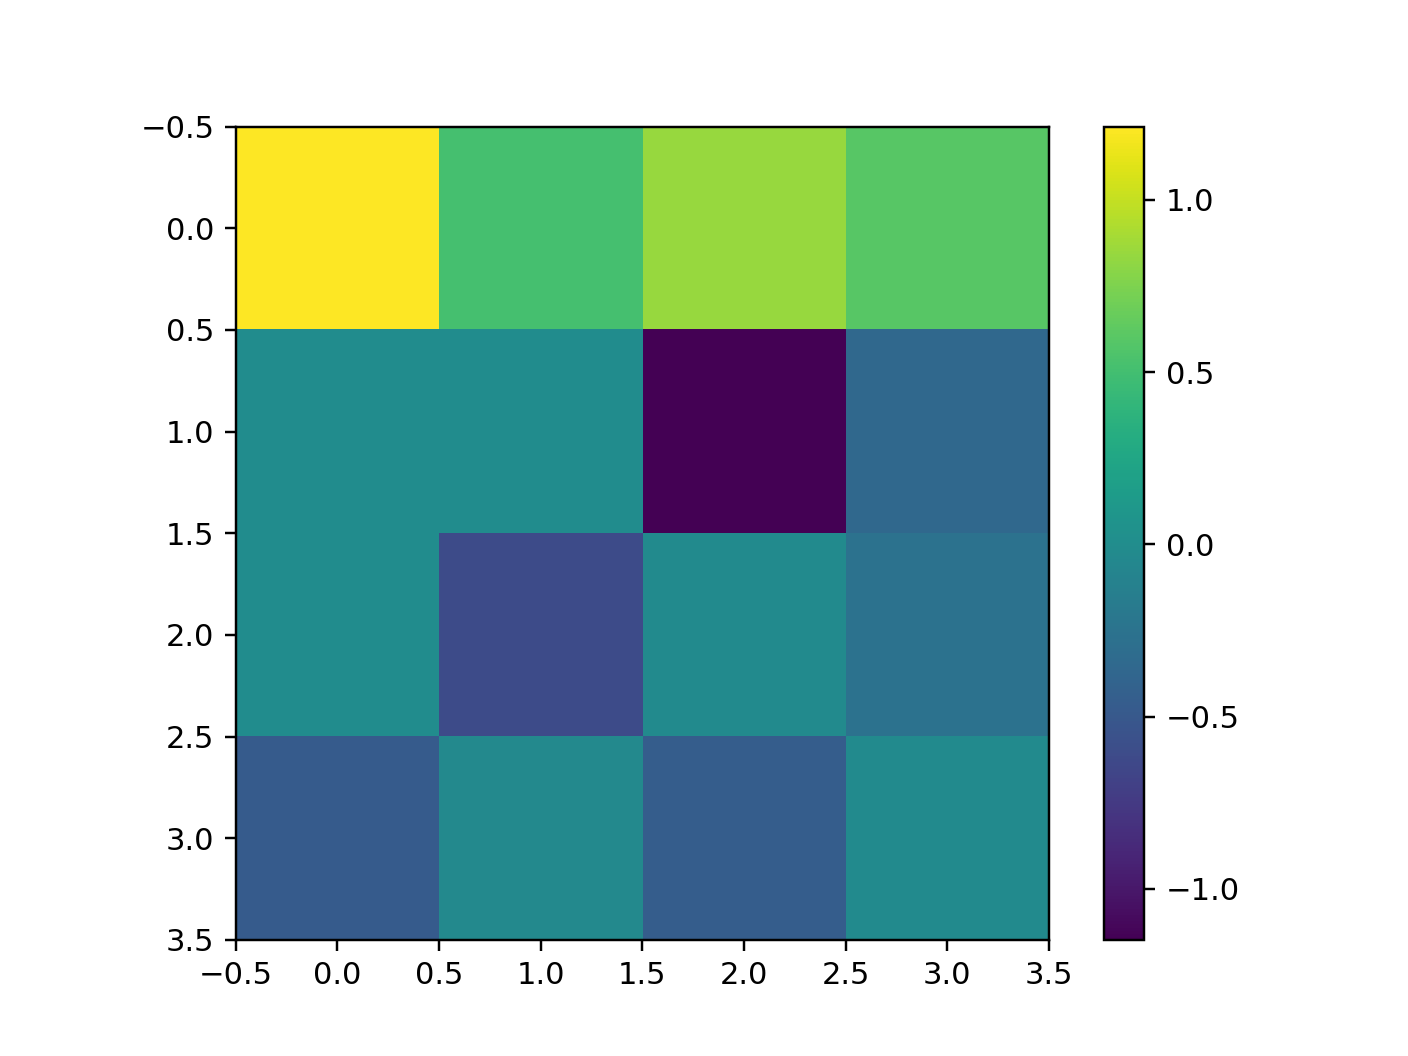

In [164]:
plt.figure()
plt.imshow(Wmy)
plt.colorbar()

<IPython.core.display.Javascript object>


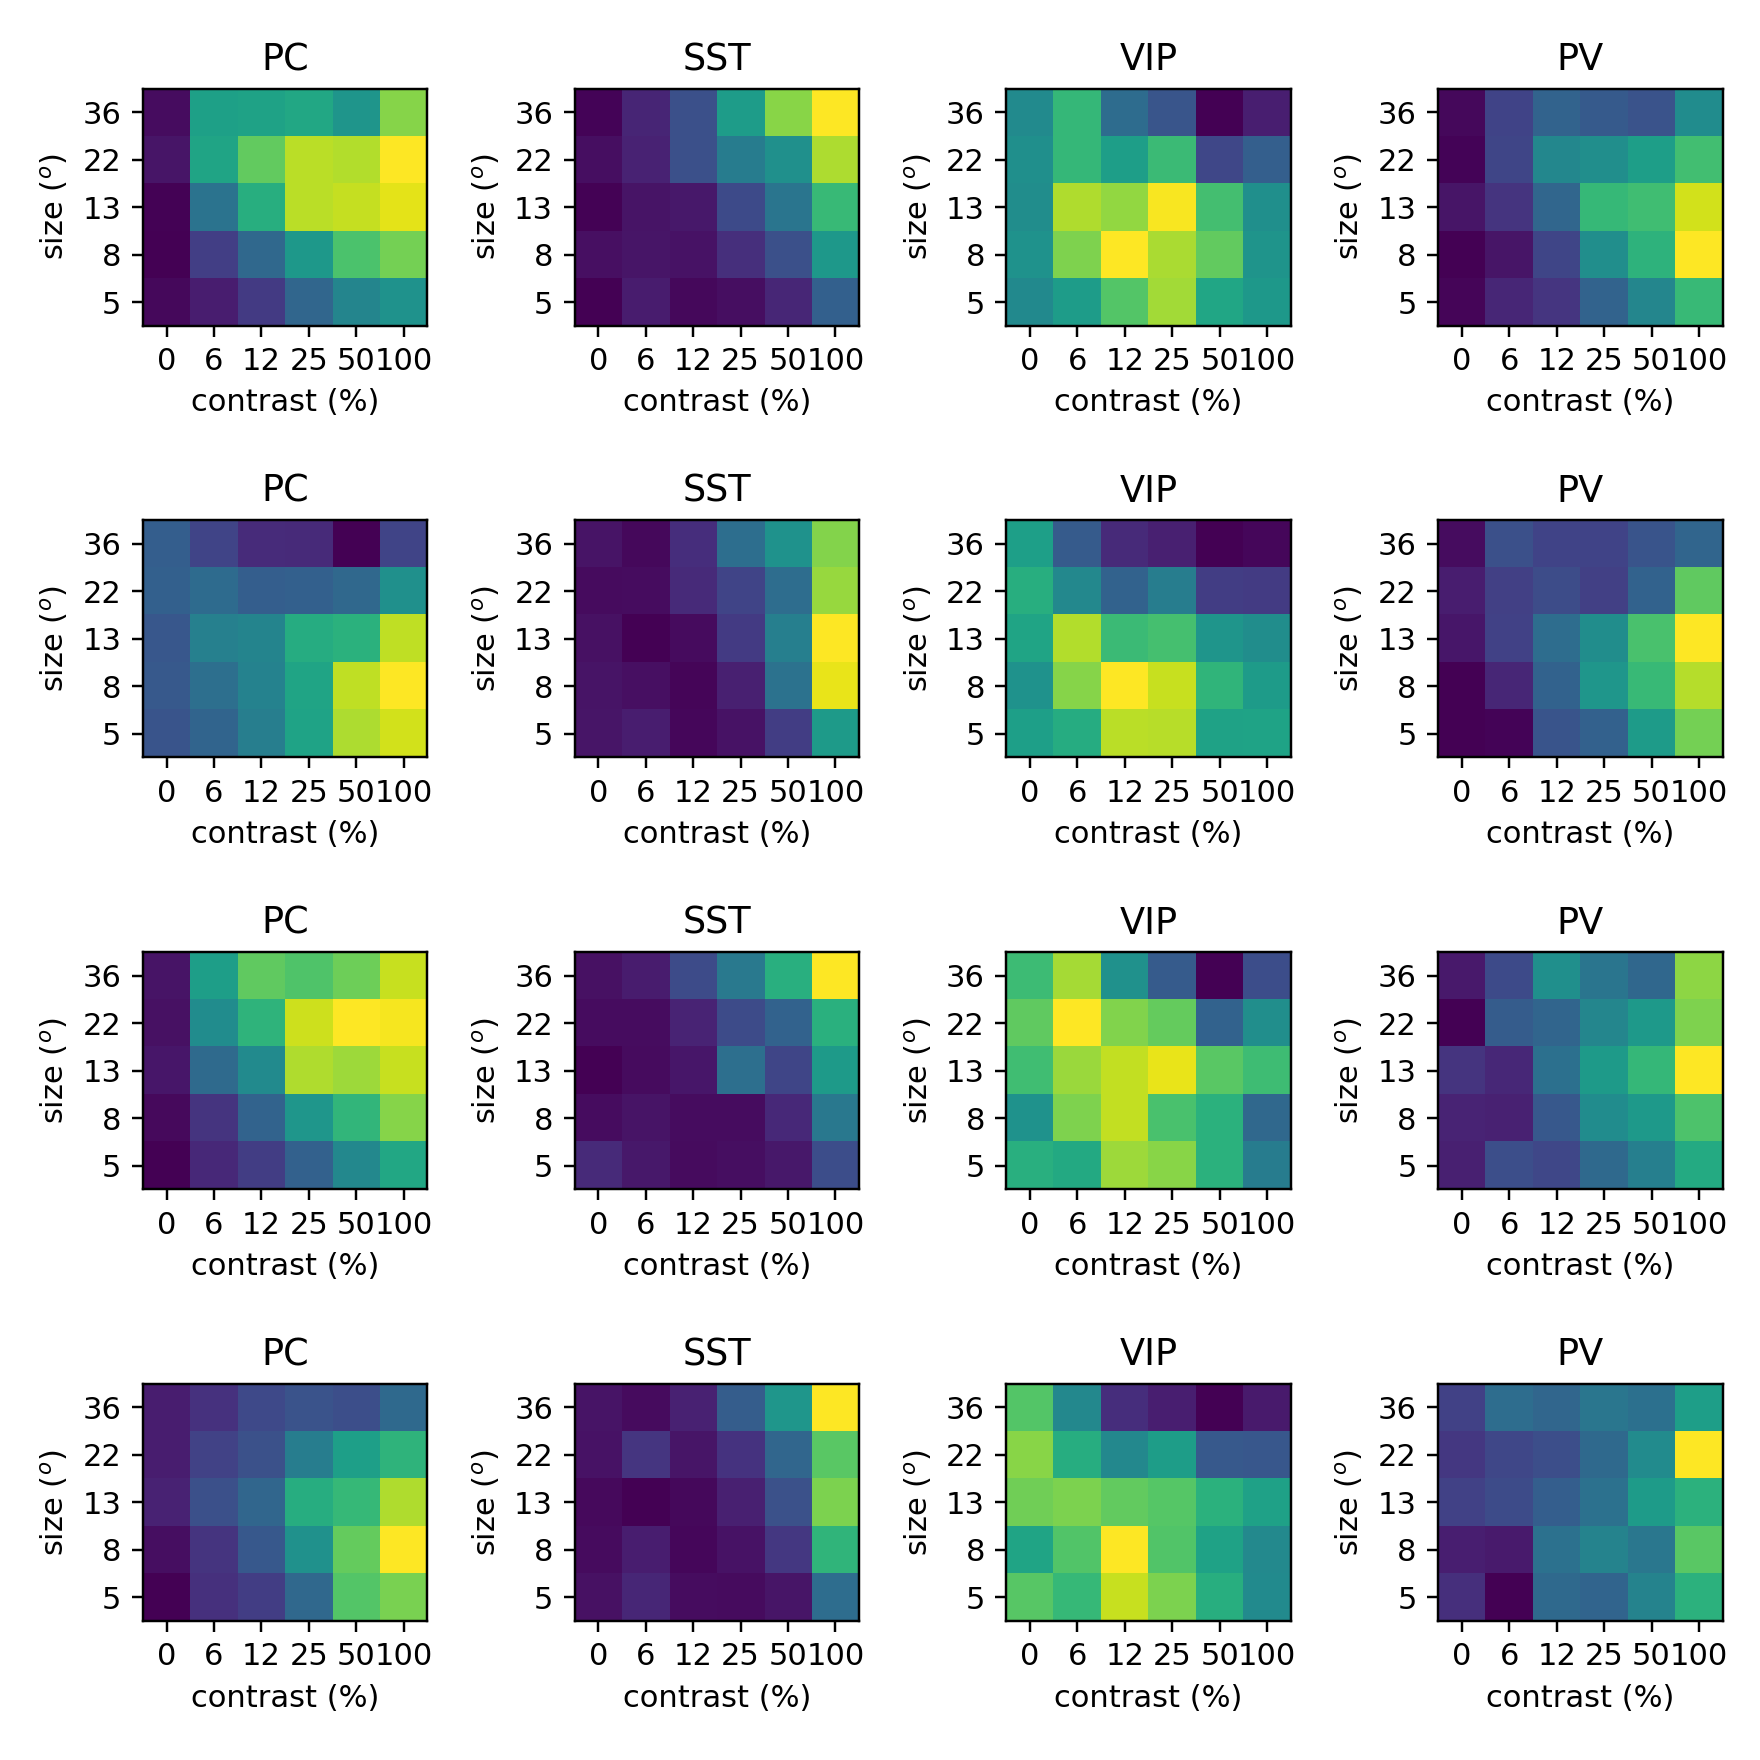

In [165]:
for itry in range(1): #ntries): 
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi = Wt[trystars_i[itry]][trystars_j[itry]]
#     Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[0][itry]
    XXhat = np.concatenate([np.concatenate(xxhh,axis=1) for xxhh in Xhat],axis=1)
    YYhat = np.concatenate([np.concatenate(xxhh,axis=1) for xxhh in Yhat],axis=1)
    YY = compute_f_(Eta,Xi,s02)
    Etastar = u_fn(XX,YY,Wmx,Wmy,k,kappa,T)
    Xistar = u_fn(XX,YY,Wsx,Wsy,k,kappa,T)
    YYstar = compute_f_(Etastar,Xistar,s02)
#     show_four_celltypes(YY)
    show_all_celltypes(YYhat)

#     mag = 2
#     plt.figure(figsize=(mag*nQ,mag))
#     for itype in range(nQ):
#         plt.subplot(1,nQ,itype+1)
#         plt.title(lbls[itype])
#         sca.show_size_contrast(YYstar[:,itype].reshape((5,6)),flipud=True)
#     plt.tight_layout()
#     plt.savefig('figures/modeled_four_cell_types.jpg',dpi=300)

In [166]:
K

array([0.96775473, 1.        , 1.        , 0.95124705])

In [167]:
Xhat[0][1].shape

(30, 2)

In [168]:
[np.concatenate(xh,axis=1) for xh in Xhat[0]]

AxisError: axis 1 is out of bounds for array of dimension 1

<IPython.core.display.Javascript object>


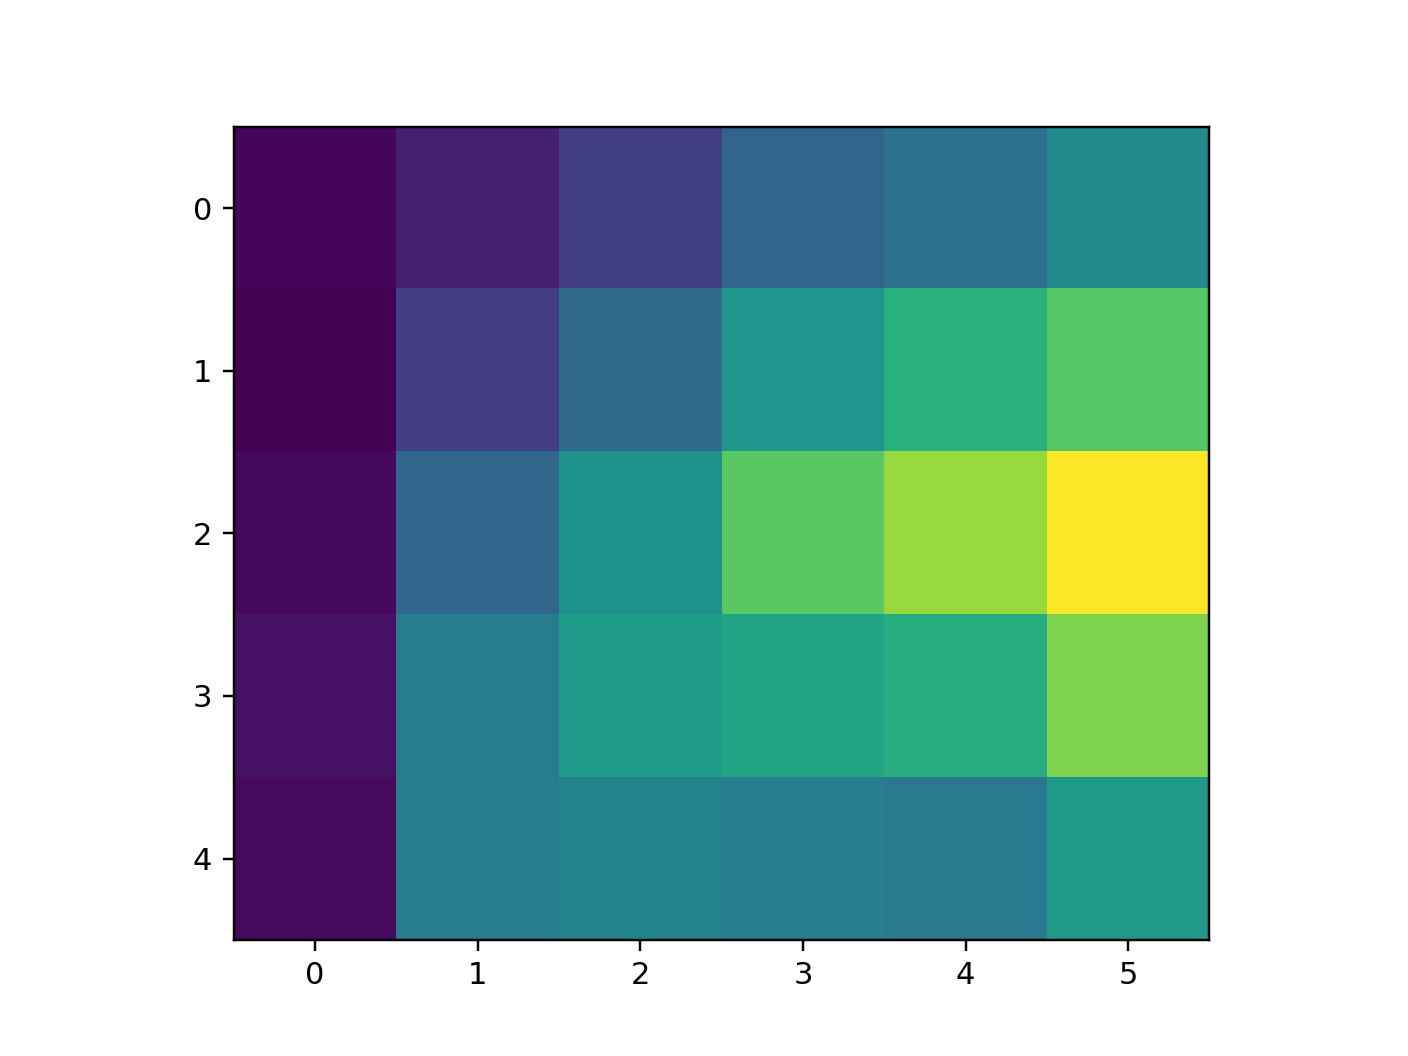

In [169]:
plt.figure()
plt.imshow(YY[:,0].reshape((5,6)))

<IPython.core.display.Javascript object>


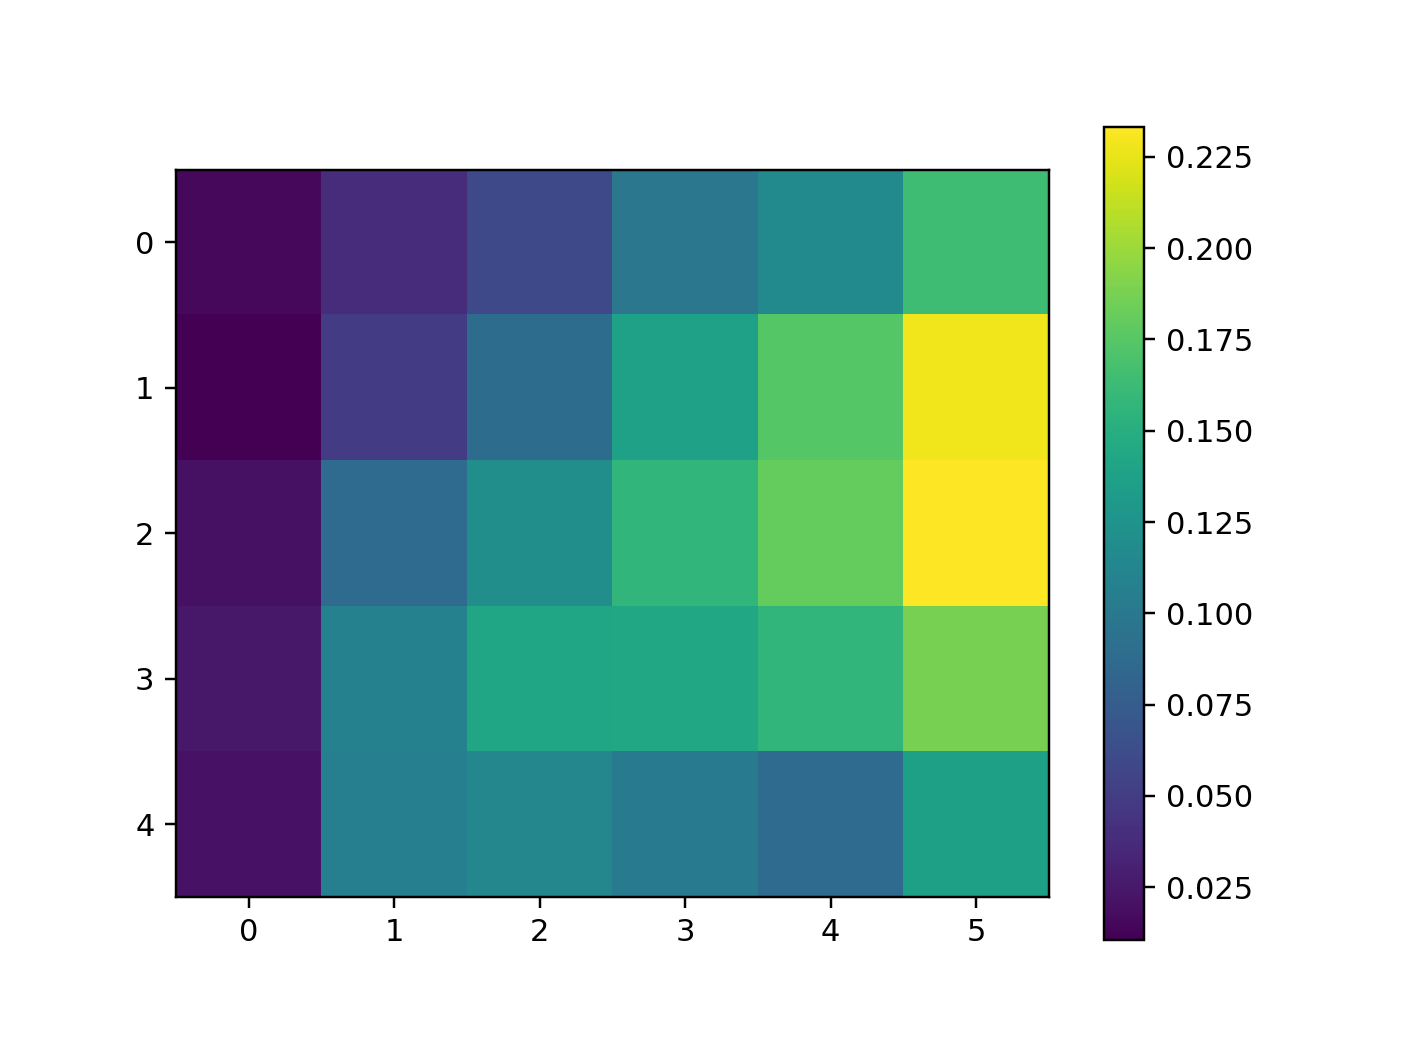

In [170]:
plt.figure()
plt.imshow((YY-YYstar)[:,0].reshape((nsize,ncontrast)))
plt.colorbar()

In [176]:
ww = gen_Weight(Wmy,k,kappa,T)
eig_actual = np.zeros((Etastar.shape[0],))
for istim in range(Etastar.shape[0]):
    eig_actual[istim] = np.max(np.real(np.linalg.eig(compute_fprime_m_(Eta,Xi,s02)[istim]@ww - np.eye(nS*nT*nQ))[0]))
#     eig_actual[istim] = np.max(np.real(np.linalg.eig(compute_fprime_(Etastar,Xistar,s02)[istim]@ww - np.eye(ww.shape[0]))[0]))
    eig_no_gain = np.max(np.real(np.linalg.eig(ww - np.eye(ww.shape[0]))[0]))
    print((eig_actual[istim],eig_no_gain))

(-0.9999999999999991, 1.088034755720857)
(-0.9999999999999992, 1.088034755720857)
(-0.9999999999999988, 1.088034755720857)
(-0.9999999999999988, 1.088034755720857)
(-0.9999999999999991, 1.088034755720857)
(-0.9999999999999991, 1.088034755720857)
(-0.9999999999999996, 1.088034755720857)
(-0.9999999999999996, 1.088034755720857)
(-0.848225270985385, 1.088034755720857)
(-0.9604814209467221, 1.088034755720857)
(-0.999999999999999, 1.088034755720857)
(-0.9999999999999994, 1.088034755720857)
(-0.9999999999999989, 1.088034755720857)
(-0.6109516292711623, 1.088034755720857)
(0.3099997607014833, 1.088034755720857)
(1.229447081031667, 1.088034755720857)
(-0.8526056751437843, 1.088034755720857)
(-0.9999999999999989, 1.088034755720857)
(-0.9999999999999989, 1.088034755720857)
(0.034620661111890466, 1.088034755720857)
(0.6481192249056755, 1.088034755720857)
(0.5272874509875263, 1.088034755720857)
(-0.09844560349576625, 1.088034755720857)
(-0.8344092426209275, 1.088034755720857)
(-0.9999999999999989,

In [179]:
istim = 29
drf,prf = np.linalg.eig(compute_fprime_m_(Eta,Xi,s02)[istim]@ww - np.eye(nS*nT*nQ))

In [180]:
prf[:,1]

array([ 0.29496136+0.j        ,  0.00116019-0.26394207j,
       -0.09285491-0.22113501j, -0.16856478-0.18666271j,
       -0.16856478-0.18666271j, -0.09285491-0.22113501j,
       -0.09285491-0.22113501j, -0.09285491-0.22113501j,
       -0.16856478-0.18666271j, -0.09285491-0.22113501j,
       -0.16856478-0.18666271j, -0.09285491-0.22113501j,
       -0.05499998-0.23837116j, -0.05499998-0.23837116j,
       -0.05499998-0.23837116j, -0.01714505-0.25560731j])

In [183]:
istim = -1
np.linalg.eig(compute_fprime_m_(Eta,Xi,s02)[istim]@ww - np.eye(nS*nQ*nT))[1][0]

array([ 0.25      +0.j,  0.29496136+0.j,  0.29496136-0.j,  0.28331681+0.j,
       -0.77347889+0.j, -0.07853726+0.j, -0.17463673+0.j,  0.00994753+0.j,
       -0.05456866+0.j, -0.08480812+0.j, -0.22399136+0.j,  0.03081336+0.j,
       -0.03280542+0.j,  0.18922642+0.j,  0.26636756+0.j, -0.06710447+0.j])

In [184]:
(Wmy[1,2],Wmy[2,1],Wmy[3,0],Wmy[1,0])

(-1.1482292355447987,
 -0.6056465769385639,
 -0.47033946527741916,
 -0.002764627122127211)

In [185]:
YY = compute_f_(Eta,Xi,s02)

<IPython.core.display.Javascript object>


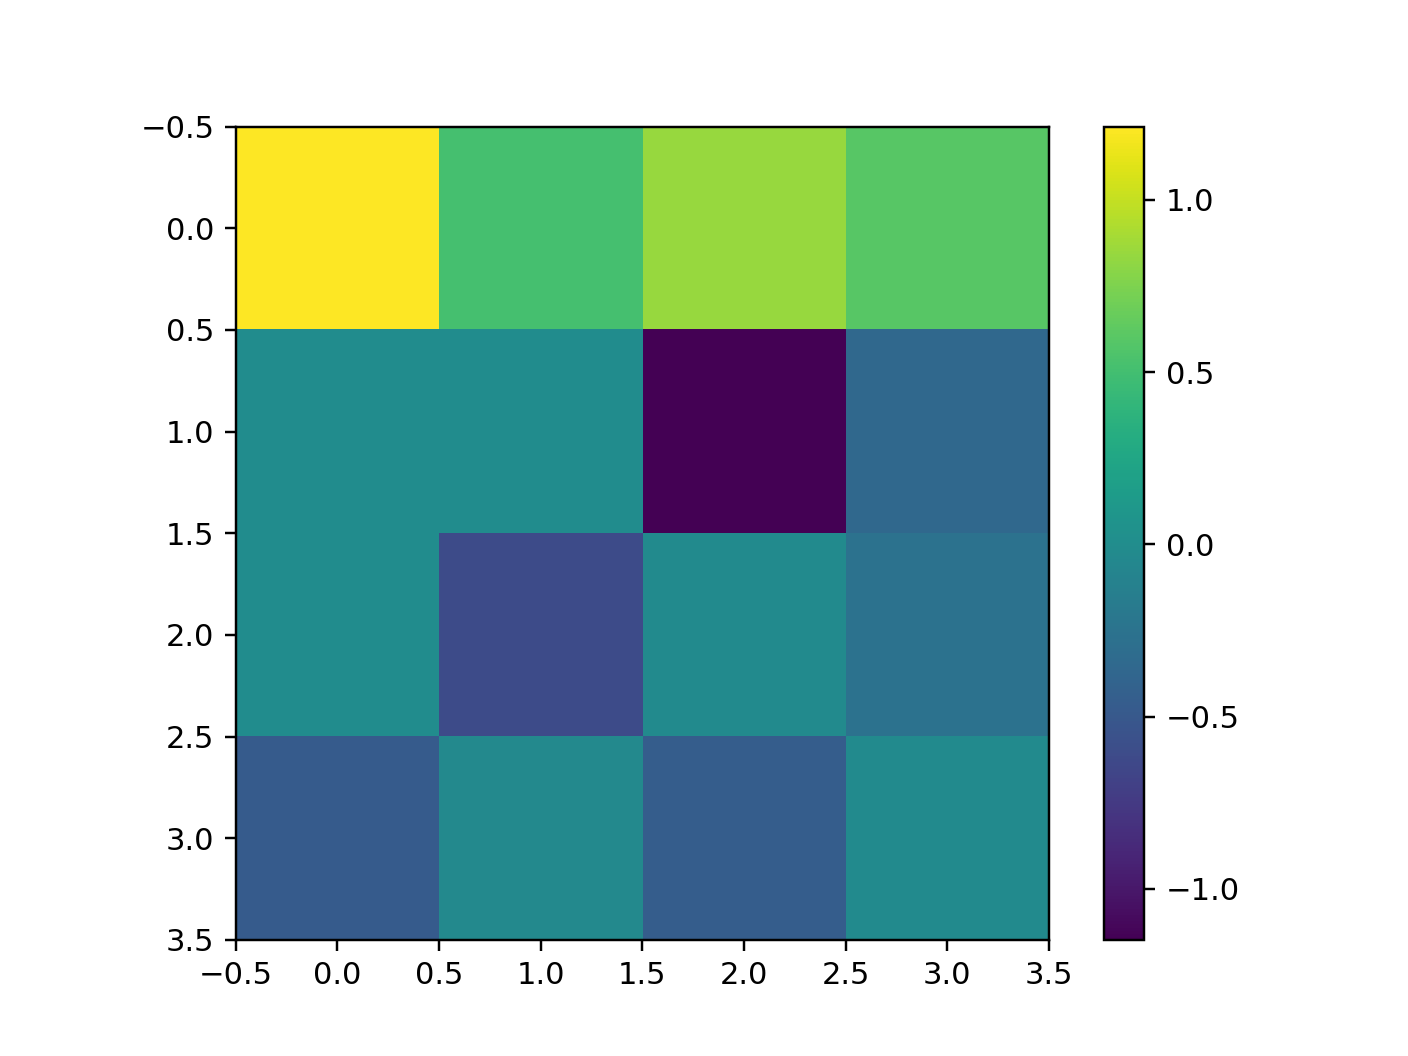

<IPython.core.display.Javascript object>


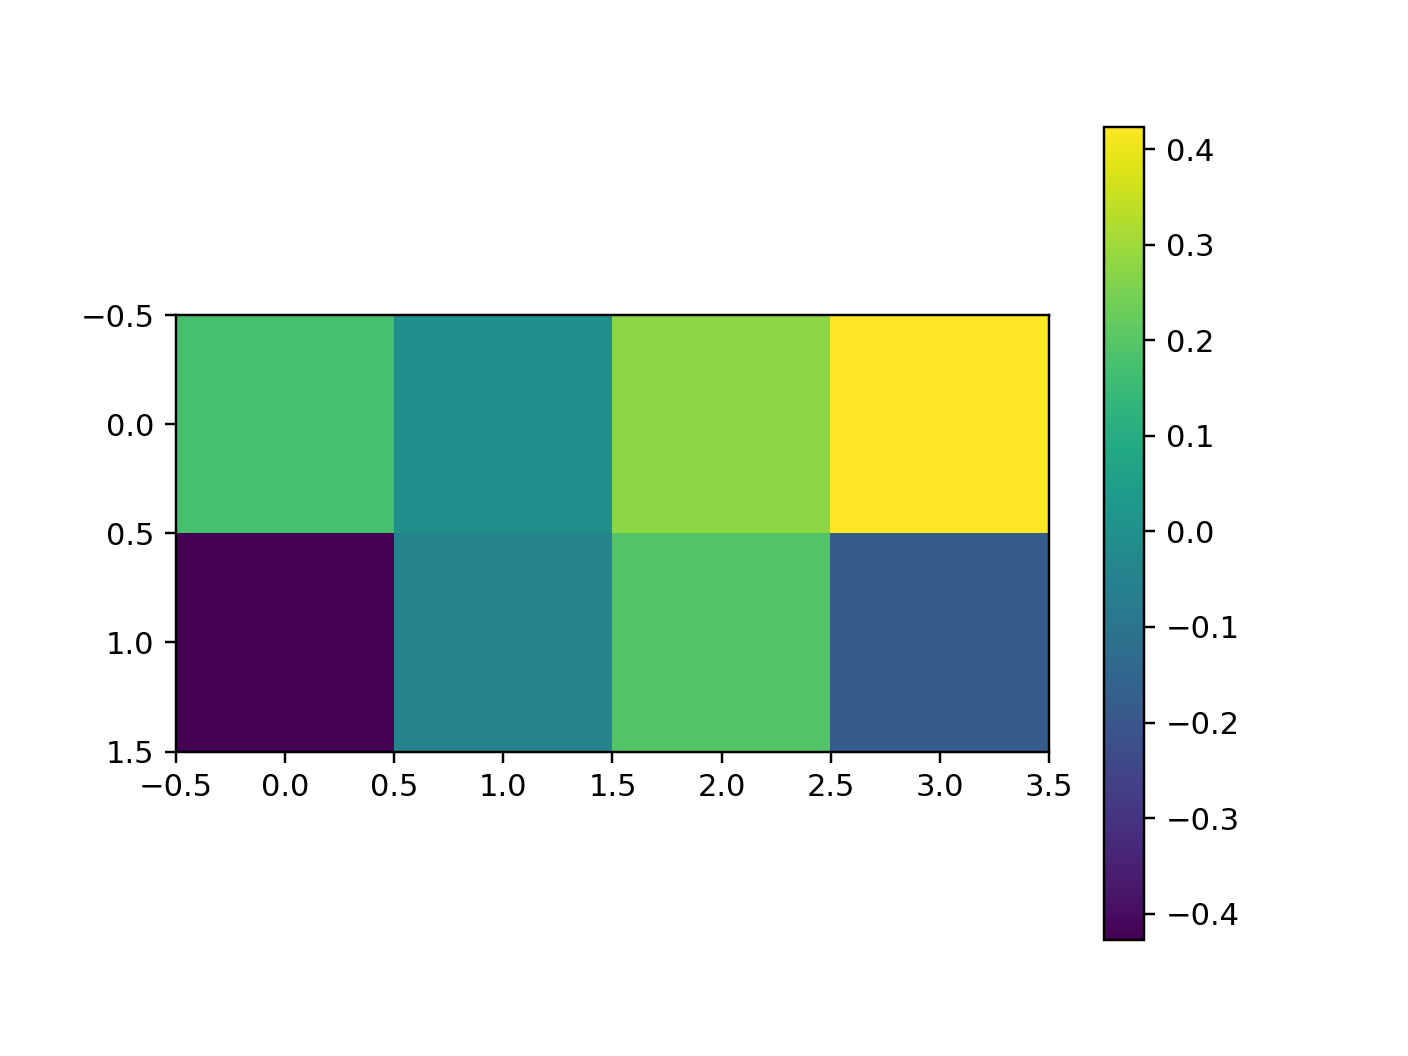

In [186]:
plt.figure()
plt.imshow(Wmy)
plt.colorbar()
plt.figure()
plt.imshow(Wmx)#,vmin=-2,vmax=2)
plt.colorbar()

In [187]:
Wmy_bounds

array([[ 2,  2,  2,  2],
       [-2,  0, -2, -2],
       [ 0, -2, -2, -2],
       [-2, -2, -2, -2]])

<IPython.core.display.Javascript object>


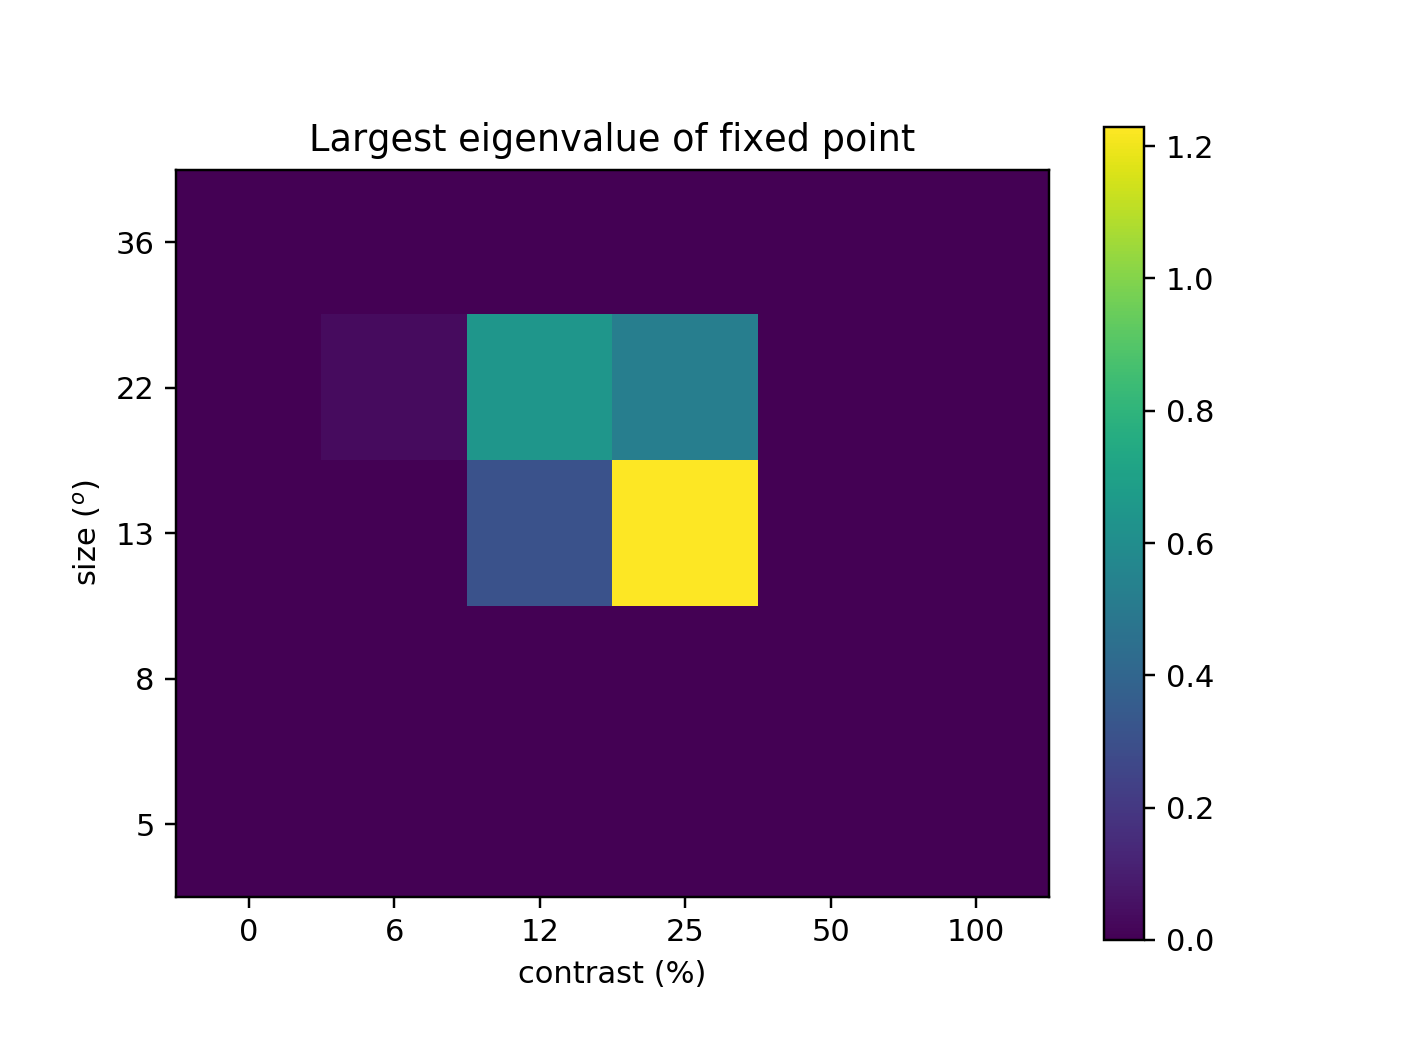

Text(0.5, 1.0, 'Largest eigenvalue of fixed point')

In [188]:
plt.figure()
sca.show_size_contrast(eig_actual.reshape((nsize,ncontrast)),vmin=0,flipud=True)#,vmin=-1,vmax=1)
plt.colorbar()
plt.title('Largest eigenvalue of fixed point')
# plt.savefig('figures/possible_gamma_substrate.jpg',dpi=300)

In [1915]:
# Wstar_dict = np.load('weights_200111b.npy',allow_pickle=True)[()]

In [189]:
nstar = len(trystars_i)
YY = [None for istar in range(nstar)]
Nvals = 10
max_val = 1
Niter = int(1e3)
for istar in range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[ti][tj]
    def fY(XX,YY):
        return compute_f_(u_fn(XX,YY,Wmx,Wmy,k,kappa),u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY(XX,YY0,eta=1e-2):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = eta*dYYdt(YY[iiter])
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    YY = np.zeros((Nvals,Nvals,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta[0],Xi[0],s02)
    XX = np.ones((Nvals,Nvals,4))
    XX[:,:,0],XX[:,:,2] = np.meshgrid(np.linspace(0,max_val,Nvals),np.linspace(0,max_val,Nvals),indexing='ij')
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for ival in range(Nvals):
        YY[ival,0] = predict_YY(XX[ival,0],YY0)
        print(ival)
        for jval in range(1,Nvals):
            YY[ival,jval] = predict_YY(XX[ival,jval],YY[ival-1,jval,-1])
            
    mag = 2
    plt.figure(figsize=(mag*ncelltypes,mag))
    for icelltype in range(nQ):
        plt.subplot(1,ncelltypes,icelltype+1)
        plt.imshow(YY[:,:,-1,icelltype],vmin=0)#,interpolation='bilinear')
        plt.axis('off')

0


ValueError: too many values to unpack (expected 11)

In [1946]:
nstar = len(trystars_i)
YYsc = [None for istar in range(nstar)]
Niter = int(2e3)
for istar in range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    def fY(XX,YY):
        return compute_f_(resEta[ival]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[ival]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY(XX,YY0,eta=2e-2):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = eta*dYYdt(YY[iiter])
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    
    YYsc[istar] = np.zeros((nN,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02) + 0.05*np.tile(np.array((0,1,0,0,0,1,0,0))[np.newaxis],(nN,1)) #*np.random.randn(nN,nS*nQ)
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for ival in range(nN):
        YYsc[istar][ival] = predict_YY(XX[ival],YY0[ival])
        print(ival)
            
#     mag = 2
#     plt.figure(figsize=(mag*ncelltypes,mag))
#     for icelltype in range(nQ):
#         plt.subplot(1,ncelltypes,icelltype+1)
#         plt.imshow(YY[:,:,-1,icelltype],vmin=0,interpolation='bilinear')
#         plt.axis('off')

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


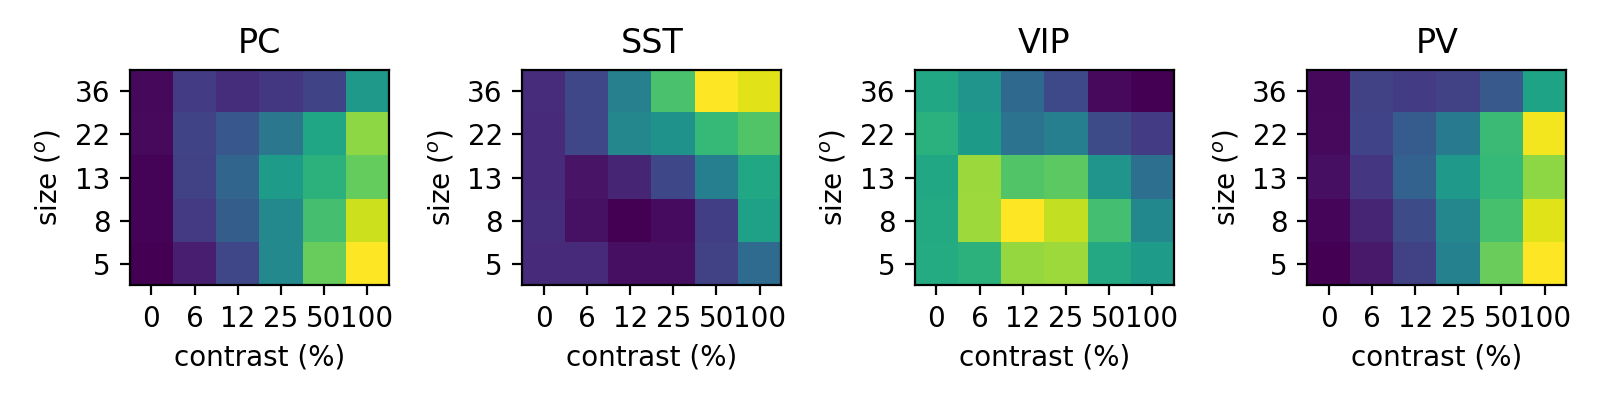

In [1947]:
show_four_celltypes(YYsc[0][:,-1])
# plt.savefig('figures/self_consistent_model_no_residual_currents.jpg',dpi=300)

In [205]:
YY = compute_f_(Eta,Xi,s02)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


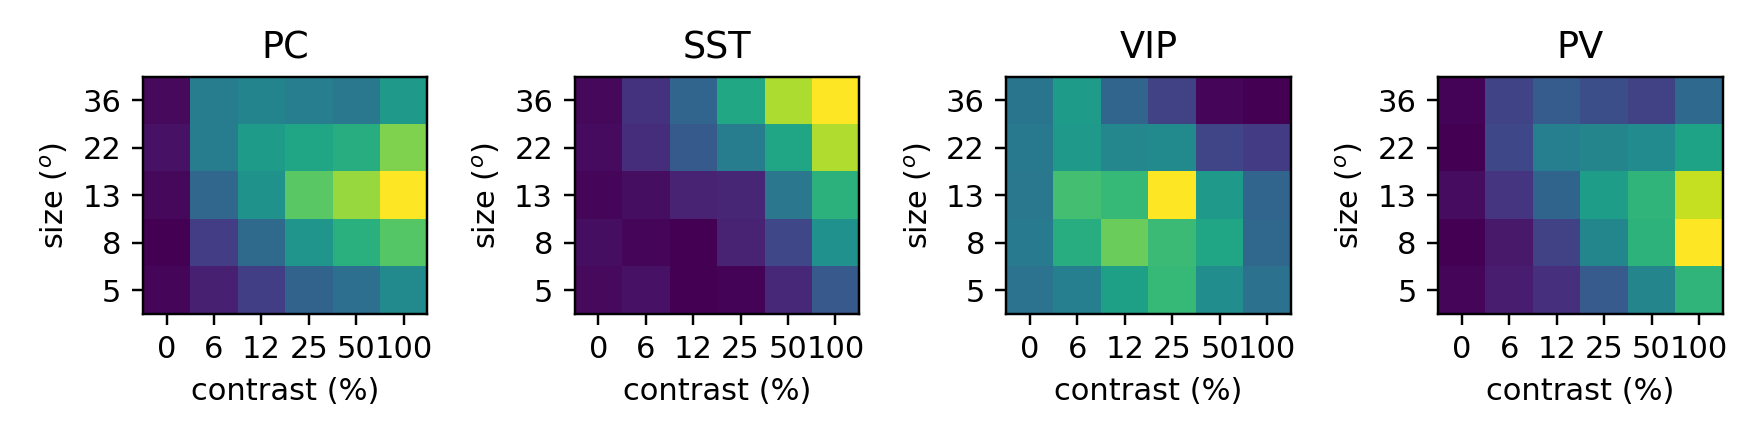

In [206]:
show_four_celltypes(YY)#[0][:,-1])
# plt.savefig('figures/self_consistent_model_with_residual_currents.jpg',dpi=300)

array([[0.39086693, 0.21484218, 0.58632514, 0.34584914, 0.22859653,
        0.20503422, 0.41731107, 0.26258943, 0.36987473, 0.2647083 ,
        0.71122421, 0.39903011, 0.2273314 , 0.19702482, 0.48613217,
        0.29203617],
       [0.43169382, 0.2318594 , 0.62277941, 0.38423189, 0.23736838,
        0.20647303, 0.43180682, 0.26773159, 0.42344258, 0.24078546,
        0.70430321, 0.46280198, 0.24139063, 0.2000154 , 0.46636541,
        0.27163461],
       [0.47886062, 0.20612953, 0.72256559, 0.4151469 , 0.27220334,
        0.17896325, 0.5094148 , 0.32443159, 0.46008977, 0.21455186,
        0.8146748 , 0.46421441, 0.24976802, 0.17909547, 0.54554288,
        0.34823162],
       [0.56900887, 0.21168364, 0.79631677, 0.50323752, 0.29059425,
        0.18628887, 0.50546355, 0.34822425, 0.51360551, 0.21591154,
        0.81412997, 0.53000407, 0.26961431, 0.17844957, 0.51336273,
        0.35385627],
       [0.64403624, 0.26681506, 0.66155108, 0.60125777, 0.32454671,
        0.23827165, 0.42395552, 

In [207]:
YY[0].shape

(16,)

In [2099]:
def compute_f_(Eta,Xi,s02):
    return utils.f_miller_troyer(Eta,Xi**2+np.concatenate((s02,s02),axis=0))

def compute_fprime_m_(Eta,Xi,s02):
    return utils.fprime_miller_troyer(Eta,Xi**2+np.concatenate((s02,s02),axis=0))*Xi

def compute_fprime_s_(Eta,Xi,s02):
    s2 = Xi**2+np.concatenate((s02,s02),axis=0)
    return utils.fprime_s_miller_troyer(Eta,s2)*(Xi/s2)

def sorted_r_eigs(w):
    drW,prW = np.linalg.eig(w)
    srtinds = np.argsort(drW)
    return drW[srtinds],prW[:,srtinds]

def gen_Weight(W,K,kappa):
    WW0 = np.concatenate((W,W*K[np.newaxis,:]),axis=1)
    WW1 = np.concatenate((W*K[np.newaxis,:]*kappa,W),axis=1)
    WW = np.concatenate((WW0,WW1),axis=0)
    return WW

def u_fn(XX,YY,Wx,Wy,k,kappa):
    WWx,WWy = [gen_Weight(W,k,kappa) for W in [Wx,Wy]]
    return u_fn_WW(XX,YY,WWx,WWy)# XX @ WWx + YY @ WWy

def u_fn_WW(XX,YY,WWx,WWy):
    return XX @ WWx + YY @ WWy

def compute_steady_state(Wlist,Niter=int(4e2),max_val=2.5,Ny=50,fix_dim=None,stim_vals=None,dt=1e-2,perturbation_size=5e-2):
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wlist
    nQ = Wmy.shape[0]
    nN = Eta.shape[0]
    nS = int(Eta.shape[1]/nQ)
    
    if fix_dim is None:
        fix_dim = [None]
        Nfix = 1
        yvals = (0,)
        Ny = 1
        max_val = 0
    else:
        Nfix = len(fix_dim)
        yvals = np.linspace(0,max_val,Ny)
    
    if stim_vals is None:
        stim_vals = np.arange(nN)
    Nstim = len(stim_vals)
    
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    
    def fY(XX,YY):
        return compute_f_(resEta[stim_val]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[stim_val]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY_fix_dim(XX,YY0,fix_dim=None,run_backward=False,):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0 #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = dt*dYYdt(YY[iiter])
            if not fix_dim is None:
                dYY[fix_dim] = 0
            if run_backward:
                dYY = -dYY
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    
    YY_ss = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02)
    for istim,stim_val in enumerate(stim_vals): #range(nN):
        print(istim)
        for iy,yval in enumerate(yvals):
            for ifix in range(Nfix):
                yy0 = YY0[stim_val] + perturbation_size*np.random.randn(*(YY0[stim_val].shape))
                if not fix_dim[ifix] is None:
                    yy0[fix_dim[ifix]] = yval
                YY_ss[ifix,istim,iy] = predict_YY_fix_dim(XX[stim_val],yy0,fix_dim=fix_dim[ifix])
    if fix_dim[0] is None:
        YY_ss = YY_ss[0,:,0,:,:]
    return YY_ss

In [2100]:
nstar = len(trystars_i)
Niter = int(3e3)
fix_dim = [0,1,2,3]
Nfix = len(fix_dim)
# YY = [None for ifix in range(Nfix)]
Ny = 50
max_val = 2.5
yvals = np.linspace(0,max_val,Ny)
stim_vals = np.arange(30)
Nstim = len(stim_vals)
for istar in (0,): #range(nstar):
    print(istar)
#     ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[ti][tj]
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    def fY(XX,YY):
        return compute_f_(resEta[stim_val]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[stim_val]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY_fix_dim(XX,YY0,eta=1e-2,fix_dim=None,run_backward=False):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = eta*dYYdt(YY[iiter])
            if not fix_dim is None:
                dYY[fix_dim] = 0
            if run_backward:
                dYY = -dYY
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    
    YY_ss = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02)
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for istim,stim_val in enumerate(stim_vals): #range(nN):
        print(istim)
        for iy,yval in enumerate(yvals):
            for ifix in range(Nfix):
                yy0 = YY0[stim_val] #+np.random.randn(yy0.shape)
                yy0[fix_dim[ifix]] = yval
                YY_ss[ifix,istim,iy] = predict_YY_fix_dim(XX[stim_val],yy0,fix_dim=fix_dim[ifix])

0
0


KeyboardInterrupt: 

In [1040]:
# YY_ss = YY.copy()

In [ ]:
# def u_fn(XX,YY,Wx,Wy,k,kappa):
#     WWx,WWy = [gen_Weight(W,k,kappa) for W in [Wx,Wy]]
#     return XX @ WWx + YY @ WWy

In [1527]:
reload(utils)
nstar = len(trystars_i)
Niter = int(4e3)
fix_dim = [0,1,2,3]
Nfix = len(fix_dim)
# YY = [None for ifix in range(Nfix)]
Ny = 50
Nx = 20
max_val = 2.5
yvals = np.linspace(0,max_val,Ny)
xvals = np.linspace(0,max_val,Nx)
stim_vals = np.arange(30)
Nstim = len(stim_vals)
for istar in (0,): #range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    WWmx,WWmy = [gen_Weight(W,k,kappa) for W in [Wmx,Wmy]]
    WWsx,WWsy = [gen_Weight(W,k,kappa) for W in [Wsx,Wsy]]
    def u_fn_m(XX,YY):
        return u_fn_WW(XX,YY,WWx=WWmx,WWy=WWmy)
    def u_fn_s(XX,YY):
        return u_fn_WW(XX,YY,WWx=WWsx,WWy=WWsy)
    def dfYdY(XX,YY):
        # derivs: (nN,nS*nQ)
        # WWy: (nS*nQ,nS*nQ)
        # (dfYdY)ij = dfj(Y)/dYi
        deriv_m = compute_fprime_m_(resEta[stim_val]+u_fn_m(XX,YY),resXi[stim_val]+u_fn_s(XX,YY),s02)
        deriv_s = compute_fprime_s_(resEta[stim_val]+u_fn_m(XX,YY),resXi[stim_val]+u_fn_s(XX,YY),s02)
        return deriv_m[:,np.newaxis,:]*WWmy[np.newaxis,:,:] + deriv_s[:,np.newaxis,:]*WWsy[np.newaxis,:,:]
    def fY(XX,YY):
        return compute_f_(resEta[stim_val:stim_val+1]+u_fn_m(XX,YY),resXi[stim_val:stim_val+1]+u_fn_s(XX,YY),s02)
    def predict_YY_fix_dim(XX,YY0,eta=2e-1,fix_dim=0,run_backward=False):
        def F(YY):
            # YY: (nN,nS*nQ)
            # F: (nN,nS*nQ)
            return -YY + fY(XX,YY)
        def dFdYY(YY):
            # dFdYY: (nN,nS*nQ,nS*nQ)
            # (dFdYY)ij = dFj(Y)/dYi, inherited from dfYdY convention
            return -np.eye(nS*nQ)[np.newaxis,:,:] + dfYdY(XX,YY)
        def dF2dYY(YY):
            # dFdYY: (nN,nS*nQ,nS*nQ)
            # F: (nN,nS*nQ)
            # dF2dYY: (nN,nS*nQ)
            # (dFdYY)ij = dFj(Y)/dYi, so sum_j ( dFj(Y)/dYi Fj(Y) = sum_j (dFdYY)ij Fj) yields the right answer
            return np.einsum('hij,hj->hi',dFdYY(YY),F(YY))
        YY = np.zeros((1,Niter+1,nS*nQ))
        YY[:,0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[:,0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = -eta*dF2dYY(YY[:,iiter])
            dYY[:,fix_dim] = 0
            if run_backward:
                dYY = -dYY
            YY[:,iiter+1] = YY[:,iiter] + dYY
            iiter = iiter+1
        return YY
    
    YY_F2 = np.zeros((Nfix,Nstim,Ny,Nx,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02)
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for istim,stim_val in enumerate(stim_vals): #range(nN):
        print(istim)
        for iy,yval in enumerate(yvals):
            for ix,xval in enumerate(xvals):
                for ifix in range(Nfix):
    #                 yy0 = YY0[stim_val] #+np.random.randn(yy0.shape)
                    yy0[:] = np.random.rand(*yy0.shape)
                    yy0[fix_dim[ifix]] = yval
                    YY_F2[ifix,istim:istim+1,iy,ix] = predict_YY_fix_dim(XX[stim_val:stim_val+1],yy0[np.newaxis],fix_dim=fix_dim[ifix])
    #             if np.remainder(iy,10)==0:
#                 print(iy)
            
#     mag = 2
#     plt.figure(figsize=(mag*ncelltypes,mag))
#     for icelltype in range(nQ):
#         plt.subplot(1,ncelltypes,icelltype+1)
#         plt.imshow(YY[:,:,-1,icelltype],vmin=0,interpolation='bilinear')
#         plt.axis('off')

0
0


KeyboardInterrupt: 

In [1057]:
pdb.pm()

> <ipython-input-1056-9146c9d1360a>(48)dF2dYY()
-> return dFdYY(YY) @ F(YY)
(Pdb) dFdYY.shape
*** AttributeError: 'function' object has no attribute 'shape'
(Pdb) dFdYY(YY).shape
(1, 8, 8)
(Pdb) F(YY).shape
(1, 8)
(Pdb) exit


<IPython.core.display.Javascript object>


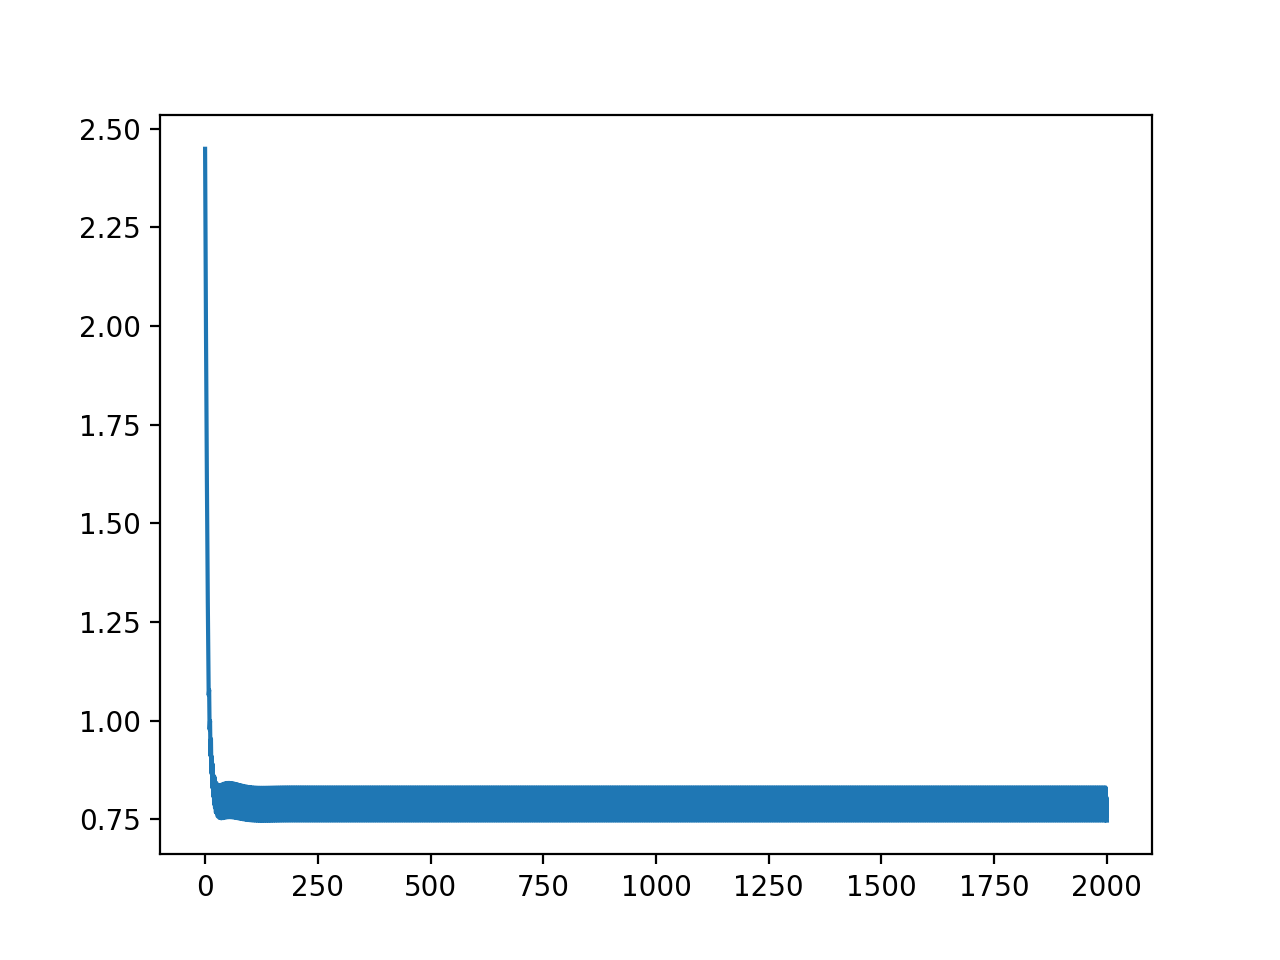

In [604]:
plt.figure()
plt.plot(YY[ix,istim,-1,:,iy])

In [1960]:
Wmy[2,1],Wmy[1,2]

(-2.144034644009146, -0.5218867289146812)

<IPython.core.display.Javascript object>


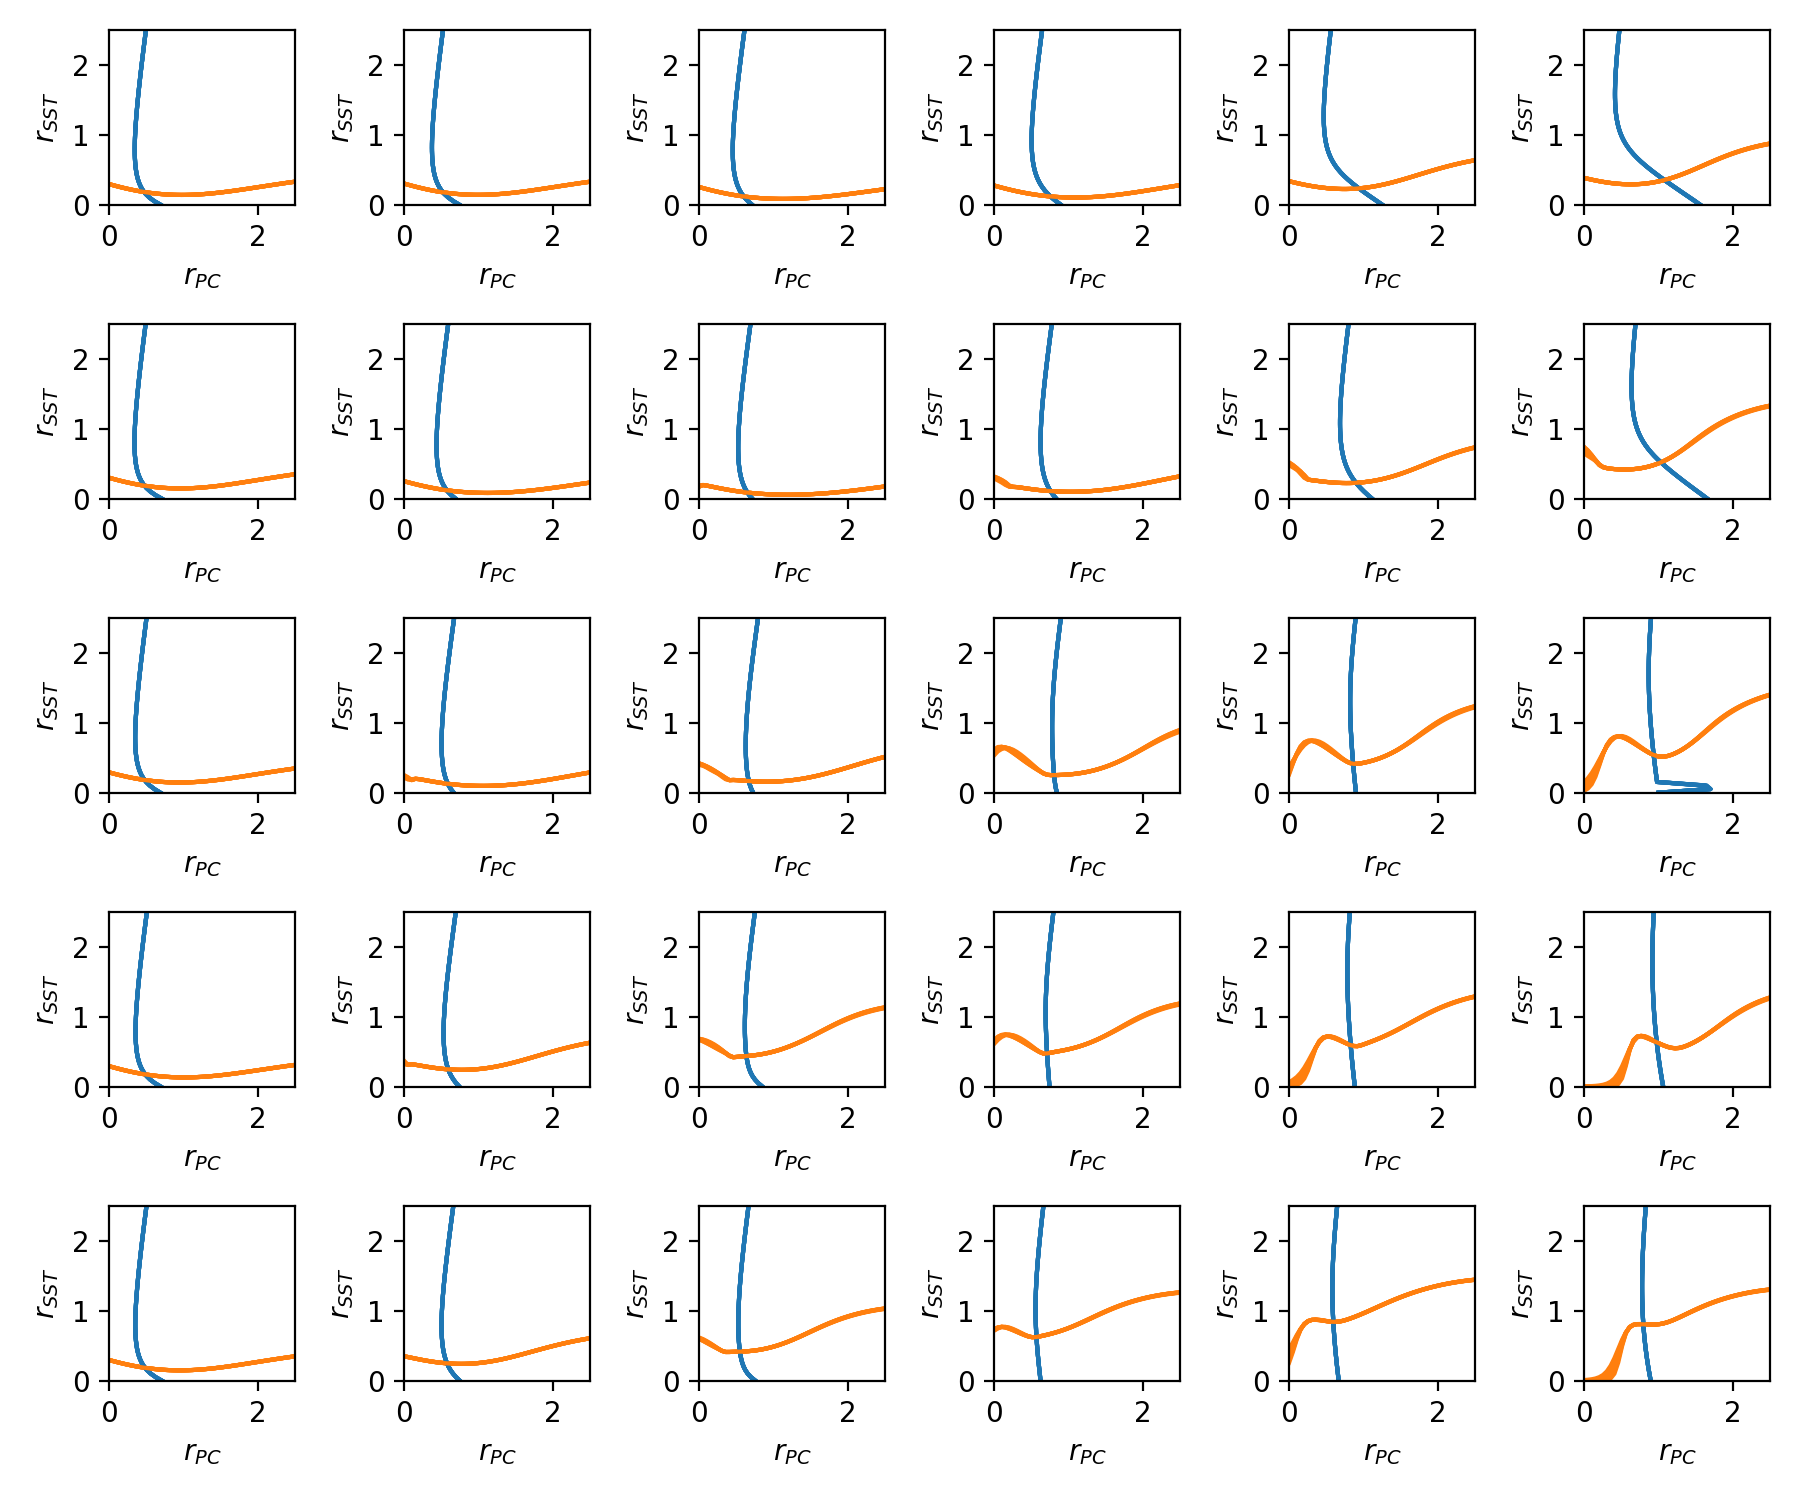

In [1986]:
mag = 1.5
plt.figure(figsize=(ncontrast*mag,nsize*mag))
# YY = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
ix = 0
iy = 1
for yy in [YY_ss]:#,YY_F2]:
    linestyles = ['solid','dashed']
    for istim in range(Nstim):
        plt.subplot(nsize,ncontrast,stim_vals[istim]+1)
        for it in np.arange(-1001,0,200):
            xvals = yy[iy,istim,:,it,ix]
            gd = xvals < max_val
            plt.plot(xvals[gd],yvals[gd],label='$dr_{PC}/dt=0$',c='C0',linestyle=linestyles[idir])
            xvals = yy[ix,istim,:,it,iy]
            gd = xvals < max_val
            plt.plot(yvals[gd],xvals[gd],label='$dr_{SST}/dt=0$',c='C1',linestyle=linestyles[idir])
    #     plt.legend()
        plt.xlabel('$r_{%s}$' % lbls[ix])
        plt.ylabel('$r_{%s}$' % lbls[iy])
#         plt.axis('equal')
        plt.ylim((0,1*max_val))
        plt.xlim((0,1*max_val))
    plt.tight_layout()

In [2101]:
nstar = len(trystars_i)
Niter = int(3e3)
fix_dim = [0,1,2,3]
Nfix = len(fix_dim)
# YY = [None for ifix in range(Nfix)]
Ny = 50
max_val = 2.5
yvals = np.linspace(0,max_val,Ny)
stim_vals = np.arange(30)
Nstim = len(stim_vals)
for istar in (0,): #range(nstar):
    print(istar)
#     ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[ti][tj]
    YY_ctrl = compute_steady_state(Wstar_dict['as_list'],Niter=int(5e2),dt=1e-1,perturbation_size=5e-2,max_val=None,Ny=None,fix_dim=None,stim_vals=None)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


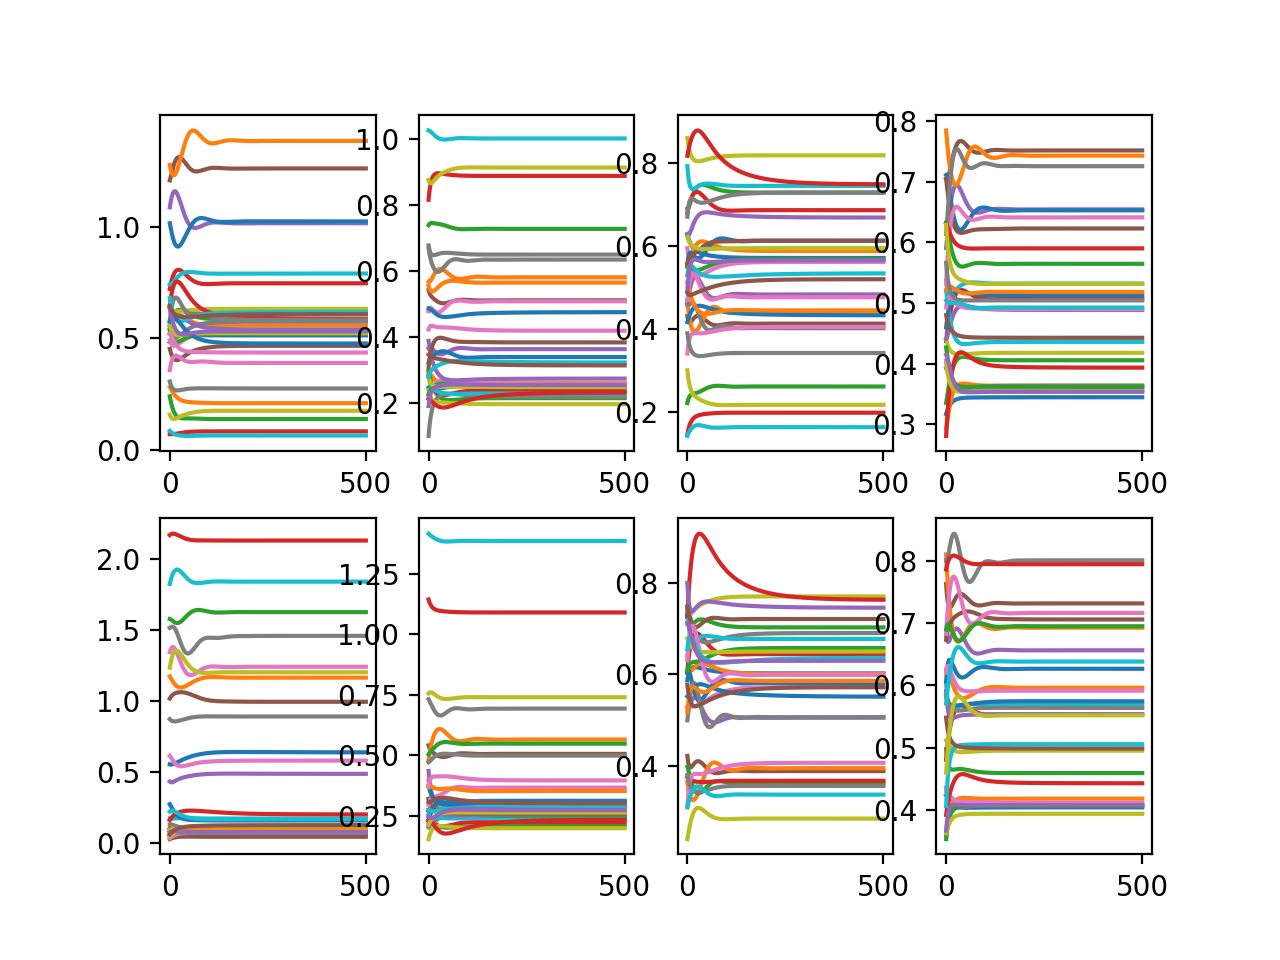

In [2104]:
plt.figure()
for icelltype in range(8):
    plt.subplot(2,4,icelltype+1)
    plt.plot(YY_ctrl[:,:,icelltype].T)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


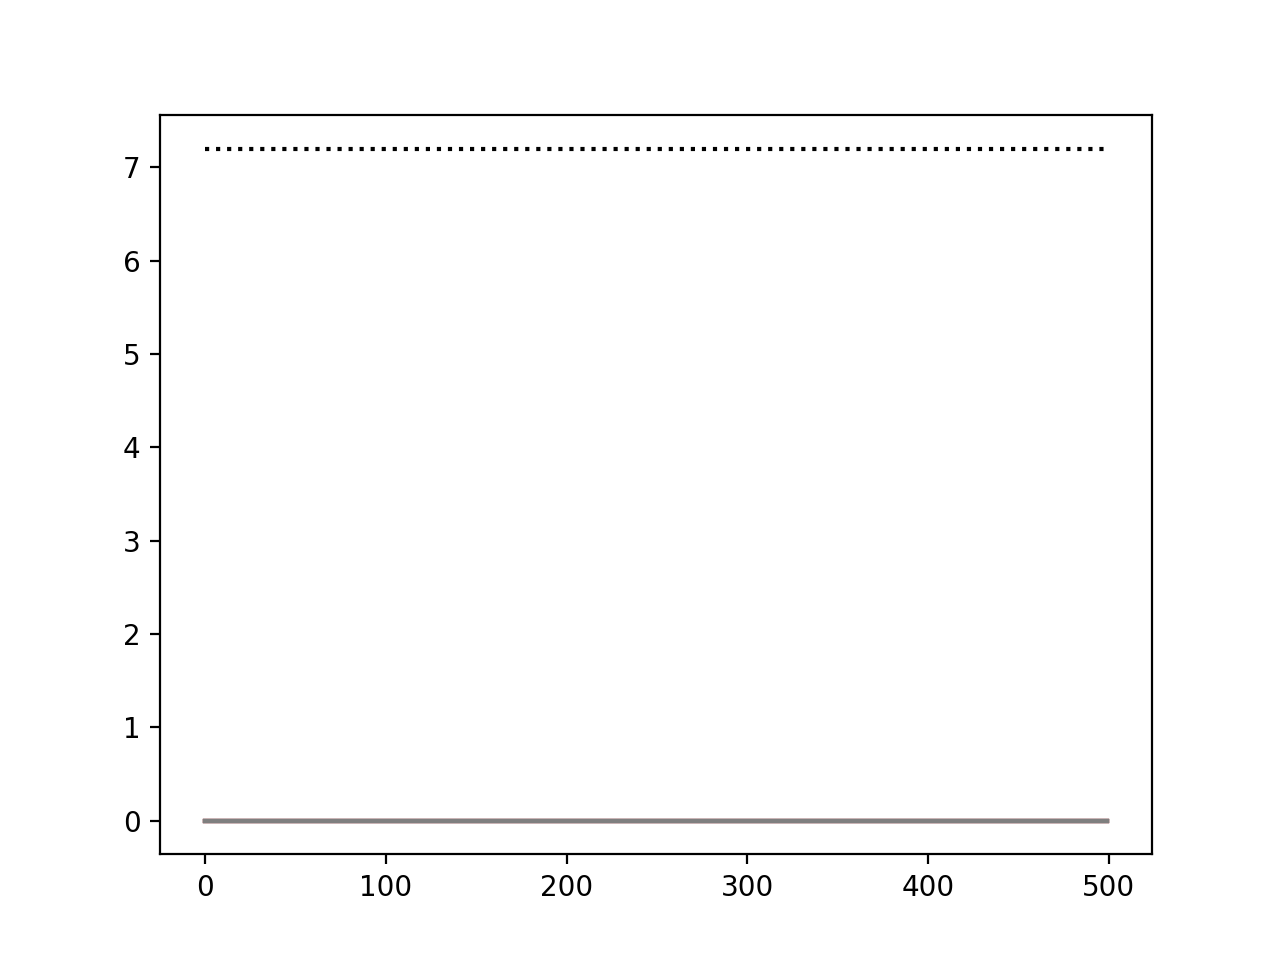

In [2105]:
istim = 29
iy = 0
others = np.arange(8)!=iy
# this_yy = YY_F2[iy,istim,:,iinit,:,:]
this_yy = YY_ss[iy,istim,:,:,:]
def fY(XX,YY):
    return compute_f_(resEta[istim]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[istim]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
speed = np.sum(np.abs(fY(XX[istim],this_yy)-this_yy)[:,:,others],-1)
plt.figure()
this_one = 25
plt.plot(speed[this_one,-500:].T,c='k',linestyle='dotted')
plt.plot(YY_ss[iy,istim,this_one,-500:,:])

In [1414]:
fY(XX[istim],this_yy).shape

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


(50, 4001, 8)

<IPython.core.display.Javascript object>


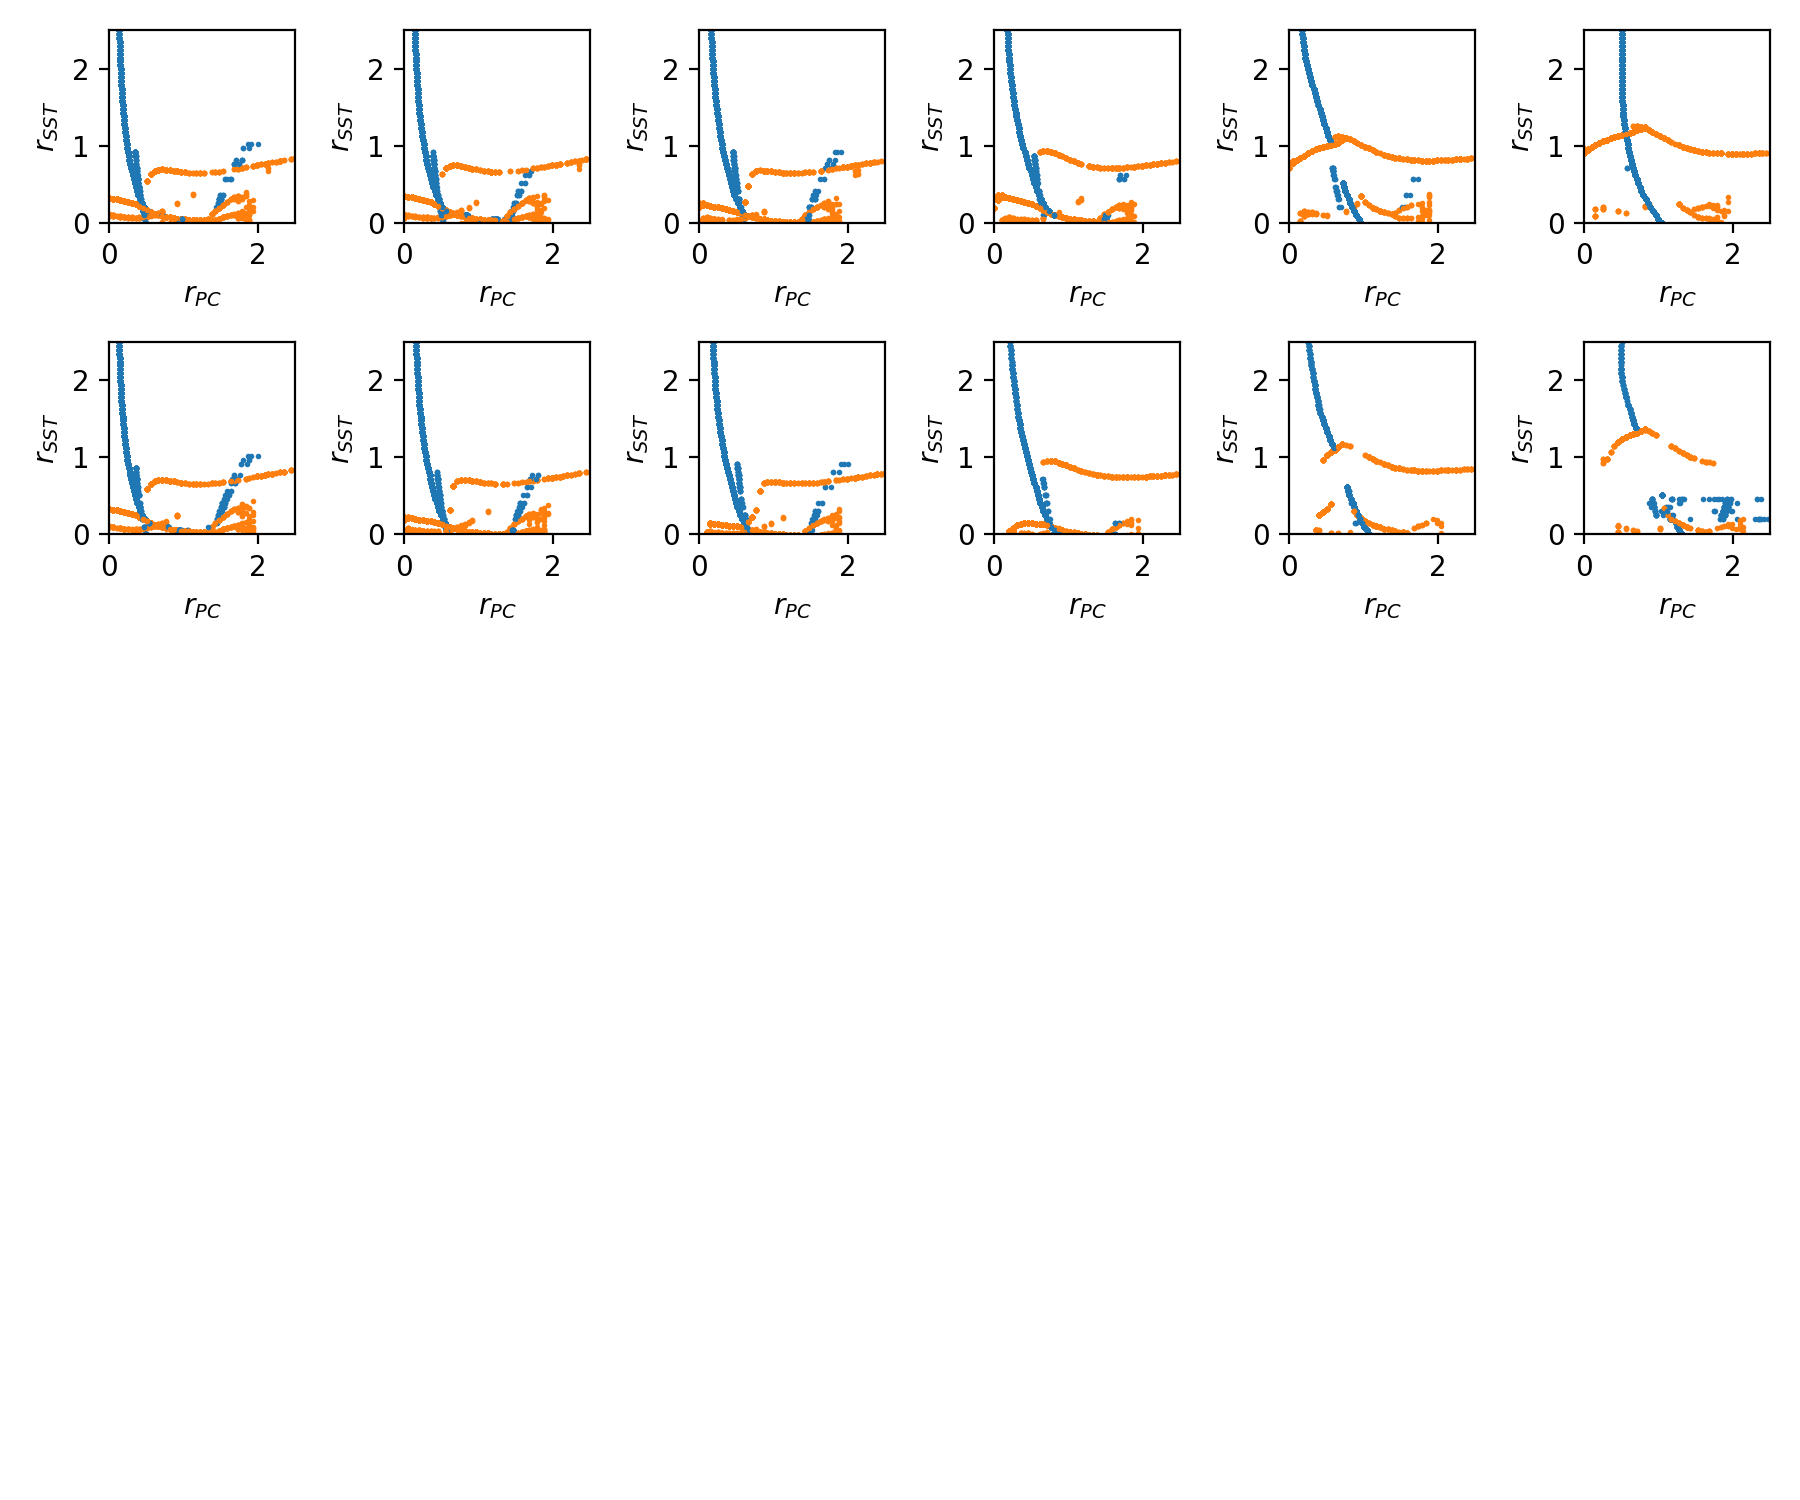

In [1399]:
mag = 1.5
plt.figure(figsize=(ncontrast*mag,nsize*mag))
# YY = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
ix = 0
iy = 1
idir = 0
for yy in [YY_F2]:
    linestyles = ['solid','dashed']
    for istim in range(12):#Nstim):
        def fY(YY):
            return compute_f_(resEta[stim_vals[istim]]+u_fn(XX[stim_vals[istim]],YY,Wmx,Wmy,k,kappa),resXi[stim_vals[istim]]+u_fn(XX[stim_vals[istim]],YY,Wsx,Wsy,k,kappa),s02)
        plt.subplot(nsize,ncontrast,stim_vals[istim]+1)
        for it in (-250,-100,-1):
            for iinit in range(Nx):
                this_yy = yy[iy,istim,:,iinit,it,:]
                xvals = yy[iy,istim,:,iinit,it,ix]
                gd = (xvals < max_val) & np.sum(np.abs(fY(this_yy)-this_yy),-1)<1e-4
                plt.scatter(xvals[gd],yvals[gd],label='$dr_{PC}/dt=0$',c='C0',linestyle=linestyles[idir],s=1)
                xvals = yy[ix,istim,:,iinit,it,iy]
                gd = xvals < max_val
                plt.scatter(yvals[gd],xvals[gd],label='$dr_{SST}/dt=0$',c='C1',linestyle=linestyles[idir],s=1)
    #     plt.legend()
        plt.xlabel('$r_{%s}$' % lbls[ix])
        plt.ylabel('$r_{%s}$' % lbls[iy])
#         plt.axis('equal')
        plt.ylim((0,1*max_val))
        plt.xlim((0,1*max_val))
    plt.tight_layout()

<IPython.core.display.Javascript object>


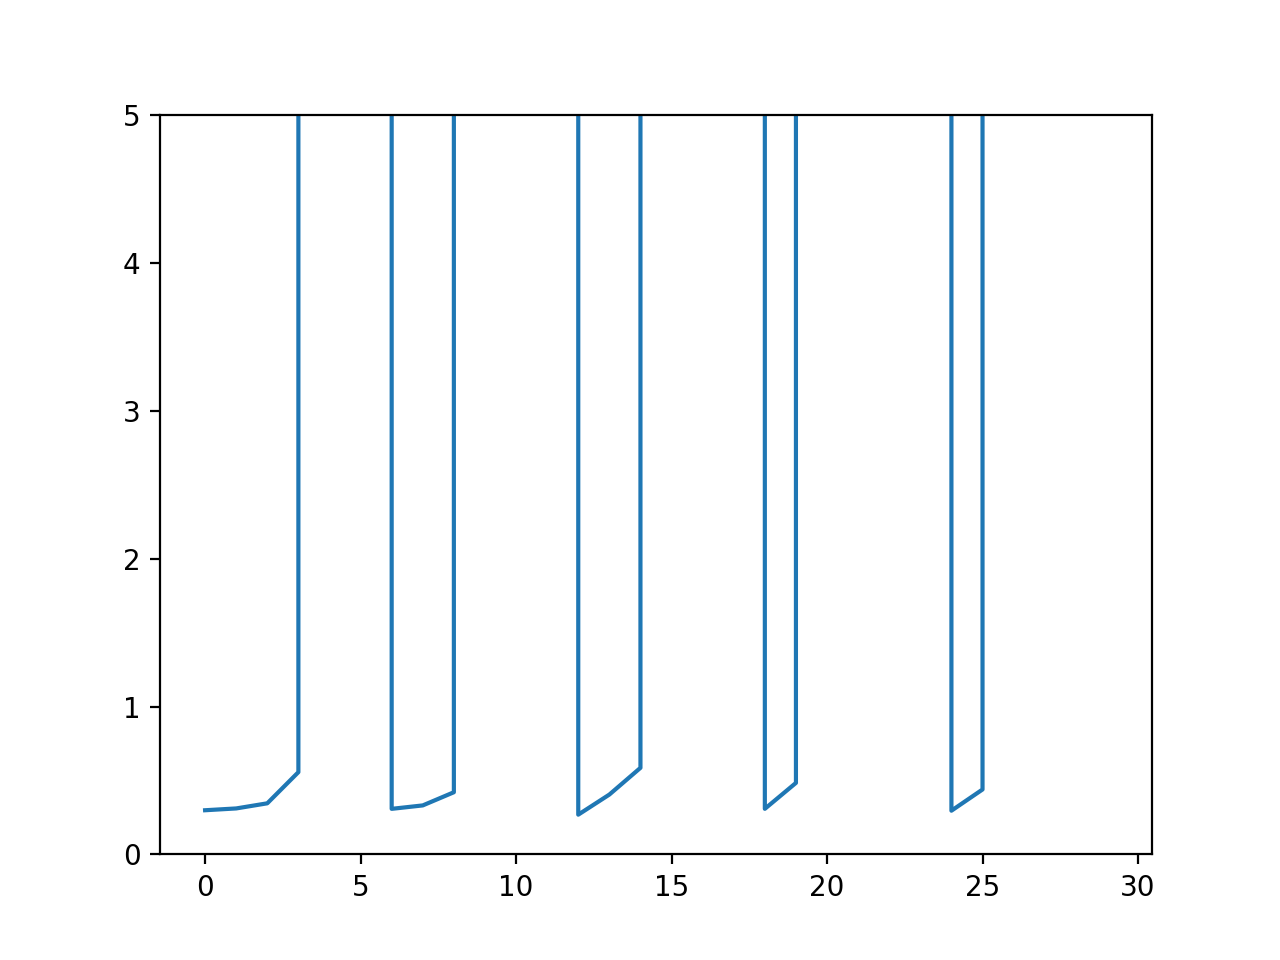

(0, 5)

In [873]:
plt.figure()
plt.plot(YY[iy,:,0,it,ix])
plt.ylim((0,5))

<IPython.core.display.Javascript object>


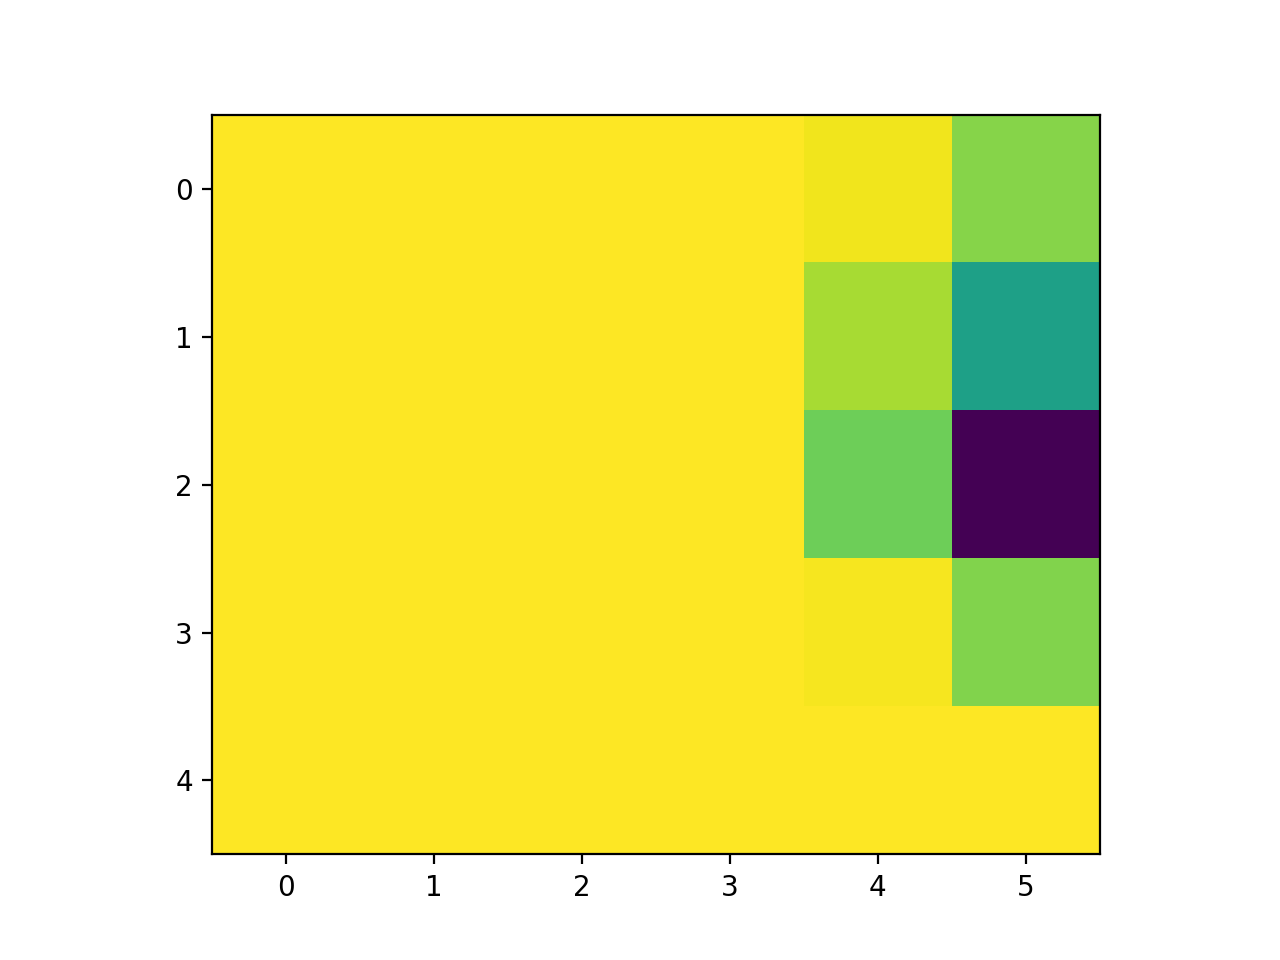

In [464]:
plt.figure()
istim = -12
plt.imshow((YY[0][:,1000,0]-YY[0][:,-1,0]).reshape((nsize,ncontrast)))

In [424]:
YY[0].shape

(30, 2001, 8)

<IPython.core.display.Javascript object>


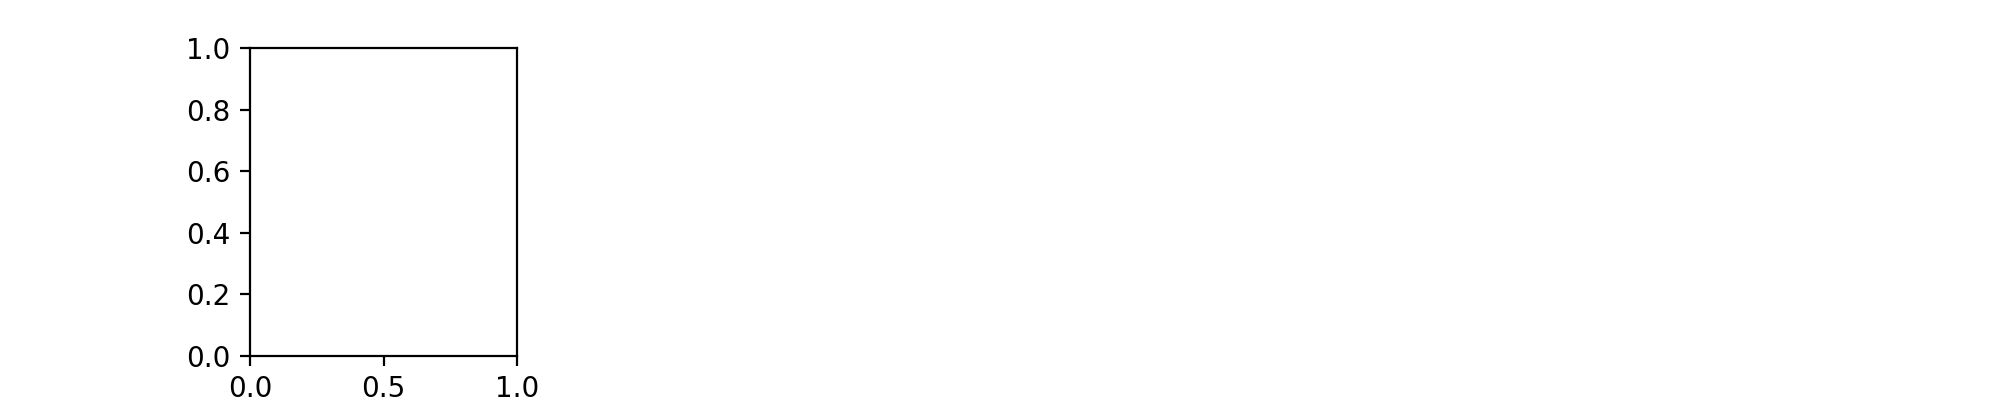

IndexError: too many indices for array

In [1268]:
mag = 2
plt.figure(figsize=(mag*ncelltypes,mag))
for icelltype in range(nQ):
    plt.subplot(1,ncelltypes,icelltype+1)
    plt.imshow(YY[:,:,-1,icelltype],vmin=0,interpolation='bilinear')
    plt.axis('off')

In [1278]:
nstar = len(trystars_i)
YY_no_vip = [None for istar in range(nstar)]
YY_no_sst = [None for istar in range(nstar)]
for istar in range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    YY = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,YY,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,YY,Wsx,Wsy,k,kappa)
    def fY(XX,YY,resEta,resXi):
        return compute_f_(u_fn(XX,YY,Wmx,Wmy,k,kappa)+resEta,u_fn(XX,YY,Wsx,Wsy,k,kappa)+resXi,s02)
    def thisfY(YY0):
        return fY(XX,YY0,resEta,resXi)
    def predict_YY_silencing(YY0,XX,resEta,resXi,silenced,eta=1e-4):
        def dYYdt(YY):
            return -YY + thisfY(YY)
        YY = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.ones_like(YY)
        iiter = 0
        while iiter < 1e4: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            iiter = iiter+1
            dYY = eta*dYYdt(YY)
            YY = YY + dYY
            YY[:,silenced] = 0
        return YY
    silenced = np.array((0,0,1,0,0,0,1,0),dtype='bool')
    YY_no_vip[istar] = predict_YY_silencing(YY,XX,resEta,resXi,silenced)
    silenced = np.array((0,1,0,0,0,1,0,0),dtype='bool')
    YY_no_sst[istar] = predict_YY_silencing(YY,XX,resEta,resXi,silenced)

0


In [1224]:
# plt.figure()
# inputs = XXhat[:,[0,2]]
# sort_inp = np.argsort(inputs[:,0])
# plt.scatter(inputs[:,0],inputs[:,1])

<IPython.core.display.Javascript object>


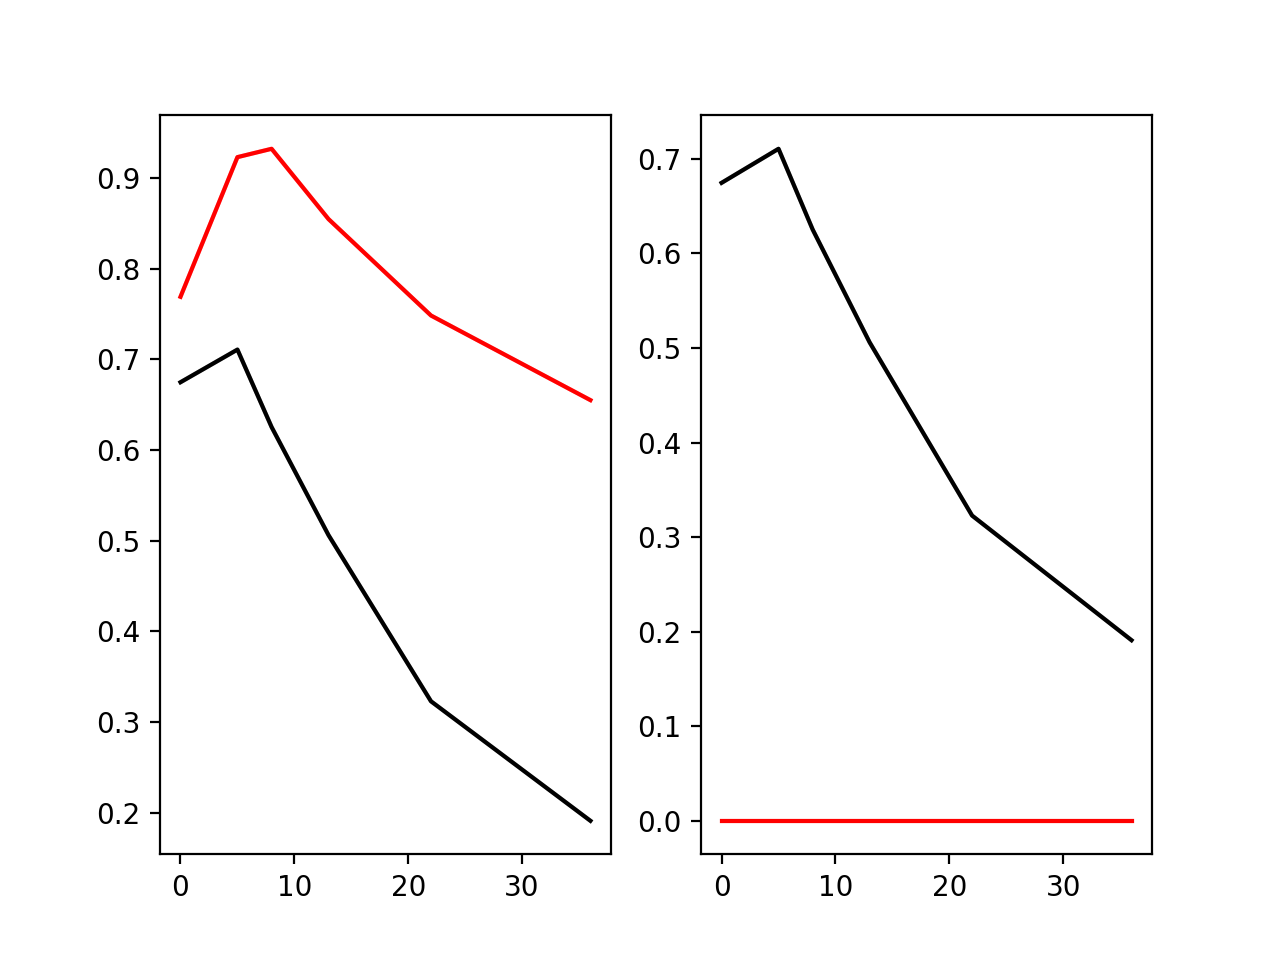

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [1270]:
plt.figure()
alpha1 = 0.25
ic = 2
icontrast = 5
colors = ['k','r']
def norm01(arr):
    return (arr-arr.min())/(arr.max()-arr.min())
for istar in range(nstar):
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    YY = compute_f_(Eta,Xi,s02)
    plt.subplot(1,2,1)
    usize0 = (0,5,8,13,22,36)
    sc = YY[:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    if istar == 0:
        avg_curves = np.zeros((2,2,)+to_plot.shape)
    avg_curves[0,0] = avg_curves[0,0] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[0],alpha=alpha1)
    sc = YY_no_sst[istar][:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    avg_curves[0,1] = avg_curves[0,1] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[1],alpha=alpha1)
    plt.subplot(1,2,2)
    usize0 = (0,5,8,13,22,36)
    sc = YY[:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    avg_curves[1,0] = avg_curves[1,0] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[0],alpha=alpha1)
    sc = YY_no_vip[istar][:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    avg_curves[1,1] = avg_curves[1,1] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[1],alpha=alpha1)
for imanip in range(2):
    plt.subplot(1,2,imanip+1)
    plt.plot(usize0,avg_curves[imanip,0],c=colors[0])
    plt.plot(usize0,avg_curves[imanip,1],c=colors[1])
    

<IPython.core.display.Javascript object>


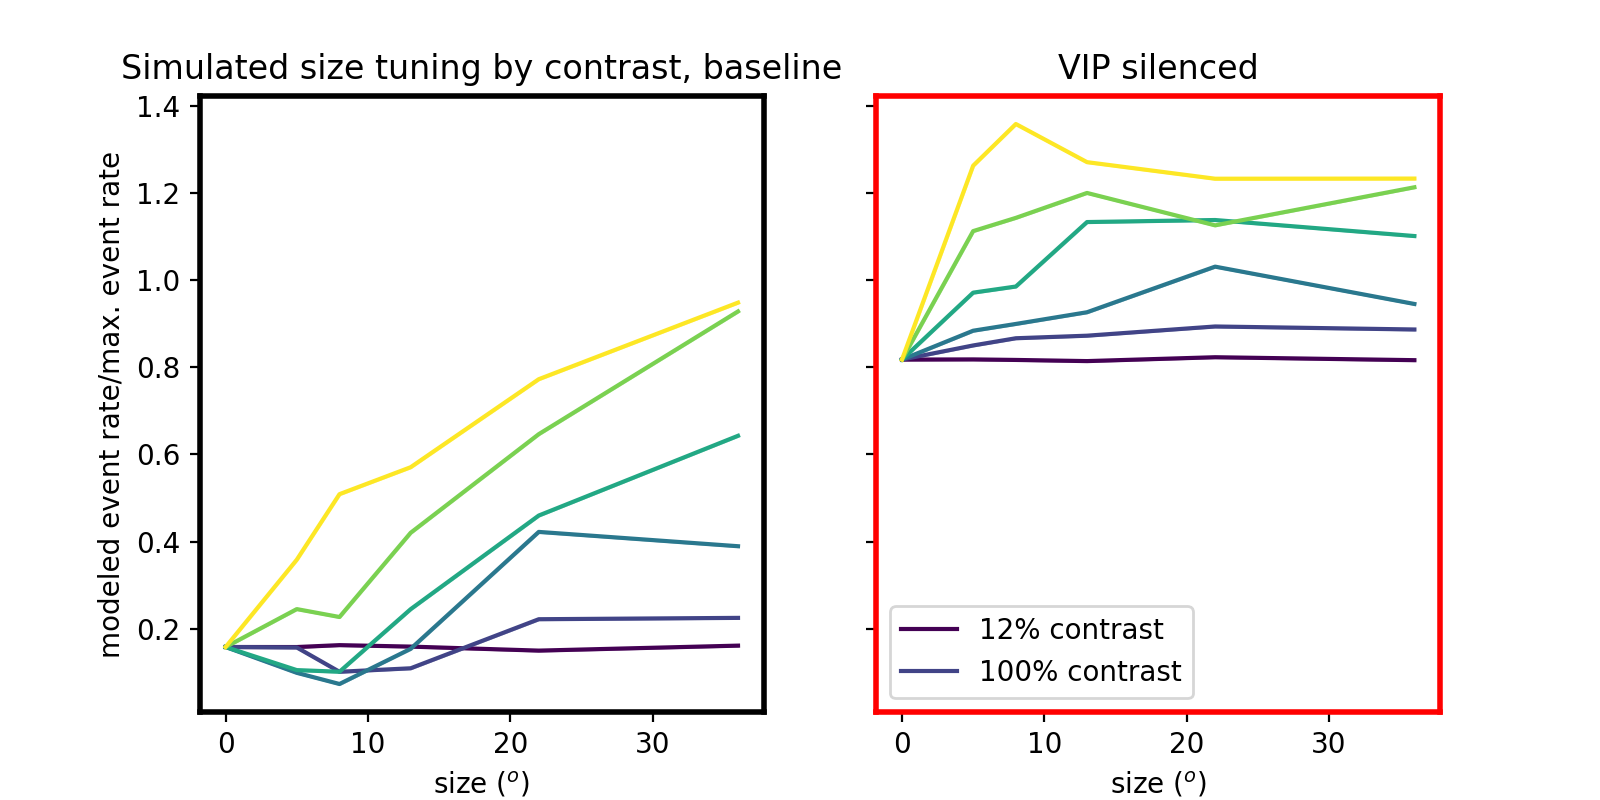

In [1281]:
fig,axes = plt.subplots(1,2,sharey=True,figsize=(8,4))
alpha1 = 0.25
ic = 1
icontrasts = np.arange(6)
colors = ['k','r']
colors = plt.cm.viridis(np.linspace(0,1,6))
nstar = 1
def norm01(arr):
    return (arr-arr.min())/(arr.max()-arr.min())
for icontrast in icontrasts:
    for istar in range(nstar):
        ti,tj = trystars_i[istar],trystars_j[istar]
        Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
        YY = compute_f_(Eta,Xi,s02)
        usize0 = (0,5,8,13,22,36)
        sc = YY[:,ic].reshape((nsize,ncontrast))
        to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
        if istar == 0:
            avg_curves = np.zeros((2,2,)+to_plot.shape)
            to_plots = [np.zeros((0,)+to_plot.shape) for il in range(2)]
        avg_curves[1,0] = avg_curves[1,0] + to_plot/nstar
#         plt.subplot(1,2,1)
        to_plots[0] = np.concatenate((to_plots[0],to_plot[np.newaxis]))
#         plt.plot(usize0,to_plot,c=colors[icontrast],alpha=alpha1)
        sc = YY_no_vip[istar][:,ic].reshape((nsize,ncontrast))
        to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
        avg_curves[1,1] = avg_curves[1,1] + to_plot/nstar
#         plt.subplot(1,2,2)
#         plt.plot(usize0,to_plot,c=colors[icontrast],alpha=alpha1)
        to_plots[1] = np.concatenate((to_plots[1],to_plot[np.newaxis]))
    for il in range(2):
#         plt.subplot(1,2,il+1)
        axes[il].plot(usize0,avg_curves[1,il],c=colors[icontrast])
        lb,ub = ut.bootstrap(to_plots[il],pct=(16,84),fn=np.nanmean,axis=0)
        axes[il].fill_between(usize0,lb,ub,color=colors[icontrast],alpha=alpha1)
# plt.subplot(1,2,1)
# plt.title('Center-aligned, response to 12% contrast')
# plt.subplot(1,2,1)
axes[0].set_ylabel('modeled event rate/max. event rate')
axes[0].set_xlabel('size ($^o$)')
axes[1].set_xlabel('size ($^o$)')
plt.setp(axes[0].spines.values(),color='k',linewidth=2)
plt.setp(axes[1].spines.values(),color='r',linewidth=2)
axes[0].set_title('Simulated size tuning by contrast, baseline')
axes[1].set_title('VIP silenced')
axes[1].legend(['12% contrast','100% contrast'])
# plt.savefig('figures/modeled_vip_halo_size_tuning_by_contrast_fill_between.jpg',dpi=300)

In [428]:
(ti,),(tj,) = np.where(loss==np.min(loss)) #2*loss.min()
[Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = Wt[ti][tj]

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


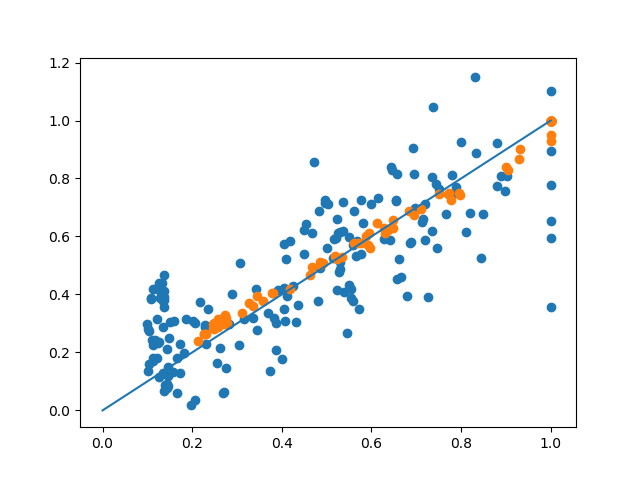

In [429]:
plt.figure()
XXhat = np.concatenate(Xhat,axis=1)
YYhat = np.concatenate(Yhat,axis=1)
plt.scatter(YYhat.flatten(),YY.flatten())
plt.scatter(XXhat.flatten(),XX.flatten())
plt.plot((0,1),(0,1))

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


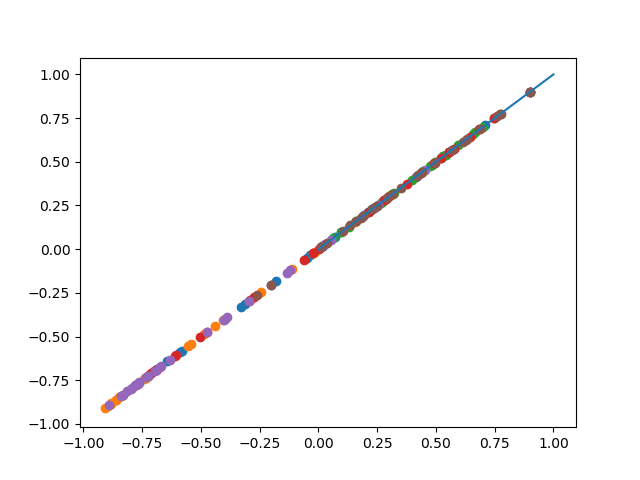

In [430]:
Etas = u_fn(XX,YY,Wmx,Wmy,k,kappa)
plt.figure()
for ic in range(6):
    plt.scatter(Eta[:,ic],Etas[:,ic])
plt.plot((0,1),(0,1))

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


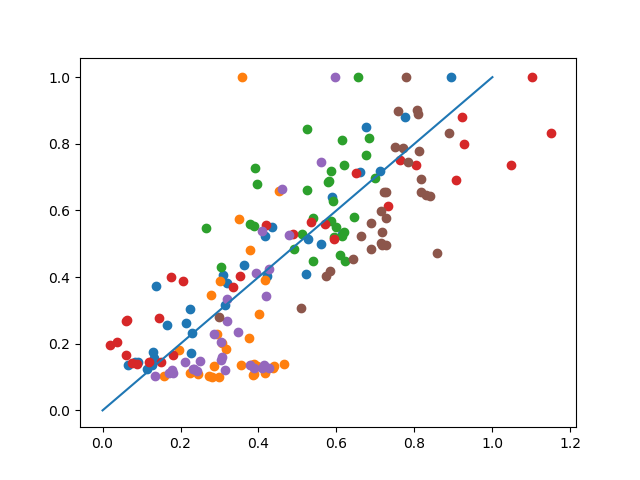

In [431]:
plt.figure()
YYs = compute_f_(Eta,Xi,s02)
for ic in range(6):
    plt.scatter(YY[:,ic],YYs[:,ic])
plt.plot((0,1),(0,1))

<IPython.core.display.Javascript object>


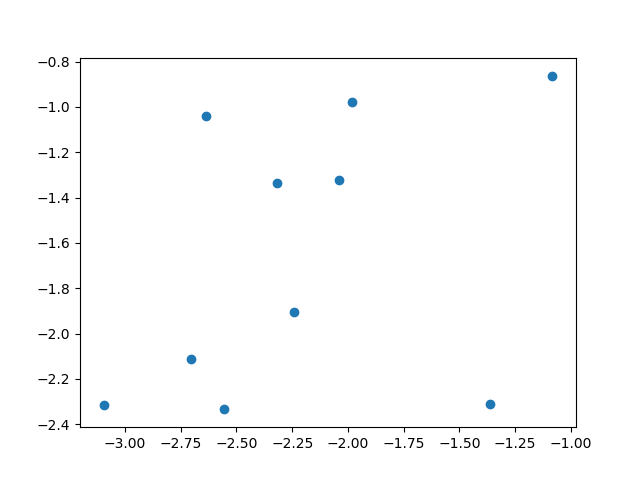

In [291]:
plt.figure()
plt.scatter(wmys[:,1,0],wmys[:,2,1])

In [514]:
wmys = np.concatenate([w[1][np.newaxis] for w in np.concatenate(Wt)],axis=0)
# trystar = np.argmax(wmys[:,1,0]*wmys[:,2,1])
# trystar = np.argmin(loss)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


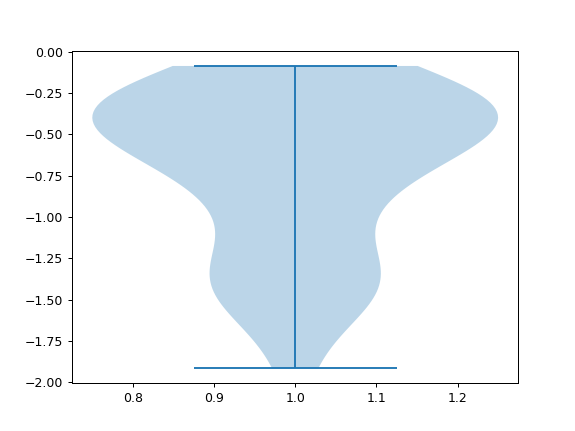

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f1bdc083a90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f1bdb9cec50>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f1bdc083790>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f1bdc083990>}

In [516]:
plt.figure()
plt.violinplot(wmys[:,1,0])

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


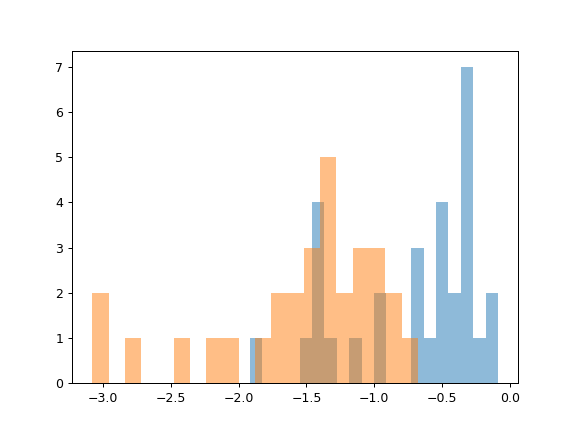

(array([2., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 2., 2., 3., 5., 2., 3.,
        3., 2., 1.]),
 array([-3.08046601, -2.96038626, -2.84030651, -2.72022677, -2.60014702,
        -2.48006727, -2.35998753, -2.23990778, -2.11982804, -1.99974829,
        -1.87966854, -1.7595888 , -1.63950905, -1.51942931, -1.39934956,
        -1.27926981, -1.15919007, -1.03911032, -0.91903057, -0.79895083,
        -0.67887108]),
 <a list of 20 Patch objects>)

In [515]:
plt.figure()
plt.hist(wmys[:,1,0],bins=20,alpha=0.5)
plt.hist(wmys[:,2,1],bins=20,alpha=0.5)

In [518]:
ws = [np.concatenate([w[q][np.newaxis] for w in np.concatenate(Wt)],axis=0) for q in range(len(Wt[0][0]))]
[Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = ws

In [541]:
ws = [np.concatenate([Wt[ti][tj][q][np.newaxis] for ti,tj in zip(trystars_i,trystars_j)],axis=0) for q in range(len(Wt[0][0]))]
[Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = ws

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


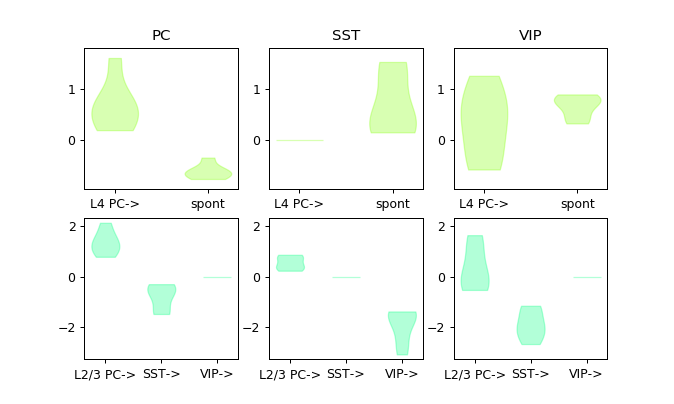

In [552]:
# ws = [np.concatenate([w[q][np.newaxis] for w in np.concatenate(Wt)],axis=0) for q in range(len(Wt[0][0]))]
# [Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = ws
plt.figure(figsize=(7.5,4.5))
for datas in [[Wmx,Wmy]]:#,[Wsx,Wsy]]:
    titles = ['PC','SST','VIP']
    data = datas[0]
    x = np.arange(1,data.shape[1]+1)
    xlbl = ['L4 PC->','spont']
    for icelltype in range(3):
        plt.subplot(2,3,icelltype+1)
        violin_parts = plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])],showextrema=False)
        for pc in violin_parts['bodies']:
            pc.set_facecolor([0.5,1,0.0])
            pc.set_edgecolor([0.5,1,0.0])
        plt.xticks(x,xlbl)
        plt.ylim(data.min()-0.2,data.max()+0.2)
        plt.title(titles[icelltype])
#     plt.figure(figsize=(7.5,2))
    data = datas[1]
    x = np.arange(1,data.shape[1]+1)
    xlbl = ['L2/3 PC->','SST->','VIP->']
    for icelltype in range(3):
        plt.subplot(2,3,3+icelltype+1)
#         plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])])
        violin_parts = plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])],showextrema=False)
        for pc in violin_parts['bodies']:
            pc.set_facecolor([0.0,1,0.5])
            pc.set_edgecolor([0.0,1,0.5])
        plt.xticks(x,xlbl)
        plt.ylim(data.min()-0.2,data.max()+0.2)
#         plt.title(titles[icelltype])
plt.savefig('violinplots_fit_weights.jpg',dpi=300)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


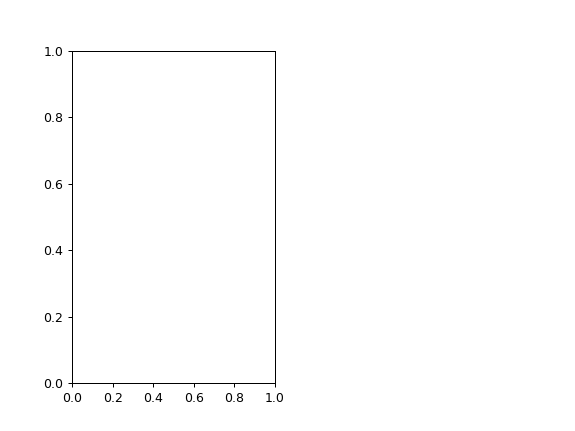

TypeError: list indices must be integers or slices, not tuple

In [543]:
plt.figure()
plt.subplot(1,2,1)
for ic in (0,):
    sca.scatter_size_contrast(YY[:,ic],YY_no_vip[:,ic])
    plt.plot((0,1),(0,1),c='k')
plt.axis('equal')
plt.subplot(1,2,2)
for ic in (0,):
    sca.scatter_size_contrast(YY[:,ic],YY_no_sst[:,ic])
    plt.plot((0,1),(0,1),c='k')
plt.axis('equal')

<IPython.core.display.Javascript object>


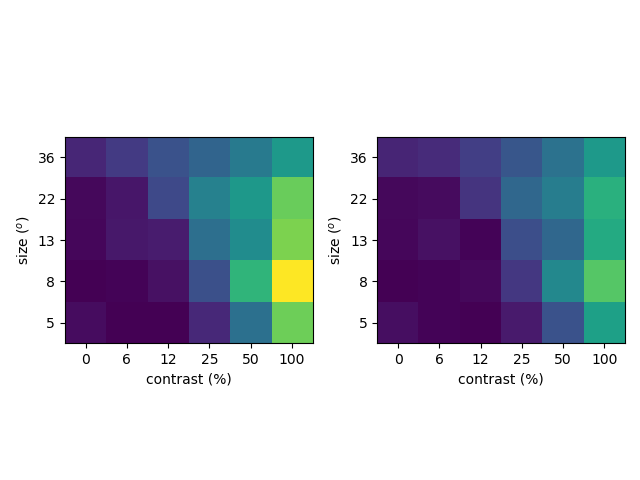

In [327]:
plt.figure()
ic = 0
plt.subplot(1,2,1)
sca.show_size_contrast(YY[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=YY[:,ic].max())
plt.subplot(1,2,2)
sca.show_size_contrast(YY_no_vip[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=YY[:,ic].max())
plt.tight_layout()

<IPython.core.display.Javascript object>


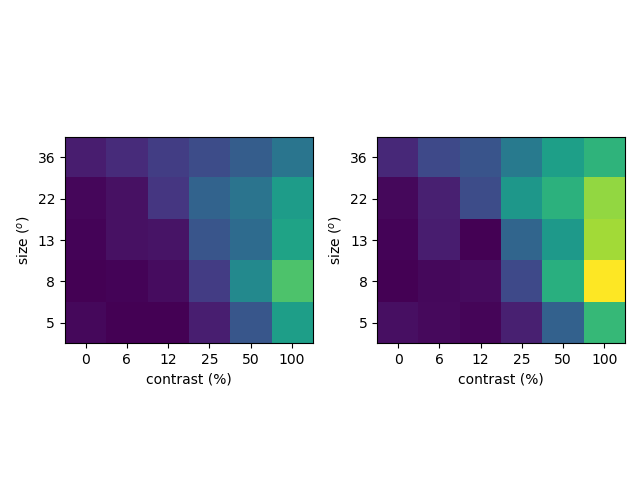

In [330]:
plt.figure()
ic = 0
mx = np.maximum(YY[:,ic].max(),YY_no_sst[:,ic].max())
plt.subplot(1,2,1)
sca.show_size_contrast(YY[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=mx)
plt.subplot(1,2,2)
sca.show_size_contrast(YY_no_sst[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=mx)
plt.tight_layout()

<IPython.core.display.Javascript object>


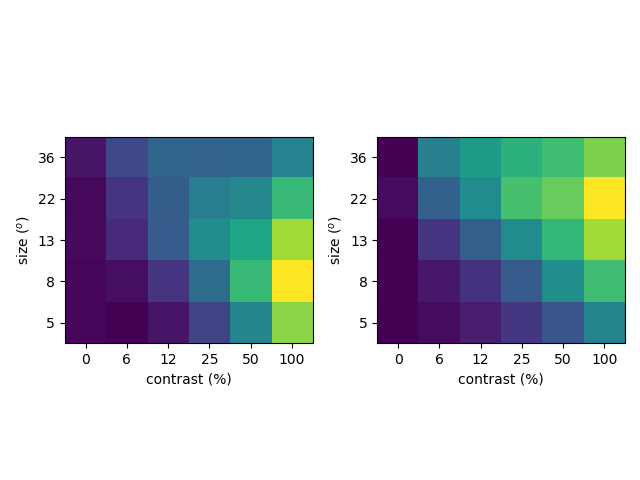

<IPython.core.display.Javascript object>


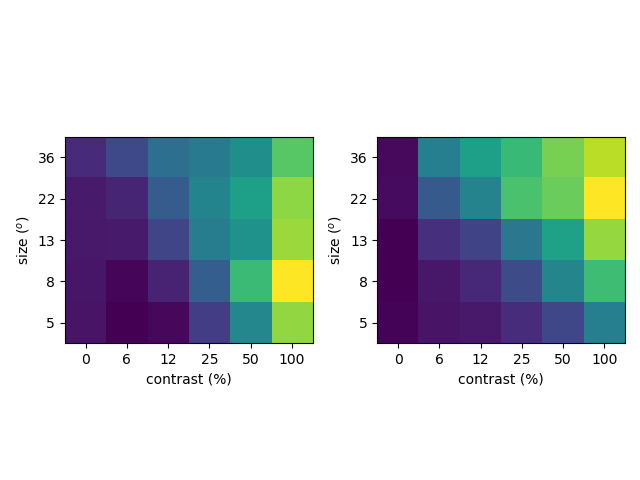

<IPython.core.display.Javascript object>


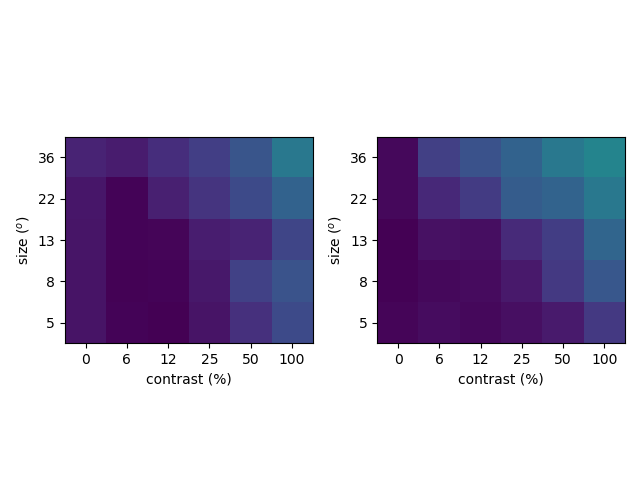

In [296]:
plt.figure()
reload(sca)
plt.subplot(1,2,1)
sca.show_size_contrast(YYhat[:,0].reshape((5,6)),flipud=True)
plt.subplot(1,2,2)
sca.show_size_contrast(YYhat[:,3].reshape((5,6)),flipud=True)
plt.tight_layout()

plt.figure()
reload(sca)
plt.subplot(1,2,1)
sca.show_size_contrast(YY[:,0].reshape((5,6)),flipud=True)
plt.subplot(1,2,2)
sca.show_size_contrast(YY[:,3].reshape((5,6)),flipud=True)
plt.tight_layout()

plt.figure()
reload(sca)
plt.subplot(1,2,1)
sca.show_size_contrast(YY_no_vip[:,0].reshape((5,6)),flipud=True,vmax=YY[:,0].max())
plt.subplot(1,2,2)
sca.show_size_contrast(YY_no_vip[:,3].reshape((5,6)),flipud=True,vmax=YY[:,3].max())
plt.tight_layout()

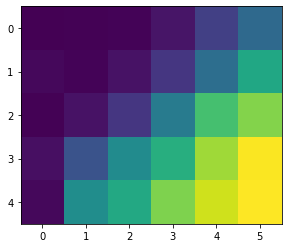

In [382]:
plt.figure()
plt.imshow(XX[:,2].reshape((5,6)))

In [383]:
vip_silencing = np.array((1,1,0,1,1,0))[np.newaxis,:]
Etas = u_fn(XX,YY,Wmx,Wmy,k)
Eta_no_vip = u_fn(XX,vip_silencing*YY,Wmx,Wmy,k) + Eta - Etas
YY_no_vip = compute_f_(Eta_no_vip,Xi,s02)*vip_silencing

In [ ]:
labels = ['Wmx','Wmy','Wsx','Wsy','s02','k','Y','momentum','loss']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wstar_t[i]

In [ ]:
evaluate_stability(W0my,k0)

In [ ]:
def sorted_r_eigs(w):
    drW,prW = np.linalg.eig(w)
    srtinds = np.argsort(drW)
    return drW[srtinds],prW[:,srtinds]

def gen_Weight(W,K):
    WW0 = np.concatenate((W,W*K[np.newaxis,:]),axis=1)
    WW1 = np.concatenate((W*K[np.newaxis,:],W),axis=1)
    WW = np.concatenate((WW0,WW1),axis=0)
    return WW
    
def evaluate_stability(Wmy,k):
    W = gen_Weight(Wmy,k)
    drW,prW = sorted_r_eigs(W - np.eye(npixels*nQ))
    return np.real(drW[-1])

In [ ]:
t = 999
W0mx,W0my,W0sx,W0sy,s020,k0 = [Wstar_t2[i][t].copy() for i in range(6)]

In [ ]:
nbeta = 51
loss = np.zeros((nbeta,))
stability = np.zeros((nbeta,))
betas = np.linspace(-1,1,nbeta)
vecY = np.random.randn(nQ,nQ)
vecX = np.random.randn(nP,nQ)
for ibeta,beta in enumerate(betas):
    perturbationY = beta*vecY
    perturbationX = beta*vecX
#     perturbationY = beta*np.array(((-1,0,0),(0,0,-1),(0,-1,0))) #beta*np.array(((2,0,0),(0,0,0),(0,0,0))) #perturbationY = beta*np.array(((0,0,0),(0,0,-1),(0,0,0))) # np.array(((0,0,0),(-1,0,0),(0,0,0)))
#     perturbationX = beta*np.array(((-1,0,0),(0,0,0))) #beta*np.array(((-1,0,0),(0,0,0))) #perturbationX = beta*np.array(((0,0,1),(0,0,0)))
#     perturbationSY = 0*beta*np.array(((0,0,0),(0,0,1),(0,0,0)))
    Wmy_beta = perturbationY+W0my.copy()
    Wmx_beta = perturbationX+W0mx.copy()
#     Wsy_beta = perturbationSY+W0sy.copy()
    loss[ibeta] = evaluate_LW(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=Y0.copy(),W0mx=Wmx_beta,W0my=Wmy_beta,W0sx=W0sx.copy(),W0sy=W0sy,s020=s020.copy(),k0=k0.copy(),bounds=bounds,weight=weight)
    stability[ibeta] = evaluate_stability(Wmy_beta,k0)

In [ ]:
plt.figure()
lkat = stability < 0
plt.plot(betas[lkat],loss[lkat])
plt.plot(betas[lkat],stability[lkat])
plt.ylim(-1,0.5)

In [ ]:
(betas[lkat][np.argmin(loss[lkat])],np.min(loss[lkat]))

In [ ]:
beta_star = betas[lkat][np.argmin(loss[lkat])]

In [ ]:
niter = int(1e3)
eta = 0.3
gamma = 0.9
weight = np.array((0,1,0))
beta = 0
perturbationY = beta*beta_star*vecY*1e-2
perturbationX = beta*beta_star*vecX*1e-2
# perturbationY = 0*beta*np.array(((-1,0,0),(0,0,-1),(0,-1,0))) #beta*np.array(((2,0,0),(0,0,0),(0,0,0))) #perturbationY = beta*np.array(((0,0,0),(0,0,-1),(0,0,0))) # np.array(((0,0,0),(-1,0,0),(0,0,0)))
# perturbationX = 0*beta*np.array(((-1,0,0),(0,0,0))) #beta*np.array(((-1,0,0),(0,0,0))) #perturbationX = beta*np.array(((0,0,1),(0,0,0)))
# # perturbationSY = beta*np.array(((0,0,0),(0,0,1),(0,0,0)))
# thisY0 = np.ones_like(Y0)
Y0 = [np.concatenate([x.mean(0)[:,np.newaxis] for x in Yhat[ialign]],axis=1) for ialign in range(npixels)]
Wstar_t2 = fit_W_momentum(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=Y0.copy(),W0mx=perturbationX+W0mx.copy(),W0my=perturbationY+W0my.copy(),W0sx=W0sx.copy(),W0sy=W0sy.copy(),s020=s020.copy(),k0=k0.copy(),bounds=bounds,niter=niter,weight=weight,eta=eta,gamma=gamma,barrier_wt=100e-4)#,eta_decay=eta_decay)

In [ ]:
np.linalg.eig(Wstar_dict2['Wmy'][400]-np.eye(nQ))

In [ ]:
titles = ['PC','SST','VIP']
t = 500
plt.figure(figsize=(6,2))
lbl = 'Wmx'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L4 PC->','spont']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])

plt.figure(figsize=(9,2))
lbl = 'Wmy'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L2/3 PC->','SST->','VIP->']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])
    
plt.figure(figsize=(6,2))
lbl = 'Wsx'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L4 PC->','spont']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])

plt.figure(figsize=(9,2))
lbl = 'Wsy'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L2/3 PC->','SST->','VIP->']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])


In [ ]:
#Wstar_dict = np.load('w_over_time_miller_troyer_data_loss.npy',allow_pickle=True)[()]

In [ ]:
Wstar_t_init = [ww[-1].copy() for ww in Wstar_t2]
W0mx,W0my,W0sx,W0sy,s020 = [Wstar_t_init[i].copy() for i in range(5)]
Y0 = Wstar_t_init[-3].copy()

In [ ]:
niter = int(1e4)
eta = 1
gamma = 0.9
eta_decay = 1e-3
weight = np.array((1,1,1))
thisY0 = np.ones_like(Y0)
Wstar_t_novar = fit_W_momentum(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=thisY0,W0mx=W0mx.copy(),W0my=W0my.copy(),W0sx=W0sx.copy(),W0sy=W0sy.copy(),s020=s020.copy(),bounds=bounds,niter=niter,weight=weight,eta=eta,gamma=gamma)#,eta_decay=eta_decay)

In [ ]:
# niter = int(1e3)
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(Wstar_t2[i].reshape((niter+1,-1)))
plt.figure()
plt.plot(Wstar_t2[4].reshape((niter+1,-1)))

In [ ]:
# labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
# Wstar_dict = {}
# for i,label in enumerate(labels):
#     Wstar_dict[label] = Wstar_t[i]
# np.save('w_over_time_miller_troyer_data_loss.npy',Wstar_dict,allow_pickle=True)

In [ ]:
# labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
#Wstar_dict = {}
#for i,label in enumerate(labels):
#    Wstar_dict[label] = Wstar_t[i]


In [ ]:
def plot_tuning_and_loss(this_Wstar):
    plt.figure()
    plt.plot((this_Wstar[-3]/this_Wstar[-3].sum(1)[:,np.newaxis]).reshape((niter+1,-1)))
    plt.figure()
    plt.plot(this_Wstar[-1].reshape((niter+1,-1)))

In [ ]:
#niter = 300
plot_tuning_and_loss([x[:niter+1] for x in Wstar_t2])

In [ ]:
def scatter_results_spatial(this_Wstar,t=-1):
    plt.figure(figsize=(9,6))
    celltype = ['PC','SST','VIP']
    ialign = 0
    for ialign in range(2):
        for i in range(3):
            plt.subplot(2,3,3*ialign+i+1)
            plt.title(celltype[i])
            xx = Yhat[ialign][i].mean(0)/Yhat[ialign][i].mean(0).sum()
            yy = this_Wstar[-3][t,:,3*ialign+i]/this_Wstar[-3][t,:,3*ialign+i].sum()
            sca.scatter_size_contrast(xx,yy)
            plt.plot((0,xx.max()),(0,xx.max()),c='k')
            plt.xlabel('measured')
            plt.ylabel('modeled')
            plt.tight_layout()

In [ ]:
t = 500
scatter_results_spatial(Wstar_t2,t=t) #int(5e3))
# plt.savefig('figures/pc_sst_vip_measured_modeled_miller_troyer.pdf')

In [ ]:
def gaussian_fn(mu,sigma):
    return lambda x: 1/np.sqrt(2*np.pi)/np.abs(sigma)*np.exp(-0.5*(x-mu)/sigma**2)
xs = np.linspace(0,1,100)
ipt = 0
# plt.figure()
# for icelltype in range(2):
#     plt.plot(xs,gaussian_fn(um_fn(X[ipt],Y[ipt])[icelltype],us_fn(X[ipt],Y[ipt])[icelltype])(xs))

In [224]:
iiter = -1
Wmx,Wmy,Wsx,Wsy = [Wstar_t[i][iiter] for i in range(4)]

def fXY(x,y):
    return f_miller_troyer(x @ Wmx + y @ Wmy, x @ Wsx + y @ Wsy)

def u_fn_fn(Wx,Wy):
    return lambda x,y: x @ Wx + y @ Wy

def um_fn(x,y):
    return u_fn_fn(Wmy,Wmx)(x,y)

def us_fn(x,y):
    return u_fn_fn(Wsy,Wsx)(x,y)

# Ysolns = compute_Y_nonlinear_t_evolution(X,Wmx,Wmy,Wsx,Wsy,f_miller_troyer,Y0=Wstar_t[-2][iiter+1].copy())

NameError: name 'Wstar_t' is not defined

In [327]:
Xlbl = [['L4','spont'],['PC','SST','VIP']]
Ylbl = ['PC','SST','VIP']

In [283]:
for i in range(2):
    values0 = np.round(Wstar_t_novar[i][-1],decimals=2)
    values1 = np.round(Wstar_t_novar[i+2][-1],decimals=2)
    to_print = np.zeros_like(values0,dtype='<U32')
    if np.mod(i,2)==0:
        for i in range(to_print.shape[0]):
            for j in range(to_print.shape[1]):
                to_print[i,j] = Xlbl[0][i] + ' -> ' + Xlbl[1][j] + ': ' + str(values0[i,j]) + ' +/- ' + str(values1[i,j])
    else: 
        for i in range(to_print.shape[0]):
            for j in range(to_print.shape[1]):
                to_print[i,j] = Ylbl[i] + ' -> ' + Ylbl[j] + ': ' + str(values0[i,j]) + ' +/- ' + str(values1[i,j])
    print(to_print)
    print('\n')
# for i in range(4,5):
#     values = np.round(Wstar_t[i][-1],decimals=2)
#     print(values)

NameError: name 'Wstar_t_novar' is not defined

<IPython.core.display.Javascript object>


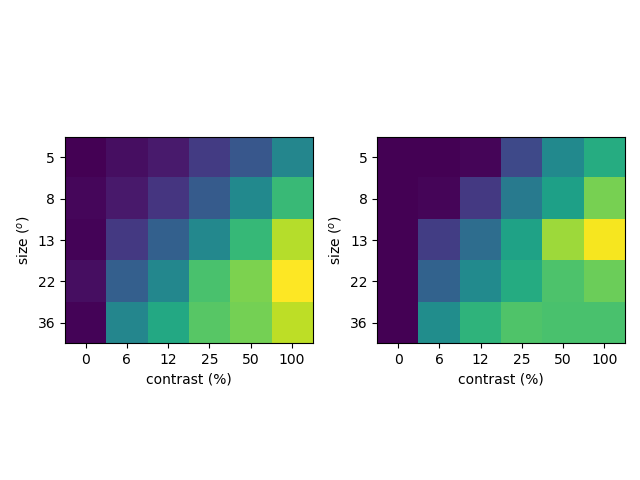

<IPython.core.display.Javascript object>


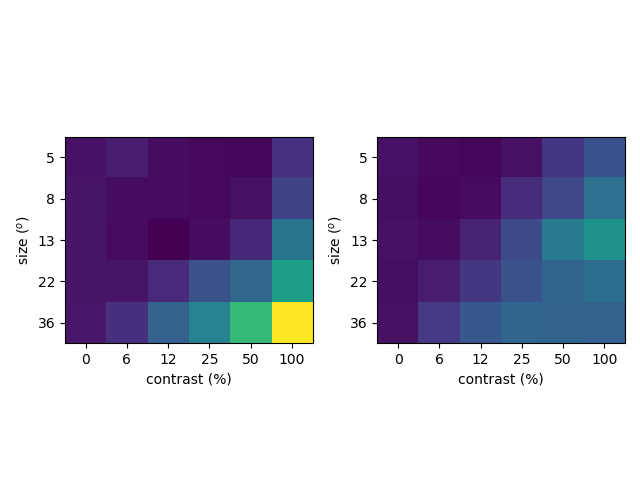

<IPython.core.display.Javascript object>


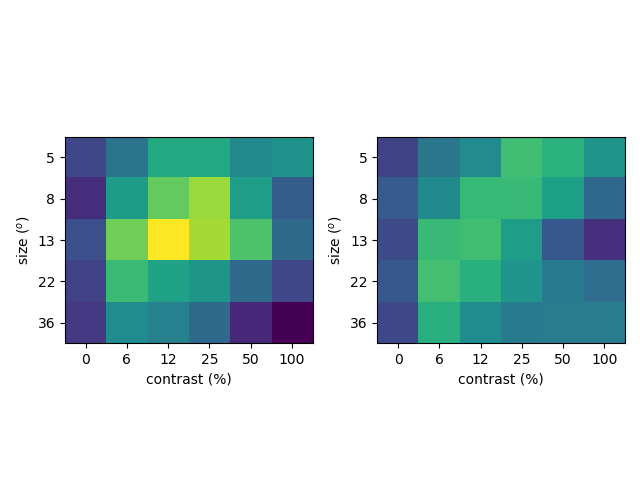

In [541]:
#lbl = ['pc','sst','vip']
#for icelltype in range(3):
#    this_Wstar = Wstar_t_novar
#    t = -1
#    display_model_fit(Yhat[icelltype].mean(0)/Yhat[icelltype].mean(0).sum(),this_Wstar[-3][t,:,icelltype]/this_Wstar[-3][t,:,icelltype].sum())
#    plt.savefig('figures/' + lbl[icelltype] + '_measured_modeled.pdf')

In [585]:
labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wstar_t[i]

In [586]:
np.save('w_over_time_miller_troyer_data_loss_momentum.npy',Wstar_dict,allow_pickle=True)

In [270]:
def scatter_results(this_Wstar,t=-1):
    plt.figure(figsize=(9,3))
    celltype = ['PC','SST','VIP']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(celltype[i])
        xx = Yhat[i].mean(0)/Yhat[i].mean(0).sum()
        yy = this_Wstar[-3][t,:,i]/this_Wstar[-3][t,:,i].sum()
        sca.scatter_size_contrast(xx,yy)
        plt.plot((0,xx.max()),(0,xx.max()),c='k')
        plt.xlabel('measured')
        plt.ylabel('modeled')
        plt.tight_layout()

In [1]:
icelltype = 3
u,s,v = np.linalg.svd(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])])
# plt.figure()
# plt.imshow(Rs[1][])

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


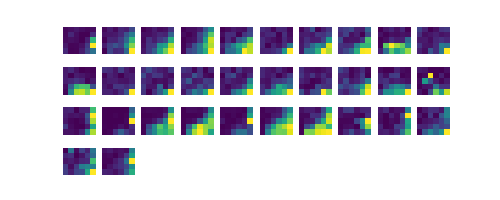

In [500]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(np.logical_and(u[:,0]<np.percentile(u[:,0],52.5),u[:,0]>np.percentile(u[:,0],47.5)))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


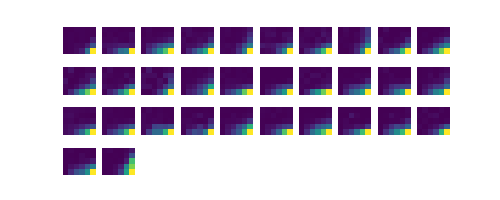

In [501]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(u[:,0]<np.percentile(u[:,0],5))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


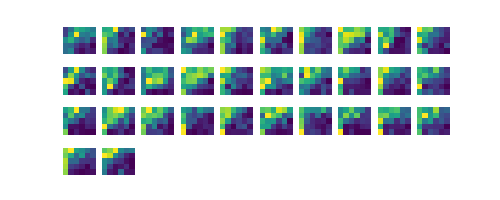

In [502]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(u[:,0]>np.percentile(u[:,0],95))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


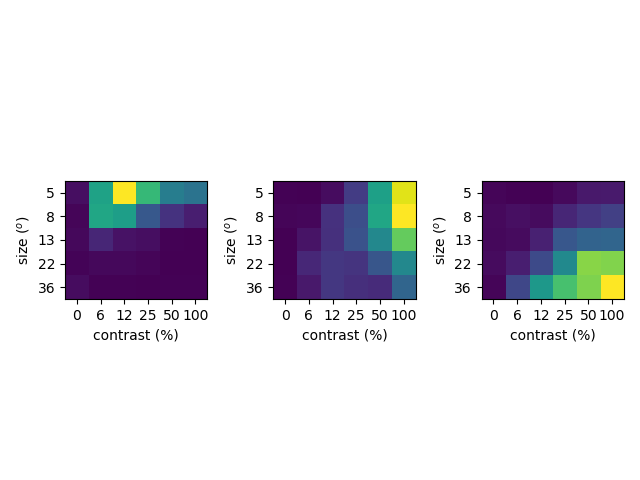

In [508]:
# ut.imshow_in_rows(Rs[1][~np.isnan(Rs[1][:,0])][np.where(u[:,0]>np.percentile(u[:,0],95))].reshape((-1,5,6)))
lower = np.where(u[:,0]<np.percentile(u[:,0],5))[0][28]
middle = np.where(np.logical_and(u[:,0]<np.percentile(u[:,0],52.5),u[:,0]>np.percentile(u[:,0],47.5)))[0][19]
upper = np.where(u[:,0]>np.percentile(u[:,0],95))[0][90]
plt.figure()
for i,thisone in enumerate([upper,middle,lower]):
    plt.subplot(1,3,i+1)
    sca.show_size_contrast(Rs[1][~np.isnan(Rs[1][:,0])][thisone].reshape((5,6)))
plt.tight_layout()
plt.savefig('figures/l23_pc_variability.pdf')

<IPython.core.display.Javascript object>


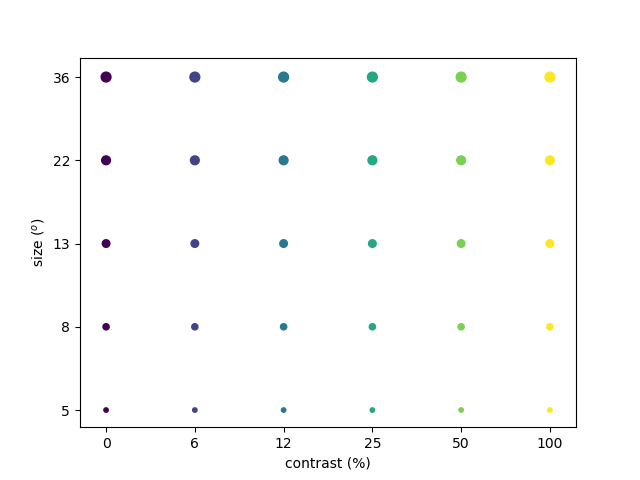

In [519]:
plt.figure()
xx,yy = np.meshgrid(np.arange(6),np.arange(5))
xx = xx.flatten()
yy = yy.flatten()
sca.scatter_size_contrast(xx,yy)
plt.xticks(np.arange(6),(0,6,12,25,50,100))
plt.xlabel('contrast (%)')
plt.yticks(np.arange(5),(5,8,13,22,36))
plt.ylabel('size ($^o$)')
plt.savefig('figures/measured_modeled_legend.pdf')
# plt.axis('off')

In [278]:
#niter = int(1e3)
#Ws = [Wstar_t[i][-1].copy() + 1e-2*np.random.randn(*Wstar_t[i][-1].shape) for i in range(4)]
#Wstar_t2 = fit_W_linearized_pointwise(X.copy(),Yhat.copy(),f_miller_troyer,Y0=Yhat.copy(),W0mx=Ws[0],W0my=Ws[1],W0sx=Ws[2],W0sy=Ws[3],bounds=bounds,niter=niter,weight=np.array((1,10,1)))
#scatter_results(Wstar_t2)

In [308]:
def pca_denoise(arr,Npc):
    u,s,v = np.linalg.svd(arr)
    return u[:,:Npc] @ np.diag(s[:Npc]) @ v[:Npc,:]

In [309]:
Rpc2 = pca_denoise(Rpc[~np.isnan(Rpc.sum(1))],10)

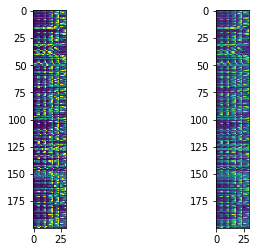

In [312]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Rpc[:200])
plt.subplot(1,2,2)
plt.imshow(Rpc2[:200])